In [61]:
import pandas as pd
import numpy as np
import sklearn
import matplotlib
from matplotlib import pyplot as plt
import keras
import warnings
from nltk.stem import PorterStemmer
from nltk import word_tokenize, sent_tokenize


from sklearn.preprocessing import OneHotEncoder
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import ShuffleSplit, StratifiedKFold
from sklearn.model_selection import learning_curve
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import validation_curve
import sklearn_evaluation 
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import random


pd.set_option('display.max_columns', 500)
pd.set_option('display.max_colwidth', -1)
%matplotlib inline  
warnings.filterwarnings("ignore")

In [2]:
wine = pd.read_csv('wine_reviews.csv')
wine = wine.sample(n=5000)

In [14]:
wine[['description','country','variety']].head()

description  \
74936  The aromas are subdued and lack in intensity but they do embrace floral and fruity notes of citrus, peach and green melon. The wine is simple and compact in the mouth with bright lemon zest on the close.                                                                                                                
18053  Very pure notes of cherry and strawberry pervade this wine. They are perfumed with a slight conifer scent that spells freshness and lifted ease. The palate has an unforced, elegant concentration. This is charming and fresh, with convincing depth, purity and a lasting, fresh finish.                                 
20291  Velvety tannins underlie a concentrated body of menthol, peppercorn, cedar and blackberry, punctuated in coffee along the way. An estate-bottling from one of the appellation's longstanding resident wineries, this wine is bold and brawny.                                                                              
34051  Savory notes of yeast trump fruit on the nose while the palate counters the spiciness with lots of zesty citrus. A very refreshing, lip-smacking Grüner, ideal for hot summer days.                                                                                                                                        
24646  A tasty, value-priced organic red that's perfect for grilled meat entrées with notes of mulled spices and espresso among the black berry and plum fruit core. Black cherry skins flesh out the medium-weight mouth, with firm tannins providing a tight structure and lingering through the long finish. Drink now–2012.   

            country                           variety  
74936  Italy         Pinot Grigio                      
18053  France        Pinot Noir                        
20291  US            Cabernet Sauvignon                
34051  Austria       Grüner Veltliner                  
24646  South Africa  Cabernet Sauvignon-Merlot-Shiraz

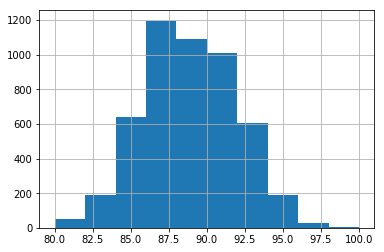

In [5]:
wine['points'].hist()

In [6]:
wine['points'][wine['points']<92] = 0
wine['points'][wine['points']>=92] = 1

In [7]:
corpus = wine['description']
stemmer = PorterStemmer()
processed_reviews = []
for review in corpus:
    review_tokenized = word_tokenize(review)
    new_review = []
    for word in review_tokenized:
        new_review.append(stemmer.stem(word))
    new_sentence = ' '.join(str(e) for e in new_review)
    processed_reviews.append(new_sentence)

print(processed_reviews[0:10])

['the aroma are subdu and lack in intens but they do embrac floral and fruiti note of citru , peach and green melon . the wine is simpl and compact in the mouth with bright lemon zest on the close .', 'veri pure note of cherri and strawberri pervad thi wine . they are perfum with a slight conif scent that spell fresh and lift eas . the palat ha an unforc , eleg concentr . thi is charm and fresh , with convinc depth , puriti and a last , fresh finish .', "velveti tannin underli a concentr bodi of menthol , peppercorn , cedar and blackberri , punctuat in coffe along the way . An estate-bottl from one of the appel 's longstand resid wineri , thi wine is bold and brawni .", 'savori note of yeast trump fruit on the nose while the palat counter the spici with lot of zesti citru . A veri refresh , lip-smack grüner , ideal for hot summer day .', "A tasti , value-pr organ red that 's perfect for grill meat entré with note of mull spice and espresso among the black berri and plum fruit core . bl

In [8]:
vectorizer = CountVectorizer(stop_words = 'english', max_features =150, binary = True)
review_words = vectorizer.fit_transform(processed_reviews)
review_words = review_words.toarray()
review_words.shape

(5000, 150)

In [26]:
threshold = 50 
country_counts = wine.country.value_counts()
repl = country_counts[country_counts <= threshold].index
countries = pd.get_dummies(wine.country.replace(repl, 'uncommon'))
countries.head()

Argentina  Australia  Austria  Chile  France  Germany  Italy  \
74936  0          0          0        0      0       0        1       
18053  0          0          0        0      1       0        0       
20291  0          0          0        0      0       0        0       
34051  0          0          1        0      0       0        0       
24646  0          0          0        0      0       0        0       

       New Zealand  Portugal  South Africa  Spain  US  uncommon  
74936  0            0         0             0      0   0         
18053  0            0         0             0      0   0         
20291  0            0         0             0      1   0         
34051  0            0         0             0      0   0         
24646  0            0         1             0      0   0

In [35]:
threshold = 22
variety_counts = wine.variety.value_counts()
repl = variety_counts[variety_counts <= threshold].index
varieties = pd.get_dummies(wine.variety.replace(repl, 'uncommon'))
varieties.head()

Barbera  Bordeaux-style Red Blend  Bordeaux-style White Blend  \
74936  0        0                         0                            
18053  0        0                         0                            
20291  0        0                         0                            
34051  0        0                         0                            
24646  0        0                         0                            

       Cabernet Franc  Cabernet Sauvignon  Champagne Blend  Chardonnay  Gamay  \
74936  0               0                   0                0           0       
18053  0               0                   0                0           0       
20291  0               1                   0                0           0       
34051  0               0                   0                0           0       
24646  0               0                   0                0           0       

       Gewürztraminer  Glera  Grüner Veltliner  Malbec  Merlot  Nebbiolo  \
74936  0               0      0                 0       0       0          
18053  0               0      0                 0       0       0          
20291  0               0      0                 0       0       0          
34051  0               0      1                 0       0       0          
24646  0               0      0                 0       0       0          

       Pinot Grigio  Pinot Gris  Pinot Noir  Port  Portuguese Red  \
74936  1             0           0           0     0                
18053  0             0           1           0     0                
20291  0             0           0           0     0                
34051  0             0           0           0     0                
24646  0             0           0           0     0                

       Portuguese White  Red Blend  Rhône-style Red Blend  Riesling  Rosé  \
74936  0                 0          0                      0         0      
18053  0                 0          0                      0         0      
20291  0                 0          0                      0         0      
34051  0                 0          0                      0         0      
24646  0                 0          0                      0         0      

       Sangiovese  Sangiovese Grosso  Sauvignon Blanc  Shiraz  \
74936  0           0                  0                0        
18053  0           0                  0                0        
20291  0           0                  0                0        
34051  0           0                  0                0        
24646  0           0                  0                0        

       Sparkling Blend  Syrah  Tempranillo  Viognier  White Blend  Zinfandel  \
74936  0                0      0            0         0            0           
18053  0                0      0            0         0            0           
20291  0                0      0            0         0            0           
34051  0                0      0            0         0            0           
24646  0                0      0            0         0            0           

       uncommon  
74936  0         
18053  0         
20291  0         
34051  0         
24646  1

In [57]:
wine_data = np.hstack((countries.values, varieties.values, review_words))
wine_data.shape

(5000, 198)

In [50]:
wine_quality = wine['points']
wine['points'].value_counts()

0    4176
1    824 
Name: points, dtype: int64

In [67]:
x_train, x_test, y_train, y_test = train_test_split(wine_data, np.array(wine_quality), test_size=0.3, random_state=0)

In [68]:
print("Train Rows:" + str(x_train.shape))
print("Train Labels:" + str(y_train.shape))
print("Test Rows:" + str(x_test.shape))
print("Test Labels" + str(y_test.shape))

Train Rows:(3500, 198)
Train Labels:(3500,)
Test Rows:(1500, 198)
Test Labels(1500,)


In [84]:
#baseline
baseline = random.choices(population=[0,1],weights=[0.80, 0.20],k=x_train.shape[0])
print("Baseline Accuracy:" + str(sklearn.metrics.accuracy_score(y_train, baseline)))
print("Baseline Precision:" + str(sklearn.metrics.precision_score(y_train, baseline)))
print("Baseline Recall:" + str(sklearn.metrics.recall_score(y_train, baseline)))
print("Baseline F1 Score:" + str(sklearn.metrics.f1_score(y_train, baseline)))

Baseline Accuracy:0.7054285714285714
Baseline Precision:0.16642120765832105
Baseline Recall:0.19550173010380623
Baseline F1 Score:0.17979315831344472


In [176]:
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=0)

In [86]:
def plot_model_complexity(grid_search_results, param_name):
    param = 'param_'+str(param_name)
    means_train = grid_search_results.groupby([param])['mean_train_score'].mean().reset_index()
    means_cv = grid_search_results.groupby([param])['mean_test_score'].mean().reset_index()
    means_train.sort_values(by=[param], inplace=True)
    means_cv.sort_values(by=[param], inplace=True)    
    param_values = list(means_train[param])
    
    plt.figure(figsize=(8, 8))
    plt.plot(param_values, means_train['mean_train_score'], 'r')
    plt.plot(param_values, means_cv['mean_test_score'], 'b')
    plt.title(param_name + " vs F1 Score")
    plt.xlabel(param_name)
    plt.ylabel('F1 Score')
    plt.ylim(means_cv['mean_test_score'].min()-0.1)
    plt.legend()
    plt.show()

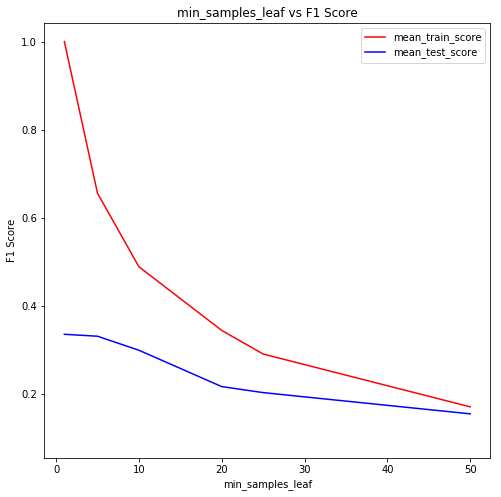

In [142]:
#Decisison Tree Hyperparameter Impact
dt_parameters = {'min_samples_leaf':[1,5, 10, 20, 25,50]}
dt = DecisionTreeClassifier()
clf = GridSearchCV(dt, dt_parameters,cv=5, scoring = 'f1')
clf.fit(x_train, y_train)
dt_grid_search_results = pd.DataFrame(clf.cv_results_).sort_values(by='rank_test_score')
plot_model_complexity(dt_grid_search_results, 'min_samples_leaf')

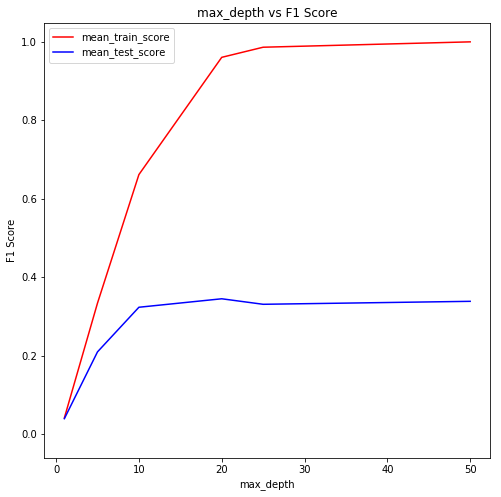

In [143]:
dt_parameters = {'max_depth':[1, 5, 10, 20, 25,50]}
dt = DecisionTreeClassifier()
dt_clf = GridSearchCV(dt, dt_parameters,cv=5, scoring = 'f1')
dt_clf.fit(x_train, y_train)
dt_grid_search_results = pd.DataFrame(dt_clf.cv_results_).sort_values(by='rank_test_score')
plot_model_complexity(dt_grid_search_results, 'max_depth')

In [177]:
#Decisison Tree Grid Search
dt_parameters = {'max_depth':[5,10,15,25,50], 'min_samples_leaf':[1, 5, 10, 20, 25, 50]}
dt = DecisionTreeClassifier()
dt_clf = GridSearchCV(dt, dt_parameters,cv=cv, scoring = 'f1')
dt_clf.fit(x_train, y_train)

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=0, shuffle=True),
       error_score='raise',
       estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best'),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'max_depth': [5, 10, 15, 25, 50], 'min_samples_leaf': [1, 5, 10, 20, 25, 50]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='f1', verbose=0)

In [178]:
dt_grid_search_results = pd.DataFrame(dt_clf.cv_results_).sort_values(by='rank_test_score')

In [180]:
# View the best parameters for the model found using grid search
print('Best score for data1:', dt_clf.best_score_) 
print('Best Max Depth:',dt_clf.best_estimator_.max_depth) 
print('Best Shrinkage:',dt_clf.best_estimator_.min_samples_leaf)

Best score for data1: 0.3620520420479391
Best Max Depth: 50
Best Shrinkage: 1


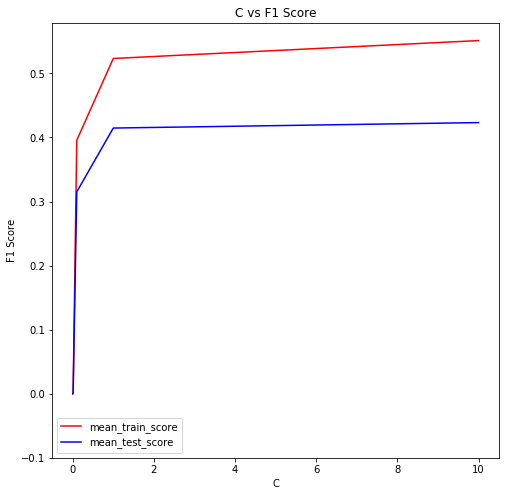

In [201]:
#SVM C Search
parameters = {'C':[0.001,0.01,0.1,1,10]}
svm = SVC(verbose =0, kernel='linear')
svm_clf = GridSearchCV(svm, parameters, cv= cv, scoring = 'f1')
svm_clf.fit(x_train, y_train)
svm_grid_search_results = pd.DataFrame(svm_clf.cv_results_).sort_values(by='rank_test_score')
plot_model_complexity(svm_grid_search_results, 'C')

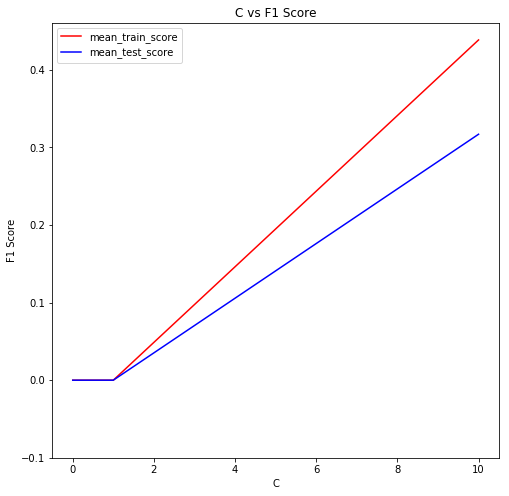

In [202]:
#SVM C Search
parameters = {'C':[0.001,0.01,0.1,1,10]}
svm = SVC(verbose =0, kernel='rbf')
svm_clf = GridSearchCV(svm, parameters, cv= cv, scoring = 'f1')
svm_clf.fit(x_train, y_train)
svm_grid_search_results = pd.DataFrame(svm_clf.cv_results_).sort_values(by='rank_test_score')
plot_model_complexity(svm_grid_search_results, 'C')

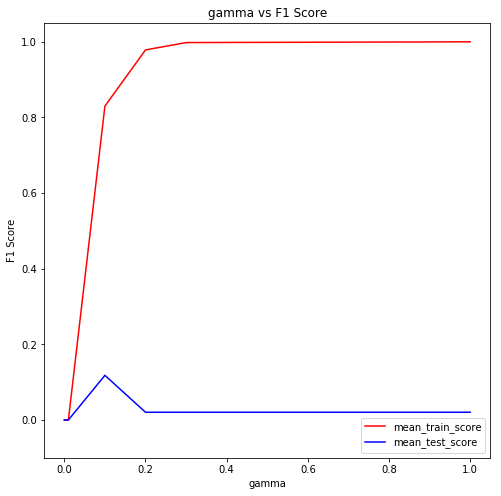

In [199]:
#SVM gamma Search
parameters = {'gamma':[0.0001, 0.001, 0.01, 0.1, 0.2, 0.3, 1]}
svm = SVC(verbose =0, kernel='rbf')
svm_clf = GridSearchCV(svm, parameters, cv= cv, scoring = 'f1')
svm_clf.fit(x_train, y_train)
svm_grid_search_results = pd.DataFrame(svm_clf.cv_results_).sort_values(by='rank_test_score')
plot_model_complexity(svm_grid_search_results, 'gamma')

In [169]:
#SVM Grid Search
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=0)
parameters = {'C':[0.1,1,5,10], 'gamma':[0.01, 0.1, 0.2, 0.3], 'kernel':['rbf','linear']}
svm = SVC(verbose=2)
svm_clf = GridSearchCV(svm, parameters, cv= cv, scoring = 'f1')
svm_clf.fit(x_train, y_train)

svm_grid_search_results = pd.DataFrame(svm_clf.cv_results_).sort_values(by='rank_test_score')
# View the best parameters for the model found using grid search
print('Best score for data1:', svm_clf.best_score_) 
print('Best Estimators:',svm_clf.best_estimator_.gamma) 
print('Best C:',svm_clf.best_estimator_.C)
print('Best Kernel:',svm_clf.best_estimator_.kernel)

[LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM]

In [168]:
#GBM Grid Search
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=0)
parameters = {'learning_rate':[0.001, 0.01, 0.1, 0.3, 0.5], 'n_estimators':[10,100,250,500,1000], 'max_depth':[1,3,5,7,10]}
gbm = GradientBoostingClassifier(verbose =1)
gbm_clf = GridSearchCV(gbm, parameters, cv= cv, scoring = 'f1')
gbm_clf.fit(x_train, y_train)

      Iter       Train Loss   Remaining Time 
         1           0.8958            0.04s
         2           0.8958            0.04s
         3           0.8957            0.04s
         4           0.8956            0.03s
         5           0.8955            0.03s
         6           0.8954            0.04s
         7           0.8954            0.03s
         8           0.8953            0.02s
         9           0.8952            0.01s
        10           0.8951            0.00s
      Iter       Train Loss   Remaining Time 
         1           0.8959            0.04s
         2           0.8958            0.04s
         3           0.8957            0.03s
         4           0.8956            0.03s
         5           0.8956            0.03s
         6           0.8955            0.02s
         7           0.8954            0.01s
         8           0.8954            0.01s
         9           0.8953            0.00s
        10           0.8952            0.00s
      It

        30           0.8939            0.66s
        40           0.8933            0.65s
        50           0.8926            0.60s
        60           0.8920            0.56s
        70           0.8914            0.51s
        80           0.8908            0.47s
        90           0.8902            0.44s
       100           0.8896            0.40s
       200           0.8844            0.13s
      Iter       Train Loss   Remaining Time 
         1           0.8957            1.14s
         2           0.8956            0.91s
         3           0.8955            0.85s
         4           0.8955            0.81s
         5           0.8954            0.77s
         6           0.8954            0.76s
         7           0.8953            0.75s
         8           0.8952            0.74s
         9           0.8952            0.73s
        10           0.8951            0.73s
        20           0.8945            0.62s
        30           0.8939            0.64s
        4

        70           0.8921            1.07s
        80           0.8916            1.06s
        90           0.8910            1.07s
       100           0.8905            1.03s
       200           0.8857            0.76s
       300           0.8813            0.51s
       400           0.8772            0.25s
       500           0.8735            0.00s
      Iter       Train Loss   Remaining Time 
         1           0.8958            2.71s
         2           0.8958            2.68s
         3           0.8957            2.69s
         4           0.8956            2.69s
         5           0.8955            2.62s
         6           0.8954            2.59s
         7           0.8954            2.66s
         8           0.8953            2.71s
         9           0.8952            2.67s
        10           0.8951            2.64s
        20           0.8944            2.41s
        30           0.8936            2.32s
        40           0.8929            2.27s
        5

         4           0.8960            0.06s
         5           0.8958            0.05s
         6           0.8956            0.04s
         7           0.8954            0.03s
         8           0.8952            0.02s
         9           0.8950            0.01s
        10           0.8948            0.00s
      Iter       Train Loss   Remaining Time 
         1           0.8965            0.08s
         2           0.8963            0.07s
         3           0.8961            0.06s
         4           0.8959            0.05s
         5           0.8957            0.04s
         6           0.8956            0.04s
         7           0.8954            0.03s
         8           0.8952            0.02s
         9           0.8950            0.01s
        10           0.8948            0.00s
      Iter       Train Loss   Remaining Time 
         1           0.8957            1.39s
         2           0.8955            1.45s
         3           0.8953            1.43s
        

        30           0.8913            2.07s
        40           0.8896            1.93s
        50           0.8880            1.80s
        60           0.8865            1.74s
        70           0.8849            1.64s
        80           0.8835            1.56s
        90           0.8820            1.48s
       100           0.8806            1.38s
       200           0.8676            0.46s
      Iter       Train Loss   Remaining Time 
         1           0.8965            2.28s
         2           0.8963            2.25s
         3           0.8961            2.39s
         4           0.8959            2.34s
         5           0.8957            2.30s
         6           0.8956            2.28s
         7           0.8954            2.27s
         8           0.8952            2.25s
         9           0.8950            2.24s
        10           0.8948            2.22s
        20           0.8930            2.06s
        30           0.8912            2.05s
        4

        20           0.8916           10.29s
        30           0.8895           10.14s
        40           0.8875            9.74s
        50           0.8856            9.75s
        60           0.8838            9.47s
        70           0.8820            9.32s
        80           0.8803            9.37s
        90           0.8786            9.16s
       100           0.8770            8.99s
       200           0.8630            7.82s
       300           0.8506            6.81s
       400           0.8397            5.81s
       500           0.8298            4.86s
       600           0.8205            3.91s
       700           0.8122            2.95s
       800           0.8045            1.97s
       900           0.7974            0.99s
      1000           0.7908            0.00s
      Iter       Train Loss   Remaining Time 
         1           0.8955            8.29s
         2           0.8954            8.28s
         3           0.8952            8.35s
         

         9           0.8924            2.05s
        10           0.8920            2.10s
        20           0.8883            1.92s
        30           0.8847            1.91s
        40           0.8813            1.65s
        50           0.8780            1.32s
        60           0.8749            1.05s
        70           0.8718            0.79s
        80           0.8689            0.54s
        90           0.8661            0.28s
       100           0.8633            0.00s
      Iter       Train Loss   Remaining Time 
         1           0.8954            2.11s
         2           0.8950            2.02s
         3           0.8947            2.02s
         4           0.8943            2.00s
         5           0.8939            1.97s
         6           0.8936            1.94s
         7           0.8932            1.92s
         8           0.8929            1.93s
         9           0.8925            2.02s
        10           0.8922            2.05s
        2

         6           0.8938           19.41s
         7           0.8934           19.20s
         8           0.8931           19.36s
         9           0.8928           19.24s
        10           0.8924           19.00s
        20           0.8890           17.64s
        30           0.8858           17.52s
        40           0.8826           16.63s
        50           0.8794           15.10s
        60           0.8761           14.82s
        70           0.8730           14.12s
        80           0.8699           13.32s
        90           0.8670           12.74s
       100           0.8641           12.57s
       200           0.8388            9.33s
       300           0.8180            6.02s
       400           0.8005            2.88s
       500           0.7846            0.00s
      Iter       Train Loss   Remaining Time 
         1           0.8955           14.39s
         2           0.8951           12.87s
         3           0.8947           12.43s
         

        20           0.8888           20.24s
        30           0.8855           20.08s
        40           0.8824           19.86s
        50           0.8794           19.77s
        60           0.8764           19.64s
        70           0.8736           19.40s
        80           0.8709           19.22s
        90           0.8682           18.96s
       100           0.8657           18.71s
       200           0.8420           16.57s
       300           0.8213           14.84s
       400           0.8030           12.91s
       500           0.7853           10.98s
       600           0.7679            8.98s
       700           0.7531            6.79s
       800           0.7399            4.54s
       900           0.7273            2.28s
      1000           0.7152            0.00s
      Iter       Train Loss   Remaining Time 
         1           0.8963           19.14s
         2           0.8960           19.14s
         3           0.8956           19.13s
         

        20           0.8849            2.85s
        30           0.8799            2.49s
        40           0.8750            2.16s
        50           0.8702            1.81s
        60           0.8656            1.45s
        70           0.8612            1.10s
        80           0.8569            0.73s
        90           0.8527            0.38s
       100           0.8487            0.00s
      Iter       Train Loss   Remaining Time 
         1           0.8961            3.72s
         2           0.8955            3.77s
         3           0.8949            3.69s
         4           0.8943            3.64s
         5           0.8937            3.64s
         6           0.8931            3.59s
         7           0.8925            3.53s
         8           0.8919            3.53s
         9           0.8913            3.47s
        10           0.8907            3.48s
        20           0.8850            3.09s
        30           0.8795            2.68s
        4

         3           0.8941           22.23s
         4           0.8935           23.71s
         5           0.8929           23.44s
         6           0.8923           23.01s
         7           0.8917           22.69s
         8           0.8911           23.04s
         9           0.8905           23.74s
        10           0.8899           24.31s
        20           0.8842           22.95s
        30           0.8788           25.31s
        40           0.8735           25.80s
        50           0.8685           25.22s
        60           0.8636           23.80s
        70           0.8589           23.94s
        80           0.8544           23.33s
        90           0.8501           23.46s
       100           0.8459           23.04s
       200           0.8086           15.80s
       300           0.7790           10.11s
       400           0.7541            4.95s
       500           0.7324            0.00s
      Iter       Train Loss   Remaining Time 
         

         3           0.8949           46.72s
         4           0.8943           46.41s
         5           0.8937           45.37s
         6           0.8931           44.93s
         7           0.8925           45.06s
         8           0.8919           45.89s
         9           0.8913           46.34s
        10           0.8907           45.74s
        20           0.8850           43.28s
        30           0.8795           42.11s
        40           0.8743           41.47s
        50           0.8693           40.97s
        60           0.8645           40.61s
        70           0.8599           40.11s
        80           0.8554           39.46s
        90           0.8511           38.93s
       100           0.8470           38.58s
       200           0.8117           33.74s
       300           0.7836           29.51s
       400           0.7581           25.34s
       500           0.7343           21.24s
       600           0.7096           17.53s
       700

        30           0.8706            5.38s
        40           0.8624            4.62s
        50           0.8546            3.85s
        60           0.8471            3.10s
        70           0.8399            2.32s
        80           0.8331            1.55s
        90           0.8265            0.78s
       100           0.8201            0.00s
      Iter       Train Loss   Remaining Time 
         1           0.8958            8.06s
         2           0.8949            8.07s
         3           0.8939            8.18s
         4           0.8930            8.00s
         5           0.8921            7.88s
         6           0.8912            7.87s
         7           0.8903            7.78s
         8           0.8894            7.67s
         9           0.8885            7.65s
        10           0.8877            7.59s
        20           0.8790            6.68s
        30           0.8707            5.76s
        40           0.8628            4.92s
        5

         2           0.8939           40.81s
         3           0.8930           40.11s
         4           0.8920           38.78s
         5           0.8911           38.37s
         6           0.8902           38.56s
         7           0.8893           38.12s
         8           0.8884           38.39s
         9           0.8875           38.11s
        10           0.8867           37.88s
        20           0.8780           36.84s
        30           0.8698           35.62s
        40           0.8619           34.63s
        50           0.8544           33.68s
        60           0.8470           33.21s
        70           0.8398           32.76s
        80           0.8329           32.33s
        90           0.8263           31.71s
       100           0.8199           31.15s
       200           0.7661           26.48s
       300           0.7238           19.33s
       400           0.6817           10.40s
       500           0.6465            0.00s
      Iter

       700           0.5882           22.79s
       800           0.5596           15.41s
       900           0.5346            7.83s
      1000           0.5114            0.00s
      Iter       Train Loss   Remaining Time 
         1           0.8958            1.13m
         2           0.8949            1.14m
         3           0.8940            1.14m
         4           0.8930            1.14m
         5           0.8921            1.15m
         6           0.8913            1.15m
         7           0.8904            1.15m
         8           0.8895            1.15m
         9           0.8886            1.15m
        10           0.8877            1.15m
        20           0.8791            1.14m
        30           0.8708            1.12m
        40           0.8630            1.12m
        50           0.8555            1.10m
        60           0.8482            1.09m
        70           0.8413            1.08m
        80           0.8345            1.06m
        9

        50           0.8733            0.12s
        60           0.8698            0.09s
        70           0.8664            0.07s
        80           0.8631            0.05s
        90           0.8600            0.02s
       100           0.8571            0.00s
      Iter       Train Loss   Remaining Time 
         1           0.8951            0.63s
         2           0.8943            0.62s
         3           0.8936            0.62s
         4           0.8928            0.61s
         5           0.8921            0.61s
         6           0.8915            0.60s
         7           0.8908            0.60s
         8           0.8902            0.60s
         9           0.8895            0.59s
        10           0.8889            0.59s
        20           0.8839            0.53s
        30           0.8793            0.51s
        40           0.8752            0.49s
        50           0.8712            0.46s
        60           0.8674            0.43s
        7

       500           0.7866            0.00s
      Iter       Train Loss   Remaining Time 
         1           0.8960            1.43s
         2           0.8954            1.43s
         3           0.8948            1.38s
         4           0.8942            1.33s
         5           0.8936            1.31s
         6           0.8930            1.29s
         7           0.8924            1.27s
         8           0.8918            1.26s
         9           0.8913            1.25s
        10           0.8907            1.25s
        20           0.8856            1.16s
        30           0.8810            1.12s
        40           0.8769            1.08s
        50           0.8729            1.05s
        60           0.8692            1.02s
        70           0.8656            0.99s
        80           0.8622            0.97s
        90           0.8590            0.95s
       100           0.8559            0.92s
       200           0.8300            0.69s
       30

        80           0.8631            2.10s
        90           0.8600            2.08s
       100           0.8571            2.05s
       200           0.8326            1.81s
       300           0.8141            1.59s
       400           0.7993            1.36s
       500           0.7871            1.13s
       600           0.7770            0.90s
       700           0.7683            0.68s
       800           0.7607            0.45s
       900           0.7538            0.23s
      1000           0.7475            0.00s
      Iter       Train Loss   Remaining Time 
         1           0.8940            0.08s
         2           0.8921            0.07s
         3           0.8902            0.06s
         4           0.8885            0.05s
         5           0.8866            0.04s
         6           0.8850            0.03s
         7           0.8832            0.03s
         8           0.8817            0.02s
         9           0.8800            0.01s
        1

        60           0.8233            1.71s
        70           0.8147            1.63s
        80           0.8071            1.54s
        90           0.7995            1.46s
       100           0.7926            1.37s
       200           0.7391            0.46s
      Iter       Train Loss   Remaining Time 
         1           0.8937            2.31s
         2           0.8915            2.27s
         3           0.8894            2.25s
         4           0.8874            2.24s
         5           0.8855            2.22s
         6           0.8836            2.21s
         7           0.8818            2.20s
         8           0.8801            2.19s
         9           0.8784            2.18s
        10           0.8768            2.17s
        20           0.8627            2.04s
        30           0.8502            1.96s
        40           0.8392            1.87s
        50           0.8293            1.78s
        60           0.8201            1.72s
        7

       200           0.7346            2.72s
       300           0.6938            1.85s
       400           0.6627            0.92s
       500           0.6355            0.00s
      Iter       Train Loss   Remaining Time 
         1           0.8948            4.20s
         2           0.8929            4.19s
         3           0.8911            4.19s
         4           0.8894            4.18s
         5           0.8877            4.17s
         6           0.8861            4.16s
         7           0.8845            4.16s
         8           0.8830            4.15s
         9           0.8815            4.15s
        10           0.8800            4.14s
        20           0.8674            4.06s
        30           0.8567            3.96s
        40           0.8461            3.98s
        50           0.8354            4.03s
        60           0.8260            4.02s
        70           0.8170            3.99s
        80           0.8086            3.94s
        9

         7           0.8715            0.07s
         8           0.8686            0.04s
         9           0.8657            0.02s
        10           0.8629            0.00s
      Iter       Train Loss   Remaining Time 
         1           0.8921            0.18s
         2           0.8887            0.15s
         3           0.8854            0.14s
         4           0.8822            0.12s
         5           0.8792            0.10s
         6           0.8762            0.08s
         7           0.8734            0.06s
         8           0.8706            0.04s
         9           0.8679            0.02s
        10           0.8654            0.00s
      Iter       Train Loss   Remaining Time 
         1           0.8930            0.17s
         2           0.8895            0.15s
         3           0.8861            0.14s
         4           0.8829            0.12s
         5           0.8797            0.10s
         6           0.8767            0.08s
        

        20           0.8412            4.50s
        30           0.8207            4.42s
        40           0.8020            4.31s
        50           0.7849            4.17s
        60           0.7668            4.08s
        70           0.7521            3.90s
        80           0.7382            3.73s
        90           0.7253            3.53s
       100           0.7133            3.32s
       200           0.6217            1.10s
      Iter       Train Loss   Remaining Time 
         1           0.8930            4.71s
         2           0.8895            4.69s
         3           0.8861            4.66s
         4           0.8829            4.64s
         5           0.8797            4.63s
         6           0.8767            4.61s
         7           0.8737            4.58s
         8           0.8709            4.56s
         9           0.8682            4.54s
        10           0.8656            4.54s
        20           0.8427            4.34s
        3

        20           0.8383           21.22s
        30           0.8176           21.08s
        40           0.8000           21.01s
        50           0.7841           21.03s
        60           0.7682           21.05s
        70           0.7541           21.05s
        80           0.7410           21.01s
        90           0.7291           20.93s
       100           0.7176           20.82s
       200           0.6269           18.30s
       300           0.5624           16.05s
       400           0.5102           13.60s
       500           0.4681           11.10s
       600           0.4321            8.67s
       700           0.4024            6.40s
       800           0.3776            4.20s
       900           0.3556            2.07s
      1000           0.3358            0.00s
      Iter       Train Loss   Remaining Time 
         1           0.8919           20.78s
         2           0.8882           20.88s
         3           0.8845           20.94s
         

         6           0.8673            0.15s
         7           0.8631            0.11s
         8           0.8590            0.07s
         9           0.8552            0.04s
        10           0.8513            0.00s
      Iter       Train Loss   Remaining Time 
         1           0.8907            3.30s
         2           0.8857            3.31s
         3           0.8810            3.27s
         4           0.8764            3.23s
         5           0.8712            3.33s
         6           0.8661            3.39s
         7           0.8616            3.36s
         8           0.8564            3.43s
         9           0.8521            3.44s
        10           0.8473            3.47s
        20           0.8080            3.18s
        30           0.7766            2.82s
        40           0.7505            2.42s
        50           0.7278            2.03s
        60           0.7062            1.63s
        70           0.6864            1.23s
        8

        50           0.7324            7.08s
        60           0.7085            6.89s
        70           0.6867            6.64s
        80           0.6667            6.37s
        90           0.6474            6.09s
       100           0.6298            5.77s
       200           0.4942            2.02s
      Iter       Train Loss   Remaining Time 
         1           0.8911            8.99s
         2           0.8859            9.04s
         3           0.8809            9.05s
         4           0.8761            9.01s
         5           0.8716            8.99s
         6           0.8673            8.99s
         7           0.8631            8.96s
         8           0.8590            8.86s
         9           0.8552            8.83s
        10           0.8513            8.76s
        20           0.8156            8.51s
        30           0.7862            8.24s
        40           0.7609            7.90s
        50           0.7368            7.67s
        6

        10           0.8452           37.27s
        20           0.8078           36.94s
        30           0.7782           36.72s
        40           0.7531           36.47s
        50           0.7315           36.06s
        60           0.7089           35.94s
        70           0.6853           36.33s
        80           0.6644           36.52s
        90           0.6468           36.45s
       100           0.6298           36.29s
       200           0.5061           32.60s
       300           0.4214           28.26s
       400           0.3592           23.83s
       500           0.3109           19.57s
       600           0.2719           15.47s
       700           0.2389           11.49s
       800           0.2107            7.62s
       900           0.1879            3.77s
      1000           0.1669            0.00s
      Iter       Train Loss   Remaining Time 
         1           0.8901           34.38s
         2           0.8848           33.97s
         

         3           0.8668            6.86s
         4           0.8580            6.82s
         5           0.8498            6.72s
         6           0.8414            6.68s
         7           0.8334            6.61s
         8           0.8260            6.54s
         9           0.8183            6.50s
        10           0.8111            6.44s
        20           0.7499            5.81s
        30           0.7025            5.10s
        40           0.6625            4.41s
        50           0.6285            3.69s
        60           0.5977            2.97s
        70           0.5693            2.25s
        80           0.5440            1.51s
        90           0.5202            0.76s
       100           0.4955            0.00s
      Iter       Train Loss   Remaining Time 
         1           0.8864            6.07s
         2           0.8776            6.01s
         3           0.8692            5.98s
         4           0.8613            5.96s
         

      Iter       Train Loss   Remaining Time 
         1           0.8868           32.64s
         2           0.8783           32.37s
         3           0.8701           32.28s
         4           0.8624           32.35s
         5           0.8550           32.23s
         6           0.8480           32.13s
         7           0.8397           33.27s
         8           0.8331           33.30s
         9           0.8255           34.10s
        10           0.8182           34.75s
        20           0.7579           36.67s
        30           0.7074           37.06s
        40           0.6643           36.78s
        50           0.6293           36.02s
        60           0.5980           35.13s
        70           0.5696           34.39s
        80           0.5433           33.70s
        90           0.5199           32.86s
       100           0.4982           32.08s
       200           0.3316           24.90s
       300           0.2351           16.43s
       40

         6           0.8463            1.05m
         7           0.8392            1.05m
         8           0.8324            1.05m
         9           0.8256            1.06m
        10           0.8195            1.06m
        20           0.7651            1.07m
        30           0.7230            1.06m
        40           0.6802            1.10m
        50           0.6448            1.12m
        60           0.6113            1.13m
        70           0.5772            1.15m
        80           0.5484            1.16m
        90           0.5206            1.16m
       100           0.4952            1.16m
       200           0.3225            1.08m
       300           0.2283           56.26s
       400           0.1683           47.78s
       500           0.1274           39.29s
       600           0.0980           31.12s
       700           0.0766           23.15s
       800           0.0603           15.32s
       900           0.0480            7.61s
      1000

         9           0.8563            0.24s
        10           0.8529            0.24s
        20           0.8269            0.20s
        30           0.8087            0.17s
        40           0.7945            0.14s
        50           0.7833            0.12s
        60           0.7736            0.09s
        70           0.7654            0.07s
        80           0.7584            0.05s
        90           0.7524            0.02s
       100           0.7468            0.00s
      Iter       Train Loss   Remaining Time 
         1           0.8904            0.26s
         2           0.8846            0.25s
         3           0.8797            0.25s
         4           0.8755            0.25s
         5           0.8715            0.24s
         6           0.8675            0.24s
         7           0.8637            0.24s
         8           0.8598            0.23s
         9           0.8565            0.23s
        10           0.8538            0.23s
        2

        80           0.7598            0.97s
        90           0.7543            0.95s
       100           0.7490            0.92s
       200           0.7120            0.68s
       300           0.6900            0.46s
       400           0.6742            0.23s
       500           0.6626            0.00s
      Iter       Train Loss   Remaining Time 
         1           0.8897            1.31s
         2           0.8841            1.32s
         3           0.8793            1.33s
         4           0.8748            1.33s
         5           0.8710            1.33s
         6           0.8673            1.31s
         7           0.8634            1.33s
         8           0.8596            1.35s
         9           0.8563            1.33s
        10           0.8529            1.32s
        20           0.8269            1.18s
        30           0.8087            1.13s
        40           0.7945            1.10s
        50           0.7833            1.06s
        6

        80           0.7550            2.17s
        90           0.7485            2.14s
       100           0.7426            2.10s
       200           0.7020            1.83s
       300           0.6774            1.59s
       400           0.6594            1.36s
       500           0.6469            1.13s
       600           0.6369            0.91s
       700           0.6288            0.68s
       800           0.6222            0.45s
       900           0.6167            0.23s
      1000           0.6120            0.00s
      Iter       Train Loss   Remaining Time 
         1           0.8898            2.80s
         2           0.8850            2.62s
         3           0.8800            2.58s
         4           0.8754            2.55s
         5           0.8721            2.55s
         6           0.8685            2.54s
         7           0.8647            2.55s
         8           0.8610            2.54s
         9           0.8579            2.53s
        1

        30           0.6891            0.66s
        40           0.6573            0.55s
        50           0.6310            0.46s
        60           0.6063            0.37s
        70           0.5864            0.27s
        80           0.5665            0.18s
        90           0.5490            0.09s
       100           0.5334            0.00s
      Iter       Train Loss   Remaining Time 
         1           0.8772            2.09s
         2           0.8624            2.19s
         3           0.8515            2.16s
         4           0.8391            2.26s
         5           0.8287            2.22s
         6           0.8196            2.27s
         7           0.8118            2.23s
         8           0.8031            2.23s
         9           0.7947            2.26s
        10           0.7885            2.23s
        20           0.7320            2.12s
        30           0.6939            2.05s
        40           0.6609            1.98s
        5

       300           0.3469            1.75s
       400           0.2949            0.87s
       500           0.2540            0.00s
      Iter       Train Loss   Remaining Time 
         1           0.8788            4.08s
         2           0.8660            4.05s
         3           0.8520            4.23s
         4           0.8394            4.26s
         5           0.8304            4.24s
         6           0.8207            4.27s
         7           0.8110            4.29s
         8           0.8019            4.29s
         9           0.7937            4.33s
        10           0.7871            4.30s
        20           0.7273            4.38s
        30           0.6858            4.36s
        40           0.6533            4.32s
        50           0.6249            4.24s
        60           0.6023            4.10s
        70           0.5795            3.98s
        80           0.5594            3.85s
        90           0.5406            3.72s
       10

        80           0.5665            8.35s
        90           0.5490            8.17s
       100           0.5334            8.06s
       200           0.4222            7.02s
       300           0.3508            6.12s
       400           0.2958            5.26s
       500           0.2532            4.37s
       600           0.2197            3.50s
       700           0.1911            2.62s
       800           0.1685            1.75s
       900           0.1494            0.87s
      1000           0.1326            0.00s
      Iter       Train Loss   Remaining Time 
         1           0.8619            0.17s
         2           0.8318            0.17s
         3           0.8117            0.15s
         4           0.7934            0.13s
         5           0.7779            0.11s
         6           0.7643            0.08s
         7           0.7476            0.06s
         8           0.7334            0.04s
         9           0.7203            0.02s
        1

        70           0.3829            3.85s
        80           0.3593            3.58s
        90           0.3337            3.36s
       100           0.3149            3.11s
       200           0.1778            1.00s
      Iter       Train Loss   Remaining Time 
         1           0.8583            5.23s
         2           0.8331            5.15s
         3           0.8142            5.15s
         4           0.7917            5.27s
         5           0.7768            5.21s
         6           0.7590            5.34s
         7           0.7473            5.31s
         8           0.7363            5.24s
         9           0.7234            5.29s
        10           0.7109            5.35s
        20           0.6206            5.10s
        30           0.5566            4.80s
        40           0.5025            4.51s
        50           0.4615            4.22s
        60           0.4253            4.00s
        70           0.3938            3.75s
        8

       300           0.1007            4.10s
       400           0.0637            2.05s
       500           0.0418            0.00s
      Iter       Train Loss   Remaining Time 
         1           0.8626           10.01s
         2           0.8392           10.27s
         3           0.8204           10.16s
         4           0.8029           10.20s
         5           0.7819           10.58s
         6           0.7673           10.57s
         7           0.7493           10.73s
         8           0.7340           10.97s
         9           0.7224           10.78s
        10           0.7096           10.86s
        20           0.6134           10.67s
        30           0.5519           10.18s
        40           0.4949           10.02s
        50           0.4530            9.58s
        60           0.4153            9.26s
        70           0.3816            9.03s
        80           0.3565            8.79s
        90           0.3341            8.48s
       10

         4           0.7418            0.23s
         5           0.7200            0.19s
         6           0.6973            0.15s
         7           0.6776            0.12s
         8           0.6543            0.08s
         9           0.6356            0.04s
        10           0.6183            0.00s
      Iter       Train Loss   Remaining Time 
         1           0.8418            0.30s
         2           0.8057            0.27s
         3           0.7645            0.27s
         4           0.7382            0.23s
         5           0.7113            0.20s
         6           0.6882            0.16s
         7           0.6648            0.12s
         8           0.6425            0.08s
         9           0.6237            0.04s
        10           0.6104            0.00s
      Iter       Train Loss   Remaining Time 
         1           0.8388            0.31s
         2           0.8022            0.28s
         3           0.7743            0.24s
        

      Iter       Train Loss   Remaining Time 
         1           0.8418            8.28s
         2           0.8058            8.52s
         3           0.7645            9.47s
         4           0.7382            9.42s
         5           0.7109            9.57s
         6           0.6897            9.76s
         7           0.6659            9.94s
         8           0.6465           10.10s
         9           0.6251           10.14s
        10           0.6088           10.04s
        20           0.4785            9.46s
        30           0.3860            9.04s
        40           0.3284            8.39s
        50           0.2803            7.91s
        60           0.2416            7.48s
        70           0.2088            7.05s
        80           0.1834            6.59s
        90           0.1613            6.17s
       100           0.1447            5.73s
       200           0.0509            1.84s
      Iter       Train Loss   Remaining Time 
        

       500           0.0037            0.00s
      Iter       Train Loss   Remaining Time 
         1           0.8464           33.35s
         2           0.8006           38.81s
         3           0.7688           40.71s
         4           0.7402           40.00s
         5           0.7187           40.02s
         6           0.6947           40.87s
         7           0.6759           40.54s
         8           0.6521           41.22s
         9           0.6368           41.42s
        10           0.6176           41.84s
        20           0.4909           40.25s
        30           0.3986           39.89s
        40           0.3254           39.59s
        50           0.2789           38.47s
        60           0.2373           37.78s
        70           0.2070           37.20s
        80           0.1831           36.37s
        90           0.1639           35.38s
       100           0.1447           34.84s
       200           0.0520           29.68s
       30

         5           0.6295            0.33s
         6           0.6018            0.27s
         7           0.5732            0.20s
         8           0.5481            0.14s
         9           0.5174            0.07s
        10           0.4982            0.00s
      Iter       Train Loss   Remaining Time 
         1           0.8102            0.61s
         2           0.7518            0.53s
         3           0.6966            0.49s
         4           0.6528            0.43s
         5           0.6174            0.37s
         6           0.5874            0.29s
         7           0.5593            0.22s
         8           0.5274            0.15s
         9           0.5079            0.07s
        10           0.4821            0.00s
      Iter       Train Loss   Remaining Time 
         1           0.8106            6.39s
         2           0.7422            7.24s
         3           0.6969            7.13s
         4           0.6507            7.35s
        

         4           0.6671           15.71s
         5           0.6276           15.94s
         6           0.5987           16.23s
         7           0.5727           16.40s
         8           0.5463           16.49s
         9           0.5101           17.12s
        10           0.4881           17.11s
        20           0.3186           17.53s
        30           0.2248           16.93s
        40           0.1655           16.21s
        50           0.1270           15.26s
        60           0.0971           14.43s
        70           0.0763           13.57s
        80           0.0603           12.77s
        90           0.0478           11.95s
       100           0.0381           11.14s
       200           0.0048            3.61s
      Iter       Train Loss   Remaining Time 
         1           0.8101           16.84s
         2           0.7518           16.36s
         3           0.6976           17.14s
         4           0.6527           17.64s
         

      Iter       Train Loss   Remaining Time 
         1           0.7973            1.23m
         2           0.7340            1.23m
         3           0.6854            1.23m
         4           0.6461            1.22m
         5           0.6127            1.22m
         6           0.5777            1.24m
         7           0.5524            1.26m
         8           0.5249            1.26m
         9           0.4974            1.28m
        10           0.4791            1.28m
        20           0.3215            1.32m
        30           0.2259            1.30m
        40           0.1650            1.28m
        50           0.1275            1.25m
        60           0.1024            1.21m
        70           0.0798            1.19m
        80           0.0629            1.17m
        90           0.0512            1.15m
       100           0.0417            1.13m
       200           0.0060           56.92s
       300           0.0010           47.54s
       40

        90           0.6829            0.02s
       100           0.6768            0.00s
      Iter       Train Loss   Remaining Time 
         1           0.8784            0.25s
         2           0.8637            0.25s
         3           0.8511            0.24s
         4           0.8397            0.24s
         5           0.8295            0.23s
         6           0.8214            0.23s
         7           0.8142            0.23s
         8           0.8078            0.23s
         9           0.8029            0.22s
        10           0.7980            0.22s
        20           0.7671            0.19s
        30           0.7477            0.16s
        40           0.7328            0.14s
        50           0.7200            0.11s
        60           0.7106            0.09s
        70           0.7030            0.07s
        80           0.6961            0.05s
        90           0.6900            0.02s
       100           0.6841            0.00s
      Ite

       200           0.6285            0.11s
      Iter       Train Loss   Remaining Time 
         1           0.8757            1.26s
         2           0.8627            1.26s
         3           0.8518            1.25s
         4           0.8415            1.24s
         5           0.8321            1.26s
         6           0.8248            1.26s
         7           0.8179            1.26s
         8           0.8113            1.25s
         9           0.8059            1.25s
        10           0.8010            1.24s
        20           0.7681            1.15s
        30           0.7457            1.10s
        40           0.7308            1.08s
        50           0.7185            1.05s
        60           0.7066            1.02s
        70           0.6970            0.99s
        80           0.6893            0.97s
        90           0.6829            0.94s
       100           0.6768            0.92s
       200           0.6370            0.68s
       30

        90           0.6856            2.09s
       100           0.6798            2.06s
       200           0.6448            1.82s
       300           0.6271            1.58s
       400           0.6162            1.36s
       500           0.6088            1.13s
       600           0.6038            0.91s
       700           0.6003            0.68s
       800           0.5974            0.45s
       900           0.5954            0.23s
      1000           0.5938            0.00s
      Iter       Train Loss   Remaining Time 
         1           0.8801            2.57s
         2           0.8662            2.56s
         3           0.8538            2.57s
         4           0.8439            2.56s
         5           0.8351            2.57s
         6           0.8268            2.60s
         7           0.8181            2.58s
         8           0.8102            2.58s
         9           0.8034            2.59s
        10           0.7979            2.57s
        2

       100           0.3197            0.00s
      Iter       Train Loss   Remaining Time 
         1           0.8500            0.85s
         2           0.8191            0.92s
         3           0.7912            0.89s
         4           0.7665            0.88s
         5           0.7500            0.87s
         6           0.7316            0.87s
         7           0.7146            0.88s
         8           0.7030            0.85s
         9           0.6908            0.84s
        10           0.6786            0.87s
        20           0.5885            0.77s
        30           0.5275            0.65s
        40           0.4849            0.55s
        50           0.4427            0.47s
        60           0.4095            0.37s
        70           0.3877            0.27s
        80           0.3612            0.18s
        90           0.3426            0.09s
       100           0.3216            0.00s
      Iter       Train Loss   Remaining Time 
        

        50           0.4639            4.03s
        60           0.4352            3.93s
        70           0.4086            3.86s
        80           0.3831            3.77s
        90           0.3587            3.67s
       100           0.3385            3.60s
       200           0.1989            2.69s
       300           0.1303            1.78s
       400           0.0889            0.88s
       500           0.0609            0.00s
      Iter       Train Loss   Remaining Time 
         1           0.8492            4.30s
         2           0.8160            4.43s
         3           0.7905            4.78s
         4           0.7703            4.74s
         5           0.7522            4.62s
         6           0.7305            4.52s
         7           0.7160            4.49s
         8           0.7019            4.58s
         9           0.6895            4.69s
        10           0.6805            4.66s
        20           0.5991            4.43s
        3

        50           0.4427            8.94s
        60           0.4095            8.71s
        70           0.3877            8.46s
        80           0.3612            8.33s
        90           0.3426            8.19s
       100           0.3216            8.05s
       200           0.1891            7.13s
       300           0.1221            6.21s
       400           0.0824            5.31s
       500           0.0581            4.41s
       600           0.0408            3.54s
       700           0.0294            2.65s
       800           0.0213            1.76s
       900           0.0157            0.88s
      1000           0.0116            0.00s
      Iter       Train Loss   Remaining Time 
         1           0.8491            8.72s
         2           0.8168            9.70s
         3           0.7912           10.06s
         4           0.7655           10.19s
         5           0.7493           10.01s
         6           0.7334            9.75s
         

         9           0.5464            2.00s
        10           0.5273            1.96s
        20           0.3819            1.72s
        30           0.2915            1.51s
        40           0.2289            1.27s
        50           0.1909            1.04s
        60           0.1592            0.83s
        70           0.1328            0.62s
        80           0.1149            0.41s
        90           0.0983            0.20s
       100           0.0870            0.00s
      Iter       Train Loss   Remaining Time 
         1           0.8083            4.75s
         2           0.7415            5.67s
         3           0.6972            5.68s
         4           0.6615            5.51s
         5           0.6352            5.37s
         6           0.6120            5.24s
         7           0.5908            5.18s
         8           0.5646            5.40s
         9           0.5388            5.43s
        10           0.5210            5.38s
        2

        90           0.1015            8.33s
       100           0.0875            8.13s
       200           0.0239            6.05s
       300           0.0071            4.03s
       400           0.0023            2.02s
       500           0.0007            0.00s
      Iter       Train Loss   Remaining Time 
         1           0.8065            9.47s
         2           0.7467           10.16s
         3           0.7043           10.18s
         4           0.6709           10.28s
         5           0.6406           10.31s
         6           0.6183           10.31s
         7           0.5940           10.66s
         8           0.5655           10.99s
         9           0.5452           10.89s
        10           0.5244           10.82s
        20           0.3815           10.80s
        30           0.2945           10.28s
        40           0.2264           10.06s
        50           0.1844            9.62s
        60           0.1505            9.50s
        7

        30           0.2915           20.94s
        40           0.2289           20.40s
        50           0.1909           19.80s
        60           0.1592           19.52s
        70           0.1328           19.12s
        80           0.1149           18.77s
        90           0.0983           18.40s
       100           0.0870           18.05s
       200           0.0242           15.85s
       300           0.0077           13.66s
       400           0.0025           11.64s
       500           0.0008            9.63s
       600           0.0003            7.49s
       700           0.0003            4.83s
       800           0.0003            2.82s
       900           0.0003            1.26s
      1000           0.0003            0.00s
      Iter       Train Loss   Remaining Time 
         1           0.7679            0.30s
         2           0.6736            0.33s
         3           0.6012            0.30s
         4           0.5597            0.25s
         

        10           0.3771            9.84s
        20           0.2101            9.19s
        30           0.1419            8.44s
        40           0.0969            8.04s
        50           0.0688            7.58s
        60           0.0508            7.14s
        70           0.0374            6.77s
        80           0.0274            6.38s
        90           0.0206            5.96s
       100           0.0156            5.55s
       200           0.0012            1.78s
      Iter       Train Loss   Remaining Time 
         1           0.7474            9.29s
         2           0.6639           10.03s
         3           0.6048           10.29s
         4           0.5594           10.15s
         5           0.5180           10.01s
         6           0.4849            9.89s
         7           0.4466            9.93s
         8           0.4186            9.82s
         9           0.3959            9.62s
        10           0.3692            9.48s
        2

        60           0.0464           17.00s
        70           0.0342           16.45s
        80           0.0254           16.07s
        90           0.0191           15.57s
       100           0.0146           15.14s
       200           0.0010           11.07s
       300           0.0003            5.95s
       400           0.0003            2.24s
       500           0.0003            0.00s
      Iter       Train Loss   Remaining Time 
         1           0.7627           18.53s
         2           0.6701           20.61s
         3           0.6166           19.93s
         4           0.5572           20.51s
         5           0.5204           19.93s
         6           0.4807           19.95s
         7           0.4496           19.73s
         8           0.4126           19.55s
         9           0.3823           19.43s
        10           0.3568           19.28s
        20           0.1981           19.07s
        30           0.1291           18.33s
        4

         6           0.3114            0.31s
         7           0.2748            0.23s
         8           0.2428            0.15s
         9           0.2089            0.08s
        10           0.1885            0.00s
      Iter       Train Loss   Remaining Time 
         1           0.6460            0.62s
         2           0.5390            0.56s
         3           0.4591            0.51s
         4           0.3936            0.47s
         5           0.3461            0.40s
         6           0.3228            0.32s
         7           0.2854            0.24s
         8           0.2481            0.16s
         9           0.2232            0.08s
        10           0.1915            0.00s
      Iter       Train Loss   Remaining Time 
         1           0.6711            0.56s
         2           0.5518            0.57s
         3           0.4758            0.52s
         4           0.3968            0.46s
         5           0.3346            0.39s
        

        30           0.0392           16.83s
        40           0.0205           15.87s
        50           0.0109           15.00s
        60           0.0059           14.11s
        70           0.0033           13.24s
        80           0.0018           12.36s
        90           0.0011           11.42s
       100           0.0006           10.51s
       200           0.0003            1.94s
      Iter       Train Loss   Remaining Time 
         1           0.6688           15.29s
         2           0.5487           17.84s
         3           0.4780           18.26s
         4           0.4024           18.87s
         5           0.3444           19.25s
         6           0.2935           18.97s
         7           0.2625           18.77s
         8           0.2313           18.97s
         9           0.1949           19.30s
        10           0.1778           19.18s
        20           0.0734           17.70s
        30           0.0357           16.57s
        4

        50           0.0103           32.84s
        60           0.0057           31.66s
        70           0.0033           30.41s
        80           0.0018           29.41s
        90           0.0010           28.38s
       100           0.0006           27.25s
       200           0.0003           11.34s
       300           0.0003            5.06s
       400           0.0003            1.91s
       500           0.0003            0.00s
      Iter       Train Loss   Remaining Time 
         1           0.6783            1.07m
         2           0.5426            1.22m
         3           0.4580            1.28m
         4           0.4033            1.26m
         5           0.3417            1.30m
         6           0.2982            1.30m
         7           0.2669            1.29m
         8           0.2294            1.31m
         9           0.2022            1.31m
        10           0.1850            1.30m
        20           0.0761            1.24m
        3

         2           0.8555            0.02s
         3           0.8387            0.02s
         4           0.8259            0.02s
         5           0.8134            0.01s
         6           0.8027            0.01s
         7           0.7928            0.01s
         8           0.7835            0.01s
         9           0.7753            0.00s
        10           0.7689            0.00s
      Iter       Train Loss   Remaining Time 
         1           0.8716            0.03s
         2           0.8531            0.02s
         3           0.8388            0.02s
         4           0.8270            0.02s
         5           0.8163            0.01s
         6           0.8062            0.01s
         7           0.7966            0.01s
         8           0.7888            0.01s
         9           0.7814            0.00s
        10           0.7742            0.00s
      Iter       Train Loss   Remaining Time 
         1           0.8681            0.25s
        

       200           0.6182            0.11s
      Iter       Train Loss   Remaining Time 
         1           0.8737            0.63s
         2           0.8555            0.62s
         3           0.8387            0.61s
         4           0.8259            0.61s
         5           0.8134            0.61s
         6           0.8027            0.60s
         7           0.7928            0.60s
         8           0.7835            0.60s
         9           0.7753            0.59s
        10           0.7689            0.59s
        20           0.7262            0.54s
        30           0.7032            0.52s
        40           0.6865            0.49s
        50           0.6712            0.46s
        60           0.6594            0.44s
        70           0.6501            0.41s
        80           0.6432            0.39s
        90           0.6373            0.37s
       100           0.6318            0.34s
       200           0.6007            0.11s
      Ite

       200           0.6061            1.82s
       300           0.5929            1.59s
       400           0.5864            1.36s
       500           0.5827            1.14s
       600           0.5803            0.91s
       700           0.5790            0.68s
       800           0.5778            0.45s
       900           0.5772            0.23s
      1000           0.5767            0.00s
      Iter       Train Loss   Remaining Time 
         1           0.8712            2.50s
         2           0.8521            2.47s
         3           0.8348            2.46s
         4           0.8202            2.45s
         5           0.8074            2.50s
         6           0.7978            2.49s
         7           0.7889            2.48s
         8           0.7804            2.47s
         9           0.7743            2.47s
        10           0.7690            2.46s
        20           0.7370            2.30s
        30           0.7154            2.24s
        4

         3           0.7528            1.02s
         4           0.7267            0.96s
         5           0.7059            0.94s
         6           0.6862            0.91s
         7           0.6709            0.94s
         8           0.6541            0.95s
         9           0.6414            0.96s
        10           0.6275            0.93s
        20           0.5318            0.78s
        30           0.4594            0.65s
        40           0.4026            0.55s
        50           0.3556            0.46s
        60           0.3246            0.36s
        70           0.2915            0.28s
        80           0.2642            0.18s
        90           0.2371            0.09s
       100           0.2172            0.00s
      Iter       Train Loss   Remaining Time 
         1           0.8196            0.90s
         2           0.7741            0.97s
         3           0.7470            0.91s
         4           0.7256            0.89s
         

        30           0.4549            2.00s
        40           0.4086            1.86s
        50           0.3668            1.77s
        60           0.3224            1.70s
        70           0.2923            1.60s
        80           0.2611            1.51s
        90           0.2379            1.41s
       100           0.2158            1.33s
       200           0.0935            0.44s
      Iter       Train Loss   Remaining Time 
         1           0.8288            4.24s
         2           0.7798            5.00s
         3           0.7528            4.80s
         4           0.7267            4.64s
         5           0.7059            4.62s
         6           0.6862            4.55s
         7           0.6709            4.77s
         8           0.6541            4.88s
         9           0.6414            4.96s
        10           0.6275            4.90s
        20           0.5318            4.61s
        30           0.4594            4.37s
        4

       600           0.0109            3.52s
       700           0.0065            2.65s
       800           0.0038            1.76s
       900           0.0023            0.88s
      1000           0.0014            0.00s
      Iter       Train Loss   Remaining Time 
         1           0.8315            8.43s
         2           0.7854            8.97s
         3           0.7553            9.22s
         4           0.7300            9.24s
         5           0.7040            9.47s
         6           0.6858            9.57s
         7           0.6676            9.50s
         8           0.6555            9.40s
         9           0.6429            9.28s
        10           0.6282            9.13s
        20           0.5319            8.77s
        30           0.4563            8.77s
        40           0.4124            8.67s
        50           0.3714            8.49s
        60           0.3287            8.56s
        70           0.2989            8.35s
        8

        60           0.0688            0.82s
        70           0.0540            0.61s
        80           0.0421            0.41s
        90           0.0335            0.20s
       100           0.0271            0.00s
      Iter       Train Loss   Remaining Time 
         1           0.7749            1.83s
         2           0.7066            1.98s
         3           0.6472            2.08s
         4           0.5993            2.03s
         5           0.5656            2.00s
         6           0.5271            1.97s
         7           0.4982            1.94s
         8           0.4657            1.93s
         9           0.4410            1.89s
        10           0.4146            1.90s
        20           0.2437            1.70s
        30           0.1588            1.46s
        40           0.1061            1.24s
        50           0.0804            1.01s
        60           0.0610            0.81s
        70           0.0480            0.60s
        8

        40           0.1082            9.87s
        50           0.0812            9.47s
        60           0.0643            9.20s
        70           0.0503            8.94s
        80           0.0386            8.70s
        90           0.0307            8.42s
       100           0.0246            8.14s
       200           0.0033            5.92s
       300           0.0005            3.89s
       400           0.0003            1.57s
       500           0.0003            0.00s
      Iter       Train Loss   Remaining Time 
         1           0.7646           10.56s
         2           0.6968           10.76s
         3           0.6451           10.73s
         4           0.6079           10.94s
         5           0.5744           11.21s
         6           0.5382           10.89s
         7           0.5094           10.87s
         8           0.4774           10.66s
         9           0.4525           10.44s
        10           0.4210           10.78s
        2

        80           0.0388           18.46s
        90           0.0304           18.29s
       100           0.0246           18.02s
       200           0.0030           15.93s
       300           0.0004           13.81s
       400           0.0003            9.35s
       500           0.0003            6.26s
       600           0.0003            4.19s
       700           0.0003            2.71s
       800           0.0003            1.59s
       900           0.0003            0.71s
      1000           0.0003            0.00s
      Iter       Train Loss   Remaining Time 
         1           0.7742           19.40s
         2           0.6982           21.52s
         3           0.6460           20.98s
         4           0.5972           22.48s
         5           0.5550           24.06s
         6           0.5204           23.48s
         7           0.4892           23.29s
         8           0.4653           23.08s
         9           0.4348           23.47s
        1

        80           0.0038            0.74s
        90           0.0024            0.37s
       100           0.0015            0.00s
      Iter       Train Loss   Remaining Time 
         1           0.6965            3.86s
         2           0.5776            4.12s
         3           0.5088            3.77s
         4           0.4523            3.69s
         5           0.3969            3.66s
         6           0.3524            3.53s
         7           0.3122            3.53s
         8           0.2557            3.63s
         9           0.2315            3.56s
        10           0.2062            3.49s
        20           0.0768            3.10s
        30           0.0416            2.67s
        40           0.0246            2.25s
        50           0.0150            1.85s
        60           0.0093            1.47s
        70           0.0057            1.11s
        80           0.0036            0.73s
        90           0.0023            0.36s
       10

        20           0.0893           18.48s
        30           0.0463           17.79s
        40           0.0283           17.07s
        50           0.0170           16.68s
        60           0.0107           16.27s
        70           0.0070           15.77s
        80           0.0045           15.31s
        90           0.0029           14.86s
       100           0.0019           14.36s
       200           0.0003            7.42s
       300           0.0003            3.32s
       400           0.0003            1.25s
       500           0.0003            0.00s
      Iter       Train Loss   Remaining Time 
         1           0.7089           17.09s
         2           0.5927           17.95s
         3           0.5035           19.19s
         4           0.4548           18.96s
         5           0.4076           18.95s
         6           0.3623           18.72s
         7           0.3247           18.69s
         8           0.2899           18.68s
         

         9           0.2216           39.75s
        10           0.2020           39.18s
        20           0.0815           37.80s
        30           0.0446           37.08s
        40           0.0264           36.48s
        50           0.0164           35.81s
        60           0.0104           34.93s
        70           0.0067           34.39s
        80           0.0043           33.84s
        90           0.0028           33.26s
       100           0.0019           32.68s
       200           0.0003           20.24s
       300           0.0003           11.87s
       400           0.0003            7.68s
       500           0.0003            5.15s
       600           0.0003            3.45s
       700           0.0003            2.23s
       800           0.0003            1.31s
       900           0.0003            0.59s
      1000           0.0003            0.00s
      Iter       Train Loss   Remaining Time 
         1           0.7146           36.24s
         

         3           0.3443            6.64s
         4           0.2493            6.63s
         5           0.1954            6.79s
         6           0.1598            6.71s
         7           0.1323            6.76s
         8           0.1048            6.62s
         9           0.0851            6.52s
        10           0.0687            6.54s
        20           0.0196            5.76s
        30           0.0073            4.93s
        40           0.0026            4.16s
        50           0.0009            3.43s
        60           0.0004            2.63s
        70           0.0003            1.77s
        80           0.0003            1.03s
        90           0.0003            0.46s
       100           0.0003            0.00s
      Iter       Train Loss   Remaining Time 
         1           0.5998           16.13s
         2           0.4320           18.62s
         3           0.3256           18.06s
         4           0.2445           18.45s
         

        30           0.0077           34.25s
        40           0.0028           32.86s
        50           0.0010           31.56s
        60           0.0004           29.88s
        70           0.0003           25.94s
        80           0.0003           22.19s
        90           0.0003           19.27s
       100           0.0003           16.93s
       200           0.0003            6.39s
       300           0.0003            2.86s
       400           0.0003            1.08s
       500           0.0003            0.00s
      Iter       Train Loss   Remaining Time 
         1           0.5905           31.18s
         2           0.4121           35.48s
         3           0.3179           35.20s
         4           0.2390           35.18s
         5           0.1889           35.46s
         6           0.1505           36.10s
         7           0.1288           35.69s
         8           0.1077           36.26s
         9           0.0937           35.87s
        1

         6           0.1495            1.25m
         7           0.1159            1.26m
         8           0.0961            1.26m
         9           0.0827            1.25m
        10           0.0740            1.22m
        20           0.0185            1.23m
        30           0.0066            1.18m
        40           0.0024            1.16m
        50           0.0009            1.12m
        60           0.0004            1.07m
        70           0.0003           55.93s
        80           0.0003           48.45s
        90           0.0003           42.63s
       100           0.0003           37.98s
       200           0.0003           17.00s
       300           0.0003            9.99s
       400           0.0003            6.47s
       500           0.0003            4.34s
       600           0.0003            2.91s
       700           0.0003            1.89s
       800           0.0003            1.11s
       900           0.0003            0.50s
      1000

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=0, shuffle=True),
       error_score='raise',
       estimator=GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=3,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=100,
              presort='auto', random_state=None, subsample=1.0, verbose=1,
              warm_start=False),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'learning_rate': [0.001, 0.01, 0.1, 0.3, 0.5], 'n_estimators': [10, 100, 250, 500, 1000], 'max_depth': [1, 3, 5, 7, 10]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='f1', verbose=0)

In [181]:
gbm_grid_search_results = pd.DataFrame(gbm_clf.cv_results_).sort_values(by='rank_test_score')

In [183]:
# View the best parameters for the model found using grid search
print('Best score for data1:', gbm_clf.best_score_) 
print('Best Estimators:',gbm_clf.best_estimator_.n_estimators) 
print('Best Shrinkage:',gbm_clf.best_estimator_.learning_rate)
print('Best Shrinkage:',gbm_clf.best_estimator_.max_depth)

Best score for data1: 0.4362915201667552
Best Estimators: 250
Best Shrinkage: 0.3
Best Shrinkage: 3


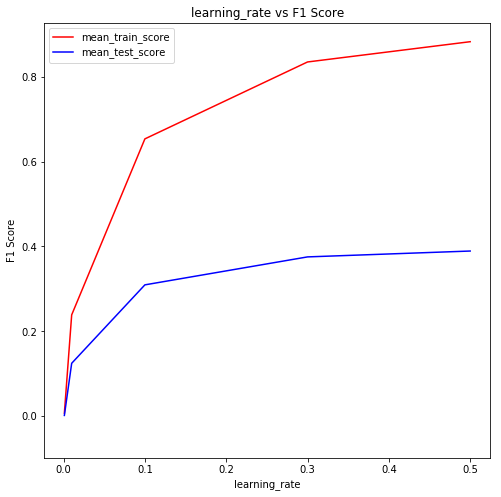

In [160]:
plot_model_complexity(gbm_grid_search_results, 'learning_rate')

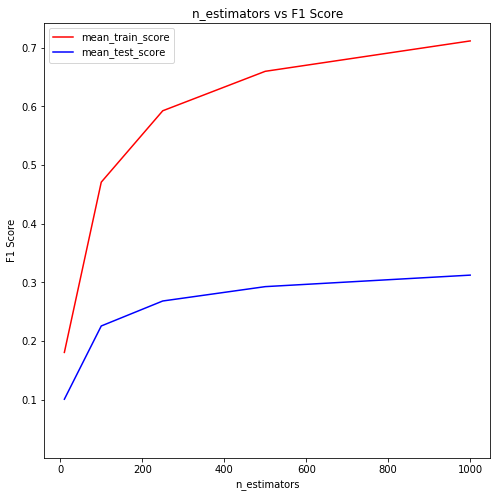

In [161]:
plot_model_complexity(gbm_grid_search_results, 'n_estimators')

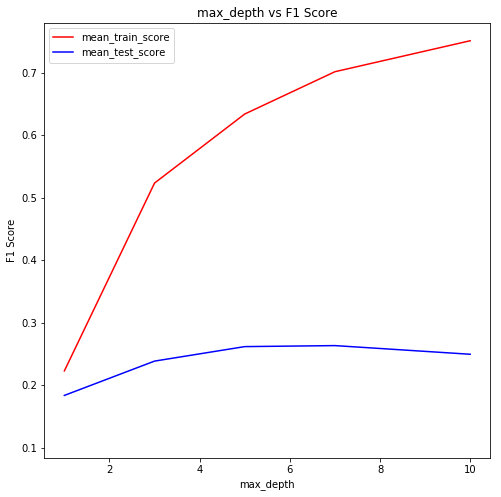

In [184]:
plot_model_complexity(gbm_grid_search_results, 'max_depth')

In [ ]:
#GBM Grid Search
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=0)
parameters = {'n_estimators':[10,100,250,500,1000]}
gbm_v2 = GradientBoostingClassifier(verbose =1)
gbm_epochs = GridSearchCV(gbm_v2, parameters, cv= cv, scoring = 'f1')
gbm_epochs.fit(x_train, y_train)

In [162]:
#KNN Grid Search
parameters = {'n_neighbors':[1,3,5,7,10,25]}
knn = KNeighborsClassifier()
knn_clf = GridSearchCV(knn, parameters, cv= cv, scoring = 'f1')
knn_clf.fit(x_train, y_train)

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=0, shuffle=False),
       error_score='raise',
       estimator=KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=5, p=2,
           weights='uniform'),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'n_neighbors': [1, 3, 5, 7, 10, 25]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='f1', verbose=0)

In [163]:
knn_grid_search_results = pd.DataFrame(knn_clf.cv_results_).sort_values(by='rank_test_score')

In [164]:
# View the best parameters for the model found using grid search
print('Best score for data1:', knn_clf.best_score_) 
print('Best K:',knn_clf.best_estimator_.n_neighbors) 

Best score for data1: 0.2776904523098675
Best K: 1


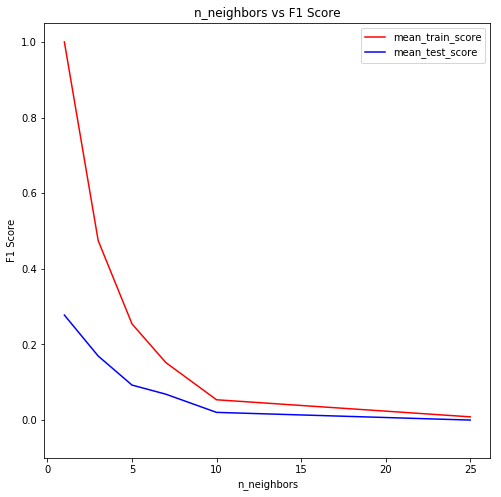

In [165]:
plot_model_complexity(knn_grid_search_results, 'n_neighbors')

In [167]:
#Neural Network Grid Search
cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=0)
parameters = {'alpha':[0.00001, 0.0001, 0.001, 0.01], 'hidden_layer_sizes':[8,16,32,64,128]
              ,'learning_rate_init':[0.00000001, 0.00001, 0.0001, 0.001, 0.01],'activation':['relu','logistic']
            , 'solver':['adam','lbfgs']}
nn = MLPClassifier(verbose =1)
nn_clf = GridSearchCV(nn, parameters, cv= cv, scoring = 'f1')
nn_clf.fit(x_train, y_train)

nn_grid_search_results = pd.DataFrame(nn_clf.cv_results_).sort_values(by='rank_test_score')

print('Best score:', nn_clf.best_score_) 
print('Best Estimators:',nn_clf.best_estimator_.alpha) 
print('Best Learning Rate:',nn_clf.best_estimator_.learning_rate_init)
print('Best HL:',nn_clf.best_estimator_.hidden_layer_sizes)
print('Best Activation:',nn_clf.best_estimator_.activation)
print('Best Optimizer:',nn_clf.best_estimator_.solver)

Iteration 1, loss = 0.55236180
Iteration 2, loss = 0.55236146
Iteration 3, loss = 0.55236115
Iteration 4, loss = 0.55236081
Training loss did not improve more than tol=0.000100 for two consecutive epochs. Stopping.
Iteration 1, loss = 0.94224704
Iteration 2, loss = 0.94224573
Iteration 3, loss = 0.94224443
Iteration 4, loss = 0.94224312
Training loss did not improve more than tol=0.000100 for two consecutive epochs. Stopping.
Iteration 1, loss = 0.78415692
Iteration 2, loss = 0.78415585
Iteration 3, loss = 0.78415479
Iteration 4, loss = 0.78415374
Training loss did not improve more than tol=0.000100 for two consecutive epochs. Stopping.
Iteration 1, loss = 0.50917042
Iteration 2, loss = 0.50875513
Iteration 3, loss = 0.50832967
Iteration 4, loss = 0.50793400
Iteration 5, loss = 0.50752671
Iteration 6, loss = 0.50711957
Iteration 7, loss = 0.50672105
Iteration 8, loss = 0.50632770
Iteration 9, loss = 0.50592974
Iteration 10, loss = 0.50553939
Iteration 11, loss = 0.50515081
Iteration 12

Iteration 36, loss = 0.52323323
Iteration 37, loss = 0.52262246
Iteration 38, loss = 0.52201435
Iteration 39, loss = 0.52141941
Iteration 40, loss = 0.52082137
Iteration 41, loss = 0.52022542
Iteration 42, loss = 0.51963246
Iteration 43, loss = 0.51905032
Iteration 44, loss = 0.51846703
Iteration 45, loss = 0.51789729
Iteration 46, loss = 0.51733045
Iteration 47, loss = 0.51675923
Iteration 48, loss = 0.51618609
Iteration 49, loss = 0.51564450
Iteration 50, loss = 0.51507282
Iteration 51, loss = 0.51452318
Iteration 52, loss = 0.51397179
Iteration 53, loss = 0.51342611
Iteration 54, loss = 0.51287340
Iteration 55, loss = 0.51234221
Iteration 56, loss = 0.51181204
Iteration 57, loss = 0.51127869
Iteration 58, loss = 0.51075460
Iteration 59, loss = 0.51021475
Iteration 60, loss = 0.50969976
Iteration 61, loss = 0.50918132
Iteration 62, loss = 0.50866606
Iteration 63, loss = 0.50816327
Iteration 64, loss = 0.50764479
Iteration 65, loss = 0.50712625
Iteration 66, loss = 0.50661987
Iteratio

Iteration 100, loss = 1.05523416
Iteration 101, loss = 1.05384635
Iteration 102, loss = 1.05248918
Iteration 103, loss = 1.05112112
Iteration 104, loss = 1.04976793
Iteration 105, loss = 1.04844197
Iteration 106, loss = 1.04710075
Iteration 107, loss = 1.04579121
Iteration 108, loss = 1.04446956
Iteration 109, loss = 1.04315258
Iteration 110, loss = 1.04185355
Iteration 111, loss = 1.04054960
Iteration 112, loss = 1.03925268
Iteration 113, loss = 1.03799191
Iteration 114, loss = 1.03669352
Iteration 115, loss = 1.03543141
Iteration 116, loss = 1.03417015
Iteration 117, loss = 1.03292875
Iteration 118, loss = 1.03169460
Iteration 119, loss = 1.03044970
Iteration 120, loss = 1.02922751
Iteration 121, loss = 1.02801743
Iteration 122, loss = 1.02681413
Iteration 123, loss = 1.02560917
Iteration 124, loss = 1.02442905
Iteration 125, loss = 1.02323731
Iteration 126, loss = 1.02205593
Iteration 127, loss = 1.02088650
Iteration 128, loss = 1.01971344
Iteration 129, loss = 1.01854591
Iteration 

Iteration 176, loss = 0.36019419
Iteration 177, loss = 0.35966375
Iteration 178, loss = 0.35912754
Iteration 179, loss = 0.35863208
Iteration 180, loss = 0.35808775
Iteration 181, loss = 0.35759006
Iteration 182, loss = 0.35705250
Iteration 183, loss = 0.35655035
Iteration 184, loss = 0.35603023
Iteration 185, loss = 0.35552196
Iteration 186, loss = 0.35500579
Iteration 187, loss = 0.35452221
Iteration 188, loss = 0.35400585
Iteration 189, loss = 0.35351592
Iteration 190, loss = 0.35301699
Iteration 191, loss = 0.35253558
Iteration 192, loss = 0.35205985
Iteration 193, loss = 0.35155996
Iteration 194, loss = 0.35108974
Iteration 195, loss = 0.35064231
Iteration 196, loss = 0.35016324
Iteration 197, loss = 0.34970176
Iteration 198, loss = 0.34925180
Iteration 199, loss = 0.34880926
Iteration 200, loss = 0.34834361
Iteration 1, loss = 0.74028803
Iteration 2, loss = 0.72740022
Iteration 3, loss = 0.71498967
Iteration 4, loss = 0.70307162
Iteration 5, loss = 0.69170933
Iteration 6, loss = 

Iteration 54, loss = 0.49871078
Iteration 55, loss = 0.49725123
Iteration 56, loss = 0.49580442
Iteration 57, loss = 0.49436926
Iteration 58, loss = 0.49299987
Iteration 59, loss = 0.49155711
Iteration 60, loss = 0.49019950
Iteration 61, loss = 0.48887689
Iteration 62, loss = 0.48753649
Iteration 63, loss = 0.48620355
Iteration 64, loss = 0.48490999
Iteration 65, loss = 0.48364545
Iteration 66, loss = 0.48236304
Iteration 67, loss = 0.48109730
Iteration 68, loss = 0.47985832
Iteration 69, loss = 0.47864589
Iteration 70, loss = 0.47739652
Iteration 71, loss = 0.47620132
Iteration 72, loss = 0.47499415
Iteration 73, loss = 0.47383055
Iteration 74, loss = 0.47265684
Iteration 75, loss = 0.47148707
Iteration 76, loss = 0.47034315
Iteration 77, loss = 0.46918295
Iteration 78, loss = 0.46804029
Iteration 79, loss = 0.46691486
Iteration 80, loss = 0.46578857
Iteration 81, loss = 0.46469120
Iteration 82, loss = 0.46357192
Iteration 83, loss = 0.46247784
Iteration 84, loss = 0.46138496
Iteratio

Iteration 119, loss = 0.20422042
Iteration 120, loss = 0.20319300
Iteration 121, loss = 0.20237908
Iteration 122, loss = 0.20149426
Iteration 123, loss = 0.20050428
Iteration 124, loss = 0.19980495
Iteration 125, loss = 0.19889752
Iteration 126, loss = 0.19810444
Iteration 127, loss = 0.19717680
Iteration 128, loss = 0.19629743
Iteration 129, loss = 0.19531024
Iteration 130, loss = 0.19468651
Iteration 131, loss = 0.19359077
Iteration 132, loss = 0.19282227
Iteration 133, loss = 0.19184516
Iteration 134, loss = 0.19131406
Iteration 135, loss = 0.19026437
Iteration 136, loss = 0.18938918
Iteration 137, loss = 0.18848590
Iteration 138, loss = 0.18784751
Iteration 139, loss = 0.18691899
Iteration 140, loss = 0.18600446
Iteration 141, loss = 0.18507424
Iteration 142, loss = 0.18437258
Iteration 143, loss = 0.18361555
Iteration 144, loss = 0.18238631
Iteration 145, loss = 0.18197029
Iteration 146, loss = 0.18074224
Iteration 147, loss = 0.18010972
Iteration 148, loss = 0.17925693
Iteration 

Iteration 170, loss = 0.19514306
Iteration 171, loss = 0.19429855
Iteration 172, loss = 0.19350117
Iteration 173, loss = 0.19323912
Iteration 174, loss = 0.19215317
Iteration 175, loss = 0.19142831
Iteration 176, loss = 0.19067300
Iteration 177, loss = 0.19000585
Iteration 178, loss = 0.18920593
Iteration 179, loss = 0.18858049
Iteration 180, loss = 0.18785330
Iteration 181, loss = 0.18713855
Iteration 182, loss = 0.18641555
Iteration 183, loss = 0.18575305
Iteration 184, loss = 0.18519519
Iteration 185, loss = 0.18432386
Iteration 186, loss = 0.18364959
Iteration 187, loss = 0.18285681
Iteration 188, loss = 0.18242774
Iteration 189, loss = 0.18160977
Iteration 190, loss = 0.18119087
Iteration 191, loss = 0.18032434
Iteration 192, loss = 0.17948968
Iteration 193, loss = 0.17884335
Iteration 194, loss = 0.17823487
Iteration 195, loss = 0.17772293
Iteration 196, loss = 0.17685423
Iteration 197, loss = 0.17642592
Iteration 198, loss = 0.17559616
Iteration 199, loss = 0.17525601
Iteration 

Iteration 25, loss = 0.11291283
Iteration 26, loss = 0.11048111
Iteration 27, loss = 0.09914730
Iteration 28, loss = 0.09221880
Iteration 29, loss = 0.08659191
Iteration 30, loss = 0.08125458
Iteration 31, loss = 0.07571839
Iteration 32, loss = 0.07373094
Iteration 33, loss = 0.06979247
Iteration 34, loss = 0.06494248
Iteration 35, loss = 0.05993008
Iteration 36, loss = 0.05647584
Iteration 37, loss = 0.05405616
Iteration 38, loss = 0.05141048
Iteration 39, loss = 0.04882405
Iteration 40, loss = 0.04711539
Iteration 41, loss = 0.04554592
Iteration 42, loss = 0.04163450
Iteration 43, loss = 0.03974445
Iteration 44, loss = 0.03634550
Iteration 45, loss = 0.03565334
Iteration 46, loss = 0.03293630
Iteration 47, loss = 0.03133985
Iteration 48, loss = 0.02984592
Iteration 49, loss = 0.02922026
Iteration 50, loss = 0.02880858
Iteration 51, loss = 0.02681427
Iteration 52, loss = 0.02549056
Iteration 53, loss = 0.02402638
Iteration 54, loss = 0.02325967
Iteration 55, loss = 0.02191670
Iteratio

Iteration 14, loss = 0.18326634
Iteration 15, loss = 0.17408656
Iteration 16, loss = 0.16393364
Iteration 17, loss = 0.15415361
Iteration 18, loss = 0.14475131
Iteration 19, loss = 0.13776772
Iteration 20, loss = 0.12837673
Iteration 21, loss = 0.12133103
Iteration 22, loss = 0.11363955
Iteration 23, loss = 0.10715936
Iteration 24, loss = 0.10200415
Iteration 25, loss = 0.09296759
Iteration 26, loss = 0.08732533
Iteration 27, loss = 0.08170900
Iteration 28, loss = 0.07545714
Iteration 29, loss = 0.07222990
Iteration 30, loss = 0.06836435
Iteration 31, loss = 0.06352691
Iteration 32, loss = 0.06008120
Iteration 33, loss = 0.05583819
Iteration 34, loss = 0.05412793
Iteration 35, loss = 0.05031829
Iteration 36, loss = 0.04844688
Iteration 37, loss = 0.04585960
Iteration 38, loss = 0.04275328
Iteration 39, loss = 0.04082320
Iteration 40, loss = 0.03892363
Iteration 41, loss = 0.03706777
Iteration 42, loss = 0.03676735
Iteration 43, loss = 0.03344006
Iteration 44, loss = 0.03330243
Iteratio

Iteration 131, loss = 0.71459908
Iteration 132, loss = 0.71320960
Iteration 133, loss = 0.71185562
Iteration 134, loss = 0.71047633
Iteration 135, loss = 0.70913051
Iteration 136, loss = 0.70776528
Iteration 137, loss = 0.70643269
Iteration 138, loss = 0.70507771
Iteration 139, loss = 0.70372251
Iteration 140, loss = 0.70241594
Iteration 141, loss = 0.70107128
Iteration 142, loss = 0.69973797
Iteration 143, loss = 0.69841770
Iteration 144, loss = 0.69710213
Iteration 145, loss = 0.69576764
Iteration 146, loss = 0.69446099
Iteration 147, loss = 0.69316489
Iteration 148, loss = 0.69185052
Iteration 149, loss = 0.69055545
Iteration 150, loss = 0.68925564
Iteration 151, loss = 0.68797615
Iteration 152, loss = 0.68669334
Iteration 153, loss = 0.68540617
Iteration 154, loss = 0.68413860
Iteration 155, loss = 0.68289432
Iteration 156, loss = 0.68161085
Iteration 157, loss = 0.68035153
Iteration 158, loss = 0.67910821
Iteration 159, loss = 0.67785106
Iteration 160, loss = 0.67659065
Iteration 

Iteration 196, loss = 0.48633026
Iteration 197, loss = 0.48602165
Iteration 198, loss = 0.48571768
Iteration 199, loss = 0.48542157
Iteration 200, loss = 0.48512067
Iteration 1, loss = 0.91089144
Iteration 2, loss = 0.90932956
Iteration 3, loss = 0.90777581
Iteration 4, loss = 0.90624423
Iteration 5, loss = 0.90468951
Iteration 6, loss = 0.90318985
Iteration 7, loss = 0.90165150
Iteration 8, loss = 0.90013855
Iteration 9, loss = 0.89862476
Iteration 10, loss = 0.89711160
Iteration 11, loss = 0.89561418
Iteration 12, loss = 0.89411807
Iteration 13, loss = 0.89262176
Iteration 14, loss = 0.89113062
Iteration 15, loss = 0.88963891
Iteration 16, loss = 0.88816980
Iteration 17, loss = 0.88667807
Iteration 18, loss = 0.88521349
Iteration 19, loss = 0.88374536
Iteration 20, loss = 0.88228919
Iteration 21, loss = 0.88082497
Iteration 22, loss = 0.87938704
Iteration 23, loss = 0.87793749
Iteration 24, loss = 0.87650489
Iteration 25, loss = 0.87507093
Iteration 26, loss = 0.87363844
Iteration 27

Iteration 63, loss = 0.40727567
Iteration 64, loss = 0.40601970
Iteration 65, loss = 0.40476124
Iteration 66, loss = 0.40353730
Iteration 67, loss = 0.40230399
Iteration 68, loss = 0.40107862
Iteration 69, loss = 0.39989554
Iteration 70, loss = 0.39871449
Iteration 71, loss = 0.39751031
Iteration 72, loss = 0.39636195
Iteration 73, loss = 0.39517933
Iteration 74, loss = 0.39402710
Iteration 75, loss = 0.39286581
Iteration 76, loss = 0.39173307
Iteration 77, loss = 0.39061797
Iteration 78, loss = 0.38945552
Iteration 79, loss = 0.38835770
Iteration 80, loss = 0.38722728
Iteration 81, loss = 0.38613590
Iteration 82, loss = 0.38505328
Iteration 83, loss = 0.38397716
Iteration 84, loss = 0.38292975
Iteration 85, loss = 0.38183821
Iteration 86, loss = 0.38082040
Iteration 87, loss = 0.37982179
Iteration 88, loss = 0.37881897
Iteration 89, loss = 0.37778572
Iteration 90, loss = 0.37681141
Iteration 91, loss = 0.37579275
Iteration 92, loss = 0.37482515
Iteration 93, loss = 0.37384330
Iteratio

Iteration 134, loss = 0.36818152
Iteration 135, loss = 0.36745352
Iteration 136, loss = 0.36670452
Iteration 137, loss = 0.36599872
Iteration 138, loss = 0.36527130
Iteration 139, loss = 0.36457077
Iteration 140, loss = 0.36386839
Iteration 141, loss = 0.36318812
Iteration 142, loss = 0.36249038
Iteration 143, loss = 0.36180488
Iteration 144, loss = 0.36112334
Iteration 145, loss = 0.36042447
Iteration 146, loss = 0.35978697
Iteration 147, loss = 0.35909235
Iteration 148, loss = 0.35841983
Iteration 149, loss = 0.35777445
Iteration 150, loss = 0.35711888
Iteration 151, loss = 0.35647761
Iteration 152, loss = 0.35584649
Iteration 153, loss = 0.35520255
Iteration 154, loss = 0.35459015
Iteration 155, loss = 0.35398139
Iteration 156, loss = 0.35337958
Iteration 157, loss = 0.35280507
Iteration 158, loss = 0.35223952
Iteration 159, loss = 0.35156616
Iteration 160, loss = 0.35098751
Iteration 161, loss = 0.35038303
Iteration 162, loss = 0.34981071
Iteration 163, loss = 0.34921957
Iteration 

Iteration 198, loss = 0.31928693
Iteration 199, loss = 0.31883455
Iteration 200, loss = 0.31836059
Iteration 1, loss = 0.59657984
Iteration 2, loss = 0.51293412
Iteration 3, loss = 0.47016690
Iteration 4, loss = 0.44883084
Iteration 5, loss = 0.43414880
Iteration 6, loss = 0.42117447
Iteration 7, loss = 0.40926624
Iteration 8, loss = 0.39834677
Iteration 9, loss = 0.38835763
Iteration 10, loss = 0.37908664
Iteration 11, loss = 0.37050463
Iteration 12, loss = 0.36259036
Iteration 13, loss = 0.35535081
Iteration 14, loss = 0.34864847
Iteration 15, loss = 0.34246261
Iteration 16, loss = 0.33693533
Iteration 17, loss = 0.33179310
Iteration 18, loss = 0.32738696
Iteration 19, loss = 0.32292025
Iteration 20, loss = 0.31878107
Iteration 21, loss = 0.31497797
Iteration 22, loss = 0.31142777
Iteration 23, loss = 0.30821497
Iteration 24, loss = 0.30504204
Iteration 25, loss = 0.30181630
Iteration 26, loss = 0.29895362
Iteration 27, loss = 0.29616073
Iteration 28, loss = 0.29345252
Iteration 29, 

Iteration 60, loss = 0.24803194
Iteration 61, loss = 0.24580681
Iteration 62, loss = 0.24357154
Iteration 63, loss = 0.24151584
Iteration 64, loss = 0.23935395
Iteration 65, loss = 0.23710755
Iteration 66, loss = 0.23497912
Iteration 67, loss = 0.23294036
Iteration 68, loss = 0.23085714
Iteration 69, loss = 0.22879669
Iteration 70, loss = 0.22638509
Iteration 71, loss = 0.22452525
Iteration 72, loss = 0.22256751
Iteration 73, loss = 0.22016212
Iteration 74, loss = 0.21799773
Iteration 75, loss = 0.21626500
Iteration 76, loss = 0.21392571
Iteration 77, loss = 0.21177615
Iteration 78, loss = 0.20993244
Iteration 79, loss = 0.20869639
Iteration 80, loss = 0.20597726
Iteration 81, loss = 0.20359034
Iteration 82, loss = 0.20161639
Iteration 83, loss = 0.19941086
Iteration 84, loss = 0.19736399
Iteration 85, loss = 0.19544464
Iteration 86, loss = 0.19349734
Iteration 87, loss = 0.19145952
Iteration 88, loss = 0.18955056
Iteration 89, loss = 0.18782815
Iteration 90, loss = 0.18535796
Iteratio

Iteration 114, loss = 0.16088959
Iteration 115, loss = 0.15944274
Iteration 116, loss = 0.15822969
Iteration 117, loss = 0.15660031
Iteration 118, loss = 0.15529390
Iteration 119, loss = 0.15392368
Iteration 120, loss = 0.15245699
Iteration 121, loss = 0.15113255
Iteration 122, loss = 0.14969791
Iteration 123, loss = 0.14855213
Iteration 124, loss = 0.14730382
Iteration 125, loss = 0.14582950
Iteration 126, loss = 0.14447101
Iteration 127, loss = 0.14316354
Iteration 128, loss = 0.14161613
Iteration 129, loss = 0.14073408
Iteration 130, loss = 0.13930538
Iteration 131, loss = 0.13774157
Iteration 132, loss = 0.13665232
Iteration 133, loss = 0.13532477
Iteration 134, loss = 0.13403675
Iteration 135, loss = 0.13263254
Iteration 136, loss = 0.13156367
Iteration 137, loss = 0.13017430
Iteration 138, loss = 0.12912156
Iteration 139, loss = 0.12779726
Iteration 140, loss = 0.12652105
Iteration 141, loss = 0.12512653
Iteration 142, loss = 0.12407091
Iteration 143, loss = 0.12255015
Iteration 

Iteration 57, loss = 0.03487378
Iteration 58, loss = 0.03316742
Iteration 59, loss = 0.03174556
Iteration 60, loss = 0.03061635
Iteration 61, loss = 0.02898033
Iteration 62, loss = 0.02764291
Iteration 63, loss = 0.02640249
Iteration 64, loss = 0.02550468
Iteration 65, loss = 0.02431423
Iteration 66, loss = 0.02341081
Iteration 67, loss = 0.02248608
Iteration 68, loss = 0.02167710
Iteration 69, loss = 0.02089319
Iteration 70, loss = 0.02026294
Iteration 71, loss = 0.01948433
Iteration 72, loss = 0.01900464
Iteration 73, loss = 0.01831975
Iteration 74, loss = 0.01763943
Iteration 75, loss = 0.01712462
Iteration 76, loss = 0.01663335
Iteration 77, loss = 0.01610498
Iteration 78, loss = 0.01566325
Iteration 79, loss = 0.01524443
Iteration 80, loss = 0.01478320
Iteration 81, loss = 0.01427704
Iteration 82, loss = 0.01394407
Iteration 83, loss = 0.01364631
Iteration 84, loss = 0.01327291
Iteration 85, loss = 0.01288578
Iteration 86, loss = 0.01258140
Iteration 87, loss = 0.01227367
Iteratio

Iteration 90, loss = 0.49377787
Iteration 91, loss = 0.49318522
Iteration 92, loss = 0.49259488
Iteration 93, loss = 0.49201785
Iteration 94, loss = 0.49144951
Iteration 95, loss = 0.49086892
Iteration 96, loss = 0.49031125
Iteration 97, loss = 0.48975650
Iteration 98, loss = 0.48918498
Iteration 99, loss = 0.48863004
Iteration 100, loss = 0.48809814
Iteration 101, loss = 0.48757329
Iteration 102, loss = 0.48701404
Iteration 103, loss = 0.48648184
Iteration 104, loss = 0.48595945
Iteration 105, loss = 0.48542447
Iteration 106, loss = 0.48490596
Iteration 107, loss = 0.48439786
Iteration 108, loss = 0.48386319
Iteration 109, loss = 0.48337511
Iteration 110, loss = 0.48285940
Iteration 111, loss = 0.48236954
Iteration 112, loss = 0.48186443
Iteration 113, loss = 0.48135821
Iteration 114, loss = 0.48086840
Iteration 115, loss = 0.48038630
Iteration 116, loss = 0.47989133
Iteration 117, loss = 0.47940556
Iteration 118, loss = 0.47892920
Iteration 119, loss = 0.47844050
Iteration 120, loss 

Iteration 158, loss = 0.46754427
Iteration 159, loss = 0.46715466
Iteration 160, loss = 0.46676761
Iteration 161, loss = 0.46638645
Iteration 162, loss = 0.46600111
Iteration 163, loss = 0.46562031
Iteration 164, loss = 0.46525583
Iteration 165, loss = 0.46486463
Iteration 166, loss = 0.46450271
Iteration 167, loss = 0.46413947
Iteration 168, loss = 0.46376390
Iteration 169, loss = 0.46340867
Iteration 170, loss = 0.46305371
Iteration 171, loss = 0.46269091
Iteration 172, loss = 0.46234815
Iteration 173, loss = 0.46199180
Iteration 174, loss = 0.46164926
Iteration 175, loss = 0.46130109
Iteration 176, loss = 0.46095443
Iteration 177, loss = 0.46061636
Iteration 178, loss = 0.46026944
Iteration 179, loss = 0.45994431
Iteration 180, loss = 0.45960113
Iteration 181, loss = 0.45927019
Iteration 182, loss = 0.45893920
Iteration 183, loss = 0.45862359
Iteration 184, loss = 0.45828609
Iteration 185, loss = 0.45796687
Iteration 186, loss = 0.45764732
Iteration 187, loss = 0.45733326
Iteration 

Iteration 22, loss = 0.51496581
Iteration 23, loss = 0.50902200
Iteration 24, loss = 0.50355847
Iteration 25, loss = 0.49860588
Iteration 26, loss = 0.49404941
Iteration 27, loss = 0.48970698
Iteration 28, loss = 0.48568327
Iteration 29, loss = 0.48197718
Iteration 30, loss = 0.47843996
Iteration 31, loss = 0.47515252
Iteration 32, loss = 0.47202256
Iteration 33, loss = 0.46908535
Iteration 34, loss = 0.46625520
Iteration 35, loss = 0.46358957
Iteration 36, loss = 0.46098267
Iteration 37, loss = 0.45863433
Iteration 38, loss = 0.45626564
Iteration 39, loss = 0.45402795
Iteration 40, loss = 0.45188336
Iteration 41, loss = 0.44980085
Iteration 42, loss = 0.44774891
Iteration 43, loss = 0.44577197
Iteration 44, loss = 0.44388242
Iteration 45, loss = 0.44201871
Iteration 46, loss = 0.44016913
Iteration 47, loss = 0.43839027
Iteration 48, loss = 0.43668380
Iteration 49, loss = 0.43497738
Iteration 50, loss = 0.43333426
Iteration 51, loss = 0.43166431
Iteration 52, loss = 0.43004921
Iteratio

Iteration 79, loss = 0.38895725
Iteration 80, loss = 0.38787041
Iteration 81, loss = 0.38680012
Iteration 82, loss = 0.38571802
Iteration 83, loss = 0.38464278
Iteration 84, loss = 0.38357916
Iteration 85, loss = 0.38251357
Iteration 86, loss = 0.38149212
Iteration 87, loss = 0.38043794
Iteration 88, loss = 0.37941989
Iteration 89, loss = 0.37839486
Iteration 90, loss = 0.37738281
Iteration 91, loss = 0.37638594
Iteration 92, loss = 0.37538407
Iteration 93, loss = 0.37439222
Iteration 94, loss = 0.37345868
Iteration 95, loss = 0.37241340
Iteration 96, loss = 0.37145405
Iteration 97, loss = 0.37050319
Iteration 98, loss = 0.36958314
Iteration 99, loss = 0.36863189
Iteration 100, loss = 0.36772487
Iteration 101, loss = 0.36676325
Iteration 102, loss = 0.36586422
Iteration 103, loss = 0.36496563
Iteration 104, loss = 0.36411035
Iteration 105, loss = 0.36319076
Iteration 106, loss = 0.36233662
Iteration 107, loss = 0.36146641
Iteration 108, loss = 0.36061021
Iteration 109, loss = 0.3597777

Iteration 131, loss = 0.35327146
Iteration 132, loss = 0.35229385
Iteration 133, loss = 0.35134612
Iteration 134, loss = 0.35040609
Iteration 135, loss = 0.34949298
Iteration 136, loss = 0.34856891
Iteration 137, loss = 0.34770016
Iteration 138, loss = 0.34678897
Iteration 139, loss = 0.34591776
Iteration 140, loss = 0.34507273
Iteration 141, loss = 0.34425337
Iteration 142, loss = 0.34338843
Iteration 143, loss = 0.34253784
Iteration 144, loss = 0.34171406
Iteration 145, loss = 0.34089598
Iteration 146, loss = 0.34008046
Iteration 147, loss = 0.33926940
Iteration 148, loss = 0.33847007
Iteration 149, loss = 0.33768452
Iteration 150, loss = 0.33691391
Iteration 151, loss = 0.33612209
Iteration 152, loss = 0.33537539
Iteration 153, loss = 0.33466713
Iteration 154, loss = 0.33388081
Iteration 155, loss = 0.33315846
Iteration 156, loss = 0.33239819
Iteration 157, loss = 0.33169316
Iteration 158, loss = 0.33097643
Iteration 159, loss = 0.33028543
Iteration 160, loss = 0.32957718
Iteration 

Iteration 197, loss = 0.01226301
Iteration 198, loss = 0.01208148
Iteration 199, loss = 0.01190223
Iteration 200, loss = 0.01173468
Iteration 1, loss = 0.67927694
Iteration 2, loss = 0.53952874
Iteration 3, loss = 0.48215019
Iteration 4, loss = 0.45892090
Iteration 5, loss = 0.44105950
Iteration 6, loss = 0.42530794
Iteration 7, loss = 0.41103317
Iteration 8, loss = 0.39921621
Iteration 9, loss = 0.38856138
Iteration 10, loss = 0.37913406
Iteration 11, loss = 0.37075012
Iteration 12, loss = 0.36309551
Iteration 13, loss = 0.35645616
Iteration 14, loss = 0.35001531
Iteration 15, loss = 0.34441445
Iteration 16, loss = 0.33945800
Iteration 17, loss = 0.33426670
Iteration 18, loss = 0.32969969
Iteration 19, loss = 0.32544208
Iteration 20, loss = 0.32129782
Iteration 21, loss = 0.31750896
Iteration 22, loss = 0.31366276
Iteration 23, loss = 0.30988511
Iteration 24, loss = 0.30667608
Iteration 25, loss = 0.30320468
Iteration 26, loss = 0.29977314
Iteration 27, loss = 0.29654189
Iteration 28,

Iteration 54, loss = 0.17455772
Iteration 55, loss = 0.17190775
Iteration 56, loss = 0.16920930
Iteration 57, loss = 0.16649920
Iteration 58, loss = 0.16356614
Iteration 59, loss = 0.16057654
Iteration 60, loss = 0.15796629
Iteration 61, loss = 0.15529209
Iteration 62, loss = 0.15273025
Iteration 63, loss = 0.14988725
Iteration 64, loss = 0.14732158
Iteration 65, loss = 0.14472667
Iteration 66, loss = 0.14219035
Iteration 67, loss = 0.13972773
Iteration 68, loss = 0.13719157
Iteration 69, loss = 0.13483996
Iteration 70, loss = 0.13282093
Iteration 71, loss = 0.13030617
Iteration 72, loss = 0.12779061
Iteration 73, loss = 0.12573468
Iteration 74, loss = 0.12306265
Iteration 75, loss = 0.12107438
Iteration 76, loss = 0.11860509
Iteration 77, loss = 0.11651808
Iteration 78, loss = 0.11500773
Iteration 79, loss = 0.11248132
Iteration 80, loss = 0.11011029
Iteration 81, loss = 0.10768152
Iteration 82, loss = 0.10571482
Iteration 83, loss = 0.10348393
Iteration 84, loss = 0.10157593
Iteratio

Iteration 1, loss = 0.50544451
Iteration 2, loss = 0.37143411
Iteration 3, loss = 0.33016866
Iteration 4, loss = 0.30586940
Iteration 5, loss = 0.28692486
Iteration 6, loss = 0.26782013
Iteration 7, loss = 0.24729751
Iteration 8, loss = 0.22640185
Iteration 9, loss = 0.20282863
Iteration 10, loss = 0.17857249
Iteration 11, loss = 0.15755729
Iteration 12, loss = 0.13878570
Iteration 13, loss = 0.11540730
Iteration 14, loss = 0.09648658
Iteration 15, loss = 0.08156567
Iteration 16, loss = 0.06973837
Iteration 17, loss = 0.05842455
Iteration 18, loss = 0.04966933
Iteration 19, loss = 0.04204362
Iteration 20, loss = 0.03581690
Iteration 21, loss = 0.03086549
Iteration 22, loss = 0.02694529
Iteration 23, loss = 0.02373038
Iteration 24, loss = 0.02107023
Iteration 25, loss = 0.01924600
Iteration 26, loss = 0.01724471
Iteration 27, loss = 0.01553823
Iteration 28, loss = 0.01410118
Iteration 29, loss = 0.01295691
Iteration 30, loss = 0.01198966
Iteration 31, loss = 0.01125145
Iteration 32, los

Iteration 176, loss = 0.46608388
Iteration 177, loss = 0.46566767
Iteration 178, loss = 0.46526248
Iteration 179, loss = 0.46484894
Iteration 180, loss = 0.46444644
Iteration 181, loss = 0.46402862
Iteration 182, loss = 0.46363220
Iteration 183, loss = 0.46323276
Iteration 184, loss = 0.46282686
Iteration 185, loss = 0.46243278
Iteration 186, loss = 0.46205023
Iteration 187, loss = 0.46164305
Iteration 188, loss = 0.46125869
Iteration 189, loss = 0.46087867
Iteration 190, loss = 0.46048621
Iteration 191, loss = 0.46009575
Iteration 192, loss = 0.45971775
Iteration 193, loss = 0.45933383
Iteration 194, loss = 0.45895679
Iteration 195, loss = 0.45858353
Iteration 196, loss = 0.45819932
Iteration 197, loss = 0.45783294
Iteration 198, loss = 0.45746205
Iteration 199, loss = 0.45709595
Iteration 200, loss = 0.45672890
Iteration 1, loss = 0.64147636
Iteration 2, loss = 0.63893917
Iteration 3, loss = 0.63643713
Iteration 4, loss = 0.63395673
Iteration 5, loss = 0.63151498
Iteration 6, loss = 

Iteration 31, loss = 0.69671018
Iteration 32, loss = 0.69374056
Iteration 33, loss = 0.69078535
Iteration 34, loss = 0.68788937
Iteration 35, loss = 0.68500027
Iteration 36, loss = 0.68217131
Iteration 37, loss = 0.67937797
Iteration 38, loss = 0.67653669
Iteration 39, loss = 0.67382712
Iteration 40, loss = 0.67108651
Iteration 41, loss = 0.66843179
Iteration 42, loss = 0.66576176
Iteration 43, loss = 0.66316046
Iteration 44, loss = 0.66060056
Iteration 45, loss = 0.65800091
Iteration 46, loss = 0.65553430
Iteration 47, loss = 0.65300473
Iteration 48, loss = 0.65055292
Iteration 49, loss = 0.64806239
Iteration 50, loss = 0.64568554
Iteration 51, loss = 0.64327890
Iteration 52, loss = 0.64095025
Iteration 53, loss = 0.63859366
Iteration 54, loss = 0.63628835
Iteration 55, loss = 0.63403678
Iteration 56, loss = 0.63178225
Iteration 57, loss = 0.62955745
Iteration 58, loss = 0.62736857
Iteration 59, loss = 0.62519427
Iteration 60, loss = 0.62306742
Iteration 61, loss = 0.62092311
Iteratio

Iteration 92, loss = 0.32300209
Iteration 93, loss = 0.32205537
Iteration 94, loss = 0.32112031
Iteration 95, loss = 0.32018999
Iteration 96, loss = 0.31926448
Iteration 97, loss = 0.31831249
Iteration 98, loss = 0.31741929
Iteration 99, loss = 0.31649543
Iteration 100, loss = 0.31560663
Iteration 101, loss = 0.31476129
Iteration 102, loss = 0.31386883
Iteration 103, loss = 0.31298968
Iteration 104, loss = 0.31214102
Iteration 105, loss = 0.31129168
Iteration 106, loss = 0.31045369
Iteration 107, loss = 0.30960756
Iteration 108, loss = 0.30880633
Iteration 109, loss = 0.30798605
Iteration 110, loss = 0.30719663
Iteration 111, loss = 0.30636691
Iteration 112, loss = 0.30559440
Iteration 113, loss = 0.30479127
Iteration 114, loss = 0.30400081
Iteration 115, loss = 0.30323782
Iteration 116, loss = 0.30254043
Iteration 117, loss = 0.30172967
Iteration 118, loss = 0.30095943
Iteration 119, loss = 0.30021284
Iteration 120, loss = 0.29948871
Iteration 121, loss = 0.29874537
Iteration 122, los

Iteration 148, loss = 0.27816561
Iteration 149, loss = 0.27757012
Iteration 150, loss = 0.27694897
Iteration 151, loss = 0.27634930
Iteration 152, loss = 0.27575977
Iteration 153, loss = 0.27518532
Iteration 154, loss = 0.27456866
Iteration 155, loss = 0.27401433
Iteration 156, loss = 0.27339062
Iteration 157, loss = 0.27277612
Iteration 158, loss = 0.27220353
Iteration 159, loss = 0.27161226
Iteration 160, loss = 0.27103802
Iteration 161, loss = 0.27046543
Iteration 162, loss = 0.26986406
Iteration 163, loss = 0.26934151
Iteration 164, loss = 0.26873649
Iteration 165, loss = 0.26815157
Iteration 166, loss = 0.26758789
Iteration 167, loss = 0.26700400
Iteration 168, loss = 0.26645008
Iteration 169, loss = 0.26584712
Iteration 170, loss = 0.26531602
Iteration 171, loss = 0.26478631
Iteration 172, loss = 0.26420607
Iteration 173, loss = 0.26366862
Iteration 174, loss = 0.26319234
Iteration 175, loss = 0.26267730
Iteration 176, loss = 0.26201602
Iteration 177, loss = 0.26148912
Iteration 

Iteration 1, loss = 0.56225569
Iteration 2, loss = 0.46093427
Iteration 3, loss = 0.43528857
Iteration 4, loss = 0.41164345
Iteration 5, loss = 0.39321993
Iteration 6, loss = 0.37716743
Iteration 7, loss = 0.36296719
Iteration 8, loss = 0.35049884
Iteration 9, loss = 0.33931620
Iteration 10, loss = 0.32942750
Iteration 11, loss = 0.32076453
Iteration 12, loss = 0.31287983
Iteration 13, loss = 0.30524164
Iteration 14, loss = 0.29836735
Iteration 15, loss = 0.29199215
Iteration 16, loss = 0.28565174
Iteration 17, loss = 0.27977864
Iteration 18, loss = 0.27366972
Iteration 19, loss = 0.26866426
Iteration 20, loss = 0.26323587
Iteration 21, loss = 0.25821570
Iteration 22, loss = 0.25261372
Iteration 23, loss = 0.24758875
Iteration 24, loss = 0.24238688
Iteration 25, loss = 0.23756025
Iteration 26, loss = 0.23253357
Iteration 27, loss = 0.22739398
Iteration 28, loss = 0.22290703
Iteration 29, loss = 0.21794672
Iteration 30, loss = 0.21300097
Iteration 31, loss = 0.20821616
Iteration 32, los

Iteration 93, loss = 0.03512068
Iteration 94, loss = 0.03407146
Iteration 95, loss = 0.03316649
Iteration 96, loss = 0.03213193
Iteration 97, loss = 0.03124094
Iteration 98, loss = 0.03045326
Iteration 99, loss = 0.02955356
Iteration 100, loss = 0.02871584
Iteration 101, loss = 0.02801168
Iteration 102, loss = 0.02716336
Iteration 103, loss = 0.02645349
Iteration 104, loss = 0.02573125
Iteration 105, loss = 0.02511714
Iteration 106, loss = 0.02444829
Iteration 107, loss = 0.02378666
Iteration 108, loss = 0.02317438
Iteration 109, loss = 0.02255952
Iteration 110, loss = 0.02199995
Iteration 111, loss = 0.02139802
Iteration 112, loss = 0.02086244
Iteration 113, loss = 0.02032107
Iteration 114, loss = 0.01984827
Iteration 115, loss = 0.01937814
Iteration 116, loss = 0.01891104
Iteration 117, loss = 0.01845058
Iteration 118, loss = 0.01807612
Iteration 119, loss = 0.01759322
Iteration 120, loss = 0.01720695
Iteration 121, loss = 0.01683552
Iteration 122, loss = 0.01640185
Iteration 123, lo

Iteration 166, loss = 0.00678775
Iteration 167, loss = 0.00668019
Iteration 168, loss = 0.00655975
Iteration 169, loss = 0.00645544
Iteration 170, loss = 0.00635541
Iteration 171, loss = 0.00625418
Iteration 172, loss = 0.00615380
Iteration 173, loss = 0.00604916
Iteration 174, loss = 0.00595467
Iteration 175, loss = 0.00586323
Iteration 176, loss = 0.00576679
Training loss did not improve more than tol=0.000100 for two consecutive epochs. Stopping.
Iteration 1, loss = 0.44562525
Iteration 2, loss = 0.34352419
Iteration 3, loss = 0.29430345
Iteration 4, loss = 0.26054595
Iteration 5, loss = 0.22347612
Iteration 6, loss = 0.18918070
Iteration 7, loss = 0.15428799
Iteration 8, loss = 0.12122829
Iteration 9, loss = 0.08965868
Iteration 10, loss = 0.06463767
Iteration 11, loss = 0.04789013
Iteration 12, loss = 0.03438857
Iteration 13, loss = 0.02470409
Iteration 14, loss = 0.01851920
Iteration 15, loss = 0.01432467
Iteration 16, loss = 0.01130307
Iteration 17, loss = 0.00916351
Iteration 1

Iteration 109, loss = 0.46687390
Iteration 110, loss = 0.46618277
Iteration 111, loss = 0.46551428
Iteration 112, loss = 0.46485954
Iteration 113, loss = 0.46419027
Iteration 114, loss = 0.46354939
Iteration 115, loss = 0.46292333
Iteration 116, loss = 0.46228470
Iteration 117, loss = 0.46166139
Iteration 118, loss = 0.46105413
Iteration 119, loss = 0.46043991
Iteration 120, loss = 0.45983643
Iteration 121, loss = 0.45925293
Iteration 122, loss = 0.45865770
Iteration 123, loss = 0.45808294
Iteration 124, loss = 0.45750923
Iteration 125, loss = 0.45694237
Iteration 126, loss = 0.45637683
Iteration 127, loss = 0.45582264
Iteration 128, loss = 0.45527118
Iteration 129, loss = 0.45472724
Iteration 130, loss = 0.45419104
Iteration 131, loss = 0.45364911
Iteration 132, loss = 0.45313041
Iteration 133, loss = 0.45259197
Iteration 134, loss = 0.45208671
Iteration 135, loss = 0.45156521
Iteration 136, loss = 0.45106417
Iteration 137, loss = 0.45055294
Iteration 138, loss = 0.45005523
Iteration 

Iteration 163, loss = 0.44575322
Iteration 164, loss = 0.44535312
Iteration 165, loss = 0.44496059
Iteration 166, loss = 0.44456963
Iteration 167, loss = 0.44418686
Iteration 168, loss = 0.44380126
Iteration 169, loss = 0.44341336
Iteration 170, loss = 0.44303427
Iteration 171, loss = 0.44265556
Iteration 172, loss = 0.44228395
Iteration 173, loss = 0.44190373
Iteration 174, loss = 0.44153220
Iteration 175, loss = 0.44115449
Iteration 176, loss = 0.44079256
Iteration 177, loss = 0.44042188
Iteration 178, loss = 0.44004814
Iteration 179, loss = 0.43969038
Iteration 180, loss = 0.43932599
Iteration 181, loss = 0.43896758
Iteration 182, loss = 0.43861214
Iteration 183, loss = 0.43825467
Iteration 184, loss = 0.43789184
Iteration 185, loss = 0.43753172
Iteration 186, loss = 0.43718664
Iteration 187, loss = 0.43683580
Iteration 188, loss = 0.43648218
Iteration 189, loss = 0.43613560
Iteration 190, loss = 0.43578891
Iteration 191, loss = 0.43544460
Iteration 192, loss = 0.43509790
Iteration 

Iteration 24, loss = 0.42704435
Iteration 25, loss = 0.42375128
Iteration 26, loss = 0.42056900
Iteration 27, loss = 0.41743436
Iteration 28, loss = 0.41435529
Iteration 29, loss = 0.41144075
Iteration 30, loss = 0.40844510
Iteration 31, loss = 0.40566038
Iteration 32, loss = 0.40287136
Iteration 33, loss = 0.40007072
Iteration 34, loss = 0.39738861
Iteration 35, loss = 0.39475569
Iteration 36, loss = 0.39219564
Iteration 37, loss = 0.38963292
Iteration 38, loss = 0.38709239
Iteration 39, loss = 0.38471284
Iteration 40, loss = 0.38223827
Iteration 41, loss = 0.37994544
Iteration 42, loss = 0.37757910
Iteration 43, loss = 0.37531511
Iteration 44, loss = 0.37306081
Iteration 45, loss = 0.37089217
Iteration 46, loss = 0.36866550
Iteration 47, loss = 0.36662616
Iteration 48, loss = 0.36449867
Iteration 49, loss = 0.36247129
Iteration 50, loss = 0.36049230
Iteration 51, loss = 0.35850646
Iteration 52, loss = 0.35657211
Iteration 53, loss = 0.35467599
Iteration 54, loss = 0.35286094
Iteratio

Iteration 81, loss = 0.32330744
Iteration 82, loss = 0.32218114
Iteration 83, loss = 0.32105913
Iteration 84, loss = 0.31999130
Iteration 85, loss = 0.31889985
Iteration 86, loss = 0.31787013
Iteration 87, loss = 0.31682080
Iteration 88, loss = 0.31577846
Iteration 89, loss = 0.31474592
Iteration 90, loss = 0.31375383
Iteration 91, loss = 0.31272455
Iteration 92, loss = 0.31175753
Iteration 93, loss = 0.31078122
Iteration 94, loss = 0.30982435
Iteration 95, loss = 0.30885586
Iteration 96, loss = 0.30795539
Iteration 97, loss = 0.30697223
Iteration 98, loss = 0.30603252
Iteration 99, loss = 0.30515120
Iteration 100, loss = 0.30422624
Iteration 101, loss = 0.30333479
Iteration 102, loss = 0.30245146
Iteration 103, loss = 0.30155542
Iteration 104, loss = 0.30069558
Iteration 105, loss = 0.29980114
Iteration 106, loss = 0.29901021
Iteration 107, loss = 0.29808167
Iteration 108, loss = 0.29727093
Iteration 109, loss = 0.29639822
Iteration 110, loss = 0.29561011
Iteration 111, loss = 0.29478

Iteration 139, loss = 0.25008187
Iteration 140, loss = 0.24932332
Iteration 141, loss = 0.24858584
Iteration 142, loss = 0.24786646
Iteration 143, loss = 0.24705027
Iteration 144, loss = 0.24629776
Iteration 145, loss = 0.24551562
Iteration 146, loss = 0.24481680
Iteration 147, loss = 0.24406034
Iteration 148, loss = 0.24337173
Iteration 149, loss = 0.24259054
Iteration 150, loss = 0.24185475
Iteration 151, loss = 0.24109116
Iteration 152, loss = 0.24037681
Iteration 153, loss = 0.23967947
Iteration 154, loss = 0.23896540
Iteration 155, loss = 0.23821514
Iteration 156, loss = 0.23746160
Iteration 157, loss = 0.23675967
Iteration 158, loss = 0.23605113
Iteration 159, loss = 0.23529835
Iteration 160, loss = 0.23459873
Iteration 161, loss = 0.23389649
Iteration 162, loss = 0.23318186
Iteration 163, loss = 0.23250495
Iteration 164, loss = 0.23177632
Iteration 165, loss = 0.23102520
Iteration 166, loss = 0.23036547
Iteration 167, loss = 0.22972935
Iteration 168, loss = 0.22891233
Iteration 

Iteration 56, loss = 0.05889894
Iteration 57, loss = 0.05626708
Iteration 58, loss = 0.05362973
Iteration 59, loss = 0.05121649
Iteration 60, loss = 0.04899871
Iteration 61, loss = 0.04682229
Iteration 62, loss = 0.04489260
Iteration 63, loss = 0.04298885
Iteration 64, loss = 0.04142734
Iteration 65, loss = 0.03944311
Iteration 66, loss = 0.03800823
Iteration 67, loss = 0.03624092
Iteration 68, loss = 0.03489007
Iteration 69, loss = 0.03338765
Iteration 70, loss = 0.03214042
Iteration 71, loss = 0.03089312
Iteration 72, loss = 0.02982696
Iteration 73, loss = 0.02850381
Iteration 74, loss = 0.02749776
Iteration 75, loss = 0.02645224
Iteration 76, loss = 0.02555489
Iteration 77, loss = 0.02470629
Iteration 78, loss = 0.02371819
Iteration 79, loss = 0.02282741
Iteration 80, loss = 0.02208316
Iteration 81, loss = 0.02130707
Iteration 82, loss = 0.02058142
Iteration 83, loss = 0.01991978
Iteration 84, loss = 0.01926694
Iteration 85, loss = 0.01862347
Iteration 86, loss = 0.01799658
Iteratio

Iteration 1, loss = 0.49345690
Iteration 2, loss = 0.38399746
Iteration 3, loss = 0.33026653
Iteration 4, loss = 0.29813063
Iteration 5, loss = 0.26449906
Iteration 6, loss = 0.22992500
Iteration 7, loss = 0.19239472
Iteration 8, loss = 0.15541055
Iteration 9, loss = 0.11623866
Iteration 10, loss = 0.08453570
Iteration 11, loss = 0.05711255
Iteration 12, loss = 0.03924114
Iteration 13, loss = 0.02736214
Iteration 14, loss = 0.01839673
Iteration 15, loss = 0.01338952
Iteration 16, loss = 0.01009923
Iteration 17, loss = 0.00809350
Iteration 18, loss = 0.00652500
Iteration 19, loss = 0.00543210
Iteration 20, loss = 0.00459030
Iteration 21, loss = 0.00398415
Iteration 22, loss = 0.00350299
Iteration 23, loss = 0.00312981
Iteration 24, loss = 0.00284252
Iteration 25, loss = 0.00253305
Iteration 26, loss = 0.00229847
Iteration 27, loss = 0.00209644
Iteration 28, loss = 0.00191468
Iteration 29, loss = 0.00177233
Iteration 30, loss = 0.00163450
Iteration 31, loss = 0.00152419
Iteration 32, los

Iteration 176, loss = 0.57810918
Iteration 177, loss = 0.57758372
Iteration 178, loss = 0.57706150
Iteration 179, loss = 0.57653604
Iteration 180, loss = 0.57602180
Iteration 181, loss = 0.57549338
Iteration 182, loss = 0.57497829
Iteration 183, loss = 0.57446433
Iteration 184, loss = 0.57395144
Iteration 185, loss = 0.57343510
Iteration 186, loss = 0.57292164
Iteration 187, loss = 0.57241630
Iteration 188, loss = 0.57189170
Iteration 189, loss = 0.57139269
Iteration 190, loss = 0.57087835
Iteration 191, loss = 0.57037033
Iteration 192, loss = 0.56986475
Iteration 193, loss = 0.56936156
Iteration 194, loss = 0.56885141
Iteration 195, loss = 0.56835913
Iteration 196, loss = 0.56785091
Iteration 197, loss = 0.56735957
Iteration 198, loss = 0.56684641
Iteration 199, loss = 0.56635581
Iteration 200, loss = 0.56585468
Iteration 1, loss = 0.72687976
Iteration 2, loss = 0.72632473
Iteration 3, loss = 0.72576176
Iteration 4, loss = 0.72520803
Iteration 5, loss = 0.72465521
Iteration 6, loss = 

Iteration 49, loss = 0.50761588
Iteration 50, loss = 0.50726805
Iteration 51, loss = 0.50691705
Iteration 52, loss = 0.50656509
Iteration 53, loss = 0.50622282
Iteration 54, loss = 0.50587487
Iteration 55, loss = 0.50553236
Iteration 56, loss = 0.50518497
Iteration 57, loss = 0.50485028
Iteration 58, loss = 0.50451187
Iteration 59, loss = 0.50417041
Iteration 60, loss = 0.50384055
Iteration 61, loss = 0.50349976
Iteration 62, loss = 0.50317367
Iteration 63, loss = 0.50284557
Iteration 64, loss = 0.50251550
Iteration 65, loss = 0.50218219
Iteration 66, loss = 0.50185548
Iteration 67, loss = 0.50152861
Iteration 68, loss = 0.50119884
Iteration 69, loss = 0.50088182
Iteration 70, loss = 0.50054676
Iteration 71, loss = 0.50023266
Iteration 72, loss = 0.49991243
Iteration 73, loss = 0.49959639
Iteration 74, loss = 0.49927435
Iteration 75, loss = 0.49896093
Iteration 76, loss = 0.49864755
Iteration 77, loss = 0.49833393
Iteration 78, loss = 0.49802256
Iteration 79, loss = 0.49771207
Iteratio

Iteration 104, loss = 0.45589583
Iteration 105, loss = 0.45508947
Iteration 106, loss = 0.45429792
Iteration 107, loss = 0.45350348
Iteration 108, loss = 0.45271059
Iteration 109, loss = 0.45191984
Iteration 110, loss = 0.45114683
Iteration 111, loss = 0.45035297
Iteration 112, loss = 0.44958715
Iteration 113, loss = 0.44879961
Iteration 114, loss = 0.44803183
Iteration 115, loss = 0.44726313
Iteration 116, loss = 0.44648955
Iteration 117, loss = 0.44571303
Iteration 118, loss = 0.44495047
Iteration 119, loss = 0.44420657
Iteration 120, loss = 0.44343676
Iteration 121, loss = 0.44266928
Iteration 122, loss = 0.44190684
Iteration 123, loss = 0.44116449
Iteration 124, loss = 0.44039696
Iteration 125, loss = 0.43962743
Iteration 126, loss = 0.43888764
Iteration 127, loss = 0.43814084
Iteration 128, loss = 0.43735852
Iteration 129, loss = 0.43662433
Iteration 130, loss = 0.43584488
Iteration 131, loss = 0.43508702
Iteration 132, loss = 0.43435018
Iteration 133, loss = 0.43355886
Iteration 

Iteration 179, loss = 0.37169187
Iteration 180, loss = 0.37117605
Iteration 181, loss = 0.37067335
Iteration 182, loss = 0.37013687
Iteration 183, loss = 0.36963477
Iteration 184, loss = 0.36912525
Iteration 185, loss = 0.36860998
Iteration 186, loss = 0.36810607
Iteration 187, loss = 0.36760719
Iteration 188, loss = 0.36708180
Iteration 189, loss = 0.36657412
Iteration 190, loss = 0.36605248
Iteration 191, loss = 0.36556166
Iteration 192, loss = 0.36505945
Iteration 193, loss = 0.36458146
Iteration 194, loss = 0.36404363
Iteration 195, loss = 0.36355753
Iteration 196, loss = 0.36306761
Iteration 197, loss = 0.36258503
Iteration 198, loss = 0.36209181
Iteration 199, loss = 0.36160271
Iteration 200, loss = 0.36114205
Iteration 1, loss = 0.69821539
Iteration 2, loss = 0.68545491
Iteration 3, loss = 0.67361420
Iteration 4, loss = 0.66204554
Iteration 5, loss = 0.65129159
Iteration 6, loss = 0.64100959
Iteration 7, loss = 0.63136090
Iteration 8, loss = 0.62212279
Iteration 9, loss = 0.6134

Iteration 53, loss = 0.28732458
Iteration 54, loss = 0.28583319
Iteration 55, loss = 0.28444428
Iteration 56, loss = 0.28292695
Iteration 57, loss = 0.28149579
Iteration 58, loss = 0.28032483
Iteration 59, loss = 0.27876891
Iteration 60, loss = 0.27749776
Iteration 61, loss = 0.27634148
Iteration 62, loss = 0.27477645
Iteration 63, loss = 0.27353469
Iteration 64, loss = 0.27222289
Iteration 65, loss = 0.27097802
Iteration 66, loss = 0.26970912
Iteration 67, loss = 0.26822304
Iteration 68, loss = 0.26701215
Iteration 69, loss = 0.26576371
Iteration 70, loss = 0.26462202
Iteration 71, loss = 0.26323895
Iteration 72, loss = 0.26189133
Iteration 73, loss = 0.26071264
Iteration 74, loss = 0.25936305
Iteration 75, loss = 0.25824155
Iteration 76, loss = 0.25695940
Iteration 77, loss = 0.25577032
Iteration 78, loss = 0.25459477
Iteration 79, loss = 0.25347258
Iteration 80, loss = 0.25226717
Iteration 81, loss = 0.25107255
Iteration 82, loss = 0.24984846
Iteration 83, loss = 0.24898254
Iteratio

Iteration 107, loss = 0.24837699
Iteration 108, loss = 0.24706390
Iteration 109, loss = 0.24617044
Iteration 110, loss = 0.24486995
Iteration 111, loss = 0.24372452
Iteration 112, loss = 0.24258468
Iteration 113, loss = 0.24141607
Iteration 114, loss = 0.24028901
Iteration 115, loss = 0.23934773
Iteration 116, loss = 0.23803707
Iteration 117, loss = 0.23705214
Iteration 118, loss = 0.23580891
Iteration 119, loss = 0.23488059
Iteration 120, loss = 0.23345997
Iteration 121, loss = 0.23268444
Iteration 122, loss = 0.23150889
Iteration 123, loss = 0.23028997
Iteration 124, loss = 0.22914739
Iteration 125, loss = 0.22824550
Iteration 126, loss = 0.22716101
Iteration 127, loss = 0.22610467
Iteration 128, loss = 0.22514331
Iteration 129, loss = 0.22371907
Iteration 130, loss = 0.22273564
Iteration 131, loss = 0.22183166
Iteration 132, loss = 0.22051305
Iteration 133, loss = 0.21962834
Iteration 134, loss = 0.21834194
Iteration 135, loss = 0.21730987
Iteration 136, loss = 0.21629448
Iteration 

Iteration 168, loss = 0.13952954
Iteration 169, loss = 0.13895439
Iteration 170, loss = 0.13778372
Iteration 171, loss = 0.13696723
Iteration 172, loss = 0.13650831
Iteration 173, loss = 0.13519079
Iteration 174, loss = 0.13445418
Iteration 175, loss = 0.13370013
Iteration 176, loss = 0.13272470
Iteration 177, loss = 0.13201459
Iteration 178, loss = 0.13125304
Iteration 179, loss = 0.13033782
Iteration 180, loss = 0.12963320
Iteration 181, loss = 0.12883604
Iteration 182, loss = 0.12832877
Iteration 183, loss = 0.12742146
Iteration 184, loss = 0.12652602
Iteration 185, loss = 0.12571794
Iteration 186, loss = 0.12548320
Iteration 187, loss = 0.12408019
Iteration 188, loss = 0.12346473
Iteration 189, loss = 0.12271534
Iteration 190, loss = 0.12186520
Iteration 191, loss = 0.12136902
Iteration 192, loss = 0.12036575
Iteration 193, loss = 0.11974507
Iteration 194, loss = 0.11891057
Iteration 195, loss = 0.11793975
Iteration 196, loss = 0.11740776
Iteration 197, loss = 0.11661345
Iteration 

Iteration 68, loss = 0.17088600
Iteration 69, loss = 0.16981459
Iteration 70, loss = 0.16817560
Iteration 71, loss = 0.16726950
Iteration 72, loss = 0.16572120
Iteration 73, loss = 0.16464634
Iteration 74, loss = 0.16138203
Iteration 75, loss = 0.15995456
Iteration 76, loss = 0.15868627
Iteration 77, loss = 0.15803703
Iteration 78, loss = 0.15787163
Iteration 79, loss = 0.15543088
Iteration 80, loss = 0.15325934
Iteration 81, loss = 0.15116298
Iteration 82, loss = 0.14946959
Iteration 83, loss = 0.14824258
Iteration 84, loss = 0.14657977
Iteration 85, loss = 0.14579120
Iteration 86, loss = 0.14541129
Iteration 87, loss = 0.14291403
Iteration 88, loss = 0.14289295
Iteration 89, loss = 0.13959396
Iteration 90, loss = 0.14113200
Iteration 91, loss = 0.13663605
Iteration 92, loss = 0.13635716
Iteration 93, loss = 0.13717376
Iteration 94, loss = 0.13402825
Iteration 95, loss = 0.13338655
Iteration 96, loss = 0.13183463
Iteration 97, loss = 0.13180823
Iteration 98, loss = 0.13028612
Iteratio

Iteration 29, loss = 0.60803607
Iteration 30, loss = 0.60677372
Iteration 31, loss = 0.60553609
Iteration 32, loss = 0.60430452
Iteration 33, loss = 0.60309055
Iteration 34, loss = 0.60187404
Iteration 35, loss = 0.60068073
Iteration 36, loss = 0.59949421
Iteration 37, loss = 0.59829410
Iteration 38, loss = 0.59714604
Iteration 39, loss = 0.59595583
Iteration 40, loss = 0.59482113
Iteration 41, loss = 0.59368854
Iteration 42, loss = 0.59255348
Iteration 43, loss = 0.59141650
Iteration 44, loss = 0.59030853
Iteration 45, loss = 0.58921426
Iteration 46, loss = 0.58814847
Iteration 47, loss = 0.58705123
Iteration 48, loss = 0.58598478
Iteration 49, loss = 0.58492325
Iteration 50, loss = 0.58388057
Iteration 51, loss = 0.58283761
Iteration 52, loss = 0.58178854
Iteration 53, loss = 0.58074627
Iteration 54, loss = 0.57974675
Iteration 55, loss = 0.57873042
Iteration 56, loss = 0.57771406
Iteration 57, loss = 0.57673564
Iteration 58, loss = 0.57574882
Iteration 59, loss = 0.57474135
Iteratio

Iteration 95, loss = 0.49413792
Iteration 96, loss = 0.49376454
Iteration 97, loss = 0.49339843
Iteration 98, loss = 0.49302943
Iteration 99, loss = 0.49266144
Iteration 100, loss = 0.49230589
Iteration 101, loss = 0.49193441
Iteration 102, loss = 0.49158336
Iteration 103, loss = 0.49121257
Iteration 104, loss = 0.49086365
Iteration 105, loss = 0.49049560
Iteration 106, loss = 0.49014531
Iteration 107, loss = 0.48979661
Iteration 108, loss = 0.48944202
Iteration 109, loss = 0.48909094
Iteration 110, loss = 0.48874654
Iteration 111, loss = 0.48839727
Iteration 112, loss = 0.48804588
Iteration 113, loss = 0.48771161
Iteration 114, loss = 0.48736072
Iteration 115, loss = 0.48701887
Iteration 116, loss = 0.48667397
Iteration 117, loss = 0.48634204
Iteration 118, loss = 0.48600431
Iteration 119, loss = 0.48566901
Iteration 120, loss = 0.48533924
Iteration 121, loss = 0.48501774
Iteration 122, loss = 0.48468136
Iteration 123, loss = 0.48436016
Iteration 124, loss = 0.48403927
Iteration 125, 

Iteration 154, loss = 0.75111607
Iteration 155, loss = 0.74976243
Iteration 156, loss = 0.74842984
Iteration 157, loss = 0.74707866
Iteration 158, loss = 0.74573054
Iteration 159, loss = 0.74440647
Iteration 160, loss = 0.74309045
Iteration 161, loss = 0.74173705
Iteration 162, loss = 0.74043192
Iteration 163, loss = 0.73910137
Iteration 164, loss = 0.73779920
Iteration 165, loss = 0.73648276
Iteration 166, loss = 0.73517595
Iteration 167, loss = 0.73386042
Iteration 168, loss = 0.73256864
Iteration 169, loss = 0.73126241
Iteration 170, loss = 0.72996697
Iteration 171, loss = 0.72867940
Iteration 172, loss = 0.72739892
Iteration 173, loss = 0.72609356
Iteration 174, loss = 0.72482229
Iteration 175, loss = 0.72353928
Iteration 176, loss = 0.72226592
Iteration 177, loss = 0.72099938
Iteration 178, loss = 0.71971656
Iteration 179, loss = 0.71846233
Iteration 180, loss = 0.71721572
Iteration 181, loss = 0.71595871
Iteration 182, loss = 0.71469805
Iteration 183, loss = 0.71344952
Iteration 

Iteration 15, loss = 0.66398996
Iteration 16, loss = 0.65252485
Iteration 17, loss = 0.64161619
Iteration 18, loss = 0.63094780
Iteration 19, loss = 0.62084348
Iteration 20, loss = 0.61139870
Iteration 21, loss = 0.60239625
Iteration 22, loss = 0.59329947
Iteration 23, loss = 0.58515279
Iteration 24, loss = 0.57721160
Iteration 25, loss = 0.56972020
Iteration 26, loss = 0.56268569
Iteration 27, loss = 0.55600447
Iteration 28, loss = 0.54957366
Iteration 29, loss = 0.54373811
Iteration 30, loss = 0.53807441
Iteration 31, loss = 0.53287851
Iteration 32, loss = 0.52789962
Iteration 33, loss = 0.52330515
Iteration 34, loss = 0.51879361
Iteration 35, loss = 0.51473818
Iteration 36, loss = 0.51078408
Iteration 37, loss = 0.50703645
Iteration 38, loss = 0.50358784
Iteration 39, loss = 0.50030680
Iteration 40, loss = 0.49711820
Iteration 41, loss = 0.49424602
Iteration 42, loss = 0.49147421
Iteration 43, loss = 0.48878767
Iteration 44, loss = 0.48633533
Iteration 45, loss = 0.48396075
Iteratio

Iteration 92, loss = 0.36813596
Iteration 93, loss = 0.36699145
Iteration 94, loss = 0.36585512
Iteration 95, loss = 0.36469988
Iteration 96, loss = 0.36356142
Iteration 97, loss = 0.36244792
Iteration 98, loss = 0.36130481
Iteration 99, loss = 0.36017895
Iteration 100, loss = 0.35907476
Iteration 101, loss = 0.35797561
Iteration 102, loss = 0.35685988
Iteration 103, loss = 0.35578958
Iteration 104, loss = 0.35469904
Iteration 105, loss = 0.35361719
Iteration 106, loss = 0.35254364
Iteration 107, loss = 0.35151516
Iteration 108, loss = 0.35048100
Iteration 109, loss = 0.34944671
Iteration 110, loss = 0.34842514
Iteration 111, loss = 0.34738782
Iteration 112, loss = 0.34643099
Iteration 113, loss = 0.34541339
Iteration 114, loss = 0.34441875
Iteration 115, loss = 0.34342933
Iteration 116, loss = 0.34246798
Iteration 117, loss = 0.34148311
Iteration 118, loss = 0.34053600
Iteration 119, loss = 0.33957441
Iteration 120, loss = 0.33870259
Iteration 121, loss = 0.33778768
Iteration 122, los

Iteration 156, loss = 0.06509585
Iteration 157, loss = 0.06426222
Iteration 158, loss = 0.06342767
Iteration 159, loss = 0.06257212
Iteration 160, loss = 0.06188169
Iteration 161, loss = 0.06108703
Iteration 162, loss = 0.06031767
Iteration 163, loss = 0.05967522
Iteration 164, loss = 0.05895412
Iteration 165, loss = 0.05802624
Iteration 166, loss = 0.05730797
Iteration 167, loss = 0.05665251
Iteration 168, loss = 0.05578178
Iteration 169, loss = 0.05518459
Iteration 170, loss = 0.05452182
Iteration 171, loss = 0.05383013
Iteration 172, loss = 0.05310694
Iteration 173, loss = 0.05241622
Iteration 174, loss = 0.05187787
Iteration 175, loss = 0.05123527
Iteration 176, loss = 0.05061781
Iteration 177, loss = 0.04991184
Iteration 178, loss = 0.04923544
Iteration 179, loss = 0.04862437
Iteration 180, loss = 0.04804537
Iteration 181, loss = 0.04741655
Iteration 182, loss = 0.04674121
Iteration 183, loss = 0.04619420
Iteration 184, loss = 0.04569112
Iteration 185, loss = 0.04505519
Iteration 

Iteration 26, loss = 0.27372028
Iteration 27, loss = 0.27063200
Iteration 28, loss = 0.26782746
Iteration 29, loss = 0.26565099
Iteration 30, loss = 0.26239892
Iteration 31, loss = 0.25998915
Iteration 32, loss = 0.25731391
Iteration 33, loss = 0.25488349
Iteration 34, loss = 0.25245369
Iteration 35, loss = 0.25005370
Iteration 36, loss = 0.24765050
Iteration 37, loss = 0.24516273
Iteration 38, loss = 0.24305807
Iteration 39, loss = 0.24079301
Iteration 40, loss = 0.23841016
Iteration 41, loss = 0.23646760
Iteration 42, loss = 0.23419096
Iteration 43, loss = 0.23187212
Iteration 44, loss = 0.22963463
Iteration 45, loss = 0.22775963
Iteration 46, loss = 0.22557694
Iteration 47, loss = 0.22329163
Iteration 48, loss = 0.22135392
Iteration 49, loss = 0.21942521
Iteration 50, loss = 0.21801672
Iteration 51, loss = 0.21575516
Iteration 52, loss = 0.21339260
Iteration 53, loss = 0.21108503
Iteration 54, loss = 0.20912985
Iteration 55, loss = 0.20721781
Iteration 56, loss = 0.20519344
Iteratio

Iteration 89, loss = 0.00481775
Iteration 90, loss = 0.00470933
Iteration 91, loss = 0.00462735
Iteration 92, loss = 0.00454048
Iteration 93, loss = 0.00445670
Training loss did not improve more than tol=0.000100 for two consecutive epochs. Stopping.
Iteration 1, loss = 0.47166529
Iteration 2, loss = 0.39403670
Iteration 3, loss = 0.36130948
Iteration 4, loss = 0.33955563
Iteration 5, loss = 0.32061817
Iteration 6, loss = 0.30665770
Iteration 7, loss = 0.29279844
Iteration 8, loss = 0.28166490
Iteration 9, loss = 0.27084334
Iteration 10, loss = 0.26165689
Iteration 11, loss = 0.24871466
Iteration 12, loss = 0.23648877
Iteration 13, loss = 0.22171859
Iteration 14, loss = 0.20707198
Iteration 15, loss = 0.18975247
Iteration 16, loss = 0.17198745
Iteration 17, loss = 0.15728300
Iteration 18, loss = 0.13594762
Iteration 19, loss = 0.11841239
Iteration 20, loss = 0.10385349
Iteration 21, loss = 0.09099381
Iteration 22, loss = 0.07977733
Iteration 23, loss = 0.06998487
Iteration 24, loss = 0

Iteration 51, loss = 0.50071864
Iteration 52, loss = 0.50000949
Iteration 53, loss = 0.49930351
Iteration 54, loss = 0.49863331
Iteration 55, loss = 0.49794697
Iteration 56, loss = 0.49727216
Iteration 57, loss = 0.49660688
Iteration 58, loss = 0.49595593
Iteration 59, loss = 0.49529368
Iteration 60, loss = 0.49465053
Iteration 61, loss = 0.49400330
Iteration 62, loss = 0.49338694
Iteration 63, loss = 0.49275234
Iteration 64, loss = 0.49211126
Iteration 65, loss = 0.49150612
Iteration 66, loss = 0.49090701
Iteration 67, loss = 0.49028274
Iteration 68, loss = 0.48968709
Iteration 69, loss = 0.48908896
Iteration 70, loss = 0.48849328
Iteration 71, loss = 0.48791218
Iteration 72, loss = 0.48733017
Iteration 73, loss = 0.48676192
Iteration 74, loss = 0.48618499
Iteration 75, loss = 0.48562472
Iteration 76, loss = 0.48505601
Iteration 77, loss = 0.48450987
Iteration 78, loss = 0.48396281
Iteration 79, loss = 0.48342131
Iteration 80, loss = 0.48287555
Iteration 81, loss = 0.48235478
Iteratio

Iteration 112, loss = 0.54074352
Iteration 113, loss = 0.53980521
Iteration 114, loss = 0.53885163
Iteration 115, loss = 0.53790284
Iteration 116, loss = 0.53700142
Iteration 117, loss = 0.53605155
Iteration 118, loss = 0.53517951
Iteration 119, loss = 0.53426110
Iteration 120, loss = 0.53336202
Iteration 121, loss = 0.53248539
Iteration 122, loss = 0.53163120
Iteration 123, loss = 0.53073338
Iteration 124, loss = 0.52987980
Iteration 125, loss = 0.52900419
Iteration 126, loss = 0.52816991
Iteration 127, loss = 0.52732783
Iteration 128, loss = 0.52650030
Iteration 129, loss = 0.52567891
Iteration 130, loss = 0.52485642
Iteration 131, loss = 0.52403588
Iteration 132, loss = 0.52326011
Iteration 133, loss = 0.52243701
Iteration 134, loss = 0.52164565
Iteration 135, loss = 0.52088054
Iteration 136, loss = 0.52009900
Iteration 137, loss = 0.51932510
Iteration 138, loss = 0.51856398
Iteration 139, loss = 0.51782894
Iteration 140, loss = 0.51706291
Iteration 141, loss = 0.51632653
Iteration 

Iteration 182, loss = 0.45656593
Iteration 183, loss = 0.45620724
Iteration 184, loss = 0.45583800
Iteration 185, loss = 0.45547045
Iteration 186, loss = 0.45511319
Iteration 187, loss = 0.45475571
Iteration 188, loss = 0.45439243
Iteration 189, loss = 0.45404196
Iteration 190, loss = 0.45369565
Iteration 191, loss = 0.45334042
Iteration 192, loss = 0.45299837
Iteration 193, loss = 0.45264786
Iteration 194, loss = 0.45230704
Iteration 195, loss = 0.45196350
Iteration 196, loss = 0.45164164
Iteration 197, loss = 0.45128293
Iteration 198, loss = 0.45095145
Iteration 199, loss = 0.45061182
Iteration 200, loss = 0.45029139
Iteration 1, loss = 0.76030198
Iteration 2, loss = 0.73682561
Iteration 3, loss = 0.71512068
Iteration 4, loss = 0.69435478
Iteration 5, loss = 0.67548138
Iteration 6, loss = 0.65801167
Iteration 7, loss = 0.64174279
Iteration 8, loss = 0.62648345
Iteration 9, loss = 0.61249731
Iteration 10, loss = 0.59962640
Iteration 11, loss = 0.58762253
Iteration 12, loss = 0.5767563

Iteration 50, loss = 0.42619383
Iteration 51, loss = 0.42466258
Iteration 52, loss = 0.42318094
Iteration 53, loss = 0.42163594
Iteration 54, loss = 0.42019810
Iteration 55, loss = 0.41878336
Iteration 56, loss = 0.41730049
Iteration 57, loss = 0.41586607
Iteration 58, loss = 0.41451775
Iteration 59, loss = 0.41309472
Iteration 60, loss = 0.41172479
Iteration 61, loss = 0.41042878
Iteration 62, loss = 0.40902842
Iteration 63, loss = 0.40776141
Iteration 64, loss = 0.40646168
Iteration 65, loss = 0.40515041
Iteration 66, loss = 0.40391758
Iteration 67, loss = 0.40264856
Iteration 68, loss = 0.40138576
Iteration 69, loss = 0.40008783
Iteration 70, loss = 0.39889625
Iteration 71, loss = 0.39765655
Iteration 72, loss = 0.39645032
Iteration 73, loss = 0.39524755
Iteration 74, loss = 0.39409441
Iteration 75, loss = 0.39290360
Iteration 76, loss = 0.39177778
Iteration 77, loss = 0.39062165
Iteration 78, loss = 0.38953843
Iteration 79, loss = 0.38838665
Iteration 80, loss = 0.38729818
Iteratio

Iteration 113, loss = 0.32054195
Iteration 114, loss = 0.31973266
Iteration 115, loss = 0.31892148
Iteration 116, loss = 0.31812120
Iteration 117, loss = 0.31733121
Iteration 118, loss = 0.31654671
Iteration 119, loss = 0.31579134
Iteration 120, loss = 0.31505389
Iteration 121, loss = 0.31426613
Iteration 122, loss = 0.31353743
Iteration 123, loss = 0.31279112
Iteration 124, loss = 0.31211338
Iteration 125, loss = 0.31134206
Iteration 126, loss = 0.31064578
Iteration 127, loss = 0.30995932
Iteration 128, loss = 0.30925967
Iteration 129, loss = 0.30854483
Iteration 130, loss = 0.30786302
Iteration 131, loss = 0.30719306
Iteration 132, loss = 0.30651974
Iteration 133, loss = 0.30588287
Iteration 134, loss = 0.30520328
Iteration 135, loss = 0.30458769
Iteration 136, loss = 0.30393054
Iteration 137, loss = 0.30328694
Iteration 138, loss = 0.30266881
Iteration 139, loss = 0.30207768
Iteration 140, loss = 0.30145382
Iteration 141, loss = 0.30085083
Iteration 142, loss = 0.30024599
Iteration 

Iteration 168, loss = 0.02113175
Iteration 169, loss = 0.02077592
Iteration 170, loss = 0.02039180
Iteration 171, loss = 0.02004208
Iteration 172, loss = 0.01969968
Iteration 173, loss = 0.01937195
Iteration 174, loss = 0.01904164
Iteration 175, loss = 0.01871849
Iteration 176, loss = 0.01840259
Iteration 177, loss = 0.01808370
Iteration 178, loss = 0.01779677
Iteration 179, loss = 0.01755599
Iteration 180, loss = 0.01721333
Iteration 181, loss = 0.01693725
Iteration 182, loss = 0.01665804
Iteration 183, loss = 0.01636509
Iteration 184, loss = 0.01610678
Iteration 185, loss = 0.01581907
Iteration 186, loss = 0.01557915
Iteration 187, loss = 0.01532950
Iteration 188, loss = 0.01506747
Iteration 189, loss = 0.01485210
Iteration 190, loss = 0.01458771
Iteration 191, loss = 0.01437602
Iteration 192, loss = 0.01413730
Iteration 193, loss = 0.01395594
Iteration 194, loss = 0.01374161
Iteration 195, loss = 0.01351469
Iteration 196, loss = 0.01330875
Iteration 197, loss = 0.01310829
Iteration 

Iteration 25, loss = 0.27964094
Iteration 26, loss = 0.27629538
Iteration 27, loss = 0.27337823
Iteration 28, loss = 0.26988463
Iteration 29, loss = 0.26672864
Iteration 30, loss = 0.26361827
Iteration 31, loss = 0.26084413
Iteration 32, loss = 0.25786062
Iteration 33, loss = 0.25519389
Iteration 34, loss = 0.25223500
Iteration 35, loss = 0.24967177
Iteration 36, loss = 0.24699809
Iteration 37, loss = 0.24419672
Iteration 38, loss = 0.24156106
Iteration 39, loss = 0.23923036
Iteration 40, loss = 0.23630433
Iteration 41, loss = 0.23358259
Iteration 42, loss = 0.23132410
Iteration 43, loss = 0.22852938
Iteration 44, loss = 0.22577526
Iteration 45, loss = 0.22332546
Iteration 46, loss = 0.22061161
Iteration 47, loss = 0.21785312
Iteration 48, loss = 0.21552560
Iteration 49, loss = 0.21253694
Iteration 50, loss = 0.21014025
Iteration 51, loss = 0.20723348
Iteration 52, loss = 0.20496055
Iteration 53, loss = 0.20246496
Iteration 54, loss = 0.19994135
Iteration 55, loss = 0.19684884
Iteratio

Iteration 38, loss = 0.00712424
Iteration 39, loss = 0.00668363
Iteration 40, loss = 0.00625521
Iteration 41, loss = 0.00590702
Iteration 42, loss = 0.00555705
Iteration 43, loss = 0.00521129
Iteration 44, loss = 0.00489060
Iteration 45, loss = 0.00466463
Iteration 46, loss = 0.00446618
Iteration 47, loss = 0.00427875
Iteration 48, loss = 0.00408537
Iteration 49, loss = 0.00390483
Iteration 50, loss = 0.00375509
Iteration 51, loss = 0.00362177
Iteration 52, loss = 0.00352283
Iteration 53, loss = 0.00338235
Iteration 54, loss = 0.00327558
Iteration 55, loss = 0.00317054
Iteration 56, loss = 0.00307177
Iteration 57, loss = 0.00297638
Iteration 58, loss = 0.00288947
Training loss did not improve more than tol=0.000100 for two consecutive epochs. Stopping.
Iteration 1, loss = 0.47068470
Iteration 2, loss = 0.36145599
Iteration 3, loss = 0.31549252
Iteration 4, loss = 0.28769128
Iteration 5, loss = 0.26288929
Iteration 6, loss = 0.24231257
Iteration 7, loss = 0.22094002
Iteration 8, loss = 

Iteration 168, loss = 0.43947407
Iteration 169, loss = 0.43914815
Iteration 170, loss = 0.43883407
Iteration 171, loss = 0.43851829
Iteration 172, loss = 0.43820008
Iteration 173, loss = 0.43789143
Iteration 174, loss = 0.43758012
Iteration 175, loss = 0.43727217
Iteration 176, loss = 0.43696324
Iteration 177, loss = 0.43665975
Iteration 178, loss = 0.43635288
Iteration 179, loss = 0.43605282
Iteration 180, loss = 0.43575623
Iteration 181, loss = 0.43545101
Iteration 182, loss = 0.43515483
Iteration 183, loss = 0.43485732
Iteration 184, loss = 0.43456301
Iteration 185, loss = 0.43427235
Iteration 186, loss = 0.43397233
Iteration 187, loss = 0.43368612
Iteration 188, loss = 0.43338894
Iteration 189, loss = 0.43310732
Iteration 190, loss = 0.43282289
Iteration 191, loss = 0.43252882
Iteration 192, loss = 0.43224326
Iteration 193, loss = 0.43195922
Iteration 194, loss = 0.43167625
Iteration 195, loss = 0.43139548
Iteration 196, loss = 0.43112022
Iteration 197, loss = 0.43083252
Iteration 

Iteration 27, loss = 0.75327810
Iteration 28, loss = 0.75039410
Iteration 29, loss = 0.74757241
Iteration 30, loss = 0.74475779
Iteration 31, loss = 0.74197306
Iteration 32, loss = 0.73919271
Iteration 33, loss = 0.73646973
Iteration 34, loss = 0.73376642
Iteration 35, loss = 0.73110185
Iteration 36, loss = 0.72844901
Iteration 37, loss = 0.72582829
Iteration 38, loss = 0.72321853
Iteration 39, loss = 0.72065327
Iteration 40, loss = 0.71808686
Iteration 41, loss = 0.71557022
Iteration 42, loss = 0.71306992
Iteration 43, loss = 0.71057564
Iteration 44, loss = 0.70812453
Iteration 45, loss = 0.70568292
Iteration 46, loss = 0.70326789
Iteration 47, loss = 0.70087648
Iteration 48, loss = 0.69851270
Iteration 49, loss = 0.69617901
Iteration 50, loss = 0.69385540
Iteration 51, loss = 0.69157379
Iteration 52, loss = 0.68927052
Iteration 53, loss = 0.68704036
Iteration 54, loss = 0.68478351
Iteration 55, loss = 0.68259736
Iteration 56, loss = 0.68039773
Iteration 57, loss = 0.67821708
Iteratio

Iteration 85, loss = 0.33102359
Iteration 86, loss = 0.32984477
Iteration 87, loss = 0.32872432
Iteration 88, loss = 0.32757586
Iteration 89, loss = 0.32641291
Iteration 90, loss = 0.32534250
Iteration 91, loss = 0.32422274
Iteration 92, loss = 0.32317063
Iteration 93, loss = 0.32209386
Iteration 94, loss = 0.32106046
Iteration 95, loss = 0.32001958
Iteration 96, loss = 0.31896958
Iteration 97, loss = 0.31798744
Iteration 98, loss = 0.31699992
Iteration 99, loss = 0.31601930
Iteration 100, loss = 0.31505004
Iteration 101, loss = 0.31413128
Iteration 102, loss = 0.31316458
Iteration 103, loss = 0.31222812
Iteration 104, loss = 0.31126391
Iteration 105, loss = 0.31038098
Iteration 106, loss = 0.30946701
Iteration 107, loss = 0.30857795
Iteration 108, loss = 0.30768365
Iteration 109, loss = 0.30682913
Iteration 110, loss = 0.30595397
Iteration 111, loss = 0.30514121
Iteration 112, loss = 0.30423001
Iteration 113, loss = 0.30346926
Iteration 114, loss = 0.30260300
Iteration 115, loss = 0.3

Iteration 147, loss = 0.28925560
Iteration 148, loss = 0.28863333
Iteration 149, loss = 0.28804841
Iteration 150, loss = 0.28743282
Iteration 151, loss = 0.28686419
Iteration 152, loss = 0.28625855
Iteration 153, loss = 0.28565550
Iteration 154, loss = 0.28510995
Iteration 155, loss = 0.28466500
Iteration 156, loss = 0.28393785
Iteration 157, loss = 0.28338633
Iteration 158, loss = 0.28283817
Iteration 159, loss = 0.28223799
Iteration 160, loss = 0.28167726
Iteration 161, loss = 0.28108412
Iteration 162, loss = 0.28053397
Iteration 163, loss = 0.27996627
Iteration 164, loss = 0.27957271
Iteration 165, loss = 0.27887254
Iteration 166, loss = 0.27832490
Iteration 167, loss = 0.27775593
Iteration 168, loss = 0.27722103
Iteration 169, loss = 0.27670210
Iteration 170, loss = 0.27611856
Iteration 171, loss = 0.27558824
Iteration 172, loss = 0.27503646
Iteration 173, loss = 0.27452374
Iteration 174, loss = 0.27393384
Iteration 175, loss = 0.27339218
Iteration 176, loss = 0.27284824
Iteration 

Iteration 1, loss = 0.61409240
Iteration 2, loss = 0.47510798
Iteration 3, loss = 0.44572889
Iteration 4, loss = 0.42237640
Iteration 5, loss = 0.40364023
Iteration 6, loss = 0.38863078
Iteration 7, loss = 0.37516044
Iteration 8, loss = 0.36256099
Iteration 9, loss = 0.35159216
Iteration 10, loss = 0.34161406
Iteration 11, loss = 0.33272253
Iteration 12, loss = 0.32444424
Iteration 13, loss = 0.31613819
Iteration 14, loss = 0.30868017
Iteration 15, loss = 0.30241518
Iteration 16, loss = 0.29573750
Iteration 17, loss = 0.28916973
Iteration 18, loss = 0.28299318
Iteration 19, loss = 0.27717704
Iteration 20, loss = 0.27165581
Iteration 21, loss = 0.26633277
Iteration 22, loss = 0.26144389
Iteration 23, loss = 0.25580146
Iteration 24, loss = 0.25061388
Iteration 25, loss = 0.24578824
Iteration 26, loss = 0.24119564
Iteration 27, loss = 0.23587295
Iteration 28, loss = 0.23097290
Iteration 29, loss = 0.22636103
Iteration 30, loss = 0.22155276
Iteration 31, loss = 0.21705557
Iteration 32, los

Iteration 73, loss = 0.07575648
Iteration 74, loss = 0.07324985
Iteration 75, loss = 0.07073640
Iteration 76, loss = 0.06888541
Iteration 77, loss = 0.06646506
Iteration 78, loss = 0.06457107
Iteration 79, loss = 0.06229369
Iteration 80, loss = 0.06026522
Iteration 81, loss = 0.05835451
Iteration 82, loss = 0.05653163
Iteration 83, loss = 0.05480971
Iteration 84, loss = 0.05302078
Iteration 85, loss = 0.05151389
Iteration 86, loss = 0.05002845
Iteration 87, loss = 0.04844982
Iteration 88, loss = 0.04699412
Iteration 89, loss = 0.04544165
Iteration 90, loss = 0.04421607
Iteration 91, loss = 0.04277257
Iteration 92, loss = 0.04137077
Iteration 93, loss = 0.04038949
Iteration 94, loss = 0.03894305
Iteration 95, loss = 0.03782330
Iteration 96, loss = 0.03686298
Iteration 97, loss = 0.03563431
Iteration 98, loss = 0.03464810
Iteration 99, loss = 0.03365938
Iteration 100, loss = 0.03269781
Iteration 101, loss = 0.03174698
Iteration 102, loss = 0.03087409
Iteration 103, loss = 0.03001049
Iter

Iteration 157, loss = 0.00709859
Iteration 158, loss = 0.00696728
Iteration 159, loss = 0.00685820
Iteration 160, loss = 0.00674147
Iteration 161, loss = 0.00662896
Iteration 162, loss = 0.00652234
Iteration 163, loss = 0.00641728
Iteration 164, loss = 0.00630110
Iteration 165, loss = 0.00620051
Iteration 166, loss = 0.00609882
Iteration 167, loss = 0.00600610
Iteration 168, loss = 0.00591756
Iteration 169, loss = 0.00582167
Training loss did not improve more than tol=0.000100 for two consecutive epochs. Stopping.
Iteration 1, loss = 0.51970592
Iteration 2, loss = 0.38251049
Iteration 3, loss = 0.34128491
Iteration 4, loss = 0.31394911
Iteration 5, loss = 0.29035553
Iteration 6, loss = 0.26753995
Iteration 7, loss = 0.23931729
Iteration 8, loss = 0.21250988
Iteration 9, loss = 0.18656642
Iteration 10, loss = 0.15764677
Iteration 11, loss = 0.13055557
Iteration 12, loss = 0.10514253
Iteration 13, loss = 0.08555044
Iteration 14, loss = 0.06806638
Iteration 15, loss = 0.05405476
Iteration

Iteration 87, loss = 0.51883369
Iteration 88, loss = 0.51748065
Iteration 89, loss = 0.51611331
Iteration 90, loss = 0.51478575
Iteration 91, loss = 0.51349517
Iteration 92, loss = 0.51221375
Iteration 93, loss = 0.51094803
Iteration 94, loss = 0.50969900
Iteration 95, loss = 0.50847883
Iteration 96, loss = 0.50725292
Iteration 97, loss = 0.50606757
Iteration 98, loss = 0.50489195
Iteration 99, loss = 0.50374003
Iteration 100, loss = 0.50258387
Iteration 101, loss = 0.50146548
Iteration 102, loss = 0.50036410
Iteration 103, loss = 0.49928670
Iteration 104, loss = 0.49818959
Iteration 105, loss = 0.49716265
Iteration 106, loss = 0.49611220
Iteration 107, loss = 0.49512052
Iteration 108, loss = 0.49407730
Iteration 109, loss = 0.49309737
Iteration 110, loss = 0.49210182
Iteration 111, loss = 0.49113065
Iteration 112, loss = 0.49017987
Iteration 113, loss = 0.48924507
Iteration 114, loss = 0.48833170
Iteration 115, loss = 0.48738765
Iteration 116, loss = 0.48650857
Iteration 117, loss = 0

Iteration 141, loss = 0.45167307
Iteration 142, loss = 0.45116192
Iteration 143, loss = 0.45066871
Iteration 144, loss = 0.45017670
Iteration 145, loss = 0.44970395
Iteration 146, loss = 0.44919436
Iteration 147, loss = 0.44872226
Iteration 148, loss = 0.44823938
Iteration 149, loss = 0.44777640
Iteration 150, loss = 0.44730489
Iteration 151, loss = 0.44683682
Iteration 152, loss = 0.44637487
Iteration 153, loss = 0.44592508
Iteration 154, loss = 0.44545583
Iteration 155, loss = 0.44500806
Iteration 156, loss = 0.44455659
Iteration 157, loss = 0.44410887
Iteration 158, loss = 0.44367623
Iteration 159, loss = 0.44323404
Iteration 160, loss = 0.44279951
Iteration 161, loss = 0.44236074
Iteration 162, loss = 0.44193786
Iteration 163, loss = 0.44150793
Iteration 164, loss = 0.44107801
Iteration 165, loss = 0.44066152
Iteration 166, loss = 0.44024128
Iteration 167, loss = 0.43982663
Iteration 168, loss = 0.43940838
Iteration 169, loss = 0.43899633
Iteration 170, loss = 0.43859340
Iteration 

Iteration 194, loss = 0.43718204
Iteration 195, loss = 0.43673891
Iteration 196, loss = 0.43630478
Iteration 197, loss = 0.43586523
Iteration 198, loss = 0.43544114
Iteration 199, loss = 0.43501050
Iteration 200, loss = 0.43458078
Iteration 1, loss = 0.67393809
Iteration 2, loss = 0.63273674
Iteration 3, loss = 0.59779141
Iteration 4, loss = 0.56866941
Iteration 5, loss = 0.54461714
Iteration 6, loss = 0.52520364
Iteration 7, loss = 0.50949676
Iteration 8, loss = 0.49614590
Iteration 9, loss = 0.48540941
Iteration 10, loss = 0.47675466
Iteration 11, loss = 0.46912382
Iteration 12, loss = 0.46288737
Iteration 13, loss = 0.45738776
Iteration 14, loss = 0.45253100
Iteration 15, loss = 0.44833254
Iteration 16, loss = 0.44419813
Iteration 17, loss = 0.44057396
Iteration 18, loss = 0.43710715
Iteration 19, loss = 0.43380499
Iteration 20, loss = 0.43065179
Iteration 21, loss = 0.42763502
Iteration 22, loss = 0.42466478
Iteration 23, loss = 0.42186964
Iteration 24, loss = 0.41909055
Iteration 

Iteration 49, loss = 0.37082527
Iteration 50, loss = 0.36889724
Iteration 51, loss = 0.36702092
Iteration 52, loss = 0.36516293
Iteration 53, loss = 0.36336575
Iteration 54, loss = 0.36158621
Iteration 55, loss = 0.35986198
Iteration 56, loss = 0.35816293
Iteration 57, loss = 0.35647354
Iteration 58, loss = 0.35484433
Iteration 59, loss = 0.35323784
Iteration 60, loss = 0.35166018
Iteration 61, loss = 0.35013087
Iteration 62, loss = 0.34860979
Iteration 63, loss = 0.34718603
Iteration 64, loss = 0.34565629
Iteration 65, loss = 0.34426983
Iteration 66, loss = 0.34286749
Iteration 67, loss = 0.34149377
Iteration 68, loss = 0.34011396
Iteration 69, loss = 0.33879598
Iteration 70, loss = 0.33748149
Iteration 71, loss = 0.33630128
Iteration 72, loss = 0.33499719
Iteration 73, loss = 0.33371923
Iteration 74, loss = 0.33249501
Iteration 75, loss = 0.33133165
Iteration 76, loss = 0.33015251
Iteration 77, loss = 0.32896429
Iteration 78, loss = 0.32786617
Iteration 79, loss = 0.32668506
Iteratio

Iteration 108, loss = 0.28831645
Iteration 109, loss = 0.28733162
Iteration 110, loss = 0.28643524
Iteration 111, loss = 0.28551339
Iteration 112, loss = 0.28461141
Iteration 113, loss = 0.28370942
Iteration 114, loss = 0.28276800
Iteration 115, loss = 0.28192993
Iteration 116, loss = 0.28104574
Iteration 117, loss = 0.28016172
Iteration 118, loss = 0.27926520
Iteration 119, loss = 0.27846427
Iteration 120, loss = 0.27759071
Iteration 121, loss = 0.27669958
Iteration 122, loss = 0.27584554
Iteration 123, loss = 0.27507092
Iteration 124, loss = 0.27419171
Iteration 125, loss = 0.27342196
Iteration 126, loss = 0.27257674
Iteration 127, loss = 0.27170231
Iteration 128, loss = 0.27093448
Iteration 129, loss = 0.27009378
Iteration 130, loss = 0.26933992
Iteration 131, loss = 0.26859518
Iteration 132, loss = 0.26773011
Iteration 133, loss = 0.26693766
Iteration 134, loss = 0.26617831
Iteration 135, loss = 0.26543072
Iteration 136, loss = 0.26463280
Iteration 137, loss = 0.26386198
Iteration 

Iteration 23, loss = 0.21002811
Iteration 24, loss = 0.20327867
Iteration 25, loss = 0.19665992
Iteration 26, loss = 0.18973388
Iteration 27, loss = 0.18287843
Iteration 28, loss = 0.17663076
Iteration 29, loss = 0.17097709
Iteration 30, loss = 0.16560257
Iteration 31, loss = 0.15817851
Iteration 32, loss = 0.15181071
Iteration 33, loss = 0.14520939
Iteration 34, loss = 0.13979470
Iteration 35, loss = 0.13326651
Iteration 36, loss = 0.12788251
Iteration 37, loss = 0.12240372
Iteration 38, loss = 0.11727156
Iteration 39, loss = 0.11260218
Iteration 40, loss = 0.10707005
Iteration 41, loss = 0.10266982
Iteration 42, loss = 0.09792774
Iteration 43, loss = 0.09360362
Iteration 44, loss = 0.08966809
Iteration 45, loss = 0.08593552
Iteration 46, loss = 0.08125346
Iteration 47, loss = 0.07759540
Iteration 48, loss = 0.07399560
Iteration 49, loss = 0.07094169
Iteration 50, loss = 0.06776049
Iteration 51, loss = 0.06437050
Iteration 52, loss = 0.06136175
Iteration 53, loss = 0.05874691
Iteratio

Iteration 1, loss = 0.46414281
Iteration 2, loss = 0.35057303
Iteration 3, loss = 0.29973468
Iteration 4, loss = 0.26358306
Iteration 5, loss = 0.23029418
Iteration 6, loss = 0.18926393
Iteration 7, loss = 0.15045231
Iteration 8, loss = 0.11137490
Iteration 9, loss = 0.08020999
Iteration 10, loss = 0.05588918
Iteration 11, loss = 0.03625901
Iteration 12, loss = 0.02389142
Iteration 13, loss = 0.01692080
Iteration 14, loss = 0.01230222
Iteration 15, loss = 0.00921540
Iteration 16, loss = 0.00741962
Iteration 17, loss = 0.00596317
Iteration 18, loss = 0.00506990
Iteration 19, loss = 0.00442980
Iteration 20, loss = 0.00384647
Iteration 21, loss = 0.00341399
Iteration 22, loss = 0.00304251
Iteration 23, loss = 0.00276518
Iteration 24, loss = 0.00253172
Iteration 25, loss = 0.00235012
Iteration 26, loss = 0.00214728
Iteration 27, loss = 0.00200161
Iteration 28, loss = 0.00186431
Iteration 29, loss = 0.00174605
Iteration 30, loss = 0.00164544
Iteration 31, loss = 0.00155687
Iteration 32, los

Iteration 147, loss = 0.63069546
Iteration 148, loss = 0.62987692
Iteration 149, loss = 0.62903982
Iteration 150, loss = 0.62821141
Iteration 151, loss = 0.62740547
Iteration 152, loss = 0.62657758
Iteration 153, loss = 0.62575237
Iteration 154, loss = 0.62492729
Iteration 155, loss = 0.62410358
Iteration 156, loss = 0.62328548
Iteration 157, loss = 0.62246708
Iteration 158, loss = 0.62164960
Iteration 159, loss = 0.62082571
Iteration 160, loss = 0.62002195
Iteration 161, loss = 0.61920585
Iteration 162, loss = 0.61839217
Iteration 163, loss = 0.61759528
Iteration 164, loss = 0.61678419
Iteration 165, loss = 0.61598750
Iteration 166, loss = 0.61517469
Iteration 167, loss = 0.61438234
Iteration 168, loss = 0.61359244
Iteration 169, loss = 0.61278898
Iteration 170, loss = 0.61199800
Iteration 171, loss = 0.61120996
Iteration 172, loss = 0.61041777
Iteration 173, loss = 0.60962478
Iteration 174, loss = 0.60885567
Iteration 175, loss = 0.60807007
Iteration 176, loss = 0.60728401
Iteration 

Iteration 2, loss = 0.67133650
Iteration 3, loss = 0.67060199
Iteration 4, loss = 0.66986800
Iteration 5, loss = 0.66913689
Iteration 6, loss = 0.66840923
Iteration 7, loss = 0.66768464
Iteration 8, loss = 0.66696247
Iteration 9, loss = 0.66624565
Iteration 10, loss = 0.66553564
Iteration 11, loss = 0.66482691
Iteration 12, loss = 0.66411999
Iteration 13, loss = 0.66341247
Iteration 14, loss = 0.66272165
Iteration 15, loss = 0.66203433
Iteration 16, loss = 0.66134268
Iteration 17, loss = 0.66066207
Iteration 18, loss = 0.65998607
Iteration 19, loss = 0.65930661
Iteration 20, loss = 0.65863889
Iteration 21, loss = 0.65797211
Iteration 22, loss = 0.65730439
Iteration 23, loss = 0.65664800
Iteration 24, loss = 0.65598869
Iteration 25, loss = 0.65532926
Iteration 26, loss = 0.65468301
Iteration 27, loss = 0.65404425
Iteration 28, loss = 0.65339496
Iteration 29, loss = 0.65276120
Iteration 30, loss = 0.65211803
Iteration 31, loss = 0.65149196
Iteration 32, loss = 0.65085828
Iteration 33, lo

Iteration 76, loss = 0.41420475
Iteration 77, loss = 0.41333780
Iteration 78, loss = 0.41243381
Iteration 79, loss = 0.41156530
Iteration 80, loss = 0.41069737
Iteration 81, loss = 0.40982451
Iteration 82, loss = 0.40895382
Iteration 83, loss = 0.40807640
Iteration 84, loss = 0.40721489
Iteration 85, loss = 0.40634197
Iteration 86, loss = 0.40547038
Iteration 87, loss = 0.40459393
Iteration 88, loss = 0.40372375
Iteration 89, loss = 0.40285928
Iteration 90, loss = 0.40201829
Iteration 91, loss = 0.40115720
Iteration 92, loss = 0.40032631
Iteration 93, loss = 0.39947496
Iteration 94, loss = 0.39863678
Iteration 95, loss = 0.39780103
Iteration 96, loss = 0.39697351
Iteration 97, loss = 0.39613351
Iteration 98, loss = 0.39532008
Iteration 99, loss = 0.39450675
Iteration 100, loss = 0.39367751
Iteration 101, loss = 0.39288578
Iteration 102, loss = 0.39207937
Iteration 103, loss = 0.39129371
Iteration 104, loss = 0.39050928
Iteration 105, loss = 0.38972835
Iteration 106, loss = 0.38895585
I

Iteration 147, loss = 0.34518185
Iteration 148, loss = 0.34465928
Iteration 149, loss = 0.34413503
Iteration 150, loss = 0.34361348
Iteration 151, loss = 0.34307776
Iteration 152, loss = 0.34258852
Iteration 153, loss = 0.34208417
Iteration 154, loss = 0.34157966
Iteration 155, loss = 0.34107886
Iteration 156, loss = 0.34058456
Iteration 157, loss = 0.34011577
Iteration 158, loss = 0.33960376
Iteration 159, loss = 0.33910382
Iteration 160, loss = 0.33864815
Iteration 161, loss = 0.33818747
Iteration 162, loss = 0.33769578
Iteration 163, loss = 0.33727052
Iteration 164, loss = 0.33678303
Iteration 165, loss = 0.33635339
Iteration 166, loss = 0.33589619
Iteration 167, loss = 0.33542420
Iteration 168, loss = 0.33501913
Iteration 169, loss = 0.33459816
Iteration 170, loss = 0.33412934
Iteration 171, loss = 0.33369312
Iteration 172, loss = 0.33327055
Iteration 173, loss = 0.33284389
Iteration 174, loss = 0.33244108
Iteration 175, loss = 0.33202567
Iteration 176, loss = 0.33160631
Iteration 

Iteration 1, loss = 1.07694380
Iteration 2, loss = 0.95019368
Iteration 3, loss = 0.83768230
Iteration 4, loss = 0.73639026
Iteration 5, loss = 0.65060164
Iteration 6, loss = 0.58775098
Iteration 7, loss = 0.54550104
Iteration 8, loss = 0.51715070
Iteration 9, loss = 0.49970692
Iteration 10, loss = 0.48669003
Iteration 11, loss = 0.47738860
Iteration 12, loss = 0.46906505
Iteration 13, loss = 0.46166677
Iteration 14, loss = 0.45493597
Iteration 15, loss = 0.44855767
Iteration 16, loss = 0.44257132
Iteration 17, loss = 0.43673140
Iteration 18, loss = 0.43138294
Iteration 19, loss = 0.42599771
Iteration 20, loss = 0.42095965
Iteration 21, loss = 0.41613063
Iteration 22, loss = 0.41140272
Iteration 23, loss = 0.40693827
Iteration 24, loss = 0.40263443
Iteration 25, loss = 0.39850771
Iteration 26, loss = 0.39454786
Iteration 27, loss = 0.39076365
Iteration 28, loss = 0.38703459
Iteration 29, loss = 0.38363023
Iteration 30, loss = 0.38027435
Iteration 31, loss = 0.37702190
Iteration 32, los

Iteration 73, loss = 0.25501492
Iteration 74, loss = 0.25408938
Iteration 75, loss = 0.25292944
Iteration 76, loss = 0.25150095
Iteration 77, loss = 0.25021192
Iteration 78, loss = 0.24921359
Iteration 79, loss = 0.24793902
Iteration 80, loss = 0.24682921
Iteration 81, loss = 0.24547833
Iteration 82, loss = 0.24440795
Iteration 83, loss = 0.24342087
Iteration 84, loss = 0.24195864
Iteration 85, loss = 0.24086555
Iteration 86, loss = 0.23968186
Iteration 87, loss = 0.23842486
Iteration 88, loss = 0.23733108
Iteration 89, loss = 0.23635711
Iteration 90, loss = 0.23498037
Iteration 91, loss = 0.23390362
Iteration 92, loss = 0.23259206
Iteration 93, loss = 0.23164057
Iteration 94, loss = 0.23047680
Iteration 95, loss = 0.22936318
Iteration 96, loss = 0.22812775
Iteration 97, loss = 0.22688676
Iteration 98, loss = 0.22571812
Iteration 99, loss = 0.22468722
Iteration 100, loss = 0.22364499
Iteration 101, loss = 0.22247750
Iteration 102, loss = 0.22144586
Iteration 103, loss = 0.22031454
Iter

Iteration 147, loss = 0.16360380
Iteration 148, loss = 0.16265374
Iteration 149, loss = 0.16251767
Iteration 150, loss = 0.16101181
Iteration 151, loss = 0.16020903
Iteration 152, loss = 0.15958321
Iteration 153, loss = 0.15881410
Iteration 154, loss = 0.15799320
Iteration 155, loss = 0.15725493
Iteration 156, loss = 0.15644876
Iteration 157, loss = 0.15549917
Iteration 158, loss = 0.15492817
Iteration 159, loss = 0.15421023
Iteration 160, loss = 0.15353735
Iteration 161, loss = 0.15268248
Iteration 162, loss = 0.15187666
Iteration 163, loss = 0.15110065
Iteration 164, loss = 0.15059133
Iteration 165, loss = 0.14981445
Iteration 166, loss = 0.14897531
Iteration 167, loss = 0.14827006
Iteration 168, loss = 0.14742309
Iteration 169, loss = 0.14684354
Iteration 170, loss = 0.14627405
Iteration 171, loss = 0.14543730
Iteration 172, loss = 0.14458236
Iteration 173, loss = 0.14403190
Iteration 174, loss = 0.14315844
Iteration 175, loss = 0.14237854
Iteration 176, loss = 0.14175481
Iteration 

Iteration 75, loss = 0.02943054
Iteration 76, loss = 0.02887932
Iteration 77, loss = 0.02821049
Iteration 78, loss = 0.02783629
Iteration 79, loss = 0.02740683
Iteration 80, loss = 0.02725438
Iteration 81, loss = 0.02674443
Iteration 82, loss = 0.02627790
Iteration 83, loss = 0.02577130
Iteration 84, loss = 0.02557669
Iteration 85, loss = 0.02506505
Iteration 86, loss = 0.02470569
Iteration 87, loss = 0.02456195
Iteration 88, loss = 0.02444038
Iteration 89, loss = 0.02407036
Iteration 90, loss = 0.02372134
Iteration 91, loss = 0.02334487
Iteration 92, loss = 0.02319796
Iteration 93, loss = 0.02291472
Iteration 94, loss = 0.02264235
Iteration 95, loss = 0.02244754
Iteration 96, loss = 0.02241923
Iteration 97, loss = 0.02212941
Iteration 98, loss = 0.02188163
Iteration 99, loss = 0.02171685
Iteration 100, loss = 0.02144977
Iteration 101, loss = 0.02130584
Iteration 102, loss = 0.02117727
Iteration 103, loss = 0.02103889
Iteration 104, loss = 0.02095496
Iteration 105, loss = 0.02010032
It

Iteration 51, loss = 0.62204533
Iteration 52, loss = 0.62118803
Iteration 53, loss = 0.62033598
Iteration 54, loss = 0.61948755
Iteration 55, loss = 0.61864337
Iteration 56, loss = 0.61781319
Iteration 57, loss = 0.61695497
Iteration 58, loss = 0.61612610
Iteration 59, loss = 0.61528877
Iteration 60, loss = 0.61443859
Iteration 61, loss = 0.61362152
Iteration 62, loss = 0.61277417
Iteration 63, loss = 0.61194801
Iteration 64, loss = 0.61112323
Iteration 65, loss = 0.61029230
Iteration 66, loss = 0.60945713
Iteration 67, loss = 0.60865619
Iteration 68, loss = 0.60782873
Iteration 69, loss = 0.60700624
Iteration 70, loss = 0.60619990
Iteration 71, loss = 0.60538159
Iteration 72, loss = 0.60457641
Iteration 73, loss = 0.60375795
Iteration 74, loss = 0.60294637
Iteration 75, loss = 0.60215051
Iteration 76, loss = 0.60133859
Iteration 77, loss = 0.60054697
Iteration 78, loss = 0.59974267
Iteration 79, loss = 0.59894970
Iteration 80, loss = 0.59815804
Iteration 81, loss = 0.59736190
Iteratio

Iteration 106, loss = 0.51273596
Iteration 107, loss = 0.51224683
Iteration 108, loss = 0.51174641
Iteration 109, loss = 0.51125956
Iteration 110, loss = 0.51076613
Iteration 111, loss = 0.51028204
Iteration 112, loss = 0.50979871
Iteration 113, loss = 0.50932353
Iteration 114, loss = 0.50883845
Iteration 115, loss = 0.50837447
Iteration 116, loss = 0.50788844
Iteration 117, loss = 0.50743369
Iteration 118, loss = 0.50697253
Iteration 119, loss = 0.50651268
Iteration 120, loss = 0.50604871
Iteration 121, loss = 0.50558989
Iteration 122, loss = 0.50514716
Iteration 123, loss = 0.50469893
Iteration 124, loss = 0.50424984
Iteration 125, loss = 0.50379584
Iteration 126, loss = 0.50336564
Iteration 127, loss = 0.50292390
Iteration 128, loss = 0.50249032
Iteration 129, loss = 0.50205954
Iteration 130, loss = 0.50162297
Iteration 131, loss = 0.50119268
Iteration 132, loss = 0.50076373
Iteration 133, loss = 0.50035199
Iteration 134, loss = 0.49992983
Iteration 135, loss = 0.49950435
Iteration 

Iteration 175, loss = 0.70855378
Iteration 176, loss = 0.70743804
Iteration 177, loss = 0.70631180
Iteration 178, loss = 0.70521116
Iteration 179, loss = 0.70410632
Iteration 180, loss = 0.70299882
Iteration 181, loss = 0.70189561
Iteration 182, loss = 0.70079704
Iteration 183, loss = 0.69972036
Iteration 184, loss = 0.69863724
Iteration 185, loss = 0.69755430
Iteration 186, loss = 0.69648693
Iteration 187, loss = 0.69541601
Iteration 188, loss = 0.69434487
Iteration 189, loss = 0.69328587
Iteration 190, loss = 0.69222355
Iteration 191, loss = 0.69117494
Iteration 192, loss = 0.69009777
Iteration 193, loss = 0.68906700
Iteration 194, loss = 0.68802078
Iteration 195, loss = 0.68697431
Iteration 196, loss = 0.68594341
Iteration 197, loss = 0.68490902
Iteration 198, loss = 0.68387585
Iteration 199, loss = 0.68283818
Iteration 200, loss = 0.68180912
Iteration 1, loss = 0.85381768
Iteration 2, loss = 0.83415485
Iteration 3, loss = 0.81556646
Iteration 4, loss = 0.79793055
Iteration 5, loss 

Iteration 46, loss = 0.42480160
Iteration 47, loss = 0.42341770
Iteration 48, loss = 0.42211861
Iteration 49, loss = 0.42081956
Iteration 50, loss = 0.41951955
Iteration 51, loss = 0.41823282
Iteration 52, loss = 0.41699296
Iteration 53, loss = 0.41573951
Iteration 54, loss = 0.41453424
Iteration 55, loss = 0.41335702
Iteration 56, loss = 0.41212965
Iteration 57, loss = 0.41093883
Iteration 58, loss = 0.40976959
Iteration 59, loss = 0.40861486
Iteration 60, loss = 0.40748790
Iteration 61, loss = 0.40629475
Iteration 62, loss = 0.40521150
Iteration 63, loss = 0.40407883
Iteration 64, loss = 0.40298253
Iteration 65, loss = 0.40188160
Iteration 66, loss = 0.40078707
Iteration 67, loss = 0.39972918
Iteration 68, loss = 0.39862846
Iteration 69, loss = 0.39755938
Iteration 70, loss = 0.39652467
Iteration 71, loss = 0.39547088
Iteration 72, loss = 0.39444382
Iteration 73, loss = 0.39342598
Iteration 74, loss = 0.39240302
Iteration 75, loss = 0.39140623
Iteration 76, loss = 0.39040783
Iteratio

Iteration 108, loss = 0.37727983
Iteration 109, loss = 0.37636414
Iteration 110, loss = 0.37545346
Iteration 111, loss = 0.37456743
Iteration 112, loss = 0.37368438
Iteration 113, loss = 0.37282542
Iteration 114, loss = 0.37197728
Iteration 115, loss = 0.37108169
Iteration 116, loss = 0.37024011
Iteration 117, loss = 0.36939728
Iteration 118, loss = 0.36856620
Iteration 119, loss = 0.36770411
Iteration 120, loss = 0.36689272
Iteration 121, loss = 0.36609100
Iteration 122, loss = 0.36529431
Iteration 123, loss = 0.36449524
Iteration 124, loss = 0.36371135
Iteration 125, loss = 0.36293861
Iteration 126, loss = 0.36213357
Iteration 127, loss = 0.36138480
Iteration 128, loss = 0.36064008
Iteration 129, loss = 0.35987613
Iteration 130, loss = 0.35913145
Iteration 131, loss = 0.35840191
Iteration 132, loss = 0.35767477
Iteration 133, loss = 0.35693169
Iteration 134, loss = 0.35621202
Iteration 135, loss = 0.35548621
Iteration 136, loss = 0.35476309
Iteration 137, loss = 0.35406880
Iteration 

Iteration 169, loss = 0.06809256
Iteration 170, loss = 0.06730523
Iteration 171, loss = 0.06658343
Iteration 172, loss = 0.06569184
Iteration 173, loss = 0.06491103
Iteration 174, loss = 0.06418642
Iteration 175, loss = 0.06346338
Iteration 176, loss = 0.06274119
Iteration 177, loss = 0.06204455
Iteration 178, loss = 0.06130478
Iteration 179, loss = 0.06057018
Iteration 180, loss = 0.06004059
Iteration 181, loss = 0.05917794
Iteration 182, loss = 0.05850312
Iteration 183, loss = 0.05773030
Iteration 184, loss = 0.05709820
Iteration 185, loss = 0.05643587
Iteration 186, loss = 0.05590511
Iteration 187, loss = 0.05517623
Iteration 188, loss = 0.05448208
Iteration 189, loss = 0.05392644
Iteration 190, loss = 0.05324931
Iteration 191, loss = 0.05265339
Iteration 192, loss = 0.05202965
Iteration 193, loss = 0.05141446
Iteration 194, loss = 0.05082918
Iteration 195, loss = 0.05026467
Iteration 196, loss = 0.04979781
Iteration 197, loss = 0.04912488
Iteration 198, loss = 0.04852295
Iteration 

Iteration 26, loss = 0.28550430
Iteration 27, loss = 0.28291363
Iteration 28, loss = 0.28066216
Iteration 29, loss = 0.27800955
Iteration 30, loss = 0.27582537
Iteration 31, loss = 0.27340991
Iteration 32, loss = 0.27124521
Iteration 33, loss = 0.26935707
Iteration 34, loss = 0.26675789
Iteration 35, loss = 0.26473913
Iteration 36, loss = 0.26276519
Iteration 37, loss = 0.26052634
Iteration 38, loss = 0.25855648
Iteration 39, loss = 0.25644844
Iteration 40, loss = 0.25460364
Iteration 41, loss = 0.25358902
Iteration 42, loss = 0.25091948
Iteration 43, loss = 0.24877020
Iteration 44, loss = 0.24657375
Iteration 45, loss = 0.24471383
Iteration 46, loss = 0.24284997
Iteration 47, loss = 0.24070813
Iteration 48, loss = 0.23884451
Iteration 49, loss = 0.23707778
Iteration 50, loss = 0.23480260
Iteration 51, loss = 0.23289482
Iteration 52, loss = 0.23141524
Iteration 53, loss = 0.22894233
Iteration 54, loss = 0.22714844
Iteration 55, loss = 0.22536956
Iteration 56, loss = 0.22326308
Iteratio

Iteration 27, loss = 0.04092341
Iteration 28, loss = 0.03767808
Iteration 29, loss = 0.03408220
Iteration 30, loss = 0.03177472
Iteration 31, loss = 0.02892081
Iteration 32, loss = 0.02670082
Iteration 33, loss = 0.02469386
Iteration 34, loss = 0.02314854
Iteration 35, loss = 0.02134224
Iteration 36, loss = 0.02008197
Iteration 37, loss = 0.01893890
Iteration 38, loss = 0.01801983
Iteration 39, loss = 0.01704457
Iteration 40, loss = 0.01617340
Iteration 41, loss = 0.01538893
Iteration 42, loss = 0.01475037
Iteration 43, loss = 0.01418799
Iteration 44, loss = 0.01366964
Iteration 45, loss = 0.01306790
Iteration 46, loss = 0.01257767
Iteration 47, loss = 0.01207655
Iteration 48, loss = 0.01162831
Iteration 49, loss = 0.01122932
Iteration 50, loss = 0.01090950
Iteration 51, loss = 0.01057127
Iteration 52, loss = 0.01038854
Iteration 53, loss = 0.01001072
Iteration 54, loss = 0.00966504
Iteration 55, loss = 0.00940331
Iteration 56, loss = 0.00917403
Iteration 57, loss = 0.00896074
Iteratio

Iteration 117, loss = 0.49206215
Iteration 118, loss = 0.49154690
Iteration 119, loss = 0.49103100
Iteration 120, loss = 0.49052718
Iteration 121, loss = 0.49001607
Iteration 122, loss = 0.48950957
Iteration 123, loss = 0.48901977
Iteration 124, loss = 0.48851474
Iteration 125, loss = 0.48802855
Iteration 126, loss = 0.48755480
Iteration 127, loss = 0.48705982
Iteration 128, loss = 0.48659056
Iteration 129, loss = 0.48611851
Iteration 130, loss = 0.48564248
Iteration 131, loss = 0.48517106
Iteration 132, loss = 0.48470326
Iteration 133, loss = 0.48424415
Iteration 134, loss = 0.48378977
Iteration 135, loss = 0.48333318
Iteration 136, loss = 0.48287617
Iteration 137, loss = 0.48242680
Iteration 138, loss = 0.48198323
Iteration 139, loss = 0.48153262
Iteration 140, loss = 0.48109698
Iteration 141, loss = 0.48065080
Iteration 142, loss = 0.48021224
Iteration 143, loss = 0.47978037
Iteration 144, loss = 0.47935174
Iteration 145, loss = 0.47891422
Iteration 146, loss = 0.47849761
Iteration 

Iteration 179, loss = 0.53764396
Iteration 180, loss = 0.53687424
Iteration 181, loss = 0.53608263
Iteration 182, loss = 0.53532665
Iteration 183, loss = 0.53455655
Iteration 184, loss = 0.53380647
Iteration 185, loss = 0.53303462
Iteration 186, loss = 0.53230012
Iteration 187, loss = 0.53155955
Iteration 188, loss = 0.53081655
Iteration 189, loss = 0.53007062
Iteration 190, loss = 0.52933992
Iteration 191, loss = 0.52862747
Iteration 192, loss = 0.52791007
Iteration 193, loss = 0.52719240
Iteration 194, loss = 0.52647270
Iteration 195, loss = 0.52579022
Iteration 196, loss = 0.52507798
Iteration 197, loss = 0.52440469
Iteration 198, loss = 0.52370412
Iteration 199, loss = 0.52301653
Iteration 200, loss = 0.52235013
Iteration 1, loss = 0.77987856
Iteration 2, loss = 0.77726767
Iteration 3, loss = 0.77468442
Iteration 4, loss = 0.77213002
Iteration 5, loss = 0.76959592
Iteration 6, loss = 0.76704915
Iteration 7, loss = 0.76456491
Iteration 8, loss = 0.76210742
Iteration 9, loss = 0.7596

Iteration 37, loss = 0.42338128
Iteration 38, loss = 0.42170839
Iteration 39, loss = 0.42003337
Iteration 40, loss = 0.41844760
Iteration 41, loss = 0.41686017
Iteration 42, loss = 0.41526924
Iteration 43, loss = 0.41373211
Iteration 44, loss = 0.41222684
Iteration 45, loss = 0.41073714
Iteration 46, loss = 0.40923955
Iteration 47, loss = 0.40781915
Iteration 48, loss = 0.40637242
Iteration 49, loss = 0.40500498
Iteration 50, loss = 0.40367000
Iteration 51, loss = 0.40220231
Iteration 52, loss = 0.40087328
Iteration 53, loss = 0.39951301
Iteration 54, loss = 0.39817412
Iteration 55, loss = 0.39689699
Iteration 56, loss = 0.39560880
Iteration 57, loss = 0.39429946
Iteration 58, loss = 0.39303865
Iteration 59, loss = 0.39173719
Iteration 60, loss = 0.39049372
Iteration 61, loss = 0.38927835
Iteration 62, loss = 0.38801370
Iteration 63, loss = 0.38684937
Iteration 64, loss = 0.38561614
Iteration 65, loss = 0.38440400
Iteration 66, loss = 0.38320138
Iteration 67, loss = 0.38202195
Iteratio

Iteration 92, loss = 0.36341314
Iteration 93, loss = 0.36235380
Iteration 94, loss = 0.36127931
Iteration 95, loss = 0.36021921
Iteration 96, loss = 0.35921002
Iteration 97, loss = 0.35819401
Iteration 98, loss = 0.35718241
Iteration 99, loss = 0.35617190
Iteration 100, loss = 0.35520699
Iteration 101, loss = 0.35420335
Iteration 102, loss = 0.35324450
Iteration 103, loss = 0.35230871
Iteration 104, loss = 0.35135396
Iteration 105, loss = 0.35042312
Iteration 106, loss = 0.34951250
Iteration 107, loss = 0.34857435
Iteration 108, loss = 0.34769675
Iteration 109, loss = 0.34676781
Iteration 110, loss = 0.34590599
Iteration 111, loss = 0.34499826
Iteration 112, loss = 0.34410351
Iteration 113, loss = 0.34323382
Iteration 114, loss = 0.34239394
Iteration 115, loss = 0.34155639
Iteration 116, loss = 0.34070731
Iteration 117, loss = 0.33986869
Iteration 118, loss = 0.33906934
Iteration 119, loss = 0.33825092
Iteration 120, loss = 0.33744150
Iteration 121, loss = 0.33667244
Iteration 122, los

Iteration 163, loss = 0.34215468
Iteration 164, loss = 0.34139698
Iteration 165, loss = 0.34065178
Iteration 166, loss = 0.33991929
Iteration 167, loss = 0.33920526
Iteration 168, loss = 0.33844066
Iteration 169, loss = 0.33773718
Iteration 170, loss = 0.33701915
Iteration 171, loss = 0.33629354
Iteration 172, loss = 0.33563417
Iteration 173, loss = 0.33489052
Iteration 174, loss = 0.33420007
Iteration 175, loss = 0.33351616
Iteration 176, loss = 0.33283059
Iteration 177, loss = 0.33214517
Iteration 178, loss = 0.33150013
Iteration 179, loss = 0.33081267
Iteration 180, loss = 0.33015571
Iteration 181, loss = 0.32951623
Iteration 182, loss = 0.32885104
Iteration 183, loss = 0.32822033
Iteration 184, loss = 0.32759240
Iteration 185, loss = 0.32694877
Iteration 186, loss = 0.32632176
Iteration 187, loss = 0.32570403
Iteration 188, loss = 0.32508396
Iteration 189, loss = 0.32447030
Iteration 190, loss = 0.32384930
Iteration 191, loss = 0.32325239
Iteration 192, loss = 0.32265494
Iteration 

Iteration 28, loss = 0.26096054
Iteration 29, loss = 0.25761999
Iteration 30, loss = 0.25423284
Iteration 31, loss = 0.25034647
Iteration 32, loss = 0.24718200
Iteration 33, loss = 0.24399686
Iteration 34, loss = 0.24038810
Iteration 35, loss = 0.23705807
Iteration 36, loss = 0.23378494
Iteration 37, loss = 0.23053974
Iteration 38, loss = 0.22708073
Iteration 39, loss = 0.22403902
Iteration 40, loss = 0.22019892
Iteration 41, loss = 0.21720286
Iteration 42, loss = 0.21394615
Iteration 43, loss = 0.21087986
Iteration 44, loss = 0.20746879
Iteration 45, loss = 0.20422990
Iteration 46, loss = 0.20113548
Iteration 47, loss = 0.19755495
Iteration 48, loss = 0.19430478
Iteration 49, loss = 0.19107203
Iteration 50, loss = 0.18804058
Iteration 51, loss = 0.18464845
Iteration 52, loss = 0.18145569
Iteration 53, loss = 0.17916014
Iteration 54, loss = 0.17568492
Iteration 55, loss = 0.17242460
Iteration 56, loss = 0.16923496
Iteration 57, loss = 0.16624192
Iteration 58, loss = 0.16318766
Iteratio

Iteration 87, loss = 0.08695245
Iteration 88, loss = 0.08487560
Iteration 89, loss = 0.08299747
Iteration 90, loss = 0.08135409
Iteration 91, loss = 0.07945751
Iteration 92, loss = 0.07768365
Iteration 93, loss = 0.07601870
Iteration 94, loss = 0.07441954
Iteration 95, loss = 0.07269848
Iteration 96, loss = 0.07119452
Iteration 97, loss = 0.06945163
Iteration 98, loss = 0.06794652
Iteration 99, loss = 0.06648460
Iteration 100, loss = 0.06498258
Iteration 101, loss = 0.06370159
Iteration 102, loss = 0.06223620
Iteration 103, loss = 0.06092535
Iteration 104, loss = 0.05965860
Iteration 105, loss = 0.05837168
Iteration 106, loss = 0.05700797
Iteration 107, loss = 0.05577644
Iteration 108, loss = 0.05466900
Iteration 109, loss = 0.05354917
Iteration 110, loss = 0.05239209
Iteration 111, loss = 0.05128950
Iteration 112, loss = 0.05005627
Iteration 113, loss = 0.04907873
Iteration 114, loss = 0.04805245
Iteration 115, loss = 0.04703902
Iteration 116, loss = 0.04603846
Iteration 117, loss = 0

Iteration 1, loss = 0.73261636
Iteration 2, loss = 0.73261317
Iteration 3, loss = 0.73261004
Iteration 4, loss = 0.73260684
Training loss did not improve more than tol=0.000100 for two consecutive epochs. Stopping.
Iteration 1, loss = 0.74453816
Iteration 2, loss = 0.74453442
Iteration 3, loss = 0.74453071
Iteration 4, loss = 0.74452700
Training loss did not improve more than tol=0.000100 for two consecutive epochs. Stopping.
Iteration 1, loss = 0.63276935
Iteration 2, loss = 0.63276667
Iteration 3, loss = 0.63276400
Iteration 4, loss = 0.63276134
Training loss did not improve more than tol=0.000100 for two consecutive epochs. Stopping.
Iteration 1, loss = 0.83209142
Iteration 2, loss = 0.82781346
Iteration 3, loss = 0.82362221
Iteration 4, loss = 0.81945926
Iteration 5, loss = 0.81534843
Iteration 6, loss = 0.81129264
Iteration 7, loss = 0.80726990
Iteration 8, loss = 0.80334337
Iteration 9, loss = 0.79940995
Iteration 10, loss = 0.79553765
Iteration 11, loss = 0.79169361
Iteration 12

Iteration 45, loss = 0.56709169
Iteration 46, loss = 0.56555755
Iteration 47, loss = 0.56401681
Iteration 48, loss = 0.56252402
Iteration 49, loss = 0.56103104
Iteration 50, loss = 0.55957658
Iteration 51, loss = 0.55807928
Iteration 52, loss = 0.55667398
Iteration 53, loss = 0.55522812
Iteration 54, loss = 0.55380057
Iteration 55, loss = 0.55243385
Iteration 56, loss = 0.55104769
Iteration 57, loss = 0.54968159
Iteration 58, loss = 0.54837753
Iteration 59, loss = 0.54701507
Iteration 60, loss = 0.54569203
Iteration 61, loss = 0.54442010
Iteration 62, loss = 0.54313563
Iteration 63, loss = 0.54184635
Iteration 64, loss = 0.54060151
Iteration 65, loss = 0.53936589
Iteration 66, loss = 0.53812731
Iteration 67, loss = 0.53692958
Iteration 68, loss = 0.53572467
Iteration 69, loss = 0.53454851
Iteration 70, loss = 0.53336085
Iteration 71, loss = 0.53221084
Iteration 72, loss = 0.53108017
Iteration 73, loss = 0.52994739
Iteration 74, loss = 0.52882390
Iteration 75, loss = 0.52772396
Iteratio

Iteration 109, loss = 0.48839838
Iteration 110, loss = 0.48770769
Iteration 111, loss = 0.48698652
Iteration 112, loss = 0.48629922
Iteration 113, loss = 0.48559876
Iteration 114, loss = 0.48490055
Iteration 115, loss = 0.48423268
Iteration 116, loss = 0.48356437
Iteration 117, loss = 0.48290579
Iteration 118, loss = 0.48223109
Iteration 119, loss = 0.48158552
Iteration 120, loss = 0.48093761
Iteration 121, loss = 0.48030206
Iteration 122, loss = 0.47966399
Iteration 123, loss = 0.47905520
Iteration 124, loss = 0.47841222
Iteration 125, loss = 0.47780664
Iteration 126, loss = 0.47718677
Iteration 127, loss = 0.47658309
Iteration 128, loss = 0.47598766
Iteration 129, loss = 0.47538760
Iteration 130, loss = 0.47479252
Iteration 131, loss = 0.47420185
Iteration 132, loss = 0.47361668
Iteration 133, loss = 0.47305210
Iteration 134, loss = 0.47247791
Iteration 135, loss = 0.47191404
Iteration 136, loss = 0.47133845
Iteration 137, loss = 0.47079440
Iteration 138, loss = 0.47022868
Iteration 

Iteration 175, loss = 0.27284176
Iteration 176, loss = 0.27230072
Iteration 177, loss = 0.27171959
Iteration 178, loss = 0.27115538
Iteration 179, loss = 0.27066345
Iteration 180, loss = 0.27011428
Iteration 181, loss = 0.26959306
Iteration 182, loss = 0.26904413
Iteration 183, loss = 0.26850856
Iteration 184, loss = 0.26801300
Iteration 185, loss = 0.26745267
Iteration 186, loss = 0.26694716
Iteration 187, loss = 0.26639996
Iteration 188, loss = 0.26594788
Iteration 189, loss = 0.26535926
Iteration 190, loss = 0.26484721
Iteration 191, loss = 0.26436056
Iteration 192, loss = 0.26377735
Iteration 193, loss = 0.26332822
Iteration 194, loss = 0.26283017
Iteration 195, loss = 0.26227107
Iteration 196, loss = 0.26171275
Iteration 197, loss = 0.26123166
Iteration 198, loss = 0.26072252
Iteration 199, loss = 0.26020821
Iteration 200, loss = 0.25969993
Iteration 1, loss = 0.77722775
Iteration 2, loss = 0.74518826
Iteration 3, loss = 0.71659084
Iteration 4, loss = 0.69016567
Iteration 5, loss 

Iteration 27, loss = 0.42280623
Iteration 28, loss = 0.42007943
Iteration 29, loss = 0.41754972
Iteration 30, loss = 0.41502455
Iteration 31, loss = 0.41257198
Iteration 32, loss = 0.41013014
Iteration 33, loss = 0.40779133
Iteration 34, loss = 0.40548169
Iteration 35, loss = 0.40316264
Iteration 36, loss = 0.40092594
Iteration 37, loss = 0.39871890
Iteration 38, loss = 0.39653088
Iteration 39, loss = 0.39440645
Iteration 40, loss = 0.39231516
Iteration 41, loss = 0.39024622
Iteration 42, loss = 0.38826611
Iteration 43, loss = 0.38620313
Iteration 44, loss = 0.38425383
Iteration 45, loss = 0.38227491
Iteration 46, loss = 0.38035802
Iteration 47, loss = 0.37851336
Iteration 48, loss = 0.37661416
Iteration 49, loss = 0.37478451
Iteration 50, loss = 0.37296652
Iteration 51, loss = 0.37114970
Iteration 52, loss = 0.36937720
Iteration 53, loss = 0.36764085
Iteration 54, loss = 0.36593927
Iteration 55, loss = 0.36423177
Iteration 56, loss = 0.36250613
Iteration 57, loss = 0.36087609
Iteratio

Iteration 82, loss = 0.04559003
Iteration 83, loss = 0.04424825
Iteration 84, loss = 0.04285198
Iteration 85, loss = 0.04156242
Iteration 86, loss = 0.04043657
Iteration 87, loss = 0.03933258
Iteration 88, loss = 0.03814327
Iteration 89, loss = 0.03713272
Iteration 90, loss = 0.03614224
Iteration 91, loss = 0.03508271
Iteration 92, loss = 0.03419362
Iteration 93, loss = 0.03328117
Iteration 94, loss = 0.03228904
Iteration 95, loss = 0.03145341
Iteration 96, loss = 0.03067314
Iteration 97, loss = 0.02979563
Iteration 98, loss = 0.02907998
Iteration 99, loss = 0.02831540
Iteration 100, loss = 0.02765991
Iteration 101, loss = 0.02702000
Iteration 102, loss = 0.02642964
Iteration 103, loss = 0.02567077
Iteration 104, loss = 0.02496465
Iteration 105, loss = 0.02434876
Iteration 106, loss = 0.02375465
Iteration 107, loss = 0.02319192
Iteration 108, loss = 0.02266509
Iteration 109, loss = 0.02213569
Iteration 110, loss = 0.02161995
Iteration 111, loss = 0.02120126
Iteration 112, loss = 0.0206

Iteration 171, loss = 0.00857369
Iteration 172, loss = 0.00847635
Iteration 173, loss = 0.00837624
Iteration 174, loss = 0.00827078
Iteration 175, loss = 0.00816990
Iteration 176, loss = 0.00806192
Iteration 177, loss = 0.00796598
Iteration 178, loss = 0.00787259
Iteration 179, loss = 0.00778597
Training loss did not improve more than tol=0.000100 for two consecutive epochs. Stopping.
Iteration 1, loss = 0.65397849
Iteration 2, loss = 0.49829016
Iteration 3, loss = 0.45691310
Iteration 4, loss = 0.43536456
Iteration 5, loss = 0.41411997
Iteration 6, loss = 0.39596350
Iteration 7, loss = 0.37978965
Iteration 8, loss = 0.36539079
Iteration 9, loss = 0.35196632
Iteration 10, loss = 0.33963986
Iteration 11, loss = 0.32794603
Iteration 12, loss = 0.31750129
Iteration 13, loss = 0.30802947
Iteration 14, loss = 0.29943342
Iteration 15, loss = 0.29170900
Iteration 16, loss = 0.28506341
Iteration 17, loss = 0.27815381
Iteration 18, loss = 0.27238462
Iteration 19, loss = 0.26669772
Iteration 20,

Iteration 22, loss = 0.00863646
Iteration 23, loss = 0.00790574
Iteration 24, loss = 0.00731958
Iteration 25, loss = 0.00682300
Iteration 26, loss = 0.00634448
Iteration 27, loss = 0.00594599
Iteration 28, loss = 0.00568643
Iteration 29, loss = 0.00539901
Iteration 30, loss = 0.00517018
Iteration 31, loss = 0.00497738
Iteration 32, loss = 0.00480134
Iteration 33, loss = 0.00465046
Iteration 34, loss = 0.00451691
Iteration 35, loss = 0.00439266
Iteration 36, loss = 0.00428123
Iteration 37, loss = 0.00417725
Iteration 38, loss = 0.00408971
Iteration 39, loss = 0.00401182
Iteration 40, loss = 0.00393146
Training loss did not improve more than tol=0.000100 for two consecutive epochs. Stopping.
Iteration 1, loss = 0.46392442
Iteration 2, loss = 0.35067866
Iteration 3, loss = 0.30178146
Iteration 4, loss = 0.27478700
Iteration 5, loss = 0.25457246
Iteration 6, loss = 0.22355791
Iteration 7, loss = 0.19723735
Iteration 8, loss = 0.16550871
Iteration 9, loss = 0.13641949
Iteration 10, loss = 0

Iteration 175, loss = 0.42218580
Iteration 176, loss = 0.42183794
Iteration 177, loss = 0.42148787
Iteration 178, loss = 0.42113098
Iteration 179, loss = 0.42078498
Iteration 180, loss = 0.42043964
Iteration 181, loss = 0.42009251
Iteration 182, loss = 0.41975348
Iteration 183, loss = 0.41940260
Iteration 184, loss = 0.41906832
Iteration 185, loss = 0.41871808
Iteration 186, loss = 0.41838395
Iteration 187, loss = 0.41804249
Iteration 188, loss = 0.41771378
Iteration 189, loss = 0.41736830
Iteration 190, loss = 0.41703926
Iteration 191, loss = 0.41669893
Iteration 192, loss = 0.41637174
Iteration 193, loss = 0.41604100
Iteration 194, loss = 0.41571122
Iteration 195, loss = 0.41537726
Iteration 196, loss = 0.41504553
Iteration 197, loss = 0.41471629
Iteration 198, loss = 0.41438928
Iteration 199, loss = 0.41406891
Iteration 200, loss = 0.41373947
Iteration 1, loss = 0.63595592
Iteration 2, loss = 0.63243078
Iteration 3, loss = 0.62896272
Iteration 4, loss = 0.62559257
Iteration 5, loss 

Iteration 33, loss = 0.57518894
Iteration 34, loss = 0.57266829
Iteration 35, loss = 0.57019486
Iteration 36, loss = 0.56773897
Iteration 37, loss = 0.56535149
Iteration 38, loss = 0.56300814
Iteration 39, loss = 0.56073084
Iteration 40, loss = 0.55847561
Iteration 41, loss = 0.55626155
Iteration 42, loss = 0.55409464
Iteration 43, loss = 0.55198252
Iteration 44, loss = 0.54988473
Iteration 45, loss = 0.54785168
Iteration 46, loss = 0.54583772
Iteration 47, loss = 0.54386726
Iteration 48, loss = 0.54192331
Iteration 49, loss = 0.53999990
Iteration 50, loss = 0.53813887
Iteration 51, loss = 0.53628800
Iteration 52, loss = 0.53448876
Iteration 53, loss = 0.53273251
Iteration 54, loss = 0.53094721
Iteration 55, loss = 0.52927521
Iteration 56, loss = 0.52756848
Iteration 57, loss = 0.52592199
Iteration 58, loss = 0.52432691
Iteration 59, loss = 0.52270933
Iteration 60, loss = 0.52119746
Iteration 61, loss = 0.51965807
Iteration 62, loss = 0.51813611
Iteration 63, loss = 0.51668149
Iteratio

Iteration 89, loss = 0.31019932
Iteration 90, loss = 0.30905454
Iteration 91, loss = 0.30789177
Iteration 92, loss = 0.30675665
Iteration 93, loss = 0.30567494
Iteration 94, loss = 0.30453049
Iteration 95, loss = 0.30342932
Iteration 96, loss = 0.30234231
Iteration 97, loss = 0.30127819
Iteration 98, loss = 0.30019378
Iteration 99, loss = 0.29918580
Iteration 100, loss = 0.29811861
Iteration 101, loss = 0.29712365
Iteration 102, loss = 0.29607477
Iteration 103, loss = 0.29504571
Iteration 104, loss = 0.29409908
Iteration 105, loss = 0.29310038
Iteration 106, loss = 0.29210635
Iteration 107, loss = 0.29116568
Iteration 108, loss = 0.29019116
Iteration 109, loss = 0.28919794
Iteration 110, loss = 0.28827974
Iteration 111, loss = 0.28738943
Iteration 112, loss = 0.28638155
Iteration 113, loss = 0.28547093
Iteration 114, loss = 0.28457541
Iteration 115, loss = 0.28366626
Iteration 116, loss = 0.28280469
Iteration 117, loss = 0.28194544
Iteration 118, loss = 0.28095791
Iteration 119, loss =

Iteration 142, loss = 0.28358244
Iteration 143, loss = 0.28285278
Iteration 144, loss = 0.28214303
Iteration 145, loss = 0.28145159
Iteration 146, loss = 0.28077074
Iteration 147, loss = 0.28006819
Iteration 148, loss = 0.27941962
Iteration 149, loss = 0.27875276
Iteration 150, loss = 0.27796783
Iteration 151, loss = 0.27731195
Iteration 152, loss = 0.27664334
Iteration 153, loss = 0.27596473
Iteration 154, loss = 0.27526975
Iteration 155, loss = 0.27457154
Iteration 156, loss = 0.27388403
Iteration 157, loss = 0.27323680
Iteration 158, loss = 0.27253677
Iteration 159, loss = 0.27189907
Iteration 160, loss = 0.27121206
Iteration 161, loss = 0.27054534
Iteration 162, loss = 0.26986710
Iteration 163, loss = 0.26918912
Iteration 164, loss = 0.26851134
Iteration 165, loss = 0.26784649
Iteration 166, loss = 0.26718897
Iteration 167, loss = 0.26651817
Iteration 168, loss = 0.26584192
Iteration 169, loss = 0.26521480
Iteration 170, loss = 0.26453709
Iteration 171, loss = 0.26394972
Iteration 

Iteration 1, loss = 0.50207081
Iteration 2, loss = 0.44072481
Iteration 3, loss = 0.40517707
Iteration 4, loss = 0.38238668
Iteration 5, loss = 0.36047885
Iteration 6, loss = 0.34355471
Iteration 7, loss = 0.32785871
Iteration 8, loss = 0.31464651
Iteration 9, loss = 0.30259774
Iteration 10, loss = 0.29205348
Iteration 11, loss = 0.28253148
Iteration 12, loss = 0.27333450
Iteration 13, loss = 0.26496870
Iteration 14, loss = 0.25672523
Iteration 15, loss = 0.24853282
Iteration 16, loss = 0.24062465
Iteration 17, loss = 0.23287029
Iteration 18, loss = 0.22560330
Iteration 19, loss = 0.21824189
Iteration 20, loss = 0.21072495
Iteration 21, loss = 0.20405845
Iteration 22, loss = 0.19686794
Iteration 23, loss = 0.18972989
Iteration 24, loss = 0.18263103
Iteration 25, loss = 0.17559298
Iteration 26, loss = 0.16941249
Iteration 27, loss = 0.16324492
Iteration 28, loss = 0.15625989
Iteration 29, loss = 0.14988988
Iteration 30, loss = 0.14355486
Iteration 31, loss = 0.13744900
Iteration 32, los

Iteration 3, loss = 0.42059138
Iteration 4, loss = 0.39101220
Iteration 5, loss = 0.36612119
Iteration 6, loss = 0.34519896
Iteration 7, loss = 0.32716606
Iteration 8, loss = 0.31262218
Iteration 9, loss = 0.29996596
Iteration 10, loss = 0.28888089
Iteration 11, loss = 0.27988115
Iteration 12, loss = 0.27045875
Iteration 13, loss = 0.26228780
Iteration 14, loss = 0.25570032
Iteration 15, loss = 0.24658565
Iteration 16, loss = 0.23939505
Iteration 17, loss = 0.23282017
Iteration 18, loss = 0.22606504
Iteration 19, loss = 0.21941827
Iteration 20, loss = 0.21341909
Iteration 21, loss = 0.20690793
Iteration 22, loss = 0.19988071
Iteration 23, loss = 0.19322272
Iteration 24, loss = 0.18713783
Iteration 25, loss = 0.18202843
Iteration 26, loss = 0.17465880
Iteration 27, loss = 0.16932911
Iteration 28, loss = 0.16247960
Iteration 29, loss = 0.15715925
Iteration 30, loss = 0.15091869
Iteration 31, loss = 0.14513731
Iteration 32, loss = 0.13981514
Iteration 33, loss = 0.13474038
Iteration 34, l

Iteration 1, loss = 0.54251326
Iteration 2, loss = 0.54188518
Iteration 3, loss = 0.54126490
Iteration 4, loss = 0.54065547
Iteration 5, loss = 0.54004938
Iteration 6, loss = 0.53944283
Iteration 7, loss = 0.53883934
Iteration 8, loss = 0.53825660
Iteration 9, loss = 0.53765745
Iteration 10, loss = 0.53706296
Iteration 11, loss = 0.53648242
Iteration 12, loss = 0.53590348
Iteration 13, loss = 0.53532163
Iteration 14, loss = 0.53474097
Iteration 15, loss = 0.53417178
Iteration 16, loss = 0.53359603
Iteration 17, loss = 0.53304232
Iteration 18, loss = 0.53246029
Iteration 19, loss = 0.53192215
Iteration 20, loss = 0.53135542
Iteration 21, loss = 0.53081490
Iteration 22, loss = 0.53026197
Iteration 23, loss = 0.52972606
Iteration 24, loss = 0.52919140
Iteration 25, loss = 0.52865455
Iteration 26, loss = 0.52813007
Iteration 27, loss = 0.52760040
Iteration 28, loss = 0.52708062
Iteration 29, loss = 0.52655723
Iteration 30, loss = 0.52603829
Iteration 31, loss = 0.52552996
Iteration 32, los

Iteration 67, loss = 0.51823637
Iteration 68, loss = 0.51784855
Iteration 69, loss = 0.51744720
Iteration 70, loss = 0.51706334
Iteration 71, loss = 0.51666649
Iteration 72, loss = 0.51628786
Iteration 73, loss = 0.51588979
Iteration 74, loss = 0.51550267
Iteration 75, loss = 0.51512371
Iteration 76, loss = 0.51473935
Iteration 77, loss = 0.51435334
Iteration 78, loss = 0.51397374
Iteration 79, loss = 0.51359903
Iteration 80, loss = 0.51321267
Iteration 81, loss = 0.51284346
Iteration 82, loss = 0.51246108
Iteration 83, loss = 0.51208327
Iteration 84, loss = 0.51170772
Iteration 85, loss = 0.51133484
Iteration 86, loss = 0.51095447
Iteration 87, loss = 0.51058002
Iteration 88, loss = 0.51021003
Iteration 89, loss = 0.50983988
Iteration 90, loss = 0.50945927
Iteration 91, loss = 0.50910132
Iteration 92, loss = 0.50873700
Iteration 93, loss = 0.50837725
Iteration 94, loss = 0.50800683
Iteration 95, loss = 0.50764913
Iteration 96, loss = 0.50729187
Iteration 97, loss = 0.50693152
Iteratio

Iteration 132, loss = 0.55741116
Iteration 133, loss = 0.55685883
Iteration 134, loss = 0.55630142
Iteration 135, loss = 0.55574021
Iteration 136, loss = 0.55520247
Iteration 137, loss = 0.55465132
Iteration 138, loss = 0.55410687
Iteration 139, loss = 0.55355781
Iteration 140, loss = 0.55302073
Iteration 141, loss = 0.55247510
Iteration 142, loss = 0.55194277
Iteration 143, loss = 0.55142345
Iteration 144, loss = 0.55088767
Iteration 145, loss = 0.55036747
Iteration 146, loss = 0.54983428
Iteration 147, loss = 0.54931520
Iteration 148, loss = 0.54879632
Iteration 149, loss = 0.54827718
Iteration 150, loss = 0.54775300
Iteration 151, loss = 0.54724496
Iteration 152, loss = 0.54672985
Iteration 153, loss = 0.54621474
Iteration 154, loss = 0.54570547
Iteration 155, loss = 0.54520811
Iteration 156, loss = 0.54469212
Iteration 157, loss = 0.54419363
Iteration 158, loss = 0.54369823
Iteration 159, loss = 0.54319932
Iteration 160, loss = 0.54269894
Iteration 161, loss = 0.54221246
Iteration 

Iteration 10, loss = 0.74233267
Iteration 11, loss = 0.73674438
Iteration 12, loss = 0.73123406
Iteration 13, loss = 0.72593905
Iteration 14, loss = 0.72060919
Iteration 15, loss = 0.71533862
Iteration 16, loss = 0.71012081
Iteration 17, loss = 0.70501550
Iteration 18, loss = 0.69981820
Iteration 19, loss = 0.69464266
Iteration 20, loss = 0.68945669
Iteration 21, loss = 0.68415825
Iteration 22, loss = 0.67907138
Iteration 23, loss = 0.67381576
Iteration 24, loss = 0.66861457
Iteration 25, loss = 0.66343273
Iteration 26, loss = 0.65824415
Iteration 27, loss = 0.65307966
Iteration 28, loss = 0.64794421
Iteration 29, loss = 0.64285998
Iteration 30, loss = 0.63783726
Iteration 31, loss = 0.63283973
Iteration 32, loss = 0.62790070
Iteration 33, loss = 0.62305085
Iteration 34, loss = 0.61831064
Iteration 35, loss = 0.61349823
Iteration 36, loss = 0.60892895
Iteration 37, loss = 0.60433216
Iteration 38, loss = 0.59988925
Iteration 39, loss = 0.59551854
Iteration 40, loss = 0.59127621
Iteratio

Iteration 70, loss = 0.43595441
Iteration 71, loss = 0.43471010
Iteration 72, loss = 0.43345881
Iteration 73, loss = 0.43222343
Iteration 74, loss = 0.43102072
Iteration 75, loss = 0.42979633
Iteration 76, loss = 0.42863939
Iteration 77, loss = 0.42745867
Iteration 78, loss = 0.42629849
Iteration 79, loss = 0.42515740
Iteration 80, loss = 0.42401075
Iteration 81, loss = 0.42285894
Iteration 82, loss = 0.42175014
Iteration 83, loss = 0.42063883
Iteration 84, loss = 0.41954836
Iteration 85, loss = 0.41843935
Iteration 86, loss = 0.41736524
Iteration 87, loss = 0.41631095
Iteration 88, loss = 0.41522763
Iteration 89, loss = 0.41420406
Iteration 90, loss = 0.41317610
Iteration 91, loss = 0.41215109
Iteration 92, loss = 0.41115895
Iteration 93, loss = 0.41012724
Iteration 94, loss = 0.40912027
Iteration 95, loss = 0.40812520
Iteration 96, loss = 0.40713985
Iteration 97, loss = 0.40613275
Iteration 98, loss = 0.40516500
Iteration 99, loss = 0.40420064
Iteration 100, loss = 0.40320351
Iterati

Iteration 150, loss = 0.21053033
Iteration 151, loss = 0.20966156
Iteration 152, loss = 0.20888350
Iteration 153, loss = 0.20784036
Iteration 154, loss = 0.20690047
Iteration 155, loss = 0.20595684
Iteration 156, loss = 0.20523883
Iteration 157, loss = 0.20433182
Iteration 158, loss = 0.20344493
Iteration 159, loss = 0.20248806
Iteration 160, loss = 0.20144901
Iteration 161, loss = 0.20070416
Iteration 162, loss = 0.19983915
Iteration 163, loss = 0.19891632
Iteration 164, loss = 0.19798627
Iteration 165, loss = 0.19717770
Iteration 166, loss = 0.19623108
Iteration 167, loss = 0.19555202
Iteration 168, loss = 0.19439408
Iteration 169, loss = 0.19359627
Iteration 170, loss = 0.19261344
Iteration 171, loss = 0.19209371
Iteration 172, loss = 0.19103890
Iteration 173, loss = 0.19010103
Iteration 174, loss = 0.18928231
Iteration 175, loss = 0.18851549
Iteration 176, loss = 0.18760218
Iteration 177, loss = 0.18670002
Iteration 178, loss = 0.18579208
Iteration 179, loss = 0.18513829
Iteration 

Iteration 22, loss = 0.30870162
Iteration 23, loss = 0.30532597
Iteration 24, loss = 0.30211150
Iteration 25, loss = 0.29969330
Iteration 26, loss = 0.29642909
Iteration 27, loss = 0.29446326
Iteration 28, loss = 0.29166674
Iteration 29, loss = 0.28949394
Iteration 30, loss = 0.28755768
Iteration 31, loss = 0.28553526
Iteration 32, loss = 0.28364855
Iteration 33, loss = 0.28183467
Iteration 34, loss = 0.28016199
Iteration 35, loss = 0.27829933
Iteration 36, loss = 0.27673162
Iteration 37, loss = 0.27508763
Iteration 38, loss = 0.27359406
Iteration 39, loss = 0.27224146
Iteration 40, loss = 0.27093607
Iteration 41, loss = 0.26954377
Iteration 42, loss = 0.26824807
Iteration 43, loss = 0.26787238
Iteration 44, loss = 0.26627399
Iteration 45, loss = 0.26447093
Iteration 46, loss = 0.26340681
Iteration 47, loss = 0.26195790
Iteration 48, loss = 0.26114154
Iteration 49, loss = 0.25977042
Iteration 50, loss = 0.25847072
Iteration 51, loss = 0.25737599
Iteration 52, loss = 0.25635011
Iteratio

Iteration 91, loss = 0.12587810
Iteration 92, loss = 0.12428681
Iteration 93, loss = 0.12531151
Iteration 94, loss = 0.12142795
Iteration 95, loss = 0.12124256
Iteration 96, loss = 0.11894381
Iteration 97, loss = 0.11857001
Iteration 98, loss = 0.11802606
Iteration 99, loss = 0.11710272
Iteration 100, loss = 0.11620520
Iteration 101, loss = 0.11354419
Iteration 102, loss = 0.11492462
Iteration 103, loss = 0.11215674
Iteration 104, loss = 0.11200299
Iteration 105, loss = 0.11046236
Iteration 106, loss = 0.11072796
Iteration 107, loss = 0.10967208
Iteration 108, loss = 0.10827196
Iteration 109, loss = 0.10674693
Iteration 110, loss = 0.10717626
Iteration 111, loss = 0.10665250
Iteration 112, loss = 0.10544058
Iteration 113, loss = 0.10603500
Iteration 114, loss = 0.10596592
Iteration 115, loss = 0.10352118
Iteration 116, loss = 0.10305307
Iteration 117, loss = 0.10169486
Iteration 118, loss = 0.10192971
Iteration 119, loss = 0.10095058
Iteration 120, loss = 0.10000917
Iteration 121, loss

Iteration 78, loss = 0.06700506
Iteration 79, loss = 0.06540434
Iteration 80, loss = 0.06447374
Iteration 81, loss = 0.06262857
Iteration 82, loss = 0.06241280
Iteration 83, loss = 0.06053381
Iteration 84, loss = 0.05920860
Iteration 85, loss = 0.05814465
Iteration 86, loss = 0.05723272
Iteration 87, loss = 0.05698620
Iteration 88, loss = 0.05532743
Iteration 89, loss = 0.05391454
Iteration 90, loss = 0.05317550
Iteration 91, loss = 0.05211539
Iteration 92, loss = 0.05120849
Iteration 93, loss = 0.05089228
Iteration 94, loss = 0.04995051
Iteration 95, loss = 0.04957030
Iteration 96, loss = 0.04778431
Iteration 97, loss = 0.04725738
Iteration 98, loss = 0.04675659
Iteration 99, loss = 0.04587577
Iteration 100, loss = 0.04521493
Iteration 101, loss = 0.04439696
Iteration 102, loss = 0.04406843
Iteration 103, loss = 0.04380559
Iteration 104, loss = 0.04348404
Iteration 105, loss = 0.04224592
Iteration 106, loss = 0.04165051
Iteration 107, loss = 0.04065567
Iteration 108, loss = 0.04049261

Iteration 186, loss = 0.50720286
Iteration 187, loss = 0.50665045
Iteration 188, loss = 0.50612686
Iteration 189, loss = 0.50557529
Iteration 190, loss = 0.50502229
Iteration 191, loss = 0.50450076
Iteration 192, loss = 0.50394196
Iteration 193, loss = 0.50342517
Iteration 194, loss = 0.50289174
Iteration 195, loss = 0.50236651
Iteration 196, loss = 0.50184452
Iteration 197, loss = 0.50131042
Iteration 198, loss = 0.50079396
Iteration 199, loss = 0.50027484
Iteration 200, loss = 0.49976710
Iteration 1, loss = 0.59104037
Iteration 2, loss = 0.59000397
Iteration 3, loss = 0.58897631
Iteration 4, loss = 0.58795389
Iteration 5, loss = 0.58692531
Iteration 6, loss = 0.58592505
Iteration 7, loss = 0.58492297
Iteration 8, loss = 0.58392515
Iteration 9, loss = 0.58293249
Iteration 10, loss = 0.58195219
Iteration 11, loss = 0.58095696
Iteration 12, loss = 0.57999961
Iteration 13, loss = 0.57901365
Iteration 14, loss = 0.57806023
Iteration 15, loss = 0.57709821
Iteration 16, loss = 0.57614804
It

Iteration 62, loss = 0.69199748
Iteration 63, loss = 0.69047279
Iteration 64, loss = 0.68895402
Iteration 65, loss = 0.68743755
Iteration 66, loss = 0.68597391
Iteration 67, loss = 0.68447056
Iteration 68, loss = 0.68301204
Iteration 69, loss = 0.68153794
Iteration 70, loss = 0.68009616
Iteration 71, loss = 0.67865818
Iteration 72, loss = 0.67721759
Iteration 73, loss = 0.67579117
Iteration 74, loss = 0.67438067
Iteration 75, loss = 0.67296616
Iteration 76, loss = 0.67156942
Iteration 77, loss = 0.67016969
Iteration 78, loss = 0.66879377
Iteration 79, loss = 0.66739685
Iteration 80, loss = 0.66601697
Iteration 81, loss = 0.66465589
Iteration 82, loss = 0.66332851
Iteration 83, loss = 0.66195787
Iteration 84, loss = 0.66063015
Iteration 85, loss = 0.65931227
Iteration 86, loss = 0.65799301
Iteration 87, loss = 0.65670628
Iteration 88, loss = 0.65537982
Iteration 89, loss = 0.65409633
Iteration 90, loss = 0.65280943
Iteration 91, loss = 0.65153531
Iteration 92, loss = 0.65028021
Iteratio

Iteration 137, loss = 0.36495482
Iteration 138, loss = 0.36429565
Iteration 139, loss = 0.36363407
Iteration 140, loss = 0.36293656
Iteration 141, loss = 0.36226007
Iteration 142, loss = 0.36161085
Iteration 143, loss = 0.36092864
Iteration 144, loss = 0.36030058
Iteration 145, loss = 0.35964671
Iteration 146, loss = 0.35900140
Iteration 147, loss = 0.35835935
Iteration 148, loss = 0.35772408
Iteration 149, loss = 0.35708263
Iteration 150, loss = 0.35646474
Iteration 151, loss = 0.35582874
Iteration 152, loss = 0.35522923
Iteration 153, loss = 0.35460189
Iteration 154, loss = 0.35397387
Iteration 155, loss = 0.35337730
Iteration 156, loss = 0.35276973
Iteration 157, loss = 0.35217367
Iteration 158, loss = 0.35157046
Iteration 159, loss = 0.35100818
Iteration 160, loss = 0.35037856
Iteration 161, loss = 0.34979040
Iteration 162, loss = 0.34920665
Iteration 163, loss = 0.34862446
Iteration 164, loss = 0.34806628
Iteration 165, loss = 0.34747170
Iteration 166, loss = 0.34691057
Iteration 

Iteration 9, loss = 0.50876381
Iteration 10, loss = 0.50410510
Iteration 11, loss = 0.49972042
Iteration 12, loss = 0.49568325
Iteration 13, loss = 0.49184202
Iteration 14, loss = 0.48824485
Iteration 15, loss = 0.48479682
Iteration 16, loss = 0.48147297
Iteration 17, loss = 0.47846697
Iteration 18, loss = 0.47536093
Iteration 19, loss = 0.47258691
Iteration 20, loss = 0.46986887
Iteration 21, loss = 0.46724472
Iteration 22, loss = 0.46483143
Iteration 23, loss = 0.46235165
Iteration 24, loss = 0.46003427
Iteration 25, loss = 0.45779415
Iteration 26, loss = 0.45559134
Iteration 27, loss = 0.45350001
Iteration 28, loss = 0.45141383
Iteration 29, loss = 0.44941098
Iteration 30, loss = 0.44745172
Iteration 31, loss = 0.44549035
Iteration 32, loss = 0.44361686
Iteration 33, loss = 0.44178239
Iteration 34, loss = 0.43996634
Iteration 35, loss = 0.43816682
Iteration 36, loss = 0.43641670
Iteration 37, loss = 0.43469625
Iteration 38, loss = 0.43303271
Iteration 39, loss = 0.43132662
Iteration

Iteration 84, loss = 0.16367448
Iteration 85, loss = 0.16214397
Iteration 86, loss = 0.16021082
Iteration 87, loss = 0.15828531
Iteration 88, loss = 0.15684500
Iteration 89, loss = 0.15485843
Iteration 90, loss = 0.15322951
Iteration 91, loss = 0.15160978
Iteration 92, loss = 0.15018996
Iteration 93, loss = 0.14825049
Iteration 94, loss = 0.14672664
Iteration 95, loss = 0.14502604
Iteration 96, loss = 0.14336435
Iteration 97, loss = 0.14157554
Iteration 98, loss = 0.14019978
Iteration 99, loss = 0.13867815
Iteration 100, loss = 0.13695789
Iteration 101, loss = 0.13554777
Iteration 102, loss = 0.13379351
Iteration 103, loss = 0.13242282
Iteration 104, loss = 0.13111698
Iteration 105, loss = 0.12954777
Iteration 106, loss = 0.12811549
Iteration 107, loss = 0.12681251
Iteration 108, loss = 0.12518517
Iteration 109, loss = 0.12386706
Iteration 110, loss = 0.12253372
Iteration 111, loss = 0.12108415
Iteration 112, loss = 0.11986516
Iteration 113, loss = 0.11851640
Iteration 114, loss = 0.11

Iteration 157, loss = 0.08422116
Iteration 158, loss = 0.08325046
Iteration 159, loss = 0.08237122
Iteration 160, loss = 0.08164288
Iteration 161, loss = 0.08074564
Iteration 162, loss = 0.07971938
Iteration 163, loss = 0.07889313
Iteration 164, loss = 0.07804593
Iteration 165, loss = 0.07712340
Iteration 166, loss = 0.07639275
Iteration 167, loss = 0.07561675
Iteration 168, loss = 0.07483066
Iteration 169, loss = 0.07392146
Iteration 170, loss = 0.07306572
Iteration 171, loss = 0.07235966
Iteration 172, loss = 0.07168400
Iteration 173, loss = 0.07108620
Iteration 174, loss = 0.07023500
Iteration 175, loss = 0.06945925
Iteration 176, loss = 0.06868961
Iteration 177, loss = 0.06798151
Iteration 178, loss = 0.06728776
Iteration 179, loss = 0.06663011
Iteration 180, loss = 0.06596734
Iteration 181, loss = 0.06527454
Iteration 182, loss = 0.06455923
Iteration 183, loss = 0.06384970
Iteration 184, loss = 0.06320000
Iteration 185, loss = 0.06255563
Iteration 186, loss = 0.06186717
Iteration 

Iteration 29, loss = 0.07083887
Iteration 30, loss = 0.06627417
Iteration 31, loss = 0.06309184
Iteration 32, loss = 0.05994798
Iteration 33, loss = 0.05710561
Iteration 34, loss = 0.05449232
Iteration 35, loss = 0.05181919
Iteration 36, loss = 0.04923957
Iteration 37, loss = 0.04689399
Iteration 38, loss = 0.04557026
Iteration 39, loss = 0.04354805
Iteration 40, loss = 0.04170300
Iteration 41, loss = 0.04083948
Iteration 42, loss = 0.03976235
Iteration 43, loss = 0.03853134
Iteration 44, loss = 0.03721612
Iteration 45, loss = 0.03619664
Iteration 46, loss = 0.03528814
Iteration 47, loss = 0.03441901
Iteration 48, loss = 0.03370884
Iteration 49, loss = 0.03303823
Iteration 50, loss = 0.03258734
Iteration 51, loss = 0.03169442
Iteration 52, loss = 0.03116368
Iteration 53, loss = 0.03057715
Iteration 54, loss = 0.03003279
Iteration 55, loss = 0.02950077
Iteration 56, loss = 0.02922025
Iteration 57, loss = 0.02906961
Iteration 58, loss = 0.02873071
Iteration 59, loss = 0.02820961
Iteratio

Iteration 1, loss = 0.69986645
Iteration 2, loss = 0.69986411
Iteration 3, loss = 0.69986178
Iteration 4, loss = 0.69985946
Training loss did not improve more than tol=0.000100 for two consecutive epochs. Stopping.
Iteration 1, loss = 0.74213691
Iteration 2, loss = 0.74213427
Iteration 3, loss = 0.74213156
Iteration 4, loss = 0.74212893
Training loss did not improve more than tol=0.000100 for two consecutive epochs. Stopping.
Iteration 1, loss = 0.86593848
Iteration 2, loss = 0.86593561
Iteration 3, loss = 0.86593276
Iteration 4, loss = 0.86592989
Training loss did not improve more than tol=0.000100 for two consecutive epochs. Stopping.
Iteration 1, loss = 0.57004853
Iteration 2, loss = 0.56885285
Iteration 3, loss = 0.56769022
Iteration 4, loss = 0.56653164
Iteration 5, loss = 0.56537519
Iteration 6, loss = 0.56425037
Iteration 7, loss = 0.56311721
Iteration 8, loss = 0.56198583
Iteration 9, loss = 0.56088406
Iteration 10, loss = 0.55977543
Iteration 11, loss = 0.55871526
Iteration 12

Iteration 42, loss = 0.54750727
Iteration 43, loss = 0.54654761
Iteration 44, loss = 0.54557036
Iteration 45, loss = 0.54463344
Iteration 46, loss = 0.54367796
Iteration 47, loss = 0.54273809
Iteration 48, loss = 0.54179297
Iteration 49, loss = 0.54088443
Iteration 50, loss = 0.53996017
Iteration 51, loss = 0.53906123
Iteration 52, loss = 0.53817217
Iteration 53, loss = 0.53727298
Iteration 54, loss = 0.53640403
Iteration 55, loss = 0.53554163
Iteration 56, loss = 0.53467171
Iteration 57, loss = 0.53381293
Iteration 58, loss = 0.53296685
Iteration 59, loss = 0.53212629
Iteration 60, loss = 0.53131862
Iteration 61, loss = 0.53048181
Iteration 62, loss = 0.52967267
Iteration 63, loss = 0.52886527
Iteration 64, loss = 0.52808613
Iteration 65, loss = 0.52727793
Iteration 66, loss = 0.52651403
Iteration 67, loss = 0.52572525
Iteration 68, loss = 0.52498170
Iteration 69, loss = 0.52421158
Iteration 70, loss = 0.52345613
Iteration 71, loss = 0.52271692
Iteration 72, loss = 0.52198760
Iteratio

Iteration 110, loss = 0.54321055
Iteration 111, loss = 0.54242581
Iteration 112, loss = 0.54164244
Iteration 113, loss = 0.54087633
Iteration 114, loss = 0.54008383
Iteration 115, loss = 0.53930892
Iteration 116, loss = 0.53856422
Iteration 117, loss = 0.53781078
Iteration 118, loss = 0.53705387
Iteration 119, loss = 0.53631847
Iteration 120, loss = 0.53557486
Iteration 121, loss = 0.53484696
Iteration 122, loss = 0.53411625
Iteration 123, loss = 0.53340854
Iteration 124, loss = 0.53267744
Iteration 125, loss = 0.53198254
Iteration 126, loss = 0.53126739
Iteration 127, loss = 0.53055871
Iteration 128, loss = 0.52986904
Iteration 129, loss = 0.52918445
Iteration 130, loss = 0.52846980
Iteration 131, loss = 0.52780436
Iteration 132, loss = 0.52711900
Iteration 133, loss = 0.52645683
Iteration 134, loss = 0.52578371
Iteration 135, loss = 0.52512174
Iteration 136, loss = 0.52446362
Iteration 137, loss = 0.52379861
Iteration 138, loss = 0.52316285
Iteration 139, loss = 0.52250797
Iteration 

Iteration 177, loss = 0.28596883
Iteration 178, loss = 0.28550727
Iteration 179, loss = 0.28503189
Iteration 180, loss = 0.28459637
Iteration 181, loss = 0.28414089
Iteration 182, loss = 0.28368482
Iteration 183, loss = 0.28325444
Iteration 184, loss = 0.28277589
Iteration 185, loss = 0.28233867
Iteration 186, loss = 0.28189529
Iteration 187, loss = 0.28145918
Iteration 188, loss = 0.28103475
Iteration 189, loss = 0.28055999
Iteration 190, loss = 0.28015256
Iteration 191, loss = 0.27972152
Iteration 192, loss = 0.27931379
Iteration 193, loss = 0.27886015
Iteration 194, loss = 0.27842166
Iteration 195, loss = 0.27808988
Iteration 196, loss = 0.27758304
Iteration 197, loss = 0.27714716
Iteration 198, loss = 0.27673726
Iteration 199, loss = 0.27631585
Iteration 200, loss = 0.27591704
Iteration 1, loss = 0.68339990
Iteration 2, loss = 0.66497525
Iteration 3, loss = 0.64764556
Iteration 4, loss = 0.63121097
Iteration 5, loss = 0.61589969
Iteration 6, loss = 0.60163115
Iteration 7, loss = 0.

Iteration 43, loss = 0.44373606
Iteration 44, loss = 0.44186771
Iteration 45, loss = 0.43995680
Iteration 46, loss = 0.43812314
Iteration 47, loss = 0.43634011
Iteration 48, loss = 0.43455832
Iteration 49, loss = 0.43276042
Iteration 50, loss = 0.43106074
Iteration 51, loss = 0.42933981
Iteration 52, loss = 0.42764931
Iteration 53, loss = 0.42596851
Iteration 54, loss = 0.42430678
Iteration 55, loss = 0.42264206
Iteration 56, loss = 0.42100930
Iteration 57, loss = 0.41939920
Iteration 58, loss = 0.41779344
Iteration 59, loss = 0.41622846
Iteration 60, loss = 0.41459258
Iteration 61, loss = 0.41307467
Iteration 62, loss = 0.41150595
Iteration 63, loss = 0.40995019
Iteration 64, loss = 0.40839206
Iteration 65, loss = 0.40687261
Iteration 66, loss = 0.40534805
Iteration 67, loss = 0.40383465
Iteration 68, loss = 0.40233348
Iteration 69, loss = 0.40084163
Iteration 70, loss = 0.39941005
Iteration 71, loss = 0.39790717
Iteration 72, loss = 0.39643940
Iteration 73, loss = 0.39499364
Iteratio

Iteration 115, loss = 0.07145994
Iteration 116, loss = 0.07033204
Iteration 117, loss = 0.06926736
Iteration 118, loss = 0.06802729
Iteration 119, loss = 0.06689714
Iteration 120, loss = 0.06578610
Iteration 121, loss = 0.06491221
Iteration 122, loss = 0.06374728
Iteration 123, loss = 0.06273993
Iteration 124, loss = 0.06185593
Iteration 125, loss = 0.06081412
Iteration 126, loss = 0.05982311
Iteration 127, loss = 0.05897282
Iteration 128, loss = 0.05811838
Iteration 129, loss = 0.05721998
Iteration 130, loss = 0.05629142
Iteration 131, loss = 0.05559224
Iteration 132, loss = 0.05471588
Iteration 133, loss = 0.05395122
Iteration 134, loss = 0.05325652
Iteration 135, loss = 0.05231214
Iteration 136, loss = 0.05154269
Iteration 137, loss = 0.05084533
Iteration 138, loss = 0.05022145
Iteration 139, loss = 0.04947784
Iteration 140, loss = 0.04875670
Iteration 141, loss = 0.04803878
Iteration 142, loss = 0.04743130
Iteration 143, loss = 0.04668466
Iteration 144, loss = 0.04610707
Iteration 

Iteration 180, loss = 0.02765446
Iteration 181, loss = 0.02748739
Iteration 182, loss = 0.02730370
Iteration 183, loss = 0.02701212
Iteration 184, loss = 0.02682115
Iteration 185, loss = 0.02655810
Iteration 186, loss = 0.02638104
Iteration 187, loss = 0.02614332
Iteration 188, loss = 0.02598023
Iteration 189, loss = 0.02579637
Iteration 190, loss = 0.02556408
Iteration 191, loss = 0.02537653
Iteration 192, loss = 0.02518202
Iteration 193, loss = 0.02501186
Iteration 194, loss = 0.02484512
Iteration 195, loss = 0.02469893
Iteration 196, loss = 0.02451899
Iteration 197, loss = 0.02433235
Iteration 198, loss = 0.02416623
Iteration 199, loss = 0.02400878
Iteration 200, loss = 0.02386607
Iteration 1, loss = 0.59936528
Iteration 2, loss = 0.50188223
Iteration 3, loss = 0.46076348
Iteration 4, loss = 0.43722030
Iteration 5, loss = 0.41636795
Iteration 6, loss = 0.39846577
Iteration 7, loss = 0.38288976
Iteration 8, loss = 0.36913541
Iteration 9, loss = 0.35690417
Iteration 10, loss = 0.34559

Iteration 46, loss = 0.01965877
Iteration 47, loss = 0.01946457
Iteration 48, loss = 0.01933683
Iteration 49, loss = 0.01920061
Iteration 50, loss = 0.01902543
Iteration 51, loss = 0.01866267
Iteration 52, loss = 0.01846636
Iteration 53, loss = 0.01834420
Iteration 54, loss = 0.01816854
Iteration 55, loss = 0.01808088
Iteration 56, loss = 0.01791029
Iteration 57, loss = 0.01784918
Iteration 58, loss = 0.01769051
Iteration 59, loss = 0.01755731
Iteration 60, loss = 0.01744719
Iteration 61, loss = 0.01727430
Iteration 62, loss = 0.01720503
Iteration 63, loss = 0.01706421
Iteration 64, loss = 0.01696094
Iteration 65, loss = 0.01690668
Iteration 66, loss = 0.01676434
Iteration 67, loss = 0.01672372
Iteration 68, loss = 0.01663030
Iteration 69, loss = 0.01648540
Iteration 70, loss = 0.01646344
Iteration 71, loss = 0.01635929
Iteration 72, loss = 0.01620956
Iteration 73, loss = 0.01610081
Iteration 74, loss = 0.01604569
Iteration 75, loss = 0.01595346
Iteration 76, loss = 0.01587059
Training

Iteration 69, loss = 0.56487379
Iteration 70, loss = 0.56333015
Iteration 71, loss = 0.56181821
Iteration 72, loss = 0.56030226
Iteration 73, loss = 0.55885599
Iteration 74, loss = 0.55736416
Iteration 75, loss = 0.55592557
Iteration 76, loss = 0.55448479
Iteration 77, loss = 0.55309890
Iteration 78, loss = 0.55169452
Iteration 79, loss = 0.55033653
Iteration 80, loss = 0.54899259
Iteration 81, loss = 0.54762308
Iteration 82, loss = 0.54632519
Iteration 83, loss = 0.54501745
Iteration 84, loss = 0.54371845
Iteration 85, loss = 0.54243241
Iteration 86, loss = 0.54116018
Iteration 87, loss = 0.53994258
Iteration 88, loss = 0.53870671
Iteration 89, loss = 0.53746575
Iteration 90, loss = 0.53627604
Iteration 91, loss = 0.53509233
Iteration 92, loss = 0.53394713
Iteration 93, loss = 0.53276794
Iteration 94, loss = 0.53163871
Iteration 95, loss = 0.53053500
Iteration 96, loss = 0.52938284
Iteration 97, loss = 0.52829394
Iteration 98, loss = 0.52720208
Iteration 99, loss = 0.52610856
Iteratio

Iteration 133, loss = 0.52230024
Iteration 134, loss = 0.52128021
Iteration 135, loss = 0.52026680
Iteration 136, loss = 0.51927699
Iteration 137, loss = 0.51826809
Iteration 138, loss = 0.51729489
Iteration 139, loss = 0.51633018
Iteration 140, loss = 0.51536307
Iteration 141, loss = 0.51442742
Iteration 142, loss = 0.51349165
Iteration 143, loss = 0.51257915
Iteration 144, loss = 0.51165446
Iteration 145, loss = 0.51076512
Iteration 146, loss = 0.50986981
Iteration 147, loss = 0.50897696
Iteration 148, loss = 0.50810241
Iteration 149, loss = 0.50724311
Iteration 150, loss = 0.50639276
Iteration 151, loss = 0.50556749
Iteration 152, loss = 0.50471815
Iteration 153, loss = 0.50388751
Iteration 154, loss = 0.50309375
Iteration 155, loss = 0.50226298
Iteration 156, loss = 0.50148181
Iteration 157, loss = 0.50068308
Iteration 158, loss = 0.49991844
Iteration 159, loss = 0.49913848
Iteration 160, loss = 0.49838713
Iteration 161, loss = 0.49762986
Iteration 162, loss = 0.49687390
Iteration 

Iteration 198, loss = 0.46925117
Iteration 199, loss = 0.46875500
Iteration 200, loss = 0.46829568
Iteration 1, loss = 0.72440555
Iteration 2, loss = 0.69111889
Iteration 3, loss = 0.66197109
Iteration 4, loss = 0.63614296
Iteration 5, loss = 0.61321588
Iteration 6, loss = 0.59337546
Iteration 7, loss = 0.57566041
Iteration 8, loss = 0.56026810
Iteration 9, loss = 0.54691027
Iteration 10, loss = 0.53481371
Iteration 11, loss = 0.52427466
Iteration 12, loss = 0.51512568
Iteration 13, loss = 0.50692946
Iteration 14, loss = 0.49965109
Iteration 15, loss = 0.49301029
Iteration 16, loss = 0.48719757
Iteration 17, loss = 0.48184719
Iteration 18, loss = 0.47695166
Iteration 19, loss = 0.47253603
Iteration 20, loss = 0.46849331
Iteration 21, loss = 0.46458953
Iteration 22, loss = 0.46100977
Iteration 23, loss = 0.45766252
Iteration 24, loss = 0.45445347
Iteration 25, loss = 0.45134796
Iteration 26, loss = 0.44845106
Iteration 27, loss = 0.44559944
Iteration 28, loss = 0.44294353
Iteration 29, 

Iteration 66, loss = 0.38983619
Iteration 67, loss = 0.38841479
Iteration 68, loss = 0.38702930
Iteration 69, loss = 0.38562994
Iteration 70, loss = 0.38431508
Iteration 71, loss = 0.38291911
Iteration 72, loss = 0.38159372
Iteration 73, loss = 0.38026607
Iteration 74, loss = 0.37899357
Iteration 75, loss = 0.37768788
Iteration 76, loss = 0.37644608
Iteration 77, loss = 0.37519620
Iteration 78, loss = 0.37395042
Iteration 79, loss = 0.37271140
Iteration 80, loss = 0.37150643
Iteration 81, loss = 0.37031958
Iteration 82, loss = 0.36910035
Iteration 83, loss = 0.36800587
Iteration 84, loss = 0.36677137
Iteration 85, loss = 0.36565071
Iteration 86, loss = 0.36454402
Iteration 87, loss = 0.36337514
Iteration 88, loss = 0.36227888
Iteration 89, loss = 0.36116565
Iteration 90, loss = 0.36012780
Iteration 91, loss = 0.35903299
Iteration 92, loss = 0.35799245
Iteration 93, loss = 0.35693997
Iteration 94, loss = 0.35586603
Iteration 95, loss = 0.35483597
Iteration 96, loss = 0.35385668
Iteratio

Iteration 134, loss = 0.29229037
Iteration 135, loss = 0.29157036
Iteration 136, loss = 0.29091377
Iteration 137, loss = 0.29022326
Iteration 138, loss = 0.28954702
Iteration 139, loss = 0.28884439
Iteration 140, loss = 0.28819136
Iteration 141, loss = 0.28753936
Iteration 142, loss = 0.28688066
Iteration 143, loss = 0.28628926
Iteration 144, loss = 0.28562351
Iteration 145, loss = 0.28491766
Iteration 146, loss = 0.28432729
Iteration 147, loss = 0.28371883
Iteration 148, loss = 0.28309455
Iteration 149, loss = 0.28253039
Iteration 150, loss = 0.28187384
Iteration 151, loss = 0.28122567
Iteration 152, loss = 0.28059979
Iteration 153, loss = 0.28001366
Iteration 154, loss = 0.27940545
Iteration 155, loss = 0.27878794
Iteration 156, loss = 0.27821480
Iteration 157, loss = 0.27759817
Iteration 158, loss = 0.27700241
Iteration 159, loss = 0.27643338
Iteration 160, loss = 0.27586793
Iteration 161, loss = 0.27526926
Iteration 162, loss = 0.27473609
Iteration 163, loss = 0.27417292
Iteration 

Iteration 30, loss = 0.23797852
Iteration 31, loss = 0.23312697
Iteration 32, loss = 0.22850089
Iteration 33, loss = 0.22425774
Iteration 34, loss = 0.21983568
Iteration 35, loss = 0.21448211
Iteration 36, loss = 0.21009614
Iteration 37, loss = 0.20559987
Iteration 38, loss = 0.20068828
Iteration 39, loss = 0.19657271
Iteration 40, loss = 0.19200657
Iteration 41, loss = 0.18691564
Iteration 42, loss = 0.18250224
Iteration 43, loss = 0.17815202
Iteration 44, loss = 0.17360349
Iteration 45, loss = 0.16923934
Iteration 46, loss = 0.16504548
Iteration 47, loss = 0.16093715
Iteration 48, loss = 0.15673534
Iteration 49, loss = 0.15273411
Iteration 50, loss = 0.14939497
Iteration 51, loss = 0.14496725
Iteration 52, loss = 0.14120238
Iteration 53, loss = 0.13745057
Iteration 54, loss = 0.13404123
Iteration 55, loss = 0.13007457
Iteration 56, loss = 0.12712684
Iteration 57, loss = 0.12346877
Iteration 58, loss = 0.12011901
Iteration 59, loss = 0.11693024
Iteration 60, loss = 0.11357470
Iteratio

Iteration 119, loss = 0.03028843
Iteration 120, loss = 0.03002358
Iteration 121, loss = 0.02962397
Iteration 122, loss = 0.02916175
Iteration 123, loss = 0.02874897
Iteration 124, loss = 0.02840734
Iteration 125, loss = 0.02807163
Iteration 126, loss = 0.02774290
Iteration 127, loss = 0.02744339
Iteration 128, loss = 0.02716210
Iteration 129, loss = 0.02682467
Iteration 130, loss = 0.02650600
Iteration 131, loss = 0.02626650
Iteration 132, loss = 0.02597943
Iteration 133, loss = 0.02576924
Iteration 134, loss = 0.02550258
Iteration 135, loss = 0.02523740
Iteration 136, loss = 0.02499364
Iteration 137, loss = 0.02475905
Iteration 138, loss = 0.02452267
Iteration 139, loss = 0.02430144
Iteration 140, loss = 0.02408288
Iteration 141, loss = 0.02387209
Iteration 142, loss = 0.02368119
Iteration 143, loss = 0.02348411
Iteration 144, loss = 0.02329351
Iteration 145, loss = 0.02314789
Iteration 146, loss = 0.02294359
Iteration 147, loss = 0.02273984
Iteration 148, loss = 0.02256348
Iteration 

Iteration 1, loss = 0.73264967
Iteration 2, loss = 0.73264546
Iteration 3, loss = 0.73264128
Iteration 4, loss = 0.73263708
Training loss did not improve more than tol=0.000100 for two consecutive epochs. Stopping.
Iteration 1, loss = 0.66288118
Iteration 2, loss = 0.66287712
Iteration 3, loss = 0.66287322
Iteration 4, loss = 0.66286920
Training loss did not improve more than tol=0.000100 for two consecutive epochs. Stopping.
Iteration 1, loss = 0.89711422
Iteration 2, loss = 0.89710782
Iteration 3, loss = 0.89710147
Iteration 4, loss = 0.89709506
Training loss did not improve more than tol=0.000100 for two consecutive epochs. Stopping.
Iteration 1, loss = 0.64016223
Iteration 2, loss = 0.63659256
Iteration 3, loss = 0.63306595
Iteration 4, loss = 0.62967989
Iteration 5, loss = 0.62625822
Iteration 6, loss = 0.62294261
Iteration 7, loss = 0.61969166
Iteration 8, loss = 0.61650692
Iteration 9, loss = 0.61336257
Iteration 10, loss = 0.61026437
Iteration 11, loss = 0.60721751
Iteration 12

Iteration 41, loss = 0.53255321
Iteration 42, loss = 0.53075813
Iteration 43, loss = 0.52901646
Iteration 44, loss = 0.52732022
Iteration 45, loss = 0.52566720
Iteration 46, loss = 0.52406382
Iteration 47, loss = 0.52243823
Iteration 48, loss = 0.52090294
Iteration 49, loss = 0.51937476
Iteration 50, loss = 0.51785477
Iteration 51, loss = 0.51637983
Iteration 52, loss = 0.51493511
Iteration 53, loss = 0.51354427
Iteration 54, loss = 0.51215849
Iteration 55, loss = 0.51078695
Iteration 56, loss = 0.50951657
Iteration 57, loss = 0.50815023
Iteration 58, loss = 0.50691942
Iteration 59, loss = 0.50567072
Iteration 60, loss = 0.50441516
Iteration 61, loss = 0.50323927
Iteration 62, loss = 0.50204383
Iteration 63, loss = 0.50089284
Iteration 64, loss = 0.49975419
Iteration 65, loss = 0.49863856
Iteration 66, loss = 0.49755026
Iteration 67, loss = 0.49646586
Iteration 68, loss = 0.49541940
Iteration 69, loss = 0.49435731
Iteration 70, loss = 0.49336169
Iteration 71, loss = 0.49235838
Iteratio

Iteration 102, loss = 0.50069200
Iteration 103, loss = 0.49972860
Iteration 104, loss = 0.49877420
Iteration 105, loss = 0.49779906
Iteration 106, loss = 0.49689100
Iteration 107, loss = 0.49593172
Iteration 108, loss = 0.49503551
Iteration 109, loss = 0.49412436
Iteration 110, loss = 0.49324182
Iteration 111, loss = 0.49234962
Iteration 112, loss = 0.49150356
Iteration 113, loss = 0.49064356
Iteration 114, loss = 0.48979278
Iteration 115, loss = 0.48897285
Iteration 116, loss = 0.48812751
Iteration 117, loss = 0.48731498
Iteration 118, loss = 0.48652730
Iteration 119, loss = 0.48573951
Iteration 120, loss = 0.48494463
Iteration 121, loss = 0.48418118
Iteration 122, loss = 0.48342067
Iteration 123, loss = 0.48265770
Iteration 124, loss = 0.48191407
Iteration 125, loss = 0.48119488
Iteration 126, loss = 0.48046256
Iteration 127, loss = 0.47974473
Iteration 128, loss = 0.47904189
Iteration 129, loss = 0.47832087
Iteration 130, loss = 0.47765995
Iteration 131, loss = 0.47694931
Iteration 

Iteration 156, loss = 0.24391744
Iteration 157, loss = 0.24329516
Iteration 158, loss = 0.24244743
Iteration 159, loss = 0.24177500
Iteration 160, loss = 0.24100670
Iteration 161, loss = 0.24027505
Iteration 162, loss = 0.23956613
Iteration 163, loss = 0.23886954
Iteration 164, loss = 0.23806945
Iteration 165, loss = 0.23745968
Iteration 166, loss = 0.23671128
Iteration 167, loss = 0.23597099
Iteration 168, loss = 0.23527484
Iteration 169, loss = 0.23458441
Iteration 170, loss = 0.23384912
Iteration 171, loss = 0.23315218
Iteration 172, loss = 0.23242486
Iteration 173, loss = 0.23169679
Iteration 174, loss = 0.23104255
Iteration 175, loss = 0.23033276
Iteration 176, loss = 0.22959150
Iteration 177, loss = 0.22890663
Iteration 178, loss = 0.22821688
Iteration 179, loss = 0.22747933
Iteration 180, loss = 0.22682920
Iteration 181, loss = 0.22610816
Iteration 182, loss = 0.22541825
Iteration 183, loss = 0.22479449
Iteration 184, loss = 0.22403637
Iteration 185, loss = 0.22334130
Iteration 

Iteration 10, loss = 0.64790879
Iteration 11, loss = 0.62539424
Iteration 12, loss = 0.60477953
Iteration 13, loss = 0.58696571
Iteration 14, loss = 0.57119687
Iteration 15, loss = 0.55677905
Iteration 16, loss = 0.54422455
Iteration 17, loss = 0.53328247
Iteration 18, loss = 0.52356450
Iteration 19, loss = 0.51470085
Iteration 20, loss = 0.50697135
Iteration 21, loss = 0.49996681
Iteration 22, loss = 0.49381447
Iteration 23, loss = 0.48785116
Iteration 24, loss = 0.48271203
Iteration 25, loss = 0.47787059
Iteration 26, loss = 0.47330133
Iteration 27, loss = 0.46914360
Iteration 28, loss = 0.46511588
Iteration 29, loss = 0.46129710
Iteration 30, loss = 0.45767256
Iteration 31, loss = 0.45426551
Iteration 32, loss = 0.45088988
Iteration 33, loss = 0.44761971
Iteration 34, loss = 0.44446196
Iteration 35, loss = 0.44140800
Iteration 36, loss = 0.43841966
Iteration 37, loss = 0.43548781
Iteration 38, loss = 0.43264136
Iteration 39, loss = 0.42982289
Iteration 40, loss = 0.42705703
Iteratio

Iteration 69, loss = 0.03893063
Iteration 70, loss = 0.03808156
Iteration 71, loss = 0.03718626
Iteration 72, loss = 0.03642543
Iteration 73, loss = 0.03567006
Iteration 74, loss = 0.03494198
Iteration 75, loss = 0.03421853
Iteration 76, loss = 0.03357078
Iteration 77, loss = 0.03292062
Iteration 78, loss = 0.03229115
Iteration 79, loss = 0.03181413
Iteration 80, loss = 0.03124892
Iteration 81, loss = 0.03077817
Iteration 82, loss = 0.03018577
Iteration 83, loss = 0.02974558
Iteration 84, loss = 0.02926947
Iteration 85, loss = 0.02879893
Iteration 86, loss = 0.02836600
Iteration 87, loss = 0.02795372
Iteration 88, loss = 0.02757618
Iteration 89, loss = 0.02723850
Iteration 90, loss = 0.02689148
Iteration 91, loss = 0.02650666
Iteration 92, loss = 0.02617747
Iteration 93, loss = 0.02584423
Iteration 94, loss = 0.02557225
Iteration 95, loss = 0.02527420
Iteration 96, loss = 0.02506628
Iteration 97, loss = 0.02476280
Iteration 98, loss = 0.02448314
Iteration 99, loss = 0.02425194
Iteratio

Iteration 47, loss = 0.07933832
Iteration 48, loss = 0.07608558
Iteration 49, loss = 0.07311615
Iteration 50, loss = 0.07052614
Iteration 51, loss = 0.06794289
Iteration 52, loss = 0.06545413
Iteration 53, loss = 0.06315402
Iteration 54, loss = 0.06100527
Iteration 55, loss = 0.05882984
Iteration 56, loss = 0.05717339
Iteration 57, loss = 0.05523049
Iteration 58, loss = 0.05329872
Iteration 59, loss = 0.05156210
Iteration 60, loss = 0.05014682
Iteration 61, loss = 0.04863193
Iteration 62, loss = 0.04711288
Iteration 63, loss = 0.04590397
Iteration 64, loss = 0.04450442
Iteration 65, loss = 0.04341706
Iteration 66, loss = 0.04224643
Iteration 67, loss = 0.04122189
Iteration 68, loss = 0.04017353
Iteration 69, loss = 0.03923377
Iteration 70, loss = 0.03826965
Iteration 71, loss = 0.03749756
Iteration 72, loss = 0.03667146
Iteration 73, loss = 0.03579851
Iteration 74, loss = 0.03504603
Iteration 75, loss = 0.03432755
Iteration 76, loss = 0.03365022
Iteration 77, loss = 0.03297654
Iteratio

Iteration 45, loss = 0.01492844
Iteration 46, loss = 0.01481907
Iteration 47, loss = 0.01482240
Iteration 48, loss = 0.01456458
Iteration 49, loss = 0.01443347
Iteration 50, loss = 0.01426926
Iteration 51, loss = 0.01403693
Iteration 52, loss = 0.01385649
Iteration 53, loss = 0.01374156
Iteration 54, loss = 0.01356394
Iteration 55, loss = 0.01348580
Iteration 56, loss = 0.01345548
Iteration 57, loss = 0.01330603
Iteration 58, loss = 0.01314589
Iteration 59, loss = 0.01298264
Iteration 60, loss = 0.01286935
Iteration 61, loss = 0.01276370
Iteration 62, loss = 0.01265413
Iteration 63, loss = 0.01256574
Iteration 64, loss = 0.01249457
Iteration 65, loss = 0.01250586
Training loss did not improve more than tol=0.000100 for two consecutive epochs. Stopping.
Iteration 1, loss = 1.09810981
Iteration 2, loss = 1.09810899
Iteration 3, loss = 1.09810817
Iteration 4, loss = 1.09810735
Training loss did not improve more than tol=0.000100 for two consecutive epochs. Stopping.
Iteration 1, loss = 1.

Iteration 12, loss = 1.16520015
Iteration 13, loss = 1.16441585
Iteration 14, loss = 1.16363246
Iteration 15, loss = 1.16284759
Iteration 16, loss = 1.16206606
Iteration 17, loss = 1.16128598
Iteration 18, loss = 1.16050278
Iteration 19, loss = 1.15972546
Iteration 20, loss = 1.15894743
Iteration 21, loss = 1.15817264
Iteration 22, loss = 1.15739508
Iteration 23, loss = 1.15662236
Iteration 24, loss = 1.15584665
Iteration 25, loss = 1.15507233
Iteration 26, loss = 1.15430375
Iteration 27, loss = 1.15353359
Iteration 28, loss = 1.15276309
Iteration 29, loss = 1.15199546
Iteration 30, loss = 1.15122684
Iteration 31, loss = 1.15046238
Iteration 32, loss = 1.14969654
Iteration 33, loss = 1.14893372
Iteration 34, loss = 1.14816811
Iteration 35, loss = 1.14740859
Iteration 36, loss = 1.14664606
Iteration 37, loss = 1.14589103
Iteration 38, loss = 1.14512958
Iteration 39, loss = 1.14437124
Iteration 40, loss = 1.14362045
Iteration 41, loss = 1.14285569
Iteration 42, loss = 1.14210827
Iteratio

Iteration 86, loss = 0.74543001
Iteration 87, loss = 0.74490110
Iteration 88, loss = 0.74437717
Iteration 89, loss = 0.74384844
Iteration 90, loss = 0.74332758
Iteration 91, loss = 0.74280204
Iteration 92, loss = 0.74228091
Iteration 93, loss = 0.74176147
Iteration 94, loss = 0.74123733
Iteration 95, loss = 0.74072079
Iteration 96, loss = 0.74019731
Iteration 97, loss = 0.73968307
Iteration 98, loss = 0.73916443
Iteration 99, loss = 0.73864801
Iteration 100, loss = 0.73813640
Iteration 101, loss = 0.73761903
Iteration 102, loss = 0.73710494
Iteration 103, loss = 0.73658913
Iteration 104, loss = 0.73607662
Iteration 105, loss = 0.73556550
Iteration 106, loss = 0.73505570
Iteration 107, loss = 0.73454596
Iteration 108, loss = 0.73403411
Iteration 109, loss = 0.73352713
Iteration 110, loss = 0.73301778
Iteration 111, loss = 0.73251497
Iteration 112, loss = 0.73200916
Iteration 113, loss = 0.73150951
Iteration 114, loss = 0.73099800
Iteration 115, loss = 0.73049810
Iteration 116, loss = 0.

Iteration 145, loss = 0.53136344
Iteration 146, loss = 0.53058169
Iteration 147, loss = 0.52982517
Iteration 148, loss = 0.52907471
Iteration 149, loss = 0.52832236
Iteration 150, loss = 0.52758369
Iteration 151, loss = 0.52684879
Iteration 152, loss = 0.52611774
Iteration 153, loss = 0.52538489
Iteration 154, loss = 0.52466363
Iteration 155, loss = 0.52396988
Iteration 156, loss = 0.52326434
Iteration 157, loss = 0.52255346
Iteration 158, loss = 0.52187518
Iteration 159, loss = 0.52118419
Iteration 160, loss = 0.52049707
Iteration 161, loss = 0.51981374
Iteration 162, loss = 0.51914686
Iteration 163, loss = 0.51847324
Iteration 164, loss = 0.51781670
Iteration 165, loss = 0.51716282
Iteration 166, loss = 0.51650554
Iteration 167, loss = 0.51585107
Iteration 168, loss = 0.51520926
Iteration 169, loss = 0.51457541
Iteration 170, loss = 0.51393418
Iteration 171, loss = 0.51330767
Iteration 172, loss = 0.51269500
Iteration 173, loss = 0.51206138
Iteration 174, loss = 0.51144855
Iteration 

Iteration 6, loss = 0.56395426
Iteration 7, loss = 0.56099534
Iteration 8, loss = 0.55818942
Iteration 9, loss = 0.55541349
Iteration 10, loss = 0.55262262
Iteration 11, loss = 0.55002507
Iteration 12, loss = 0.54741378
Iteration 13, loss = 0.54487899
Iteration 14, loss = 0.54244095
Iteration 15, loss = 0.54000425
Iteration 16, loss = 0.53766191
Iteration 17, loss = 0.53538430
Iteration 18, loss = 0.53315931
Iteration 19, loss = 0.53095331
Iteration 20, loss = 0.52880433
Iteration 21, loss = 0.52676004
Iteration 22, loss = 0.52467913
Iteration 23, loss = 0.52272630
Iteration 24, loss = 0.52077581
Iteration 25, loss = 0.51891487
Iteration 26, loss = 0.51705193
Iteration 27, loss = 0.51524928
Iteration 28, loss = 0.51351615
Iteration 29, loss = 0.51177474
Iteration 30, loss = 0.51013156
Iteration 31, loss = 0.50846993
Iteration 32, loss = 0.50688891
Iteration 33, loss = 0.50534607
Iteration 34, loss = 0.50380109
Iteration 35, loss = 0.50230380
Iteration 36, loss = 0.50086316
Iteration 37

Iteration 63, loss = 0.39563275
Iteration 64, loss = 0.39378668
Iteration 65, loss = 0.39208441
Iteration 66, loss = 0.39031685
Iteration 67, loss = 0.38860850
Iteration 68, loss = 0.38686639
Iteration 69, loss = 0.38517006
Iteration 70, loss = 0.38337596
Iteration 71, loss = 0.38166288
Iteration 72, loss = 0.37987637
Iteration 73, loss = 0.37812390
Iteration 74, loss = 0.37635196
Iteration 75, loss = 0.37454619
Iteration 76, loss = 0.37280755
Iteration 77, loss = 0.37114577
Iteration 78, loss = 0.36947375
Iteration 79, loss = 0.36785884
Iteration 80, loss = 0.36628994
Iteration 81, loss = 0.36484687
Iteration 82, loss = 0.36337168
Iteration 83, loss = 0.36202191
Iteration 84, loss = 0.36069566
Iteration 85, loss = 0.35937718
Iteration 86, loss = 0.35820916
Iteration 87, loss = 0.35699416
Iteration 88, loss = 0.35582507
Iteration 89, loss = 0.35470134
Iteration 90, loss = 0.35365178
Iteration 91, loss = 0.35252899
Iteration 92, loss = 0.35149783
Iteration 93, loss = 0.35047056
Iteratio

Iteration 130, loss = 0.31196238
Iteration 131, loss = 0.31165678
Iteration 132, loss = 0.31142682
Iteration 133, loss = 0.31097159
Iteration 134, loss = 0.31066713
Iteration 135, loss = 0.31043610
Iteration 136, loss = 0.31009643
Iteration 137, loss = 0.30982646
Iteration 138, loss = 0.30950034
Iteration 139, loss = 0.30927826
Iteration 140, loss = 0.30895084
Iteration 141, loss = 0.30865097
Iteration 142, loss = 0.30839263
Iteration 143, loss = 0.30809841
Iteration 144, loss = 0.30784010
Iteration 145, loss = 0.30752258
Iteration 146, loss = 0.30733152
Iteration 147, loss = 0.30708423
Iteration 148, loss = 0.30673720
Iteration 149, loss = 0.30648383
Iteration 150, loss = 0.30623224
Iteration 151, loss = 0.30599408
Iteration 152, loss = 0.30576127
Iteration 153, loss = 0.30545915
Iteration 154, loss = 0.30525524
Iteration 155, loss = 0.30494980
Iteration 156, loss = 0.30471614
Iteration 157, loss = 0.30447168
Iteration 158, loss = 0.30432931
Iteration 159, loss = 0.30399457
Iteration 

Iteration 192, loss = 0.27093918
Iteration 193, loss = 0.27068959
Iteration 194, loss = 0.27063560
Iteration 195, loss = 0.27077663
Iteration 196, loss = 0.27057686
Training loss did not improve more than tol=0.000100 for two consecutive epochs. Stopping.
Iteration 1, loss = 0.47971029
Iteration 2, loss = 0.43379803
Iteration 3, loss = 0.40700447
Iteration 4, loss = 0.38378855
Iteration 5, loss = 0.36408511
Iteration 6, loss = 0.34729759
Iteration 7, loss = 0.33442330
Iteration 8, loss = 0.32330214
Iteration 9, loss = 0.31602526
Iteration 10, loss = 0.31065620
Iteration 11, loss = 0.30573187
Iteration 12, loss = 0.30108957
Iteration 13, loss = 0.29777108
Iteration 14, loss = 0.29598571
Iteration 15, loss = 0.29447634
Iteration 16, loss = 0.29260030
Iteration 17, loss = 0.29023075
Iteration 18, loss = 0.28904096
Iteration 19, loss = 0.28775220
Iteration 20, loss = 0.28646652
Iteration 21, loss = 0.28498277
Iteration 22, loss = 0.28378230
Iteration 23, loss = 0.28176395
Iteration 24, los

Iteration 74, loss = 0.16146633
Iteration 75, loss = 0.15917676
Iteration 76, loss = 0.15629422
Iteration 77, loss = 0.15392430
Iteration 78, loss = 0.15151994
Iteration 79, loss = 0.14877148
Iteration 80, loss = 0.14663700
Iteration 81, loss = 0.14431292
Iteration 82, loss = 0.14180526
Iteration 83, loss = 0.13968704
Iteration 84, loss = 0.13771762
Iteration 85, loss = 0.13518874
Iteration 86, loss = 0.13284996
Iteration 87, loss = 0.13115749
Iteration 88, loss = 0.12899722
Iteration 89, loss = 0.12728946
Iteration 90, loss = 0.12565099
Iteration 91, loss = 0.12273422
Iteration 92, loss = 0.12058679
Iteration 93, loss = 0.11870032
Iteration 94, loss = 0.11669576
Iteration 95, loss = 0.11455706
Iteration 96, loss = 0.11280202
Iteration 97, loss = 0.11109600
Iteration 98, loss = 0.10891749
Iteration 99, loss = 0.10713322
Iteration 100, loss = 0.10517865
Iteration 101, loss = 0.10347082
Iteration 102, loss = 0.10169768
Iteration 103, loss = 0.10006204
Iteration 104, loss = 0.09863292
Ite

Iteration 137, loss = 0.04098533
Iteration 138, loss = 0.04056355
Iteration 139, loss = 0.03995643
Iteration 140, loss = 0.03943790
Iteration 141, loss = 0.03889312
Iteration 142, loss = 0.03843381
Iteration 143, loss = 0.03795101
Iteration 144, loss = 0.03753807
Iteration 145, loss = 0.03703250
Iteration 146, loss = 0.03665615
Iteration 147, loss = 0.03622050
Iteration 148, loss = 0.03575399
Iteration 149, loss = 0.03541704
Iteration 150, loss = 0.03504430
Iteration 151, loss = 0.03456274
Iteration 152, loss = 0.03419381
Iteration 153, loss = 0.03381141
Iteration 154, loss = 0.03339242
Iteration 155, loss = 0.03301450
Iteration 156, loss = 0.03260797
Iteration 157, loss = 0.03225654
Iteration 158, loss = 0.03188766
Iteration 159, loss = 0.03154097
Iteration 160, loss = 0.03122902
Iteration 161, loss = 0.03095134
Iteration 162, loss = 0.03060991
Iteration 163, loss = 0.03039943
Iteration 164, loss = 0.03000385
Iteration 165, loss = 0.02969949
Iteration 166, loss = 0.02948906
Iteration 

Iteration 171, loss = 0.82194371
Iteration 172, loss = 0.82103891
Iteration 173, loss = 0.82014871
Iteration 174, loss = 0.81925371
Iteration 175, loss = 0.81835421
Iteration 176, loss = 0.81746372
Iteration 177, loss = 0.81657716
Iteration 178, loss = 0.81568899
Iteration 179, loss = 0.81479700
Iteration 180, loss = 0.81391609
Iteration 181, loss = 0.81302862
Iteration 182, loss = 0.81215635
Iteration 183, loss = 0.81127040
Iteration 184, loss = 0.81039575
Iteration 185, loss = 0.80952026
Iteration 186, loss = 0.80865254
Iteration 187, loss = 0.80777595
Iteration 188, loss = 0.80690598
Iteration 189, loss = 0.80603487
Iteration 190, loss = 0.80517830
Iteration 191, loss = 0.80430360
Iteration 192, loss = 0.80344858
Iteration 193, loss = 0.80258499
Iteration 194, loss = 0.80171893
Iteration 195, loss = 0.80086871
Iteration 196, loss = 0.80001831
Iteration 197, loss = 0.79915593
Iteration 198, loss = 0.79830760
Iteration 199, loss = 0.79745411
Iteration 200, loss = 0.79660727
Iteration 

Iteration 45, loss = 0.70293111
Iteration 46, loss = 0.70226400
Iteration 47, loss = 0.70160930
Iteration 48, loss = 0.70095302
Iteration 49, loss = 0.70029331
Iteration 50, loss = 0.69964188
Iteration 51, loss = 0.69898980
Iteration 52, loss = 0.69833768
Iteration 53, loss = 0.69768076
Iteration 54, loss = 0.69703411
Iteration 55, loss = 0.69639147
Iteration 56, loss = 0.69574089
Iteration 57, loss = 0.69509604
Iteration 58, loss = 0.69444990
Iteration 59, loss = 0.69381059
Iteration 60, loss = 0.69316965
Iteration 61, loss = 0.69253525
Iteration 62, loss = 0.69189421
Iteration 63, loss = 0.69125880
Iteration 64, loss = 0.69062702
Iteration 65, loss = 0.68999638
Iteration 66, loss = 0.68936450
Iteration 67, loss = 0.68873680
Iteration 68, loss = 0.68811044
Iteration 69, loss = 0.68748237
Iteration 70, loss = 0.68686332
Iteration 71, loss = 0.68623232
Iteration 72, loss = 0.68561817
Iteration 73, loss = 0.68499514
Iteration 74, loss = 0.68437349
Iteration 75, loss = 0.68375629
Iteratio

Iteration 116, loss = 0.44246017
Iteration 117, loss = 0.44201451
Iteration 118, loss = 0.44155546
Iteration 119, loss = 0.44111561
Iteration 120, loss = 0.44066312
Iteration 121, loss = 0.44022663
Iteration 122, loss = 0.43979588
Iteration 123, loss = 0.43935767
Iteration 124, loss = 0.43893253
Iteration 125, loss = 0.43849840
Iteration 126, loss = 0.43807767
Iteration 127, loss = 0.43766209
Iteration 128, loss = 0.43724411
Iteration 129, loss = 0.43682261
Iteration 130, loss = 0.43641568
Iteration 131, loss = 0.43601394
Iteration 132, loss = 0.43559262
Iteration 133, loss = 0.43518383
Iteration 134, loss = 0.43478098
Iteration 135, loss = 0.43438050
Iteration 136, loss = 0.43398227
Iteration 137, loss = 0.43357428
Iteration 138, loss = 0.43317908
Iteration 139, loss = 0.43278923
Iteration 140, loss = 0.43238745
Iteration 141, loss = 0.43199291
Iteration 142, loss = 0.43161398
Iteration 143, loss = 0.43121811
Iteration 144, loss = 0.43082411
Iteration 145, loss = 0.43043685
Iteration 

Iteration 172, loss = 0.38050083
Iteration 173, loss = 0.38013248
Iteration 174, loss = 0.37976100
Iteration 175, loss = 0.37939366
Iteration 176, loss = 0.37901635
Iteration 177, loss = 0.37865156
Iteration 178, loss = 0.37828811
Iteration 179, loss = 0.37793214
Iteration 180, loss = 0.37755414
Iteration 181, loss = 0.37719966
Iteration 182, loss = 0.37683556
Iteration 183, loss = 0.37647014
Iteration 184, loss = 0.37610852
Iteration 185, loss = 0.37575742
Iteration 186, loss = 0.37541307
Iteration 187, loss = 0.37505314
Iteration 188, loss = 0.37470417
Iteration 189, loss = 0.37434086
Iteration 190, loss = 0.37400373
Iteration 191, loss = 0.37363119
Iteration 192, loss = 0.37330180
Iteration 193, loss = 0.37293583
Iteration 194, loss = 0.37259634
Iteration 195, loss = 0.37225536
Iteration 196, loss = 0.37190078
Iteration 197, loss = 0.37157156
Iteration 198, loss = 0.37120756
Iteration 199, loss = 0.37087401
Iteration 200, loss = 0.37053165
Iteration 1, loss = 0.80546807
Iteration 2,

Iteration 29, loss = 0.39349842
Iteration 30, loss = 0.39036847
Iteration 31, loss = 0.38733572
Iteration 32, loss = 0.38443849
Iteration 33, loss = 0.38158324
Iteration 34, loss = 0.37876785
Iteration 35, loss = 0.37610219
Iteration 36, loss = 0.37356032
Iteration 37, loss = 0.37100994
Iteration 38, loss = 0.36856367
Iteration 39, loss = 0.36619638
Iteration 40, loss = 0.36385716
Iteration 41, loss = 0.36169153
Iteration 42, loss = 0.35951551
Iteration 43, loss = 0.35739279
Iteration 44, loss = 0.35540950
Iteration 45, loss = 0.35341382
Iteration 46, loss = 0.35154418
Iteration 47, loss = 0.34970575
Iteration 48, loss = 0.34789389
Iteration 49, loss = 0.34609132
Iteration 50, loss = 0.34447456
Iteration 51, loss = 0.34277961
Iteration 52, loss = 0.34123799
Iteration 53, loss = 0.33961600
Iteration 54, loss = 0.33815857
Iteration 55, loss = 0.33672311
Iteration 56, loss = 0.33524475
Iteration 57, loss = 0.33383946
Iteration 58, loss = 0.33276797
Iteration 59, loss = 0.33118660
Iteratio

Iteration 102, loss = 0.30479219
Iteration 103, loss = 0.30458617
Iteration 104, loss = 0.30425090
Iteration 105, loss = 0.30398152
Iteration 106, loss = 0.30384980
Iteration 107, loss = 0.30345289
Iteration 108, loss = 0.30333250
Iteration 109, loss = 0.30297198
Iteration 110, loss = 0.30281428
Iteration 111, loss = 0.30252966
Iteration 112, loss = 0.30256528
Iteration 113, loss = 0.30208375
Iteration 114, loss = 0.30181449
Iteration 115, loss = 0.30169401
Iteration 116, loss = 0.30146848
Iteration 117, loss = 0.30119745
Iteration 118, loss = 0.30124489
Iteration 119, loss = 0.30081678
Iteration 120, loss = 0.30067420
Iteration 121, loss = 0.30044385
Iteration 122, loss = 0.30019836
Iteration 123, loss = 0.30000613
Iteration 124, loss = 0.29983816
Iteration 125, loss = 0.29964249
Iteration 126, loss = 0.29945234
Iteration 127, loss = 0.29933335
Iteration 128, loss = 0.29915362
Iteration 129, loss = 0.29895578
Iteration 130, loss = 0.29873134
Iteration 131, loss = 0.29857098
Iteration 

Iteration 155, loss = 0.27511816
Iteration 156, loss = 0.27498110
Iteration 157, loss = 0.27484836
Iteration 158, loss = 0.27470314
Iteration 159, loss = 0.27459820
Iteration 160, loss = 0.27441111
Iteration 161, loss = 0.27434359
Iteration 162, loss = 0.27451028
Iteration 163, loss = 0.27392359
Iteration 164, loss = 0.27390800
Iteration 165, loss = 0.27376592
Iteration 166, loss = 0.27362501
Iteration 167, loss = 0.27348432
Iteration 168, loss = 0.27330128
Iteration 169, loss = 0.27316768
Iteration 170, loss = 0.27312209
Iteration 171, loss = 0.27287487
Iteration 172, loss = 0.27290922
Iteration 173, loss = 0.27257586
Iteration 174, loss = 0.27249774
Iteration 175, loss = 0.27237646
Iteration 176, loss = 0.27219899
Iteration 177, loss = 0.27214336
Iteration 178, loss = 0.27194291
Iteration 179, loss = 0.27194684
Iteration 180, loss = 0.27163774
Iteration 181, loss = 0.27155282
Iteration 182, loss = 0.27138060
Iteration 183, loss = 0.27139013
Iteration 184, loss = 0.27118444
Iteration 

Iteration 59, loss = 0.17152453
Iteration 60, loss = 0.16685836
Iteration 61, loss = 0.16227596
Iteration 62, loss = 0.15740890
Iteration 63, loss = 0.15296552
Iteration 64, loss = 0.14879872
Iteration 65, loss = 0.14437269
Iteration 66, loss = 0.14003312
Iteration 67, loss = 0.13613223
Iteration 68, loss = 0.13223192
Iteration 69, loss = 0.12797664
Iteration 70, loss = 0.12418183
Iteration 71, loss = 0.12060391
Iteration 72, loss = 0.11669164
Iteration 73, loss = 0.11246963
Iteration 74, loss = 0.10903116
Iteration 75, loss = 0.10641973
Iteration 76, loss = 0.10340499
Iteration 77, loss = 0.09995236
Iteration 78, loss = 0.09641096
Iteration 79, loss = 0.09340925
Iteration 80, loss = 0.09044557
Iteration 81, loss = 0.08780292
Iteration 82, loss = 0.08521081
Iteration 83, loss = 0.08316935
Iteration 84, loss = 0.08014895
Iteration 85, loss = 0.07782688
Iteration 86, loss = 0.07560497
Iteration 87, loss = 0.07358471
Iteration 88, loss = 0.07158260
Iteration 89, loss = 0.06957372
Iteratio

Iteration 137, loss = 0.01805941
Iteration 138, loss = 0.01772987
Iteration 139, loss = 0.01735910
Iteration 140, loss = 0.01704347
Iteration 141, loss = 0.01673945
Iteration 142, loss = 0.01631230
Iteration 143, loss = 0.01596551
Iteration 144, loss = 0.01559179
Iteration 145, loss = 0.01525871
Iteration 146, loss = 0.01497802
Iteration 147, loss = 0.01468815
Iteration 148, loss = 0.01445128
Iteration 149, loss = 0.01419283
Iteration 150, loss = 0.01395971
Iteration 151, loss = 0.01371581
Iteration 152, loss = 0.01348892
Iteration 153, loss = 0.01325346
Iteration 154, loss = 0.01304162
Iteration 155, loss = 0.01282758
Iteration 156, loss = 0.01264547
Iteration 157, loss = 0.01245018
Iteration 158, loss = 0.01223598
Iteration 159, loss = 0.01203942
Iteration 160, loss = 0.01186545
Iteration 161, loss = 0.01166842
Iteration 162, loss = 0.01150471
Iteration 163, loss = 0.01133097
Iteration 164, loss = 0.01116149
Iteration 165, loss = 0.01101188
Iteration 166, loss = 0.01085040
Iteration 

Iteration 182, loss = 0.62409213
Iteration 183, loss = 0.62326356
Iteration 184, loss = 0.62244931
Iteration 185, loss = 0.62163013
Iteration 186, loss = 0.62081119
Iteration 187, loss = 0.61999923
Iteration 188, loss = 0.61919826
Iteration 189, loss = 0.61837880
Iteration 190, loss = 0.61757881
Iteration 191, loss = 0.61678832
Iteration 192, loss = 0.61597598
Iteration 193, loss = 0.61519596
Iteration 194, loss = 0.61439928
Iteration 195, loss = 0.61361499
Iteration 196, loss = 0.61282457
Iteration 197, loss = 0.61204255
Iteration 198, loss = 0.61127288
Iteration 199, loss = 0.61048809
Iteration 200, loss = 0.60972001
Iteration 1, loss = 0.90811955
Iteration 2, loss = 0.90627580
Iteration 3, loss = 0.90442546
Iteration 4, loss = 0.90259854
Iteration 5, loss = 0.90074651
Iteration 6, loss = 0.89892836
Iteration 7, loss = 0.89710272
Iteration 8, loss = 0.89529352
Iteration 9, loss = 0.89347898
Iteration 10, loss = 0.89168080
Iteration 11, loss = 0.88988962
Iteration 12, loss = 0.8880935

Iteration 55, loss = 0.60714744
Iteration 56, loss = 0.60626284
Iteration 57, loss = 0.60536720
Iteration 58, loss = 0.60447596
Iteration 59, loss = 0.60360418
Iteration 60, loss = 0.60271906
Iteration 61, loss = 0.60185237
Iteration 62, loss = 0.60097370
Iteration 63, loss = 0.60011793
Iteration 64, loss = 0.59924435
Iteration 65, loss = 0.59839366
Iteration 66, loss = 0.59753349
Iteration 67, loss = 0.59668308
Iteration 68, loss = 0.59584687
Iteration 69, loss = 0.59500228
Iteration 70, loss = 0.59416387
Iteration 71, loss = 0.59332709
Iteration 72, loss = 0.59249723
Iteration 73, loss = 0.59166683
Iteration 74, loss = 0.59084408
Iteration 75, loss = 0.59004472
Iteration 76, loss = 0.58921974
Iteration 77, loss = 0.58840909
Iteration 78, loss = 0.58761393
Iteration 79, loss = 0.58682197
Iteration 80, loss = 0.58601190
Iteration 81, loss = 0.58522337
Iteration 82, loss = 0.58443649
Iteration 83, loss = 0.58364018
Iteration 84, loss = 0.58286938
Iteration 85, loss = 0.58208598
Iteratio

Iteration 117, loss = 0.41917680
Iteration 118, loss = 0.41869917
Iteration 119, loss = 0.41824674
Iteration 120, loss = 0.41776459
Iteration 121, loss = 0.41730026
Iteration 122, loss = 0.41682282
Iteration 123, loss = 0.41635356
Iteration 124, loss = 0.41588600
Iteration 125, loss = 0.41540765
Iteration 126, loss = 0.41493864
Iteration 127, loss = 0.41447172
Iteration 128, loss = 0.41400301
Iteration 129, loss = 0.41353136
Iteration 130, loss = 0.41307283
Iteration 131, loss = 0.41260697
Iteration 132, loss = 0.41212370
Iteration 133, loss = 0.41166166
Iteration 134, loss = 0.41118943
Iteration 135, loss = 0.41072543
Iteration 136, loss = 0.41025685
Iteration 137, loss = 0.40978394
Iteration 138, loss = 0.40932607
Iteration 139, loss = 0.40885204
Iteration 140, loss = 0.40839155
Iteration 141, loss = 0.40790655
Iteration 142, loss = 0.40745757
Iteration 143, loss = 0.40697974
Iteration 144, loss = 0.40651051
Iteration 145, loss = 0.40604940
Iteration 146, loss = 0.40558487
Iteration 

Iteration 188, loss = 0.38774052
Iteration 189, loss = 0.38730871
Iteration 190, loss = 0.38687922
Iteration 191, loss = 0.38643730
Iteration 192, loss = 0.38600727
Iteration 193, loss = 0.38558178
Iteration 194, loss = 0.38515215
Iteration 195, loss = 0.38472467
Iteration 196, loss = 0.38428972
Iteration 197, loss = 0.38385797
Iteration 198, loss = 0.38344281
Iteration 199, loss = 0.38300311
Iteration 200, loss = 0.38259153
Iteration 1, loss = 0.78010084
Iteration 2, loss = 0.76572421
Iteration 3, loss = 0.75162171
Iteration 4, loss = 0.73816885
Iteration 5, loss = 0.72510860
Iteration 6, loss = 0.71263949
Iteration 7, loss = 0.70039904
Iteration 8, loss = 0.68900435
Iteration 9, loss = 0.67789841
Iteration 10, loss = 0.66716766
Iteration 11, loss = 0.65699200
Iteration 12, loss = 0.64727047
Iteration 13, loss = 0.63794397
Iteration 14, loss = 0.62902416
Iteration 15, loss = 0.62030847
Iteration 16, loss = 0.61224203
Iteration 17, loss = 0.60443625
Iteration 18, loss = 0.59695565
Iter

Iteration 46, loss = 0.32503204
Iteration 47, loss = 0.32359158
Iteration 48, loss = 0.32221639
Iteration 49, loss = 0.32084013
Iteration 50, loss = 0.31962439
Iteration 51, loss = 0.31840410
Iteration 52, loss = 0.31725173
Iteration 53, loss = 0.31608062
Iteration 54, loss = 0.31495512
Iteration 55, loss = 0.31399183
Iteration 56, loss = 0.31300921
Iteration 57, loss = 0.31195411
Iteration 58, loss = 0.31105320
Iteration 59, loss = 0.31009887
Iteration 60, loss = 0.30926211
Iteration 61, loss = 0.30846607
Iteration 62, loss = 0.30765651
Iteration 63, loss = 0.30686690
Iteration 64, loss = 0.30615396
Iteration 65, loss = 0.30548931
Iteration 66, loss = 0.30472823
Iteration 67, loss = 0.30417466
Iteration 68, loss = 0.30350188
Iteration 69, loss = 0.30291318
Iteration 70, loss = 0.30237309
Iteration 71, loss = 0.30181342
Iteration 72, loss = 0.30118977
Iteration 73, loss = 0.30062915
Iteration 74, loss = 0.30010019
Iteration 75, loss = 0.29961948
Iteration 76, loss = 0.29920033
Iteratio

Iteration 140, loss = 0.29513820
Iteration 141, loss = 0.29522037
Iteration 142, loss = 0.29484842
Iteration 143, loss = 0.29471467
Iteration 144, loss = 0.29458666
Iteration 145, loss = 0.29450140
Iteration 146, loss = 0.29433725
Iteration 147, loss = 0.29432870
Iteration 148, loss = 0.29415140
Iteration 149, loss = 0.29399481
Iteration 150, loss = 0.29389307
Iteration 151, loss = 0.29389916
Iteration 152, loss = 0.29379604
Iteration 153, loss = 0.29348401
Iteration 154, loss = 0.29333678
Iteration 155, loss = 0.29332057
Iteration 156, loss = 0.29317662
Iteration 157, loss = 0.29318995
Iteration 158, loss = 0.29292767
Iteration 159, loss = 0.29279140
Iteration 160, loss = 0.29264050
Iteration 161, loss = 0.29256120
Iteration 162, loss = 0.29248702
Iteration 163, loss = 0.29237053
Iteration 164, loss = 0.29214186
Iteration 165, loss = 0.29214283
Iteration 166, loss = 0.29204839
Iteration 167, loss = 0.29185649
Iteration 168, loss = 0.29172743
Iteration 169, loss = 0.29159902
Iteration 

Iteration 67, loss = 0.05688654
Iteration 68, loss = 0.05366167
Iteration 69, loss = 0.05072047
Iteration 70, loss = 0.04792374
Iteration 71, loss = 0.04520665
Iteration 72, loss = 0.04269339
Iteration 73, loss = 0.04055208
Iteration 74, loss = 0.03823358
Iteration 75, loss = 0.03651987
Iteration 76, loss = 0.03480342
Iteration 77, loss = 0.03282851
Iteration 78, loss = 0.03111755
Iteration 79, loss = 0.02978071
Iteration 80, loss = 0.02844853
Iteration 81, loss = 0.02681029
Iteration 82, loss = 0.02541390
Iteration 83, loss = 0.02432645
Iteration 84, loss = 0.02326333
Iteration 85, loss = 0.02216546
Iteration 86, loss = 0.02123814
Iteration 87, loss = 0.02028736
Iteration 88, loss = 0.01950190
Iteration 89, loss = 0.01861893
Iteration 90, loss = 0.01798600
Iteration 91, loss = 0.01723246
Iteration 92, loss = 0.01662754
Iteration 93, loss = 0.01589753
Iteration 94, loss = 0.01529281
Iteration 95, loss = 0.01476536
Iteration 96, loss = 0.01427255
Iteration 97, loss = 0.01367231
Iteratio

Iteration 24, loss = 0.26048352
Iteration 25, loss = 0.25776197
Iteration 26, loss = 0.25496454
Iteration 27, loss = 0.25148351
Iteration 28, loss = 0.24928684
Iteration 29, loss = 0.24737658
Iteration 30, loss = 0.24102697
Iteration 31, loss = 0.23655687
Iteration 32, loss = 0.23527786
Iteration 33, loss = 0.22840037
Iteration 34, loss = 0.22430523
Iteration 35, loss = 0.21893727
Iteration 36, loss = 0.21437618
Iteration 37, loss = 0.20887129
Iteration 38, loss = 0.20314325
Iteration 39, loss = 0.19854547
Iteration 40, loss = 0.19262328
Iteration 41, loss = 0.18657124
Iteration 42, loss = 0.18057909
Iteration 43, loss = 0.17521133
Iteration 44, loss = 0.16893963
Iteration 45, loss = 0.16353825
Iteration 46, loss = 0.15719309
Iteration 47, loss = 0.15154373
Iteration 48, loss = 0.14547025
Iteration 49, loss = 0.14019578
Iteration 50, loss = 0.13346479
Iteration 51, loss = 0.12991615
Iteration 52, loss = 0.12225518
Iteration 53, loss = 0.11697935
Iteration 54, loss = 0.11150237
Iteratio

Iteration 121, loss = 0.50277297
Iteration 122, loss = 0.50212573
Iteration 123, loss = 0.50152435
Iteration 124, loss = 0.50087284
Iteration 125, loss = 0.50026649
Iteration 126, loss = 0.49966512
Iteration 127, loss = 0.49905968
Iteration 128, loss = 0.49844290
Iteration 129, loss = 0.49786345
Iteration 130, loss = 0.49726913
Iteration 131, loss = 0.49669065
Iteration 132, loss = 0.49609466
Iteration 133, loss = 0.49552800
Iteration 134, loss = 0.49497662
Iteration 135, loss = 0.49438229
Iteration 136, loss = 0.49384018
Iteration 137, loss = 0.49329120
Iteration 138, loss = 0.49272846
Iteration 139, loss = 0.49218893
Iteration 140, loss = 0.49164848
Iteration 141, loss = 0.49111217
Iteration 142, loss = 0.49057925
Iteration 143, loss = 0.49005246
Iteration 144, loss = 0.48952478
Iteration 145, loss = 0.48902301
Iteration 146, loss = 0.48849542
Iteration 147, loss = 0.48799860
Iteration 148, loss = 0.48749984
Iteration 149, loss = 0.48698613
Iteration 150, loss = 0.48648279
Iteration 

Iteration 182, loss = 0.58508705
Iteration 183, loss = 0.58403111
Iteration 184, loss = 0.58296765
Iteration 185, loss = 0.58190787
Iteration 186, loss = 0.58087416
Iteration 187, loss = 0.57982002
Iteration 188, loss = 0.57878096
Iteration 189, loss = 0.57776457
Iteration 190, loss = 0.57673400
Iteration 191, loss = 0.57572874
Iteration 192, loss = 0.57472493
Iteration 193, loss = 0.57373314
Iteration 194, loss = 0.57272563
Iteration 195, loss = 0.57174822
Iteration 196, loss = 0.57077272
Iteration 197, loss = 0.56979364
Iteration 198, loss = 0.56882153
Iteration 199, loss = 0.56786698
Iteration 200, loss = 0.56691883
Iteration 1, loss = 0.93683006
Iteration 2, loss = 0.93369539
Iteration 3, loss = 0.93055672
Iteration 4, loss = 0.92747913
Iteration 5, loss = 0.92436430
Iteration 6, loss = 0.92129313
Iteration 7, loss = 0.91823632
Iteration 8, loss = 0.91519820
Iteration 9, loss = 0.91217217
Iteration 10, loss = 0.90913617
Iteration 11, loss = 0.90616106
Iteration 12, loss = 0.9031795

Iteration 36, loss = 0.43546866
Iteration 37, loss = 0.43461150
Iteration 38, loss = 0.43380667
Iteration 39, loss = 0.43297307
Iteration 40, loss = 0.43219868
Iteration 41, loss = 0.43142714
Iteration 42, loss = 0.43064355
Iteration 43, loss = 0.42989957
Iteration 44, loss = 0.42917551
Iteration 45, loss = 0.42843222
Iteration 46, loss = 0.42770532
Iteration 47, loss = 0.42700127
Iteration 48, loss = 0.42631664
Iteration 49, loss = 0.42559084
Iteration 50, loss = 0.42487371
Iteration 51, loss = 0.42418616
Iteration 52, loss = 0.42350290
Iteration 53, loss = 0.42279936
Iteration 54, loss = 0.42213980
Iteration 55, loss = 0.42145952
Iteration 56, loss = 0.42079574
Iteration 57, loss = 0.42009985
Iteration 58, loss = 0.41942228
Iteration 59, loss = 0.41878270
Iteration 60, loss = 0.41809379
Iteration 61, loss = 0.41744105
Iteration 62, loss = 0.41677930
Iteration 63, loss = 0.41611385
Iteration 64, loss = 0.41546960
Iteration 65, loss = 0.41480112
Iteration 66, loss = 0.41416069
Iteratio

Iteration 92, loss = 0.41079458
Iteration 93, loss = 0.41017009
Iteration 94, loss = 0.40958865
Iteration 95, loss = 0.40900035
Iteration 96, loss = 0.40839203
Iteration 97, loss = 0.40780210
Iteration 98, loss = 0.40722797
Iteration 99, loss = 0.40663741
Iteration 100, loss = 0.40606491
Iteration 101, loss = 0.40545299
Iteration 102, loss = 0.40486664
Iteration 103, loss = 0.40429699
Iteration 104, loss = 0.40371461
Iteration 105, loss = 0.40315021
Iteration 106, loss = 0.40256786
Iteration 107, loss = 0.40198775
Iteration 108, loss = 0.40140772
Iteration 109, loss = 0.40084748
Iteration 110, loss = 0.40026197
Iteration 111, loss = 0.39967706
Iteration 112, loss = 0.39911787
Iteration 113, loss = 0.39854206
Iteration 114, loss = 0.39797010
Iteration 115, loss = 0.39741457
Iteration 116, loss = 0.39684503
Iteration 117, loss = 0.39628344
Iteration 118, loss = 0.39573813
Iteration 119, loss = 0.39517460
Iteration 120, loss = 0.39458797
Iteration 121, loss = 0.39404507
Iteration 122, los

Iteration 149, loss = 0.36275910
Iteration 150, loss = 0.36218333
Iteration 151, loss = 0.36159319
Iteration 152, loss = 0.36101052
Iteration 153, loss = 0.36042654
Iteration 154, loss = 0.35984615
Iteration 155, loss = 0.35926776
Iteration 156, loss = 0.35869158
Iteration 157, loss = 0.35812655
Iteration 158, loss = 0.35756087
Iteration 159, loss = 0.35698752
Iteration 160, loss = 0.35642653
Iteration 161, loss = 0.35588699
Iteration 162, loss = 0.35532556
Iteration 163, loss = 0.35475742
Iteration 164, loss = 0.35418445
Iteration 165, loss = 0.35364056
Iteration 166, loss = 0.35308892
Iteration 167, loss = 0.35252733
Iteration 168, loss = 0.35197903
Iteration 169, loss = 0.35146038
Iteration 170, loss = 0.35092028
Iteration 171, loss = 0.35036810
Iteration 172, loss = 0.34982860
Iteration 173, loss = 0.34930616
Iteration 174, loss = 0.34878097
Iteration 175, loss = 0.34824041
Iteration 176, loss = 0.34772343
Iteration 177, loss = 0.34719980
Iteration 178, loss = 0.34669458
Iteration 

Iteration 21, loss = 0.32974943
Iteration 22, loss = 0.32563907
Iteration 23, loss = 0.32163917
Iteration 24, loss = 0.31837840
Iteration 25, loss = 0.31520094
Iteration 26, loss = 0.31207874
Iteration 27, loss = 0.30928093
Iteration 28, loss = 0.30662664
Iteration 29, loss = 0.30481067
Iteration 30, loss = 0.30205951
Iteration 31, loss = 0.30029743
Iteration 32, loss = 0.29825926
Iteration 33, loss = 0.29652443
Iteration 34, loss = 0.29501817
Iteration 35, loss = 0.29357705
Iteration 36, loss = 0.29223072
Iteration 37, loss = 0.29094118
Iteration 38, loss = 0.29012724
Iteration 39, loss = 0.28879491
Iteration 40, loss = 0.28794800
Iteration 41, loss = 0.28691333
Iteration 42, loss = 0.28607909
Iteration 43, loss = 0.28524978
Iteration 44, loss = 0.28446189
Iteration 45, loss = 0.28395411
Iteration 46, loss = 0.28304767
Iteration 47, loss = 0.28265328
Iteration 48, loss = 0.28226259
Iteration 49, loss = 0.28136745
Iteration 50, loss = 0.28088139
Iteration 51, loss = 0.28044039
Iteratio

Iteration 22, loss = 0.26136326
Iteration 23, loss = 0.25938877
Iteration 24, loss = 0.25441393
Iteration 25, loss = 0.25158364
Iteration 26, loss = 0.24705853
Iteration 27, loss = 0.24269719
Iteration 28, loss = 0.23806503
Iteration 29, loss = 0.23177669
Iteration 30, loss = 0.22620697
Iteration 31, loss = 0.21862217
Iteration 32, loss = 0.21259352
Iteration 33, loss = 0.20503123
Iteration 34, loss = 0.19711722
Iteration 35, loss = 0.18944749
Iteration 36, loss = 0.18143714
Iteration 37, loss = 0.17375138
Iteration 38, loss = 0.16610586
Iteration 39, loss = 0.15953782
Iteration 40, loss = 0.15071125
Iteration 41, loss = 0.14173871
Iteration 42, loss = 0.13550447
Iteration 43, loss = 0.12751035
Iteration 44, loss = 0.12101214
Iteration 45, loss = 0.11398635
Iteration 46, loss = 0.10639095
Iteration 47, loss = 0.10014060
Iteration 48, loss = 0.09384664
Iteration 49, loss = 0.09043564
Iteration 50, loss = 0.08321277
Iteration 51, loss = 0.07756346
Iteration 52, loss = 0.07291448
Iteratio

Iteration 135, loss = 0.58713260
Iteration 136, loss = 0.58538113
Iteration 137, loss = 0.58363778
Iteration 138, loss = 0.58195051
Iteration 139, loss = 0.58023157
Iteration 140, loss = 0.57856640
Iteration 141, loss = 0.57689886
Iteration 142, loss = 0.57527858
Iteration 143, loss = 0.57363814
Iteration 144, loss = 0.57203668
Iteration 145, loss = 0.57045564
Iteration 146, loss = 0.56888417
Iteration 147, loss = 0.56733435
Iteration 148, loss = 0.56578325
Iteration 149, loss = 0.56428892
Iteration 150, loss = 0.56279704
Iteration 151, loss = 0.56132751
Iteration 152, loss = 0.55984842
Iteration 153, loss = 0.55840067
Iteration 154, loss = 0.55697360
Iteration 155, loss = 0.55556781
Iteration 156, loss = 0.55415170
Iteration 157, loss = 0.55277855
Iteration 158, loss = 0.55142008
Iteration 159, loss = 0.55007133
Iteration 160, loss = 0.54872787
Iteration 161, loss = 0.54739473
Iteration 162, loss = 0.54609840
Iteration 163, loss = 0.54480723
Iteration 164, loss = 0.54353934
Iteration 

Iteration 189, loss = 0.43692138
Iteration 190, loss = 0.43679512
Iteration 191, loss = 0.43667647
Iteration 192, loss = 0.43655626
Iteration 193, loss = 0.43643559
Iteration 194, loss = 0.43631805
Iteration 195, loss = 0.43619865
Iteration 196, loss = 0.43608431
Iteration 197, loss = 0.43596457
Iteration 198, loss = 0.43584830
Iteration 199, loss = 0.43573214
Iteration 200, loss = 0.43561944
Iteration 1, loss = 0.82132005
Iteration 2, loss = 0.81658627
Iteration 3, loss = 0.81191676
Iteration 4, loss = 0.80726138
Iteration 5, loss = 0.80267134
Iteration 6, loss = 0.79812178
Iteration 7, loss = 0.79361363
Iteration 8, loss = 0.78916230
Iteration 9, loss = 0.78476236
Iteration 10, loss = 0.78039308
Iteration 11, loss = 0.77609791
Iteration 12, loss = 0.77181895
Iteration 13, loss = 0.76760933
Iteration 14, loss = 0.76344903
Iteration 15, loss = 0.75928165
Iteration 16, loss = 0.75523269
Iteration 17, loss = 0.75119468
Iteration 18, loss = 0.74719460
Iteration 19, loss = 0.74322155
Itera

Iteration 44, loss = 0.41530921
Iteration 45, loss = 0.41444033
Iteration 46, loss = 0.41355260
Iteration 47, loss = 0.41267922
Iteration 48, loss = 0.41179759
Iteration 49, loss = 0.41093852
Iteration 50, loss = 0.41006852
Iteration 51, loss = 0.40922451
Iteration 52, loss = 0.40834950
Iteration 53, loss = 0.40752474
Iteration 54, loss = 0.40665156
Iteration 55, loss = 0.40583174
Iteration 56, loss = 0.40497631
Iteration 57, loss = 0.40414630
Iteration 58, loss = 0.40331605
Iteration 59, loss = 0.40252927
Iteration 60, loss = 0.40166419
Iteration 61, loss = 0.40084756
Iteration 62, loss = 0.40000207
Iteration 63, loss = 0.39919726
Iteration 64, loss = 0.39838790
Iteration 65, loss = 0.39755092
Iteration 66, loss = 0.39674510
Iteration 67, loss = 0.39593772
Iteration 68, loss = 0.39514207
Iteration 69, loss = 0.39430707
Iteration 70, loss = 0.39352992
Iteration 71, loss = 0.39278925
Iteration 72, loss = 0.39192810
Iteration 73, loss = 0.39118665
Iteration 74, loss = 0.39037644
Iteratio

Iteration 104, loss = 0.39447189
Iteration 105, loss = 0.39380082
Iteration 106, loss = 0.39314400
Iteration 107, loss = 0.39250000
Iteration 108, loss = 0.39186500
Iteration 109, loss = 0.39120526
Iteration 110, loss = 0.39055043
Iteration 111, loss = 0.38990760
Iteration 112, loss = 0.38927029
Iteration 113, loss = 0.38862998
Iteration 114, loss = 0.38802646
Iteration 115, loss = 0.38737751
Iteration 116, loss = 0.38672056
Iteration 117, loss = 0.38611446
Iteration 118, loss = 0.38549405
Iteration 119, loss = 0.38487322
Iteration 120, loss = 0.38425038
Iteration 121, loss = 0.38365871
Iteration 122, loss = 0.38302606
Iteration 123, loss = 0.38242652
Iteration 124, loss = 0.38180760
Iteration 125, loss = 0.38121460
Iteration 126, loss = 0.38063368
Iteration 127, loss = 0.38000501
Iteration 128, loss = 0.37940561
Iteration 129, loss = 0.37881192
Iteration 130, loss = 0.37821797
Iteration 131, loss = 0.37764643
Iteration 132, loss = 0.37705563
Iteration 133, loss = 0.37646770
Iteration 

Iteration 161, loss = 0.34084760
Iteration 162, loss = 0.34023881
Iteration 163, loss = 0.33966922
Iteration 164, loss = 0.33911590
Iteration 165, loss = 0.33854231
Iteration 166, loss = 0.33800579
Iteration 167, loss = 0.33743848
Iteration 168, loss = 0.33689485
Iteration 169, loss = 0.33633758
Iteration 170, loss = 0.33582096
Iteration 171, loss = 0.33526283
Iteration 172, loss = 0.33472424
Iteration 173, loss = 0.33420865
Iteration 174, loss = 0.33365515
Iteration 175, loss = 0.33311751
Iteration 176, loss = 0.33261207
Iteration 177, loss = 0.33210009
Iteration 178, loss = 0.33156914
Iteration 179, loss = 0.33105420
Iteration 180, loss = 0.33054935
Iteration 181, loss = 0.33005103
Iteration 182, loss = 0.32953410
Iteration 183, loss = 0.32905480
Iteration 184, loss = 0.32856414
Iteration 185, loss = 0.32805767
Iteration 186, loss = 0.32764316
Iteration 187, loss = 0.32706414
Iteration 188, loss = 0.32661345
Iteration 189, loss = 0.32612801
Iteration 190, loss = 0.32564030
Iteration 

Iteration 11, loss = 0.29407054
Iteration 12, loss = 0.29435433
Iteration 13, loss = 0.28919184
Iteration 14, loss = 0.28706687
Iteration 15, loss = 0.28518612
Iteration 16, loss = 0.28555923
Iteration 17, loss = 0.28321191
Iteration 18, loss = 0.28303594
Iteration 19, loss = 0.28263467
Iteration 20, loss = 0.27716236
Iteration 21, loss = 0.27424538
Iteration 22, loss = 0.27244055
Iteration 23, loss = 0.26874673
Iteration 24, loss = 0.26354783
Iteration 25, loss = 0.25854077
Iteration 26, loss = 0.25118191
Iteration 27, loss = 0.24483544
Iteration 28, loss = 0.23738023
Iteration 29, loss = 0.22929685
Iteration 30, loss = 0.21976655
Iteration 31, loss = 0.21127633
Iteration 32, loss = 0.20219991
Iteration 33, loss = 0.19123214
Iteration 34, loss = 0.18007930
Iteration 35, loss = 0.16839960
Iteration 36, loss = 0.16004322
Iteration 37, loss = 0.14862108
Iteration 38, loss = 0.13838841
Iteration 39, loss = 0.12986780
Iteration 40, loss = 0.12273193
Iteration 41, loss = 0.11318999
Iteratio

Iteration 33, loss = 0.50524426
Iteration 34, loss = 0.50504932
Iteration 35, loss = 0.50484352
Iteration 36, loss = 0.50465181
Iteration 37, loss = 0.50444824
Iteration 38, loss = 0.50424897
Iteration 39, loss = 0.50405338
Iteration 40, loss = 0.50385595
Iteration 41, loss = 0.50365934
Iteration 42, loss = 0.50346057
Iteration 43, loss = 0.50326986
Iteration 44, loss = 0.50307152
Iteration 45, loss = 0.50287519
Iteration 46, loss = 0.50268145
Iteration 47, loss = 0.50249007
Iteration 48, loss = 0.50229610
Iteration 49, loss = 0.50210302
Iteration 50, loss = 0.50191439
Iteration 51, loss = 0.50172135
Iteration 52, loss = 0.50152818
Iteration 53, loss = 0.50134014
Iteration 54, loss = 0.50114308
Iteration 55, loss = 0.50096018
Iteration 56, loss = 0.50076777
Iteration 57, loss = 0.50058059
Iteration 58, loss = 0.50038968
Iteration 59, loss = 0.50020351
Iteration 60, loss = 0.50001768
Iteration 61, loss = 0.49982994
Iteration 62, loss = 0.49964314
Iteration 63, loss = 0.49945256
Iteratio

Iteration 100, loss = 0.69854946
Iteration 101, loss = 0.69815222
Iteration 102, loss = 0.69776443
Iteration 103, loss = 0.69737302
Iteration 104, loss = 0.69698376
Iteration 105, loss = 0.69659099
Iteration 106, loss = 0.69620100
Iteration 107, loss = 0.69581766
Iteration 108, loss = 0.69542488
Iteration 109, loss = 0.69503709
Iteration 110, loss = 0.69465321
Iteration 111, loss = 0.69426621
Iteration 112, loss = 0.69387996
Iteration 113, loss = 0.69349346
Iteration 114, loss = 0.69311002
Iteration 115, loss = 0.69272304
Iteration 116, loss = 0.69234236
Iteration 117, loss = 0.69195767
Iteration 118, loss = 0.69157737
Iteration 119, loss = 0.69119170
Iteration 120, loss = 0.69081205
Iteration 121, loss = 0.69043090
Iteration 122, loss = 0.69005295
Iteration 123, loss = 0.68966823
Iteration 124, loss = 0.68929310
Iteration 125, loss = 0.68891226
Iteration 126, loss = 0.68853249
Iteration 127, loss = 0.68815933
Iteration 128, loss = 0.68777783
Iteration 129, loss = 0.68740195
Iteration 

Iteration 171, loss = 0.63613459
Iteration 172, loss = 0.63578451
Iteration 173, loss = 0.63543831
Iteration 174, loss = 0.63509417
Iteration 175, loss = 0.63474253
Iteration 176, loss = 0.63439990
Iteration 177, loss = 0.63405153
Iteration 178, loss = 0.63370523
Iteration 179, loss = 0.63336331
Iteration 180, loss = 0.63301878
Iteration 181, loss = 0.63267409
Iteration 182, loss = 0.63233742
Iteration 183, loss = 0.63198950
Iteration 184, loss = 0.63164864
Iteration 185, loss = 0.63130488
Iteration 186, loss = 0.63096782
Iteration 187, loss = 0.63062297
Iteration 188, loss = 0.63028101
Iteration 189, loss = 0.62994060
Iteration 190, loss = 0.62959870
Iteration 191, loss = 0.62925866
Iteration 192, loss = 0.62891842
Iteration 193, loss = 0.62858369
Iteration 194, loss = 0.62824158
Iteration 195, loss = 0.62790792
Iteration 196, loss = 0.62756814
Iteration 197, loss = 0.62723198
Iteration 198, loss = 0.62689667
Iteration 199, loss = 0.62656121
Iteration 200, loss = 0.62622499
Iteration 

Iteration 26, loss = 0.69627736
Iteration 27, loss = 0.69228911
Iteration 28, loss = 0.68836029
Iteration 29, loss = 0.68454034
Iteration 30, loss = 0.68076658
Iteration 31, loss = 0.67708729
Iteration 32, loss = 0.67346164
Iteration 33, loss = 0.66995675
Iteration 34, loss = 0.66644109
Iteration 35, loss = 0.66309337
Iteration 36, loss = 0.65971655
Iteration 37, loss = 0.65647201
Iteration 38, loss = 0.65321990
Iteration 39, loss = 0.65012854
Iteration 40, loss = 0.64698926
Iteration 41, loss = 0.64403115
Iteration 42, loss = 0.64103053
Iteration 43, loss = 0.63811857
Iteration 44, loss = 0.63531948
Iteration 45, loss = 0.63247023
Iteration 46, loss = 0.62968438
Iteration 47, loss = 0.62705009
Iteration 48, loss = 0.62438945
Iteration 49, loss = 0.62180150
Iteration 50, loss = 0.61922698
Iteration 51, loss = 0.61676555
Iteration 52, loss = 0.61428811
Iteration 53, loss = 0.61188337
Iteration 54, loss = 0.60956037
Iteration 55, loss = 0.60721319
Iteration 56, loss = 0.60492612
Iteratio

Iteration 88, loss = 0.50096829
Iteration 89, loss = 0.49987153
Iteration 90, loss = 0.49878024
Iteration 91, loss = 0.49771407
Iteration 92, loss = 0.49666278
Iteration 93, loss = 0.49564413
Iteration 94, loss = 0.49464573
Iteration 95, loss = 0.49363600
Iteration 96, loss = 0.49269715
Iteration 97, loss = 0.49173656
Iteration 98, loss = 0.49079406
Iteration 99, loss = 0.48987902
Iteration 100, loss = 0.48896216
Iteration 101, loss = 0.48808094
Iteration 102, loss = 0.48721803
Iteration 103, loss = 0.48635744
Iteration 104, loss = 0.48547988
Iteration 105, loss = 0.48468945
Iteration 106, loss = 0.48384860
Iteration 107, loss = 0.48305565
Iteration 108, loss = 0.48226245
Iteration 109, loss = 0.48148597
Iteration 110, loss = 0.48074768
Iteration 111, loss = 0.47996052
Iteration 112, loss = 0.47923751
Iteration 113, loss = 0.47851593
Iteration 114, loss = 0.47781641
Iteration 115, loss = 0.47711125
Iteration 116, loss = 0.47641953
Iteration 117, loss = 0.47575454
Iteration 118, loss = 

Iteration 150, loss = 0.28798790
Iteration 151, loss = 0.28783081
Iteration 152, loss = 0.28771105
Iteration 153, loss = 0.28759145
Iteration 154, loss = 0.28741049
Iteration 155, loss = 0.28731553
Iteration 156, loss = 0.28716998
Iteration 157, loss = 0.28714193
Iteration 158, loss = 0.28705367
Iteration 159, loss = 0.28680918
Iteration 160, loss = 0.28664870
Iteration 161, loss = 0.28665326
Iteration 162, loss = 0.28645316
Iteration 163, loss = 0.28634482
Iteration 164, loss = 0.28619170
Iteration 165, loss = 0.28604351
Iteration 166, loss = 0.28593200
Iteration 167, loss = 0.28590390
Iteration 168, loss = 0.28579642
Iteration 169, loss = 0.28567407
Iteration 170, loss = 0.28548782
Iteration 171, loss = 0.28541829
Iteration 172, loss = 0.28539615
Iteration 173, loss = 0.28528219
Iteration 174, loss = 0.28504816
Iteration 175, loss = 0.28492475
Iteration 176, loss = 0.28493680
Iteration 177, loss = 0.28474837
Iteration 178, loss = 0.28461898
Iteration 179, loss = 0.28449170
Iteration 

Iteration 11, loss = 0.63598662
Iteration 12, loss = 0.61771418
Iteration 13, loss = 0.60141927
Iteration 14, loss = 0.58652244
Iteration 15, loss = 0.57334519
Iteration 16, loss = 0.56161454
Iteration 17, loss = 0.55079289
Iteration 18, loss = 0.54117237
Iteration 19, loss = 0.53251062
Iteration 20, loss = 0.52446497
Iteration 21, loss = 0.51722099
Iteration 22, loss = 0.51072573
Iteration 23, loss = 0.50448585
Iteration 24, loss = 0.49893642
Iteration 25, loss = 0.49377934
Iteration 26, loss = 0.48893256
Iteration 27, loss = 0.48452670
Iteration 28, loss = 0.48052499
Iteration 29, loss = 0.47674878
Iteration 30, loss = 0.47329861
Iteration 31, loss = 0.47021481
Iteration 32, loss = 0.46724691
Iteration 33, loss = 0.46462110
Iteration 34, loss = 0.46212083
Iteration 35, loss = 0.45991546
Iteration 36, loss = 0.45781409
Iteration 37, loss = 0.45592369
Iteration 38, loss = 0.45407025
Iteration 39, loss = 0.45237224
Iteration 40, loss = 0.45074098
Iteration 41, loss = 0.44927326
Iteratio

Iteration 65, loss = 0.18311493
Iteration 66, loss = 0.18027439
Iteration 67, loss = 0.17737240
Iteration 68, loss = 0.17394125
Iteration 69, loss = 0.17115803
Iteration 70, loss = 0.16857222
Iteration 71, loss = 0.16547661
Iteration 72, loss = 0.16362156
Iteration 73, loss = 0.15980498
Iteration 74, loss = 0.15704518
Iteration 75, loss = 0.15425526
Iteration 76, loss = 0.15195044
Iteration 77, loss = 0.14934680
Iteration 78, loss = 0.14646782
Iteration 79, loss = 0.14375393
Iteration 80, loss = 0.14130433
Iteration 81, loss = 0.13893745
Iteration 82, loss = 0.13672704
Iteration 83, loss = 0.13417889
Iteration 84, loss = 0.13156589
Iteration 85, loss = 0.12937180
Iteration 86, loss = 0.12698570
Iteration 87, loss = 0.12432481
Iteration 88, loss = 0.12191594
Iteration 89, loss = 0.11943983
Iteration 90, loss = 0.11739477
Iteration 91, loss = 0.11500138
Iteration 92, loss = 0.11299533
Iteration 93, loss = 0.11104290
Iteration 94, loss = 0.10882453
Iteration 95, loss = 0.10734801
Iteratio

Iteration 131, loss = 0.05290318
Iteration 132, loss = 0.05242499
Iteration 133, loss = 0.05161707
Iteration 134, loss = 0.05089616
Iteration 135, loss = 0.05004372
Iteration 136, loss = 0.04950017
Iteration 137, loss = 0.04878307
Iteration 138, loss = 0.04822091
Iteration 139, loss = 0.04769576
Iteration 140, loss = 0.04671655
Iteration 141, loss = 0.04596454
Iteration 142, loss = 0.04545202
Iteration 143, loss = 0.04481194
Iteration 144, loss = 0.04413479
Iteration 145, loss = 0.04333338
Iteration 146, loss = 0.04271424
Iteration 147, loss = 0.04175436
Iteration 148, loss = 0.04115638
Iteration 149, loss = 0.04049048
Iteration 150, loss = 0.03982697
Iteration 151, loss = 0.03908860
Iteration 152, loss = 0.03859759
Iteration 153, loss = 0.03812784
Iteration 154, loss = 0.03753635
Iteration 155, loss = 0.03712451
Iteration 156, loss = 0.03671585
Iteration 157, loss = 0.03641229
Iteration 158, loss = 0.03588836
Iteration 159, loss = 0.03538023
Iteration 160, loss = 0.03500480
Iteration 

Iteration 193, loss = 0.02251980
Iteration 194, loss = 0.02238911
Iteration 195, loss = 0.02216665
Iteration 196, loss = 0.02198230
Iteration 197, loss = 0.02181767
Iteration 198, loss = 0.02166456
Iteration 199, loss = 0.02150103
Iteration 200, loss = 0.02130290
Iteration 1, loss = 0.64386791
Iteration 2, loss = 0.64386735
Iteration 3, loss = 0.64386678
Iteration 4, loss = 0.64386623
Training loss did not improve more than tol=0.000100 for two consecutive epochs. Stopping.
Iteration 1, loss = 0.77863733
Iteration 2, loss = 0.77863635
Iteration 3, loss = 0.77863538
Iteration 4, loss = 0.77863440
Training loss did not improve more than tol=0.000100 for two consecutive epochs. Stopping.
Iteration 1, loss = 0.79298939
Iteration 2, loss = 0.79298863
Iteration 3, loss = 0.79298785
Iteration 4, loss = 0.79298708
Training loss did not improve more than tol=0.000100 for two consecutive epochs. Stopping.
Iteration 1, loss = 0.69151397
Iteration 2, loss = 0.69080651
Iteration 3, loss = 0.6901123

Iteration 51, loss = 0.72896914
Iteration 52, loss = 0.72822066
Iteration 53, loss = 0.72747259
Iteration 54, loss = 0.72671978
Iteration 55, loss = 0.72596982
Iteration 56, loss = 0.72523089
Iteration 57, loss = 0.72447899
Iteration 58, loss = 0.72373657
Iteration 59, loss = 0.72299950
Iteration 60, loss = 0.72226037
Iteration 61, loss = 0.72152227
Iteration 62, loss = 0.72078094
Iteration 63, loss = 0.72004730
Iteration 64, loss = 0.71931806
Iteration 65, loss = 0.71858975
Iteration 66, loss = 0.71785424
Iteration 67, loss = 0.71712844
Iteration 68, loss = 0.71641166
Iteration 69, loss = 0.71567797
Iteration 70, loss = 0.71495929
Iteration 71, loss = 0.71424151
Iteration 72, loss = 0.71352249
Iteration 73, loss = 0.71279549
Iteration 74, loss = 0.71208524
Iteration 75, loss = 0.71137011
Iteration 76, loss = 0.71066165
Iteration 77, loss = 0.70995052
Iteration 78, loss = 0.70924349
Iteration 79, loss = 0.70853713
Iteration 80, loss = 0.70783540
Iteration 81, loss = 0.70713307
Iteratio

Iteration 121, loss = 0.71328368
Iteration 122, loss = 0.71256888
Iteration 123, loss = 0.71185341
Iteration 124, loss = 0.71113622
Iteration 125, loss = 0.71041298
Iteration 126, loss = 0.70970620
Iteration 127, loss = 0.70899011
Iteration 128, loss = 0.70827972
Iteration 129, loss = 0.70757058
Iteration 130, loss = 0.70685455
Iteration 131, loss = 0.70615419
Iteration 132, loss = 0.70545233
Iteration 133, loss = 0.70474951
Iteration 134, loss = 0.70404081
Iteration 135, loss = 0.70335084
Iteration 136, loss = 0.70265935
Iteration 137, loss = 0.70194919
Iteration 138, loss = 0.70126314
Iteration 139, loss = 0.70056829
Iteration 140, loss = 0.69987994
Iteration 141, loss = 0.69918705
Iteration 142, loss = 0.69850071
Iteration 143, loss = 0.69781448
Iteration 144, loss = 0.69713143
Iteration 145, loss = 0.69644847
Iteration 146, loss = 0.69576316
Iteration 147, loss = 0.69508534
Iteration 148, loss = 0.69440552
Iteration 149, loss = 0.69372903
Iteration 150, loss = 0.69305363
Iteration 

Iteration 198, loss = 0.37615575
Iteration 199, loss = 0.37580142
Iteration 200, loss = 0.37543831
Iteration 1, loss = 0.76987448
Iteration 2, loss = 0.76100910
Iteration 3, loss = 0.75238131
Iteration 4, loss = 0.74398336
Iteration 5, loss = 0.73572267
Iteration 6, loss = 0.72774550
Iteration 7, loss = 0.72002313
Iteration 8, loss = 0.71239341
Iteration 9, loss = 0.70507919
Iteration 10, loss = 0.69787978
Iteration 11, loss = 0.69092562
Iteration 12, loss = 0.68413121
Iteration 13, loss = 0.67751757
Iteration 14, loss = 0.67109593
Iteration 15, loss = 0.66490310
Iteration 16, loss = 0.65886937
Iteration 17, loss = 0.65288353
Iteration 18, loss = 0.64719144
Iteration 19, loss = 0.64160545
Iteration 20, loss = 0.63617432
Iteration 21, loss = 0.63080896
Iteration 22, loss = 0.62567701
Iteration 23, loss = 0.62068509
Iteration 24, loss = 0.61582791
Iteration 25, loss = 0.61107915
Iteration 26, loss = 0.60646678
Iteration 27, loss = 0.60192575
Iteration 28, loss = 0.59766427
Iteration 29, 

Iteration 71, loss = 0.48899191
Iteration 72, loss = 0.48759452
Iteration 73, loss = 0.48633321
Iteration 74, loss = 0.48502579
Iteration 75, loss = 0.48379492
Iteration 76, loss = 0.48257147
Iteration 77, loss = 0.48140433
Iteration 78, loss = 0.48022025
Iteration 79, loss = 0.47912286
Iteration 80, loss = 0.47805337
Iteration 81, loss = 0.47696694
Iteration 82, loss = 0.47592552
Iteration 83, loss = 0.47491936
Iteration 84, loss = 0.47393160
Iteration 85, loss = 0.47297695
Iteration 86, loss = 0.47205078
Iteration 87, loss = 0.47111909
Iteration 88, loss = 0.47020287
Iteration 89, loss = 0.46935534
Iteration 90, loss = 0.46848076
Iteration 91, loss = 0.46765960
Iteration 92, loss = 0.46684922
Iteration 93, loss = 0.46605918
Iteration 94, loss = 0.46528597
Iteration 95, loss = 0.46452287
Iteration 96, loss = 0.46378259
Iteration 97, loss = 0.46303093
Iteration 98, loss = 0.46233278
Iteration 99, loss = 0.46163678
Iteration 100, loss = 0.46094912
Iteration 101, loss = 0.46026854
Iterat

Iteration 138, loss = 0.29657245
Iteration 139, loss = 0.29631956
Iteration 140, loss = 0.29601982
Iteration 141, loss = 0.29574412
Iteration 142, loss = 0.29552654
Iteration 143, loss = 0.29522315
Iteration 144, loss = 0.29493673
Iteration 145, loss = 0.29468321
Iteration 146, loss = 0.29451364
Iteration 147, loss = 0.29419389
Iteration 148, loss = 0.29393498
Iteration 149, loss = 0.29376928
Iteration 150, loss = 0.29349481
Iteration 151, loss = 0.29335004
Iteration 152, loss = 0.29312644
Iteration 153, loss = 0.29296394
Iteration 154, loss = 0.29260433
Iteration 155, loss = 0.29242272
Iteration 156, loss = 0.29219859
Iteration 157, loss = 0.29195610
Iteration 158, loss = 0.29171833
Iteration 159, loss = 0.29153371
Iteration 160, loss = 0.29131793
Iteration 161, loss = 0.29112634
Iteration 162, loss = 0.29100531
Iteration 163, loss = 0.29068432
Iteration 164, loss = 0.29077698
Iteration 165, loss = 0.29035003
Iteration 166, loss = 0.29014729
Iteration 167, loss = 0.29002683
Iteration 

Iteration 15, loss = 0.41740821
Iteration 16, loss = 0.41345496
Iteration 17, loss = 0.40951493
Iteration 18, loss = 0.40576353
Iteration 19, loss = 0.40178507
Iteration 20, loss = 0.39789389
Iteration 21, loss = 0.39417938
Iteration 22, loss = 0.39048713
Iteration 23, loss = 0.38694647
Iteration 24, loss = 0.38339295
Iteration 25, loss = 0.37989074
Iteration 26, loss = 0.37654722
Iteration 27, loss = 0.37327771
Iteration 28, loss = 0.37012221
Iteration 29, loss = 0.36696497
Iteration 30, loss = 0.36389891
Iteration 31, loss = 0.36096105
Iteration 32, loss = 0.35800509
Iteration 33, loss = 0.35520461
Iteration 34, loss = 0.35257848
Iteration 35, loss = 0.34980968
Iteration 36, loss = 0.34728254
Iteration 37, loss = 0.34479181
Iteration 38, loss = 0.34240405
Iteration 39, loss = 0.33998687
Iteration 40, loss = 0.33781949
Iteration 41, loss = 0.33549997
Iteration 42, loss = 0.33343085
Iteration 43, loss = 0.33131480
Iteration 44, loss = 0.32942160
Iteration 45, loss = 0.32741844
Iteratio

Iteration 84, loss = 0.04375949
Iteration 85, loss = 0.04190790
Iteration 86, loss = 0.04039278
Iteration 87, loss = 0.03899407
Iteration 88, loss = 0.03766226
Iteration 89, loss = 0.03663072
Iteration 90, loss = 0.03530098
Iteration 91, loss = 0.03397053
Iteration 92, loss = 0.03282703
Iteration 93, loss = 0.03176045
Iteration 94, loss = 0.03070135
Iteration 95, loss = 0.02971524
Iteration 96, loss = 0.02870200
Iteration 97, loss = 0.02784627
Iteration 98, loss = 0.02710235
Iteration 99, loss = 0.02647461
Iteration 100, loss = 0.02563638
Iteration 101, loss = 0.02479218
Iteration 102, loss = 0.02392355
Iteration 103, loss = 0.02328582
Iteration 104, loss = 0.02255103
Iteration 105, loss = 0.02200641
Iteration 106, loss = 0.02140178
Iteration 107, loss = 0.02079364
Iteration 108, loss = 0.02031669
Iteration 109, loss = 0.01968983
Iteration 110, loss = 0.01928108
Iteration 111, loss = 0.01874789
Iteration 112, loss = 0.01829067
Iteration 113, loss = 0.01784763
Iteration 114, loss = 0.01

Iteration 20, loss = 0.27218459
Iteration 21, loss = 0.27055123
Iteration 22, loss = 0.26826164
Iteration 23, loss = 0.26683641
Iteration 24, loss = 0.26507454
Iteration 25, loss = 0.26289635
Iteration 26, loss = 0.26161971
Iteration 27, loss = 0.25879044
Iteration 28, loss = 0.25781579
Iteration 29, loss = 0.25481405
Iteration 30, loss = 0.25416594
Iteration 31, loss = 0.25051049
Iteration 32, loss = 0.24714241
Iteration 33, loss = 0.24404026
Iteration 34, loss = 0.24032245
Iteration 35, loss = 0.23733414
Iteration 36, loss = 0.23422537
Iteration 37, loss = 0.23166595
Iteration 38, loss = 0.22705417
Iteration 39, loss = 0.22353219
Iteration 40, loss = 0.22006375
Iteration 41, loss = 0.21609382
Iteration 42, loss = 0.21333508
Iteration 43, loss = 0.20943093
Iteration 44, loss = 0.20428770
Iteration 45, loss = 0.20000240
Iteration 46, loss = 0.19743873
Iteration 47, loss = 0.19107852
Iteration 48, loss = 0.18646517
Iteration 49, loss = 0.18183491
Iteration 50, loss = 0.17703664
Iteratio

Iteration 92, loss = 0.64934142
Iteration 93, loss = 0.64841464
Iteration 94, loss = 0.64749656
Iteration 95, loss = 0.64657821
Iteration 96, loss = 0.64565918
Iteration 97, loss = 0.64474740
Iteration 98, loss = 0.64383504
Iteration 99, loss = 0.64292916
Iteration 100, loss = 0.64202098
Iteration 101, loss = 0.64113120
Iteration 102, loss = 0.64023079
Iteration 103, loss = 0.63934490
Iteration 104, loss = 0.63845795
Iteration 105, loss = 0.63756461
Iteration 106, loss = 0.63669409
Iteration 107, loss = 0.63581012
Iteration 108, loss = 0.63493590
Iteration 109, loss = 0.63406732
Iteration 110, loss = 0.63320826
Iteration 111, loss = 0.63233611
Iteration 112, loss = 0.63149113
Iteration 113, loss = 0.63062581
Iteration 114, loss = 0.62977103
Iteration 115, loss = 0.62892386
Iteration 116, loss = 0.62807665
Iteration 117, loss = 0.62722954
Iteration 118, loss = 0.62639727
Iteration 119, loss = 0.62555612
Iteration 120, loss = 0.62472635
Iteration 121, loss = 0.62388732
Iteration 122, los

Iteration 161, loss = 0.49470858
Iteration 162, loss = 0.49433363
Iteration 163, loss = 0.49396961
Iteration 164, loss = 0.49360201
Iteration 165, loss = 0.49322664
Iteration 166, loss = 0.49287260
Iteration 167, loss = 0.49249751
Iteration 168, loss = 0.49214105
Iteration 169, loss = 0.49178538
Iteration 170, loss = 0.49142755
Iteration 171, loss = 0.49107369
Iteration 172, loss = 0.49071976
Iteration 173, loss = 0.49037165
Iteration 174, loss = 0.49002769
Iteration 175, loss = 0.48966536
Iteration 176, loss = 0.48933293
Iteration 177, loss = 0.48898659
Iteration 178, loss = 0.48864577
Iteration 179, loss = 0.48830584
Iteration 180, loss = 0.48797424
Iteration 181, loss = 0.48763726
Iteration 182, loss = 0.48730484
Iteration 183, loss = 0.48697955
Iteration 184, loss = 0.48664979
Iteration 185, loss = 0.48632706
Iteration 186, loss = 0.48599987
Iteration 187, loss = 0.48567573
Iteration 188, loss = 0.48535877
Iteration 189, loss = 0.48503257
Iteration 190, loss = 0.48472717
Iteration 

Iteration 23, loss = 0.65433194
Iteration 24, loss = 0.64561851
Iteration 25, loss = 0.63737758
Iteration 26, loss = 0.62939602
Iteration 27, loss = 0.62187146
Iteration 28, loss = 0.61454873
Iteration 29, loss = 0.60746208
Iteration 30, loss = 0.60075129
Iteration 31, loss = 0.59428735
Iteration 32, loss = 0.58798943
Iteration 33, loss = 0.58204757
Iteration 34, loss = 0.57627855
Iteration 35, loss = 0.57082313
Iteration 36, loss = 0.56552135
Iteration 37, loss = 0.56052474
Iteration 38, loss = 0.55562044
Iteration 39, loss = 0.55106840
Iteration 40, loss = 0.54662216
Iteration 41, loss = 0.54234254
Iteration 42, loss = 0.53827314
Iteration 43, loss = 0.53441956
Iteration 44, loss = 0.53057020
Iteration 45, loss = 0.52701903
Iteration 46, loss = 0.52358667
Iteration 47, loss = 0.52034702
Iteration 48, loss = 0.51709350
Iteration 49, loss = 0.51412934
Iteration 50, loss = 0.51120898
Iteration 51, loss = 0.50843016
Iteration 52, loss = 0.50574610
Iteration 53, loss = 0.50322769
Iteratio

Iteration 79, loss = 0.43440490
Iteration 80, loss = 0.43389141
Iteration 81, loss = 0.43338861
Iteration 82, loss = 0.43289462
Iteration 83, loss = 0.43240530
Iteration 84, loss = 0.43189816
Iteration 85, loss = 0.43142340
Iteration 86, loss = 0.43091224
Iteration 87, loss = 0.43044061
Iteration 88, loss = 0.42994486
Iteration 89, loss = 0.42946965
Iteration 90, loss = 0.42899356
Iteration 91, loss = 0.42851246
Iteration 92, loss = 0.42804290
Iteration 93, loss = 0.42757453
Iteration 94, loss = 0.42708557
Iteration 95, loss = 0.42662307
Iteration 96, loss = 0.42615274
Iteration 97, loss = 0.42567362
Iteration 98, loss = 0.42521297
Iteration 99, loss = 0.42474162
Iteration 100, loss = 0.42428254
Iteration 101, loss = 0.42381414
Iteration 102, loss = 0.42333973
Iteration 103, loss = 0.42289207
Iteration 104, loss = 0.42242391
Iteration 105, loss = 0.42196091
Iteration 106, loss = 0.42148596
Iteration 107, loss = 0.42103285
Iteration 108, loss = 0.42056990
Iteration 109, loss = 0.4201082

Iteration 148, loss = 0.39848304
Iteration 149, loss = 0.39796175
Iteration 150, loss = 0.39745669
Iteration 151, loss = 0.39694175
Iteration 152, loss = 0.39643176
Iteration 153, loss = 0.39593115
Iteration 154, loss = 0.39540707
Iteration 155, loss = 0.39490546
Iteration 156, loss = 0.39439726
Iteration 157, loss = 0.39389810
Iteration 158, loss = 0.39338772
Iteration 159, loss = 0.39287918
Iteration 160, loss = 0.39238282
Iteration 161, loss = 0.39186841
Iteration 162, loss = 0.39137305
Iteration 163, loss = 0.39087162
Iteration 164, loss = 0.39036180
Iteration 165, loss = 0.38987293
Iteration 166, loss = 0.38936078
Iteration 167, loss = 0.38886207
Iteration 168, loss = 0.38836149
Iteration 169, loss = 0.38786732
Iteration 170, loss = 0.38737501
Iteration 171, loss = 0.38689964
Iteration 172, loss = 0.38637274
Iteration 173, loss = 0.38589902
Iteration 174, loss = 0.38538997
Iteration 175, loss = 0.38490366
Iteration 176, loss = 0.38441582
Iteration 177, loss = 0.38391582
Iteration 

Iteration 63, loss = 0.31687715
Iteration 64, loss = 0.31610168
Iteration 65, loss = 0.31544124
Iteration 66, loss = 0.31487848
Iteration 67, loss = 0.31424628
Iteration 68, loss = 0.31367052
Iteration 69, loss = 0.31306610
Iteration 70, loss = 0.31265296
Iteration 71, loss = 0.31210204
Iteration 72, loss = 0.31156365
Iteration 73, loss = 0.31109129
Iteration 74, loss = 0.31068179
Iteration 75, loss = 0.31012098
Iteration 76, loss = 0.30977456
Iteration 77, loss = 0.30938938
Iteration 78, loss = 0.30891482
Iteration 79, loss = 0.30846915
Iteration 80, loss = 0.30819620
Iteration 81, loss = 0.30786139
Iteration 82, loss = 0.30740877
Iteration 83, loss = 0.30704973
Iteration 84, loss = 0.30664932
Iteration 85, loss = 0.30645038
Iteration 86, loss = 0.30601230
Iteration 87, loss = 0.30593296
Iteration 88, loss = 0.30538507
Iteration 89, loss = 0.30516701
Iteration 90, loss = 0.30476909
Iteration 91, loss = 0.30463183
Iteration 92, loss = 0.30437045
Iteration 93, loss = 0.30410369
Iteratio

Iteration 46, loss = 0.15832585
Iteration 47, loss = 0.15216925
Iteration 48, loss = 0.14507579
Iteration 49, loss = 0.13941952
Iteration 50, loss = 0.13221433
Iteration 51, loss = 0.12474504
Iteration 52, loss = 0.11913817
Iteration 53, loss = 0.11433151
Iteration 54, loss = 0.10805121
Iteration 55, loss = 0.10262839
Iteration 56, loss = 0.09734142
Iteration 57, loss = 0.09333945
Iteration 58, loss = 0.08714735
Iteration 59, loss = 0.08222776
Iteration 60, loss = 0.07774482
Iteration 61, loss = 0.07371511
Iteration 62, loss = 0.07017964
Iteration 63, loss = 0.06586450
Iteration 64, loss = 0.06277635
Iteration 65, loss = 0.05945756
Iteration 66, loss = 0.05636209
Iteration 67, loss = 0.05358467
Iteration 68, loss = 0.05058131
Iteration 69, loss = 0.04819047
Iteration 70, loss = 0.04584804
Iteration 71, loss = 0.04394849
Iteration 72, loss = 0.04148151
Iteration 73, loss = 0.03955631
Iteration 74, loss = 0.03784033
Iteration 75, loss = 0.03609859
Iteration 76, loss = 0.03459090
Iteratio

Iteration 1, loss = 0.63151695
Iteration 2, loss = 0.46652247
Iteration 3, loss = 0.43982130
Iteration 4, loss = 0.40922597
Iteration 5, loss = 0.38385291
Iteration 6, loss = 0.35788841
Iteration 7, loss = 0.33860865
Iteration 8, loss = 0.32438534
Iteration 9, loss = 0.31193970
Iteration 10, loss = 0.30187578
Iteration 11, loss = 0.29545355
Iteration 12, loss = 0.29103611
Iteration 13, loss = 0.28658330
Iteration 14, loss = 0.28410927
Iteration 15, loss = 0.28108169
Iteration 16, loss = 0.27880357
Iteration 17, loss = 0.27715702
Iteration 18, loss = 0.27651280
Iteration 19, loss = 0.27473753
Iteration 20, loss = 0.27213255
Iteration 21, loss = 0.27099943
Iteration 22, loss = 0.26976175
Iteration 23, loss = 0.26863815
Iteration 24, loss = 0.26614543
Iteration 25, loss = 0.26158595
Iteration 26, loss = 0.26052847
Iteration 27, loss = 0.25775613
Iteration 28, loss = 0.25570845
Iteration 29, loss = 0.25333143
Iteration 30, loss = 0.25177059
Iteration 31, loss = 0.24978426
Iteration 32, los

Iteration 84, loss = 0.59136419
Iteration 85, loss = 0.59010302
Iteration 86, loss = 0.58882468
Iteration 87, loss = 0.58759664
Iteration 88, loss = 0.58634590
Iteration 89, loss = 0.58511073
Iteration 90, loss = 0.58389663
Iteration 91, loss = 0.58267790
Iteration 92, loss = 0.58146084
Iteration 93, loss = 0.58026671
Iteration 94, loss = 0.57908744
Iteration 95, loss = 0.57791218
Iteration 96, loss = 0.57674157
Iteration 97, loss = 0.57557335
Iteration 98, loss = 0.57443824
Iteration 99, loss = 0.57328923
Iteration 100, loss = 0.57215635
Iteration 101, loss = 0.57103825
Iteration 102, loss = 0.56990894
Iteration 103, loss = 0.56880294
Iteration 104, loss = 0.56771134
Iteration 105, loss = 0.56661040
Iteration 106, loss = 0.56554074
Iteration 107, loss = 0.56446284
Iteration 108, loss = 0.56338594
Iteration 109, loss = 0.56233983
Iteration 110, loss = 0.56127892
Iteration 111, loss = 0.56023447
Iteration 112, loss = 0.55920750
Iteration 113, loss = 0.55818400
Iteration 114, loss = 0.55

Iteration 141, loss = 0.46529358
Iteration 142, loss = 0.46497648
Iteration 143, loss = 0.46467327
Iteration 144, loss = 0.46435234
Iteration 145, loss = 0.46404273
Iteration 146, loss = 0.46374582
Iteration 147, loss = 0.46344104
Iteration 148, loss = 0.46314213
Iteration 149, loss = 0.46284369
Iteration 150, loss = 0.46255543
Iteration 151, loss = 0.46226154
Iteration 152, loss = 0.46198009
Iteration 153, loss = 0.46169111
Iteration 154, loss = 0.46141252
Iteration 155, loss = 0.46113458
Iteration 156, loss = 0.46086073
Iteration 157, loss = 0.46058312
Iteration 158, loss = 0.46032350
Iteration 159, loss = 0.46004933
Iteration 160, loss = 0.45978323
Iteration 161, loss = 0.45951778
Iteration 162, loss = 0.45926146
Iteration 163, loss = 0.45899975
Iteration 164, loss = 0.45875137
Iteration 165, loss = 0.45849300
Iteration 166, loss = 0.45823814
Iteration 167, loss = 0.45799923
Iteration 168, loss = 0.45775325
Iteration 169, loss = 0.45750605
Iteration 170, loss = 0.45726536
Iteration 

Iteration 194, loss = 0.67867345
Iteration 195, loss = 0.67712259
Iteration 196, loss = 0.67557156
Iteration 197, loss = 0.67402203
Iteration 198, loss = 0.67249785
Iteration 199, loss = 0.67097321
Iteration 200, loss = 0.66946646
Iteration 1, loss = 0.74534612
Iteration 2, loss = 0.72223474
Iteration 3, loss = 0.70062103
Iteration 4, loss = 0.68036531
Iteration 5, loss = 0.66133030
Iteration 6, loss = 0.64377463
Iteration 7, loss = 0.62745238
Iteration 8, loss = 0.61242635
Iteration 9, loss = 0.59851225
Iteration 10, loss = 0.58588926
Iteration 11, loss = 0.57389570
Iteration 12, loss = 0.56316792
Iteration 13, loss = 0.55328359
Iteration 14, loss = 0.54403238
Iteration 15, loss = 0.53577656
Iteration 16, loss = 0.52782558
Iteration 17, loss = 0.52075951
Iteration 18, loss = 0.51453881
Iteration 19, loss = 0.50827810
Iteration 20, loss = 0.50289610
Iteration 21, loss = 0.49798066
Iteration 22, loss = 0.49335256
Iteration 23, loss = 0.48903142
Iteration 24, loss = 0.48519931
Iteration 

Iteration 53, loss = 0.42268189
Iteration 54, loss = 0.42197441
Iteration 55, loss = 0.42127342
Iteration 56, loss = 0.42056611
Iteration 57, loss = 0.41988890
Iteration 58, loss = 0.41916856
Iteration 59, loss = 0.41849318
Iteration 60, loss = 0.41780709
Iteration 61, loss = 0.41711871
Iteration 62, loss = 0.41642247
Iteration 63, loss = 0.41576707
Iteration 64, loss = 0.41508636
Iteration 65, loss = 0.41442435
Iteration 66, loss = 0.41375871
Iteration 67, loss = 0.41308666
Iteration 68, loss = 0.41241757
Iteration 69, loss = 0.41177642
Iteration 70, loss = 0.41109344
Iteration 71, loss = 0.41042895
Iteration 72, loss = 0.40976212
Iteration 73, loss = 0.40911041
Iteration 74, loss = 0.40845283
Iteration 75, loss = 0.40783890
Iteration 76, loss = 0.40714628
Iteration 77, loss = 0.40650975
Iteration 78, loss = 0.40585519
Iteration 79, loss = 0.40523151
Iteration 80, loss = 0.40457530
Iteration 81, loss = 0.40396041
Iteration 82, loss = 0.40330293
Iteration 83, loss = 0.40266670
Iteratio

Iteration 106, loss = 0.39836373
Iteration 107, loss = 0.39774125
Iteration 108, loss = 0.39712724
Iteration 109, loss = 0.39646489
Iteration 110, loss = 0.39581674
Iteration 111, loss = 0.39520778
Iteration 112, loss = 0.39456276
Iteration 113, loss = 0.39393905
Iteration 114, loss = 0.39332944
Iteration 115, loss = 0.39268983
Iteration 116, loss = 0.39209328
Iteration 117, loss = 0.39143756
Iteration 118, loss = 0.39082850
Iteration 119, loss = 0.39019973
Iteration 120, loss = 0.38957544
Iteration 121, loss = 0.38898158
Iteration 122, loss = 0.38834594
Iteration 123, loss = 0.38773923
Iteration 124, loss = 0.38712073
Iteration 125, loss = 0.38650851
Iteration 126, loss = 0.38589691
Iteration 127, loss = 0.38528601
Iteration 128, loss = 0.38468701
Iteration 129, loss = 0.38406150
Iteration 130, loss = 0.38347098
Iteration 131, loss = 0.38285440
Iteration 132, loss = 0.38226896
Iteration 133, loss = 0.38166293
Iteration 134, loss = 0.38106182
Iteration 135, loss = 0.38045534
Iteration 

Iteration 67, loss = 0.30786721
Iteration 68, loss = 0.30741358
Iteration 69, loss = 0.30698828
Iteration 70, loss = 0.30651851
Iteration 71, loss = 0.30615659
Iteration 72, loss = 0.30597628
Iteration 73, loss = 0.30527729
Iteration 74, loss = 0.30498023
Iteration 75, loss = 0.30466501
Iteration 76, loss = 0.30432761
Iteration 77, loss = 0.30395286
Iteration 78, loss = 0.30364680
Iteration 79, loss = 0.30333615
Iteration 80, loss = 0.30311431
Iteration 81, loss = 0.30281860
Iteration 82, loss = 0.30246754
Iteration 83, loss = 0.30208712
Iteration 84, loss = 0.30214176
Iteration 85, loss = 0.30173093
Iteration 86, loss = 0.30136003
Iteration 87, loss = 0.30114738
Iteration 88, loss = 0.30147787
Iteration 89, loss = 0.30085079
Iteration 90, loss = 0.30046958
Iteration 91, loss = 0.30036320
Iteration 92, loss = 0.30002571
Iteration 93, loss = 0.29988579
Iteration 94, loss = 0.29959673
Iteration 95, loss = 0.29962796
Iteration 96, loss = 0.29929604
Iteration 97, loss = 0.29909118
Iteratio

Iteration 105, loss = 0.00701489
Iteration 106, loss = 0.00687676
Iteration 107, loss = 0.00673212
Iteration 108, loss = 0.00659356
Iteration 109, loss = 0.00647001
Iteration 110, loss = 0.00634491
Iteration 111, loss = 0.00622900
Iteration 112, loss = 0.00612268
Iteration 113, loss = 0.00603141
Iteration 114, loss = 0.00593515
Iteration 115, loss = 0.00582245
Iteration 116, loss = 0.00573745
Iteration 117, loss = 0.00564069
Iteration 118, loss = 0.00555822
Training loss did not improve more than tol=0.000100 for two consecutive epochs. Stopping.
Iteration 1, loss = 0.52717390
Iteration 2, loss = 0.42176673
Iteration 3, loss = 0.38707070
Iteration 4, loss = 0.35689739
Iteration 5, loss = 0.33563073
Iteration 6, loss = 0.32212308
Iteration 7, loss = 0.31485194
Iteration 8, loss = 0.30984107
Iteration 9, loss = 0.30763949
Iteration 10, loss = 0.30527318
Iteration 11, loss = 0.30295449
Iteration 12, loss = 0.30316100
Iteration 13, loss = 0.30179160
Iteration 14, loss = 0.29900066
Iteratio

Iteration 116, loss = 0.00576532
Iteration 117, loss = 0.00565808
Iteration 118, loss = 0.00557321
Iteration 119, loss = 0.00548522
Iteration 120, loss = 0.00541323
Training loss did not improve more than tol=0.000100 for two consecutive epochs. Stopping.
Iteration 1, loss = 0.59760101
Iteration 2, loss = 0.59759820
Iteration 3, loss = 0.59759538
Iteration 4, loss = 0.59759264
Training loss did not improve more than tol=0.000100 for two consecutive epochs. Stopping.
Iteration 1, loss = 0.55383449
Iteration 2, loss = 0.55383216
Iteration 3, loss = 0.55382985
Iteration 4, loss = 0.55382757
Training loss did not improve more than tol=0.000100 for two consecutive epochs. Stopping.
Iteration 1, loss = 0.67299655
Iteration 2, loss = 0.67299293
Iteration 3, loss = 0.67298929
Iteration 4, loss = 0.67298567
Training loss did not improve more than tol=0.000100 for two consecutive epochs. Stopping.
Iteration 1, loss = 0.77275255
Iteration 2, loss = 0.76839221
Iteration 3, loss = 0.76407429
Iterat

Iteration 36, loss = 0.61944497
Iteration 37, loss = 0.61679972
Iteration 38, loss = 0.61420613
Iteration 39, loss = 0.61165110
Iteration 40, loss = 0.60911464
Iteration 41, loss = 0.60664018
Iteration 42, loss = 0.60419592
Iteration 43, loss = 0.60173096
Iteration 44, loss = 0.59937655
Iteration 45, loss = 0.59700768
Iteration 46, loss = 0.59469436
Iteration 47, loss = 0.59239173
Iteration 48, loss = 0.59012641
Iteration 49, loss = 0.58789809
Iteration 50, loss = 0.58568002
Iteration 51, loss = 0.58354064
Iteration 52, loss = 0.58138648
Iteration 53, loss = 0.57927932
Iteration 54, loss = 0.57718158
Iteration 55, loss = 0.57516675
Iteration 56, loss = 0.57309561
Iteration 57, loss = 0.57112147
Iteration 58, loss = 0.56913319
Iteration 59, loss = 0.56719761
Iteration 60, loss = 0.56528222
Iteration 61, loss = 0.56340615
Iteration 62, loss = 0.56152163
Iteration 63, loss = 0.55970828
Iteration 64, loss = 0.55789281
Iteration 65, loss = 0.55614316
Iteration 66, loss = 0.55436807
Iteratio

Iteration 94, loss = 0.55988310
Iteration 95, loss = 0.55822702
Iteration 96, loss = 0.55661374
Iteration 97, loss = 0.55500629
Iteration 98, loss = 0.55347283
Iteration 99, loss = 0.55188608
Iteration 100, loss = 0.55036406
Iteration 101, loss = 0.54884674
Iteration 102, loss = 0.54738863
Iteration 103, loss = 0.54589810
Iteration 104, loss = 0.54444798
Iteration 105, loss = 0.54302127
Iteration 106, loss = 0.54159847
Iteration 107, loss = 0.54020220
Iteration 108, loss = 0.53880594
Iteration 109, loss = 0.53744583
Iteration 110, loss = 0.53609473
Iteration 111, loss = 0.53475992
Iteration 112, loss = 0.53345346
Iteration 113, loss = 0.53214691
Iteration 114, loss = 0.53087591
Iteration 115, loss = 0.52959354
Iteration 116, loss = 0.52832943
Iteration 117, loss = 0.52713254
Iteration 118, loss = 0.52588756
Iteration 119, loss = 0.52470450
Iteration 120, loss = 0.52351060
Iteration 121, loss = 0.52234305
Iteration 122, loss = 0.52120083
Iteration 123, loss = 0.52005507
Iteration 124, l

Iteration 150, loss = 0.33570085
Iteration 151, loss = 0.33524562
Iteration 152, loss = 0.33471878
Iteration 153, loss = 0.33426293
Iteration 154, loss = 0.33379457
Iteration 155, loss = 0.33334888
Iteration 156, loss = 0.33289090
Iteration 157, loss = 0.33242121
Iteration 158, loss = 0.33199503
Iteration 159, loss = 0.33155040
Iteration 160, loss = 0.33109201
Iteration 161, loss = 0.33066758
Iteration 162, loss = 0.33023237
Iteration 163, loss = 0.32979778
Iteration 164, loss = 0.32938177
Iteration 165, loss = 0.32896694
Iteration 166, loss = 0.32856075
Iteration 167, loss = 0.32815179
Iteration 168, loss = 0.32774767
Iteration 169, loss = 0.32731940
Iteration 170, loss = 0.32691943
Iteration 171, loss = 0.32652723
Iteration 172, loss = 0.32615878
Iteration 173, loss = 0.32574831
Iteration 174, loss = 0.32536253
Iteration 175, loss = 0.32499394
Iteration 176, loss = 0.32463206
Iteration 177, loss = 0.32421260
Iteration 178, loss = 0.32387034
Iteration 179, loss = 0.32353488
Iteration 

Iteration 3, loss = 0.53713193
Iteration 4, loss = 0.51976514
Iteration 5, loss = 0.50559305
Iteration 6, loss = 0.49381241
Iteration 7, loss = 0.48403643
Iteration 8, loss = 0.47648504
Iteration 9, loss = 0.46995098
Iteration 10, loss = 0.46470671
Iteration 11, loss = 0.46038300
Iteration 12, loss = 0.45668700
Iteration 13, loss = 0.45352875
Iteration 14, loss = 0.45091770
Iteration 15, loss = 0.44856237
Iteration 16, loss = 0.44657338
Iteration 17, loss = 0.44462948
Iteration 18, loss = 0.44302339
Iteration 19, loss = 0.44147459
Iteration 20, loss = 0.44005770
Iteration 21, loss = 0.43864151
Iteration 22, loss = 0.43729831
Iteration 23, loss = 0.43606952
Iteration 24, loss = 0.43480611
Iteration 25, loss = 0.43361382
Iteration 26, loss = 0.43241971
Iteration 27, loss = 0.43126858
Iteration 28, loss = 0.43011111
Iteration 29, loss = 0.42896461
Iteration 30, loss = 0.42784288
Iteration 31, loss = 0.42673287
Iteration 32, loss = 0.42561039
Iteration 33, loss = 0.42453561
Iteration 34, l

Iteration 59, loss = 0.29040444
Iteration 60, loss = 0.28918979
Iteration 61, loss = 0.28900853
Iteration 62, loss = 0.28922981
Iteration 63, loss = 0.28940961
Iteration 64, loss = 0.28853417
Iteration 65, loss = 0.28841597
Iteration 66, loss = 0.28789974
Iteration 67, loss = 0.28785301
Iteration 68, loss = 0.28772898
Iteration 69, loss = 0.28744218
Iteration 70, loss = 0.28746620
Iteration 71, loss = 0.28791240
Iteration 72, loss = 0.28695850
Iteration 73, loss = 0.28779810
Iteration 74, loss = 0.28662529
Iteration 75, loss = 0.28666098
Iteration 76, loss = 0.28658282
Iteration 77, loss = 0.28669291
Training loss did not improve more than tol=0.000100 for two consecutive epochs. Stopping.
Iteration 1, loss = 0.55867735
Iteration 2, loss = 0.45588185
Iteration 3, loss = 0.44458449
Iteration 4, loss = 0.43616369
Iteration 5, loss = 0.42698307
Iteration 6, loss = 0.41957134
Iteration 7, loss = 0.41245371
Iteration 8, loss = 0.40562626
Iteration 9, loss = 0.39922593
Iteration 10, loss = 0

Iteration 57, loss = 0.03083551
Iteration 58, loss = 0.02889682
Iteration 59, loss = 0.02690625
Iteration 60, loss = 0.02543386
Iteration 61, loss = 0.02397094
Iteration 62, loss = 0.02275367
Iteration 63, loss = 0.02143463
Iteration 64, loss = 0.02038991
Iteration 65, loss = 0.01909913
Iteration 66, loss = 0.01812826
Iteration 67, loss = 0.01712598
Iteration 68, loss = 0.01643004
Iteration 69, loss = 0.01566352
Iteration 70, loss = 0.01497431
Iteration 71, loss = 0.01441977
Iteration 72, loss = 0.01378896
Iteration 73, loss = 0.01328329
Iteration 74, loss = 0.01285178
Iteration 75, loss = 0.01235793
Iteration 76, loss = 0.01185912
Iteration 77, loss = 0.01143185
Iteration 78, loss = 0.01104876
Iteration 79, loss = 0.01069624
Iteration 80, loss = 0.01042604
Iteration 81, loss = 0.01009427
Iteration 82, loss = 0.00977077
Iteration 83, loss = 0.00953615
Iteration 84, loss = 0.00924922
Iteration 85, loss = 0.00901596
Iteration 86, loss = 0.00881422
Iteration 87, loss = 0.00858668
Iteratio

Iteration 63, loss = 0.50115739
Iteration 64, loss = 0.50099589
Iteration 65, loss = 0.50083234
Iteration 66, loss = 0.50067057
Iteration 67, loss = 0.50050836
Iteration 68, loss = 0.50034392
Iteration 69, loss = 0.50018704
Iteration 70, loss = 0.50002404
Iteration 71, loss = 0.49986344
Iteration 72, loss = 0.49970125
Iteration 73, loss = 0.49954382
Iteration 74, loss = 0.49938309
Iteration 75, loss = 0.49922148
Iteration 76, loss = 0.49906318
Iteration 77, loss = 0.49890353
Iteration 78, loss = 0.49874400
Iteration 79, loss = 0.49858567
Iteration 80, loss = 0.49842712
Iteration 81, loss = 0.49826915
Iteration 82, loss = 0.49811238
Iteration 83, loss = 0.49795293
Iteration 84, loss = 0.49779680
Iteration 85, loss = 0.49764062
Iteration 86, loss = 0.49748433
Iteration 87, loss = 0.49732750
Iteration 88, loss = 0.49717464
Iteration 89, loss = 0.49702106
Iteration 90, loss = 0.49686156
Iteration 91, loss = 0.49670969
Iteration 92, loss = 0.49655816
Iteration 93, loss = 0.49640245
Iteratio

Iteration 134, loss = 0.59090481
Iteration 135, loss = 0.59059238
Iteration 136, loss = 0.59028098
Iteration 137, loss = 0.58997311
Iteration 138, loss = 0.58966331
Iteration 139, loss = 0.58935793
Iteration 140, loss = 0.58904697
Iteration 141, loss = 0.58874381
Iteration 142, loss = 0.58843921
Iteration 143, loss = 0.58812805
Iteration 144, loss = 0.58782994
Iteration 145, loss = 0.58751779
Iteration 146, loss = 0.58721813
Iteration 147, loss = 0.58691643
Iteration 148, loss = 0.58661114
Iteration 149, loss = 0.58630571
Iteration 150, loss = 0.58601124
Iteration 151, loss = 0.58569914
Iteration 152, loss = 0.58540282
Iteration 153, loss = 0.58510228
Iteration 154, loss = 0.58479884
Iteration 155, loss = 0.58449970
Iteration 156, loss = 0.58420031
Iteration 157, loss = 0.58390135
Iteration 158, loss = 0.58360411
Iteration 159, loss = 0.58330479
Iteration 160, loss = 0.58300620
Iteration 161, loss = 0.58270787
Iteration 162, loss = 0.58241429
Iteration 163, loss = 0.58211432
Iteration 

Iteration 1, loss = 0.70902145
Iteration 2, loss = 0.70416952
Iteration 3, loss = 0.69935157
Iteration 4, loss = 0.69469987
Iteration 5, loss = 0.69008643
Iteration 6, loss = 0.68560817
Iteration 7, loss = 0.68121663
Iteration 8, loss = 0.67685313
Iteration 9, loss = 0.67271069
Iteration 10, loss = 0.66850049
Iteration 11, loss = 0.66450003
Iteration 12, loss = 0.66056234
Iteration 13, loss = 0.65669338
Iteration 14, loss = 0.65288544
Iteration 15, loss = 0.64919478
Iteration 16, loss = 0.64551429
Iteration 17, loss = 0.64200701
Iteration 18, loss = 0.63852659
Iteration 19, loss = 0.63510520
Iteration 20, loss = 0.63179290
Iteration 21, loss = 0.62856218
Iteration 22, loss = 0.62535519
Iteration 23, loss = 0.62223204
Iteration 24, loss = 0.61918017
Iteration 25, loss = 0.61619795
Iteration 26, loss = 0.61326955
Iteration 27, loss = 0.61040138
Iteration 28, loss = 0.60759457
Iteration 29, loss = 0.60484721
Iteration 30, loss = 0.60218116
Iteration 31, loss = 0.59953630
Iteration 32, los

Iteration 66, loss = 0.53491214
Iteration 67, loss = 0.53324102
Iteration 68, loss = 0.53155313
Iteration 69, loss = 0.52992724
Iteration 70, loss = 0.52830575
Iteration 71, loss = 0.52673043
Iteration 72, loss = 0.52520310
Iteration 73, loss = 0.52368924
Iteration 74, loss = 0.52218706
Iteration 75, loss = 0.52073879
Iteration 76, loss = 0.51932832
Iteration 77, loss = 0.51792765
Iteration 78, loss = 0.51653587
Iteration 79, loss = 0.51520276
Iteration 80, loss = 0.51389008
Iteration 81, loss = 0.51257746
Iteration 82, loss = 0.51130802
Iteration 83, loss = 0.51002101
Iteration 84, loss = 0.50883610
Iteration 85, loss = 0.50762058
Iteration 86, loss = 0.50642197
Iteration 87, loss = 0.50526981
Iteration 88, loss = 0.50413601
Iteration 89, loss = 0.50300943
Iteration 90, loss = 0.50191617
Iteration 91, loss = 0.50084925
Iteration 92, loss = 0.49976706
Iteration 93, loss = 0.49873799
Iteration 94, loss = 0.49773256
Iteration 95, loss = 0.49673791
Iteration 96, loss = 0.49573560
Iteratio

Iteration 141, loss = 0.43697027
Iteration 142, loss = 0.43662966
Iteration 143, loss = 0.43628112
Iteration 144, loss = 0.43593849
Iteration 145, loss = 0.43559313
Iteration 146, loss = 0.43524119
Iteration 147, loss = 0.43490601
Iteration 148, loss = 0.43456045
Iteration 149, loss = 0.43421445
Iteration 150, loss = 0.43386873
Iteration 151, loss = 0.43353111
Iteration 152, loss = 0.43318483
Iteration 153, loss = 0.43284612
Iteration 154, loss = 0.43250206
Iteration 155, loss = 0.43216035
Iteration 156, loss = 0.43181855
Iteration 157, loss = 0.43148177
Iteration 158, loss = 0.43114400
Iteration 159, loss = 0.43079478
Iteration 160, loss = 0.43045075
Iteration 161, loss = 0.43011315
Iteration 162, loss = 0.42976794
Iteration 163, loss = 0.42942065
Iteration 164, loss = 0.42907845
Iteration 165, loss = 0.42873338
Iteration 166, loss = 0.42838589
Iteration 167, loss = 0.42803950
Iteration 168, loss = 0.42769795
Iteration 169, loss = 0.42734867
Iteration 170, loss = 0.42700458
Iteration 

Iteration 11, loss = 0.49890095
Iteration 12, loss = 0.49138577
Iteration 13, loss = 0.48494239
Iteration 14, loss = 0.47951184
Iteration 15, loss = 0.47479392
Iteration 16, loss = 0.47063519
Iteration 17, loss = 0.46720014
Iteration 18, loss = 0.46399000
Iteration 19, loss = 0.46135359
Iteration 20, loss = 0.45885616
Iteration 21, loss = 0.45670836
Iteration 22, loss = 0.45481551
Iteration 23, loss = 0.45296123
Iteration 24, loss = 0.45139332
Iteration 25, loss = 0.44987919
Iteration 26, loss = 0.44837801
Iteration 27, loss = 0.44698526
Iteration 28, loss = 0.44558778
Iteration 29, loss = 0.44411560
Iteration 30, loss = 0.44266802
Iteration 31, loss = 0.44112877
Iteration 32, loss = 0.43952059
Iteration 33, loss = 0.43766850
Iteration 34, loss = 0.43570987
Iteration 35, loss = 0.43371777
Iteration 36, loss = 0.43142006
Iteration 37, loss = 0.42890736
Iteration 38, loss = 0.42624654
Iteration 39, loss = 0.42353359
Iteration 40, loss = 0.42061306
Iteration 41, loss = 0.41754716
Iteratio

Iteration 76, loss = 0.33314878
Iteration 77, loss = 0.33188378
Iteration 78, loss = 0.33066857
Iteration 79, loss = 0.32947565
Iteration 80, loss = 0.32847385
Iteration 81, loss = 0.32719172
Iteration 82, loss = 0.32614792
Iteration 83, loss = 0.32504316
Iteration 84, loss = 0.32397010
Iteration 85, loss = 0.32295103
Iteration 86, loss = 0.32202204
Iteration 87, loss = 0.32097859
Iteration 88, loss = 0.31992409
Iteration 89, loss = 0.31897961
Iteration 90, loss = 0.31805574
Iteration 91, loss = 0.31719886
Iteration 92, loss = 0.31623401
Iteration 93, loss = 0.31536959
Iteration 94, loss = 0.31460622
Iteration 95, loss = 0.31372663
Iteration 96, loss = 0.31288825
Iteration 97, loss = 0.31210666
Iteration 98, loss = 0.31133426
Iteration 99, loss = 0.31054440
Iteration 100, loss = 0.30983072
Iteration 101, loss = 0.30914847
Iteration 102, loss = 0.30834672
Iteration 103, loss = 0.30769762
Iteration 104, loss = 0.30693445
Iteration 105, loss = 0.30634161
Iteration 106, loss = 0.30568303
I

Iteration 154, loss = 0.02722582
Iteration 155, loss = 0.02701007
Iteration 156, loss = 0.02676791
Iteration 157, loss = 0.02658328
Iteration 158, loss = 0.02636193
Iteration 159, loss = 0.02613872
Iteration 160, loss = 0.02594273
Iteration 161, loss = 0.02576634
Iteration 162, loss = 0.02554156
Iteration 163, loss = 0.02540454
Iteration 164, loss = 0.02521247
Iteration 165, loss = 0.02502292
Iteration 166, loss = 0.02482946
Iteration 167, loss = 0.02465429
Iteration 168, loss = 0.02444798
Iteration 169, loss = 0.02428815
Iteration 170, loss = 0.02406669
Iteration 171, loss = 0.02385611
Iteration 172, loss = 0.02359490
Iteration 173, loss = 0.02330980
Iteration 174, loss = 0.02272373
Iteration 175, loss = 0.02211429
Iteration 176, loss = 0.02180902
Iteration 177, loss = 0.02158944
Iteration 178, loss = 0.02137737
Iteration 179, loss = 0.02119769
Iteration 180, loss = 0.02104601
Iteration 181, loss = 0.02087138
Iteration 182, loss = 0.02073976
Iteration 183, loss = 0.02057568
Iteration 

Iteration 25, loss = 0.26742344
Iteration 26, loss = 0.26537202
Iteration 27, loss = 0.26391516
Iteration 28, loss = 0.26189271
Iteration 29, loss = 0.25906384
Iteration 30, loss = 0.25741788
Iteration 31, loss = 0.25541791
Iteration 32, loss = 0.25320650
Iteration 33, loss = 0.25067223
Iteration 34, loss = 0.24841278
Iteration 35, loss = 0.24642094
Iteration 36, loss = 0.24458966
Iteration 37, loss = 0.24132355
Iteration 38, loss = 0.23898967
Iteration 39, loss = 0.23705840
Iteration 40, loss = 0.23451445
Iteration 41, loss = 0.23238710
Iteration 42, loss = 0.22980701
Iteration 43, loss = 0.22693121
Iteration 44, loss = 0.22391091
Iteration 45, loss = 0.22139958
Iteration 46, loss = 0.21884844
Iteration 47, loss = 0.21580620
Iteration 48, loss = 0.21294977
Iteration 49, loss = 0.21008809
Iteration 50, loss = 0.20799702
Iteration 51, loss = 0.20373268
Iteration 52, loss = 0.20094551
Iteration 53, loss = 0.19803949
Iteration 54, loss = 0.19546807
Iteration 55, loss = 0.19151986
Iteratio

Iteration 85, loss = 0.58066739
Iteration 86, loss = 0.58023612
Iteration 87, loss = 0.57980966
Iteration 88, loss = 0.57939083
Iteration 89, loss = 0.57896185
Iteration 90, loss = 0.57854338
Iteration 91, loss = 0.57811767
Iteration 92, loss = 0.57770086
Iteration 93, loss = 0.57727552
Iteration 94, loss = 0.57686255
Iteration 95, loss = 0.57643875
Iteration 96, loss = 0.57602381
Iteration 97, loss = 0.57560812
Iteration 98, loss = 0.57518967
Iteration 99, loss = 0.57477494
Iteration 100, loss = 0.57436126
Iteration 101, loss = 0.57395043
Iteration 102, loss = 0.57353864
Iteration 103, loss = 0.57312183
Iteration 104, loss = 0.57271763
Iteration 105, loss = 0.57230815
Iteration 106, loss = 0.57189857
Iteration 107, loss = 0.57148331
Iteration 108, loss = 0.57108675
Iteration 109, loss = 0.57068064
Iteration 110, loss = 0.57027815
Iteration 111, loss = 0.56987058
Iteration 112, loss = 0.56947168
Iteration 113, loss = 0.56906583
Iteration 114, loss = 0.56867047
Iteration 115, loss = 0.5

Iteration 158, loss = 0.69996601
Iteration 159, loss = 0.69927680
Iteration 160, loss = 0.69858198
Iteration 161, loss = 0.69789898
Iteration 162, loss = 0.69720910
Iteration 163, loss = 0.69652668
Iteration 164, loss = 0.69584317
Iteration 165, loss = 0.69516210
Iteration 166, loss = 0.69448044
Iteration 167, loss = 0.69380114
Iteration 168, loss = 0.69311818
Iteration 169, loss = 0.69244761
Iteration 170, loss = 0.69177110
Iteration 171, loss = 0.69110381
Iteration 172, loss = 0.69042573
Iteration 173, loss = 0.68975501
Iteration 174, loss = 0.68908439
Iteration 175, loss = 0.68841933
Iteration 176, loss = 0.68775209
Iteration 177, loss = 0.68708939
Iteration 178, loss = 0.68642550
Iteration 179, loss = 0.68576694
Iteration 180, loss = 0.68510296
Iteration 181, loss = 0.68444995
Iteration 182, loss = 0.68379470
Iteration 183, loss = 0.68313437
Iteration 184, loss = 0.68248578
Iteration 185, loss = 0.68182767
Iteration 186, loss = 0.68118503
Iteration 187, loss = 0.68053071
Iteration 

Iteration 30, loss = 0.45337303
Iteration 31, loss = 0.45239452
Iteration 32, loss = 0.45148351
Iteration 33, loss = 0.45054570
Iteration 34, loss = 0.44971472
Iteration 35, loss = 0.44884505
Iteration 36, loss = 0.44803174
Iteration 37, loss = 0.44725382
Iteration 38, loss = 0.44647446
Iteration 39, loss = 0.44571820
Iteration 40, loss = 0.44501251
Iteration 41, loss = 0.44430170
Iteration 42, loss = 0.44362176
Iteration 43, loss = 0.44295580
Iteration 44, loss = 0.44230481
Iteration 45, loss = 0.44167327
Iteration 46, loss = 0.44105809
Iteration 47, loss = 0.44043469
Iteration 48, loss = 0.43986529
Iteration 49, loss = 0.43927707
Iteration 50, loss = 0.43869183
Iteration 51, loss = 0.43812857
Iteration 52, loss = 0.43758623
Iteration 53, loss = 0.43707254
Iteration 54, loss = 0.43651569
Iteration 55, loss = 0.43599274
Iteration 56, loss = 0.43547915
Iteration 57, loss = 0.43498766
Iteration 58, loss = 0.43447597
Iteration 59, loss = 0.43398864
Iteration 60, loss = 0.43350067
Iteratio

Iteration 110, loss = 0.49004358
Iteration 111, loss = 0.48905738
Iteration 112, loss = 0.48809687
Iteration 113, loss = 0.48717242
Iteration 114, loss = 0.48621447
Iteration 115, loss = 0.48532608
Iteration 116, loss = 0.48444578
Iteration 117, loss = 0.48357295
Iteration 118, loss = 0.48272483
Iteration 119, loss = 0.48187384
Iteration 120, loss = 0.48105824
Iteration 121, loss = 0.48026157
Iteration 122, loss = 0.47945679
Iteration 123, loss = 0.47870111
Iteration 124, loss = 0.47790996
Iteration 125, loss = 0.47716466
Iteration 126, loss = 0.47643518
Iteration 127, loss = 0.47571873
Iteration 128, loss = 0.47500075
Iteration 129, loss = 0.47432667
Iteration 130, loss = 0.47362730
Iteration 131, loss = 0.47296752
Iteration 132, loss = 0.47229721
Iteration 133, loss = 0.47166317
Iteration 134, loss = 0.47102811
Iteration 135, loss = 0.47039288
Iteration 136, loss = 0.46979099
Iteration 137, loss = 0.46918188
Iteration 138, loss = 0.46859463
Iteration 139, loss = 0.46801237
Iteration 

Iteration 165, loss = 0.40918002
Iteration 166, loss = 0.40873343
Iteration 167, loss = 0.40828361
Iteration 168, loss = 0.40783199
Iteration 169, loss = 0.40738322
Iteration 170, loss = 0.40693835
Iteration 171, loss = 0.40648665
Iteration 172, loss = 0.40603705
Iteration 173, loss = 0.40559116
Iteration 174, loss = 0.40513938
Iteration 175, loss = 0.40469543
Iteration 176, loss = 0.40425348
Iteration 177, loss = 0.40380711
Iteration 178, loss = 0.40335228
Iteration 179, loss = 0.40290360
Iteration 180, loss = 0.40246661
Iteration 181, loss = 0.40201963
Iteration 182, loss = 0.40157012
Iteration 183, loss = 0.40114300
Iteration 184, loss = 0.40069994
Iteration 185, loss = 0.40023660
Iteration 186, loss = 0.39981025
Iteration 187, loss = 0.39936008
Iteration 188, loss = 0.39892161
Iteration 189, loss = 0.39848415
Iteration 190, loss = 0.39804331
Iteration 191, loss = 0.39760631
Iteration 192, loss = 0.39716428
Iteration 193, loss = 0.39673086
Iteration 194, loss = 0.39628546
Iteration 

Iteration 24, loss = 0.43217638
Iteration 25, loss = 0.42949142
Iteration 26, loss = 0.42663610
Iteration 27, loss = 0.42379717
Iteration 28, loss = 0.42067408
Iteration 29, loss = 0.41761329
Iteration 30, loss = 0.41443368
Iteration 31, loss = 0.41125079
Iteration 32, loss = 0.40789965
Iteration 33, loss = 0.40462319
Iteration 34, loss = 0.40145336
Iteration 35, loss = 0.39813477
Iteration 36, loss = 0.39494143
Iteration 37, loss = 0.39188630
Iteration 38, loss = 0.38876917
Iteration 39, loss = 0.38595029
Iteration 40, loss = 0.38299853
Iteration 41, loss = 0.38026065
Iteration 42, loss = 0.37757790
Iteration 43, loss = 0.37514579
Iteration 44, loss = 0.37259248
Iteration 45, loss = 0.37026977
Iteration 46, loss = 0.36797373
Iteration 47, loss = 0.36575242
Iteration 48, loss = 0.36361521
Iteration 49, loss = 0.36158157
Iteration 50, loss = 0.35963941
Iteration 51, loss = 0.35767918
Iteration 52, loss = 0.35588062
Iteration 53, loss = 0.35411071
Iteration 54, loss = 0.35237468
Iteratio

Iteration 77, loss = 0.29167773
Iteration 78, loss = 0.29105613
Iteration 79, loss = 0.29060386
Iteration 80, loss = 0.29007680
Iteration 81, loss = 0.28951443
Iteration 82, loss = 0.28904459
Iteration 83, loss = 0.28862644
Iteration 84, loss = 0.28816627
Iteration 85, loss = 0.28762068
Iteration 86, loss = 0.28720939
Iteration 87, loss = 0.28690285
Iteration 88, loss = 0.28642417
Iteration 89, loss = 0.28603653
Iteration 90, loss = 0.28559921
Iteration 91, loss = 0.28528010
Iteration 92, loss = 0.28492288
Iteration 93, loss = 0.28456500
Iteration 94, loss = 0.28443401
Iteration 95, loss = 0.28398107
Iteration 96, loss = 0.28369520
Iteration 97, loss = 0.28335190
Iteration 98, loss = 0.28306157
Iteration 99, loss = 0.28271706
Iteration 100, loss = 0.28239838
Iteration 101, loss = 0.28239366
Iteration 102, loss = 0.28187847
Iteration 103, loss = 0.28169872
Iteration 104, loss = 0.28138160
Iteration 105, loss = 0.28111508
Iteration 106, loss = 0.28090085
Iteration 107, loss = 0.28064786


Iteration 164, loss = 0.02072341
Iteration 165, loss = 0.02057809
Iteration 166, loss = 0.02042580
Iteration 167, loss = 0.02031816
Iteration 168, loss = 0.02021658
Iteration 169, loss = 0.02008322
Iteration 170, loss = 0.01994439
Iteration 171, loss = 0.01982010
Iteration 172, loss = 0.01968993
Iteration 173, loss = 0.01953398
Iteration 174, loss = 0.01944131
Iteration 175, loss = 0.01929076
Iteration 176, loss = 0.01917277
Iteration 177, loss = 0.01907587
Iteration 178, loss = 0.01897749
Iteration 179, loss = 0.01883447
Iteration 180, loss = 0.01874204
Iteration 181, loss = 0.01863036
Iteration 182, loss = 0.01851083
Iteration 183, loss = 0.01840032
Iteration 184, loss = 0.01830364
Iteration 185, loss = 0.01819455
Iteration 186, loss = 0.01808877
Iteration 187, loss = 0.01795750
Iteration 188, loss = 0.01785656
Iteration 189, loss = 0.01778189
Iteration 190, loss = 0.01767324
Iteration 191, loss = 0.01757972
Iteration 192, loss = 0.01748076
Iteration 193, loss = 0.01737592
Iteration 

Iteration 198, loss = 0.01833646
Iteration 199, loss = 0.01823692
Training loss did not improve more than tol=0.000100 for two consecutive epochs. Stopping.
Iteration 1, loss = 0.70196265
Iteration 2, loss = 0.70196137
Iteration 3, loss = 0.70196010
Iteration 4, loss = 0.70195882
Training loss did not improve more than tol=0.000100 for two consecutive epochs. Stopping.
Iteration 1, loss = 0.75055498
Iteration 2, loss = 0.75055363
Iteration 3, loss = 0.75055227
Iteration 4, loss = 0.75055094
Training loss did not improve more than tol=0.000100 for two consecutive epochs. Stopping.
Iteration 1, loss = 0.51421488
Iteration 2, loss = 0.51421433
Iteration 3, loss = 0.51421377
Iteration 4, loss = 0.51421323
Training loss did not improve more than tol=0.000100 for two consecutive epochs. Stopping.
Iteration 1, loss = 0.67733567
Iteration 2, loss = 0.67615214
Iteration 3, loss = 0.67495303
Iteration 4, loss = 0.67378119
Iteration 5, loss = 0.67260814
Iteration 6, loss = 0.67142506
Iteration 7,

Iteration 32, loss = 0.52800502
Iteration 33, loss = 0.52740076
Iteration 34, loss = 0.52682972
Iteration 35, loss = 0.52623779
Iteration 36, loss = 0.52565888
Iteration 37, loss = 0.52508722
Iteration 38, loss = 0.52451469
Iteration 39, loss = 0.52395561
Iteration 40, loss = 0.52338938
Iteration 41, loss = 0.52282376
Iteration 42, loss = 0.52226940
Iteration 43, loss = 0.52171255
Iteration 44, loss = 0.52117696
Iteration 45, loss = 0.52061491
Iteration 46, loss = 0.52008071
Iteration 47, loss = 0.51954159
Iteration 48, loss = 0.51900263
Iteration 49, loss = 0.51846540
Iteration 50, loss = 0.51793965
Iteration 51, loss = 0.51741534
Iteration 52, loss = 0.51688310
Iteration 53, loss = 0.51637423
Iteration 54, loss = 0.51584806
Iteration 55, loss = 0.51532997
Iteration 56, loss = 0.51483464
Iteration 57, loss = 0.51431642
Iteration 58, loss = 0.51382340
Iteration 59, loss = 0.51331434
Iteration 60, loss = 0.51281728
Iteration 61, loss = 0.51232362
Iteration 62, loss = 0.51183769
Iteratio

Iteration 104, loss = 0.75656108
Iteration 105, loss = 0.75528687
Iteration 106, loss = 0.75399443
Iteration 107, loss = 0.75271884
Iteration 108, loss = 0.75145171
Iteration 109, loss = 0.75019251
Iteration 110, loss = 0.74892711
Iteration 111, loss = 0.74766732
Iteration 112, loss = 0.74642276
Iteration 113, loss = 0.74516944
Iteration 114, loss = 0.74392310
Iteration 115, loss = 0.74268289
Iteration 116, loss = 0.74144559
Iteration 117, loss = 0.74021575
Iteration 118, loss = 0.73898708
Iteration 119, loss = 0.73775208
Iteration 120, loss = 0.73654169
Iteration 121, loss = 0.73532826
Iteration 122, loss = 0.73412048
Iteration 123, loss = 0.73291438
Iteration 124, loss = 0.73170434
Iteration 125, loss = 0.73050925
Iteration 126, loss = 0.72931885
Iteration 127, loss = 0.72811807
Iteration 128, loss = 0.72694263
Iteration 129, loss = 0.72577288
Iteration 130, loss = 0.72458008
Iteration 131, loss = 0.72340909
Iteration 132, loss = 0.72224589
Iteration 133, loss = 0.72108624
Iteration 

Iteration 169, loss = 0.40012498
Iteration 170, loss = 0.39968510
Iteration 171, loss = 0.39924261
Iteration 172, loss = 0.39880566
Iteration 173, loss = 0.39838277
Iteration 174, loss = 0.39792576
Iteration 175, loss = 0.39749184
Iteration 176, loss = 0.39705011
Iteration 177, loss = 0.39661217
Iteration 178, loss = 0.39618331
Iteration 179, loss = 0.39574052
Iteration 180, loss = 0.39529955
Iteration 181, loss = 0.39487190
Iteration 182, loss = 0.39443543
Iteration 183, loss = 0.39400038
Iteration 184, loss = 0.39358345
Iteration 185, loss = 0.39313552
Iteration 186, loss = 0.39270674
Iteration 187, loss = 0.39227433
Iteration 188, loss = 0.39183751
Iteration 189, loss = 0.39142551
Iteration 190, loss = 0.39098654
Iteration 191, loss = 0.39055986
Iteration 192, loss = 0.39012514
Iteration 193, loss = 0.38971179
Iteration 194, loss = 0.38927932
Iteration 195, loss = 0.38885653
Iteration 196, loss = 0.38842756
Iteration 197, loss = 0.38801731
Iteration 198, loss = 0.38758346
Iteration 

Iteration 30, loss = 0.47136278
Iteration 31, loss = 0.46947882
Iteration 32, loss = 0.46757361
Iteration 33, loss = 0.46590275
Iteration 34, loss = 0.46421195
Iteration 35, loss = 0.46260361
Iteration 36, loss = 0.46107539
Iteration 37, loss = 0.45962140
Iteration 38, loss = 0.45824322
Iteration 39, loss = 0.45691464
Iteration 40, loss = 0.45565034
Iteration 41, loss = 0.45446937
Iteration 42, loss = 0.45326920
Iteration 43, loss = 0.45219652
Iteration 44, loss = 0.45111478
Iteration 45, loss = 0.45006499
Iteration 46, loss = 0.44908021
Iteration 47, loss = 0.44811111
Iteration 48, loss = 0.44719366
Iteration 49, loss = 0.44630630
Iteration 50, loss = 0.44545716
Iteration 51, loss = 0.44458260
Iteration 52, loss = 0.44378781
Iteration 53, loss = 0.44297767
Iteration 54, loss = 0.44224174
Iteration 55, loss = 0.44144391
Iteration 56, loss = 0.44071857
Iteration 57, loss = 0.44000689
Iteration 58, loss = 0.43928626
Iteration 59, loss = 0.43859591
Iteration 60, loss = 0.43790821
Iteratio

Iteration 94, loss = 0.29183177
Iteration 95, loss = 0.29160691
Iteration 96, loss = 0.29118520
Iteration 97, loss = 0.29099152
Iteration 98, loss = 0.29080627
Iteration 99, loss = 0.29061458
Iteration 100, loss = 0.29036314
Iteration 101, loss = 0.29043772
Iteration 102, loss = 0.28997325
Iteration 103, loss = 0.28996161
Iteration 104, loss = 0.28969709
Iteration 105, loss = 0.28946472
Iteration 106, loss = 0.28948176
Iteration 107, loss = 0.28929801
Iteration 108, loss = 0.28906674
Iteration 109, loss = 0.28904545
Iteration 110, loss = 0.28887922
Iteration 111, loss = 0.28865847
Iteration 112, loss = 0.28868645
Iteration 113, loss = 0.28822903
Iteration 114, loss = 0.28814641
Iteration 115, loss = 0.28809853
Iteration 116, loss = 0.28804913
Training loss did not improve more than tol=0.000100 for two consecutive epochs. Stopping.
Iteration 1, loss = 0.60034969
Iteration 2, loss = 0.53099017
Iteration 3, loss = 0.48840410
Iteration 4, loss = 0.46543494
Iteration 5, loss = 0.45355426
I

Iteration 70, loss = 0.28826338
Iteration 71, loss = 0.28772700
Iteration 72, loss = 0.28723512
Iteration 73, loss = 0.28674845
Iteration 74, loss = 0.28608935
Iteration 75, loss = 0.28568657
Iteration 76, loss = 0.28530380
Iteration 77, loss = 0.28481120
Iteration 78, loss = 0.28444139
Iteration 79, loss = 0.28426557
Iteration 80, loss = 0.28370029
Iteration 81, loss = 0.28335776
Iteration 82, loss = 0.28297736
Iteration 83, loss = 0.28263397
Iteration 84, loss = 0.28232877
Iteration 85, loss = 0.28201256
Iteration 86, loss = 0.28200584
Iteration 87, loss = 0.28138185
Iteration 88, loss = 0.28118948
Iteration 89, loss = 0.28075060
Iteration 90, loss = 0.28059077
Iteration 91, loss = 0.28029125
Iteration 92, loss = 0.28001300
Iteration 93, loss = 0.27976865
Iteration 94, loss = 0.27960074
Iteration 95, loss = 0.27933554
Iteration 96, loss = 0.27908033
Iteration 97, loss = 0.27897506
Iteration 98, loss = 0.27881217
Iteration 99, loss = 0.27852025
Iteration 100, loss = 0.27827215
Iterati

Iteration 34, loss = 0.22292006
Iteration 35, loss = 0.21585970
Iteration 36, loss = 0.20900809
Iteration 37, loss = 0.20284493
Iteration 38, loss = 0.19774378
Iteration 39, loss = 0.18763373
Iteration 40, loss = 0.18224635
Iteration 41, loss = 0.17477463
Iteration 42, loss = 0.16717962
Iteration 43, loss = 0.16138467
Iteration 44, loss = 0.15378419
Iteration 45, loss = 0.14872149
Iteration 46, loss = 0.14577661
Iteration 47, loss = 0.13634549
Iteration 48, loss = 0.12903439
Iteration 49, loss = 0.12346560
Iteration 50, loss = 0.11850270
Iteration 51, loss = 0.11214959
Iteration 52, loss = 0.10616758
Iteration 53, loss = 0.10119389
Iteration 54, loss = 0.09660116
Iteration 55, loss = 0.09204967
Iteration 56, loss = 0.08710233
Iteration 57, loss = 0.08386721
Iteration 58, loss = 0.07936522
Iteration 59, loss = 0.07503822
Iteration 60, loss = 0.07248733
Iteration 61, loss = 0.06833016
Iteration 62, loss = 0.06485974
Iteration 63, loss = 0.06227137
Iteration 64, loss = 0.06012288
Iteratio

Iteration 147, loss = 0.01641628
Iteration 148, loss = 0.01636804
Iteration 149, loss = 0.01626951
Training loss did not improve more than tol=0.000100 for two consecutive epochs. Stopping.
Iteration 1, loss = 0.57987219
Iteration 2, loss = 0.57987069
Iteration 3, loss = 0.57986922
Iteration 4, loss = 0.57986776
Training loss did not improve more than tol=0.000100 for two consecutive epochs. Stopping.
Iteration 1, loss = 0.49164681
Iteration 2, loss = 0.49164608
Iteration 3, loss = 0.49164529
Iteration 4, loss = 0.49164455
Training loss did not improve more than tol=0.000100 for two consecutive epochs. Stopping.
Iteration 1, loss = 0.81351241
Iteration 2, loss = 0.81350977
Iteration 3, loss = 0.81350710
Iteration 4, loss = 0.81350449
Training loss did not improve more than tol=0.000100 for two consecutive epochs. Stopping.
Iteration 1, loss = 0.88113336
Iteration 2, loss = 0.87807182
Iteration 3, loss = 0.87501887
Iteration 4, loss = 0.87199585
Iteration 5, loss = 0.86898513
Iteration 

Iteration 38, loss = 0.56474212
Iteration 39, loss = 0.56347878
Iteration 40, loss = 0.56223732
Iteration 41, loss = 0.56100124
Iteration 42, loss = 0.55977799
Iteration 43, loss = 0.55857459
Iteration 44, loss = 0.55736934
Iteration 45, loss = 0.55617622
Iteration 46, loss = 0.55499255
Iteration 47, loss = 0.55382875
Iteration 48, loss = 0.55267590
Iteration 49, loss = 0.55151581
Iteration 50, loss = 0.55038179
Iteration 51, loss = 0.54927667
Iteration 52, loss = 0.54814797
Iteration 53, loss = 0.54705412
Iteration 54, loss = 0.54594324
Iteration 55, loss = 0.54487335
Iteration 56, loss = 0.54380157
Iteration 57, loss = 0.54273154
Iteration 58, loss = 0.54167306
Iteration 59, loss = 0.54062591
Iteration 60, loss = 0.53961706
Iteration 61, loss = 0.53856834
Iteration 62, loss = 0.53756254
Iteration 63, loss = 0.53655333
Iteration 64, loss = 0.53557261
Iteration 65, loss = 0.53456622
Iteration 66, loss = 0.53361501
Iteration 67, loss = 0.53263460
Iteration 68, loss = 0.53167361
Iteratio

Iteration 95, loss = 0.59839200
Iteration 96, loss = 0.59709610
Iteration 97, loss = 0.59582053
Iteration 98, loss = 0.59455461
Iteration 99, loss = 0.59331044
Iteration 100, loss = 0.59204047
Iteration 101, loss = 0.59080733
Iteration 102, loss = 0.58957382
Iteration 103, loss = 0.58835532
Iteration 104, loss = 0.58712579
Iteration 105, loss = 0.58593465
Iteration 106, loss = 0.58473744
Iteration 107, loss = 0.58354607
Iteration 108, loss = 0.58238093
Iteration 109, loss = 0.58119369
Iteration 110, loss = 0.58003833
Iteration 111, loss = 0.57889096
Iteration 112, loss = 0.57773765
Iteration 113, loss = 0.57661403
Iteration 114, loss = 0.57547983
Iteration 115, loss = 0.57436265
Iteration 116, loss = 0.57324160
Iteration 117, loss = 0.57214104
Iteration 118, loss = 0.57105721
Iteration 119, loss = 0.56997396
Iteration 120, loss = 0.56887692
Iteration 121, loss = 0.56781278
Iteration 122, loss = 0.56675625
Iteration 123, loss = 0.56568017
Iteration 124, loss = 0.56465632
Iteration 125, 

Iteration 158, loss = 0.35650965
Iteration 159, loss = 0.35598874
Iteration 160, loss = 0.35549875
Iteration 161, loss = 0.35501635
Iteration 162, loss = 0.35450318
Iteration 163, loss = 0.35399656
Iteration 164, loss = 0.35350747
Iteration 165, loss = 0.35302003
Iteration 166, loss = 0.35253114
Iteration 167, loss = 0.35206510
Iteration 168, loss = 0.35157082
Iteration 169, loss = 0.35109735
Iteration 170, loss = 0.35060998
Iteration 171, loss = 0.35013079
Iteration 172, loss = 0.34965215
Iteration 173, loss = 0.34921711
Iteration 174, loss = 0.34871240
Iteration 175, loss = 0.34826449
Iteration 176, loss = 0.34780364
Iteration 177, loss = 0.34736083
Iteration 178, loss = 0.34688449
Iteration 179, loss = 0.34646249
Iteration 180, loss = 0.34601855
Iteration 181, loss = 0.34555513
Iteration 182, loss = 0.34511093
Iteration 183, loss = 0.34467977
Iteration 184, loss = 0.34424834
Iteration 185, loss = 0.34380006
Iteration 186, loss = 0.34336386
Iteration 187, loss = 0.34298732
Iteration 

Iteration 11, loss = 0.53751157
Iteration 12, loss = 0.52905102
Iteration 13, loss = 0.52134137
Iteration 14, loss = 0.51431674
Iteration 15, loss = 0.50780011
Iteration 16, loss = 0.50195226
Iteration 17, loss = 0.49668568
Iteration 18, loss = 0.49159544
Iteration 19, loss = 0.48710235
Iteration 20, loss = 0.48316074
Iteration 21, loss = 0.47924723
Iteration 22, loss = 0.47590184
Iteration 23, loss = 0.47274101
Iteration 24, loss = 0.46974092
Iteration 25, loss = 0.46719850
Iteration 26, loss = 0.46462728
Iteration 27, loss = 0.46235168
Iteration 28, loss = 0.46023309
Iteration 29, loss = 0.45829112
Iteration 30, loss = 0.45644958
Iteration 31, loss = 0.45477324
Iteration 32, loss = 0.45315542
Iteration 33, loss = 0.45168629
Iteration 34, loss = 0.45022402
Iteration 35, loss = 0.44892534
Iteration 36, loss = 0.44760008
Iteration 37, loss = 0.44642173
Iteration 38, loss = 0.44526719
Iteration 39, loss = 0.44411799
Iteration 40, loss = 0.44308889
Iteration 41, loss = 0.44204227
Iteratio

Iteration 65, loss = 0.29382389
Iteration 66, loss = 0.29300918
Iteration 67, loss = 0.29262354
Iteration 68, loss = 0.29235776
Iteration 69, loss = 0.29223692
Iteration 70, loss = 0.29182912
Iteration 71, loss = 0.29166111
Iteration 72, loss = 0.29113449
Iteration 73, loss = 0.29106789
Iteration 74, loss = 0.29110130
Iteration 75, loss = 0.29084918
Iteration 76, loss = 0.29038914
Iteration 77, loss = 0.29015643
Iteration 78, loss = 0.28980319
Iteration 79, loss = 0.28966913
Iteration 80, loss = 0.28946027
Iteration 81, loss = 0.28930240
Iteration 82, loss = 0.28920759
Iteration 83, loss = 0.28898246
Iteration 84, loss = 0.28900036
Iteration 85, loss = 0.28903459
Iteration 86, loss = 0.28861479
Iteration 87, loss = 0.28826090
Iteration 88, loss = 0.28829423
Iteration 89, loss = 0.28861430
Iteration 90, loss = 0.28803173
Iteration 91, loss = 0.28799658
Iteration 92, loss = 0.28796054
Iteration 93, loss = 0.28756705
Iteration 94, loss = 0.28765121
Iteration 95, loss = 0.28733098
Iteratio

Iteration 18, loss = 0.28635463
Iteration 19, loss = 0.28875697
Iteration 20, loss = 0.28516390
Iteration 21, loss = 0.28243798
Iteration 22, loss = 0.28640393
Iteration 23, loss = 0.27921841
Iteration 24, loss = 0.27772761
Iteration 25, loss = 0.27547742
Iteration 26, loss = 0.27337888
Iteration 27, loss = 0.26700557
Iteration 28, loss = 0.26564058
Iteration 29, loss = 0.26054621
Iteration 30, loss = 0.25650196
Iteration 31, loss = 0.25446806
Iteration 32, loss = 0.24972946
Iteration 33, loss = 0.24219119
Iteration 34, loss = 0.24070568
Iteration 35, loss = 0.23081389
Iteration 36, loss = 0.22625444
Iteration 37, loss = 0.21916488
Iteration 38, loss = 0.21139708
Iteration 39, loss = 0.20239221
Iteration 40, loss = 0.19476480
Iteration 41, loss = 0.18835355
Iteration 42, loss = 0.18113250
Iteration 43, loss = 0.17683970
Iteration 44, loss = 0.16564267
Iteration 45, loss = 0.15793891
Iteration 46, loss = 0.15371889
Iteration 47, loss = 0.14372375
Iteration 48, loss = 0.13641037
Iteratio

Iteration 1, loss = 0.46283709
Iteration 2, loss = 0.38040953
Iteration 3, loss = 0.33790554
Iteration 4, loss = 0.31506535
Iteration 5, loss = 0.30041935
Iteration 6, loss = 0.29364470
Iteration 7, loss = 0.28646040
Iteration 8, loss = 0.28422983
Iteration 9, loss = 0.28419486
Iteration 10, loss = 0.28397774
Iteration 11, loss = 0.28114626
Iteration 12, loss = 0.27924891
Iteration 13, loss = 0.27723428
Iteration 14, loss = 0.27691228
Iteration 15, loss = 0.27479559
Iteration 16, loss = 0.27534119
Iteration 17, loss = 0.27714397
Iteration 18, loss = 0.27736400
Training loss did not improve more than tol=0.000100 for two consecutive epochs. Stopping.
Iteration 1, loss = 0.59100409
Iteration 2, loss = 0.59100133
Iteration 3, loss = 0.59099856
Iteration 4, loss = 0.59099577
Training loss did not improve more than tol=0.000100 for two consecutive epochs. Stopping.
Iteration 1, loss = 0.72434593
Iteration 2, loss = 0.72434185
Iteration 3, loss = 0.72433776
Iteration 4, loss = 0.72433362
Tra

Iteration 16, loss = 0.66462607
Iteration 17, loss = 0.66132316
Iteration 18, loss = 0.65805281
Iteration 19, loss = 0.65481407
Iteration 20, loss = 0.65165663
Iteration 21, loss = 0.64853063
Iteration 22, loss = 0.64540282
Iteration 23, loss = 0.64236255
Iteration 24, loss = 0.63935412
Iteration 25, loss = 0.63640290
Iteration 26, loss = 0.63347847
Iteration 27, loss = 0.63058170
Iteration 28, loss = 0.62772779
Iteration 29, loss = 0.62492042
Iteration 30, loss = 0.62216948
Iteration 31, loss = 0.61941214
Iteration 32, loss = 0.61673265
Iteration 33, loss = 0.61409039
Iteration 34, loss = 0.61147690
Iteration 35, loss = 0.60888816
Iteration 36, loss = 0.60634937
Iteration 37, loss = 0.60385006
Iteration 38, loss = 0.60137084
Iteration 39, loss = 0.59893091
Iteration 40, loss = 0.59651649
Iteration 41, loss = 0.59416149
Iteration 42, loss = 0.59178618
Iteration 43, loss = 0.58951044
Iteration 44, loss = 0.58722546
Iteration 45, loss = 0.58497081
Iteration 46, loss = 0.58278558
Iteratio

Iteration 71, loss = 0.54255284
Iteration 72, loss = 0.54099524
Iteration 73, loss = 0.53945936
Iteration 74, loss = 0.53797547
Iteration 75, loss = 0.53651036
Iteration 76, loss = 0.53504372
Iteration 77, loss = 0.53361768
Iteration 78, loss = 0.53219376
Iteration 79, loss = 0.53081968
Iteration 80, loss = 0.52942945
Iteration 81, loss = 0.52808607
Iteration 82, loss = 0.52673589
Iteration 83, loss = 0.52542938
Iteration 84, loss = 0.52412460
Iteration 85, loss = 0.52284430
Iteration 86, loss = 0.52159398
Iteration 87, loss = 0.52036027
Iteration 88, loss = 0.51911809
Iteration 89, loss = 0.51791498
Iteration 90, loss = 0.51672868
Iteration 91, loss = 0.51554554
Iteration 92, loss = 0.51441887
Iteration 93, loss = 0.51326525
Iteration 94, loss = 0.51215585
Iteration 95, loss = 0.51103988
Iteration 96, loss = 0.50995163
Iteration 97, loss = 0.50888188
Iteration 98, loss = 0.50781473
Iteration 99, loss = 0.50678005
Iteration 100, loss = 0.50573726
Iteration 101, loss = 0.50473074
Iterat

Iteration 129, loss = 0.35776547
Iteration 130, loss = 0.35719872
Iteration 131, loss = 0.35661998
Iteration 132, loss = 0.35604341
Iteration 133, loss = 0.35547595
Iteration 134, loss = 0.35492834
Iteration 135, loss = 0.35432731
Iteration 136, loss = 0.35378094
Iteration 137, loss = 0.35321811
Iteration 138, loss = 0.35267844
Iteration 139, loss = 0.35213780
Iteration 140, loss = 0.35156662
Iteration 141, loss = 0.35102083
Iteration 142, loss = 0.35048748
Iteration 143, loss = 0.34995081
Iteration 144, loss = 0.34942762
Iteration 145, loss = 0.34887983
Iteration 146, loss = 0.34836052
Iteration 147, loss = 0.34786003
Iteration 148, loss = 0.34732430
Iteration 149, loss = 0.34680123
Iteration 150, loss = 0.34630829
Iteration 151, loss = 0.34577847
Iteration 152, loss = 0.34527346
Iteration 153, loss = 0.34479185
Iteration 154, loss = 0.34427631
Iteration 155, loss = 0.34379929
Iteration 156, loss = 0.34329458
Iteration 157, loss = 0.34287463
Iteration 158, loss = 0.34232153
Iteration 

Iteration 190, loss = 0.34437055
Iteration 191, loss = 0.34395726
Iteration 192, loss = 0.34354427
Iteration 193, loss = 0.34315276
Iteration 194, loss = 0.34272909
Iteration 195, loss = 0.34232954
Iteration 196, loss = 0.34193038
Iteration 197, loss = 0.34155631
Iteration 198, loss = 0.34113414
Iteration 199, loss = 0.34076020
Iteration 200, loss = 0.34034334
Iteration 1, loss = 0.57140236
Iteration 2, loss = 0.54805106
Iteration 3, loss = 0.52852772
Iteration 4, loss = 0.51157462
Iteration 5, loss = 0.49809238
Iteration 6, loss = 0.48692697
Iteration 7, loss = 0.47804908
Iteration 8, loss = 0.47077475
Iteration 9, loss = 0.46455034
Iteration 10, loss = 0.45976391
Iteration 11, loss = 0.45563419
Iteration 12, loss = 0.45233953
Iteration 13, loss = 0.44950361
Iteration 14, loss = 0.44691340
Iteration 15, loss = 0.44480690
Iteration 16, loss = 0.44290052
Iteration 17, loss = 0.44122501
Iteration 18, loss = 0.43953823
Iteration 19, loss = 0.43805024
Iteration 20, loss = 0.43665039
Iterat

Iteration 45, loss = 0.29660279
Iteration 46, loss = 0.29601589
Iteration 47, loss = 0.29561271
Iteration 48, loss = 0.29545820
Iteration 49, loss = 0.29452785
Iteration 50, loss = 0.29414013
Iteration 51, loss = 0.29375232
Iteration 52, loss = 0.29355120
Iteration 53, loss = 0.29289853
Iteration 54, loss = 0.29259919
Iteration 55, loss = 0.29240775
Iteration 56, loss = 0.29265551
Iteration 57, loss = 0.29166784
Iteration 58, loss = 0.29151513
Iteration 59, loss = 0.29135528
Iteration 60, loss = 0.29086835
Iteration 61, loss = 0.29081816
Iteration 62, loss = 0.29071323
Iteration 63, loss = 0.29065299
Iteration 64, loss = 0.29026578
Iteration 65, loss = 0.28995313
Iteration 66, loss = 0.29020819
Iteration 67, loss = 0.28961744
Iteration 68, loss = 0.28949055
Iteration 69, loss = 0.28923774
Iteration 70, loss = 0.28904814
Iteration 71, loss = 0.28910726
Iteration 72, loss = 0.28868173
Iteration 73, loss = 0.28844176
Iteration 74, loss = 0.28843104
Iteration 75, loss = 0.28874232
Iteratio

Iteration 58, loss = 0.05979385
Iteration 59, loss = 0.05684387
Iteration 60, loss = 0.05324196
Iteration 61, loss = 0.05088651
Iteration 62, loss = 0.04867185
Iteration 63, loss = 0.04654983
Iteration 64, loss = 0.04456034
Iteration 65, loss = 0.04309231
Iteration 66, loss = 0.04121964
Iteration 67, loss = 0.03956933
Iteration 68, loss = 0.03856577
Iteration 69, loss = 0.03746846
Iteration 70, loss = 0.03642858
Iteration 71, loss = 0.03526533
Iteration 72, loss = 0.03430445
Iteration 73, loss = 0.03341001
Iteration 74, loss = 0.03268703
Iteration 75, loss = 0.03187870
Iteration 76, loss = 0.03124527
Iteration 77, loss = 0.03068233
Iteration 78, loss = 0.03029742
Iteration 79, loss = 0.02953999
Iteration 80, loss = 0.02914947
Iteration 81, loss = 0.02860889
Iteration 82, loss = 0.02830081
Iteration 83, loss = 0.02777329
Iteration 84, loss = 0.02738972
Iteration 85, loss = 0.02709644
Iteration 86, loss = 0.02667658
Iteration 87, loss = 0.02636720
Iteration 88, loss = 0.02604314
Iteratio

Iteration 1, loss = 0.70353421
Iteration 2, loss = 0.70353378
Iteration 3, loss = 0.70353335
Iteration 4, loss = 0.70353292
Training loss did not improve more than tol=0.000100 for two consecutive epochs. Stopping.
Iteration 1, loss = 0.79023521
Iteration 2, loss = 0.79023468
Iteration 3, loss = 0.79023415
Iteration 4, loss = 0.79023362
Training loss did not improve more than tol=0.000100 for two consecutive epochs. Stopping.
Iteration 1, loss = 1.00093420
Iteration 2, loss = 1.00093347
Iteration 3, loss = 1.00093273
Iteration 4, loss = 1.00093201
Training loss did not improve more than tol=0.000100 for two consecutive epochs. Stopping.
Iteration 1, loss = 0.62973688
Iteration 2, loss = 0.62932356
Iteration 3, loss = 0.62891392
Iteration 4, loss = 0.62850530
Iteration 5, loss = 0.62809595
Iteration 6, loss = 0.62768560
Iteration 7, loss = 0.62728294
Iteration 8, loss = 0.62687777
Iteration 9, loss = 0.62646083
Iteration 10, loss = 0.62606490
Iteration 11, loss = 0.62565626
Iteration 12

Iteration 45, loss = 0.55479321
Iteration 46, loss = 0.55452102
Iteration 47, loss = 0.55424783
Iteration 48, loss = 0.55397637
Iteration 49, loss = 0.55370629
Iteration 50, loss = 0.55344014
Iteration 51, loss = 0.55316436
Iteration 52, loss = 0.55290208
Iteration 53, loss = 0.55263260
Iteration 54, loss = 0.55236282
Iteration 55, loss = 0.55210094
Iteration 56, loss = 0.55183128
Iteration 57, loss = 0.55156860
Iteration 58, loss = 0.55130103
Iteration 59, loss = 0.55104265
Iteration 60, loss = 0.55076928
Iteration 61, loss = 0.55051304
Iteration 62, loss = 0.55025114
Iteration 63, loss = 0.54998989
Iteration 64, loss = 0.54972742
Iteration 65, loss = 0.54946863
Iteration 66, loss = 0.54920801
Iteration 67, loss = 0.54894984
Iteration 68, loss = 0.54868770
Iteration 69, loss = 0.54843346
Iteration 70, loss = 0.54817105
Iteration 71, loss = 0.54791951
Iteration 72, loss = 0.54766276
Iteration 73, loss = 0.54740647
Iteration 74, loss = 0.54715511
Iteration 75, loss = 0.54689822
Iteratio

Iteration 116, loss = 0.46446170
Iteration 117, loss = 0.46436027
Iteration 118, loss = 0.46425602
Iteration 119, loss = 0.46415690
Iteration 120, loss = 0.46405617
Iteration 121, loss = 0.46395178
Iteration 122, loss = 0.46385214
Iteration 123, loss = 0.46375073
Iteration 124, loss = 0.46365061
Iteration 125, loss = 0.46355098
Iteration 126, loss = 0.46345201
Iteration 127, loss = 0.46334710
Iteration 128, loss = 0.46325169
Iteration 129, loss = 0.46315007
Iteration 130, loss = 0.46305630
Iteration 131, loss = 0.46295361
Iteration 132, loss = 0.46285150
Iteration 133, loss = 0.46275689
Iteration 134, loss = 0.46265479
Iteration 135, loss = 0.46255810
Iteration 136, loss = 0.46246036
Iteration 137, loss = 0.46236224
Training loss did not improve more than tol=0.000100 for two consecutive epochs. Stopping.
Iteration 1, loss = 0.56268900
Iteration 2, loss = 0.56026119
Iteration 3, loss = 0.55789742
Iteration 4, loss = 0.55552312
Iteration 5, loss = 0.55322507
Iteration 6, loss = 0.550992

Iteration 37, loss = 0.49813274
Iteration 38, loss = 0.49662047
Iteration 39, loss = 0.49515347
Iteration 40, loss = 0.49376609
Iteration 41, loss = 0.49237137
Iteration 42, loss = 0.49102607
Iteration 43, loss = 0.48970110
Iteration 44, loss = 0.48837336
Iteration 45, loss = 0.48710937
Iteration 46, loss = 0.48589288
Iteration 47, loss = 0.48465660
Iteration 48, loss = 0.48349688
Iteration 49, loss = 0.48232516
Iteration 50, loss = 0.48119003
Iteration 51, loss = 0.48008271
Iteration 52, loss = 0.47902069
Iteration 53, loss = 0.47796849
Iteration 54, loss = 0.47689525
Iteration 55, loss = 0.47594196
Iteration 56, loss = 0.47493272
Iteration 57, loss = 0.47396503
Iteration 58, loss = 0.47301724
Iteration 59, loss = 0.47210642
Iteration 60, loss = 0.47121170
Iteration 61, loss = 0.47032776
Iteration 62, loss = 0.46946678
Iteration 63, loss = 0.46864876
Iteration 64, loss = 0.46781382
Iteration 65, loss = 0.46702868
Iteration 66, loss = 0.46623746
Iteration 67, loss = 0.46546251
Iteratio

Iteration 106, loss = 0.50028518
Iteration 107, loss = 0.49941834
Iteration 108, loss = 0.49859849
Iteration 109, loss = 0.49778568
Iteration 110, loss = 0.49697744
Iteration 111, loss = 0.49618559
Iteration 112, loss = 0.49540285
Iteration 113, loss = 0.49463866
Iteration 114, loss = 0.49387370
Iteration 115, loss = 0.49313205
Iteration 116, loss = 0.49239392
Iteration 117, loss = 0.49166307
Iteration 118, loss = 0.49096060
Iteration 119, loss = 0.49024134
Iteration 120, loss = 0.48955226
Iteration 121, loss = 0.48886055
Iteration 122, loss = 0.48817108
Iteration 123, loss = 0.48752893
Iteration 124, loss = 0.48684452
Iteration 125, loss = 0.48623170
Iteration 126, loss = 0.48557136
Iteration 127, loss = 0.48495005
Iteration 128, loss = 0.48431511
Iteration 129, loss = 0.48370858
Iteration 130, loss = 0.48311265
Iteration 131, loss = 0.48252495
Iteration 132, loss = 0.48190387
Iteration 133, loss = 0.48133996
Iteration 134, loss = 0.48078079
Iteration 135, loss = 0.48019781
Iteration 

Iteration 172, loss = 0.30386750
Iteration 173, loss = 0.30366609
Iteration 174, loss = 0.30340522
Iteration 175, loss = 0.30324101
Iteration 176, loss = 0.30296133
Iteration 177, loss = 0.30274596
Iteration 178, loss = 0.30257820
Iteration 179, loss = 0.30235347
Iteration 180, loss = 0.30214026
Iteration 181, loss = 0.30201216
Iteration 182, loss = 0.30177294
Iteration 183, loss = 0.30156263
Iteration 184, loss = 0.30135099
Iteration 185, loss = 0.30121492
Iteration 186, loss = 0.30102800
Iteration 187, loss = 0.30090393
Iteration 188, loss = 0.30071477
Iteration 189, loss = 0.30047089
Iteration 190, loss = 0.30024368
Iteration 191, loss = 0.30010319
Iteration 192, loss = 0.29991890
Iteration 193, loss = 0.29976511
Iteration 194, loss = 0.29969073
Iteration 195, loss = 0.29943979
Iteration 196, loss = 0.29934360
Iteration 197, loss = 0.29906441
Iteration 198, loss = 0.29892539
Iteration 199, loss = 0.29875838
Iteration 200, loss = 0.29863756
Iteration 1, loss = 0.56475514
Iteration 2,

Iteration 33, loss = 0.37083909
Iteration 34, loss = 0.36849402
Iteration 35, loss = 0.36623847
Iteration 36, loss = 0.36411954
Iteration 37, loss = 0.36200628
Iteration 38, loss = 0.35989243
Iteration 39, loss = 0.35788819
Iteration 40, loss = 0.35591063
Iteration 41, loss = 0.35396601
Iteration 42, loss = 0.35209403
Iteration 43, loss = 0.35021723
Iteration 44, loss = 0.34837659
Iteration 45, loss = 0.34664564
Iteration 46, loss = 0.34492517
Iteration 47, loss = 0.34324491
Iteration 48, loss = 0.34155822
Iteration 49, loss = 0.34000570
Iteration 50, loss = 0.33837143
Iteration 51, loss = 0.33683516
Iteration 52, loss = 0.33536208
Iteration 53, loss = 0.33392796
Iteration 54, loss = 0.33249232
Iteration 55, loss = 0.33108812
Iteration 56, loss = 0.32984737
Iteration 57, loss = 0.32839866
Iteration 58, loss = 0.32715321
Iteration 59, loss = 0.32592055
Iteration 60, loss = 0.32475925
Iteration 61, loss = 0.32350427
Iteration 62, loss = 0.32232503
Iteration 63, loss = 0.32124183
Iteratio

Iteration 146, loss = 0.08342914
Iteration 147, loss = 0.08288505
Iteration 148, loss = 0.08241129
Iteration 149, loss = 0.08173134
Iteration 150, loss = 0.08125282
Iteration 151, loss = 0.08074269
Iteration 152, loss = 0.08026324
Iteration 153, loss = 0.07978527
Iteration 154, loss = 0.07928418
Iteration 155, loss = 0.07886502
Iteration 156, loss = 0.07831583
Iteration 157, loss = 0.07807611
Iteration 158, loss = 0.07763654
Iteration 159, loss = 0.07708617
Iteration 160, loss = 0.07674079
Iteration 161, loss = 0.07620484
Iteration 162, loss = 0.07599751
Iteration 163, loss = 0.07580844
Iteration 164, loss = 0.07511786
Iteration 165, loss = 0.07498694
Iteration 166, loss = 0.07455731
Iteration 167, loss = 0.07414868
Iteration 168, loss = 0.07371575
Iteration 169, loss = 0.07334421
Iteration 170, loss = 0.07324997
Iteration 171, loss = 0.07277250
Iteration 172, loss = 0.07252789
Iteration 173, loss = 0.07189664
Iteration 174, loss = 0.07169140
Iteration 175, loss = 0.07122376
Iteration 

Iteration 200, loss = 0.06920592
Iteration 1, loss = 0.63343824
Iteration 2, loss = 0.47495979
Iteration 3, loss = 0.45285565
Iteration 4, loss = 0.44876511
Iteration 5, loss = 0.44317820
Iteration 6, loss = 0.43004125
Iteration 7, loss = 0.41514211
Iteration 8, loss = 0.39456622
Iteration 9, loss = 0.37672745
Iteration 10, loss = 0.36310214
Iteration 11, loss = 0.35125473
Iteration 12, loss = 0.34120634
Iteration 13, loss = 0.33249467
Iteration 14, loss = 0.32488995
Iteration 15, loss = 0.31814377
Iteration 16, loss = 0.31217608
Iteration 17, loss = 0.30718940
Iteration 18, loss = 0.30344008
Iteration 19, loss = 0.30035008
Iteration 20, loss = 0.29709441
Iteration 21, loss = 0.29425669
Iteration 22, loss = 0.29359906
Iteration 23, loss = 0.29059785
Iteration 24, loss = 0.28813447
Iteration 25, loss = 0.28644135
Iteration 26, loss = 0.28478317
Iteration 27, loss = 0.28335886
Iteration 28, loss = 0.28039930
Iteration 29, loss = 0.27894118
Iteration 30, loss = 0.27762752
Iteration 31, lo

Iteration 58, loss = 0.77990415
Iteration 59, loss = 0.77912253
Iteration 60, loss = 0.77832431
Iteration 61, loss = 0.77753124
Iteration 62, loss = 0.77675878
Iteration 63, loss = 0.77597769
Iteration 64, loss = 0.77519236
Iteration 65, loss = 0.77441332
Iteration 66, loss = 0.77362939
Iteration 67, loss = 0.77285104
Iteration 68, loss = 0.77207691
Iteration 69, loss = 0.77130493
Iteration 70, loss = 0.77052600
Iteration 71, loss = 0.76975352
Iteration 72, loss = 0.76898678
Iteration 73, loss = 0.76821100
Iteration 74, loss = 0.76745067
Iteration 75, loss = 0.76668362
Iteration 76, loss = 0.76591879
Iteration 77, loss = 0.76515189
Iteration 78, loss = 0.76439198
Iteration 79, loss = 0.76363430
Iteration 80, loss = 0.76287653
Iteration 81, loss = 0.76211924
Iteration 82, loss = 0.76137223
Iteration 83, loss = 0.76060478
Iteration 84, loss = 0.75985695
Iteration 85, loss = 0.75910983
Iteration 86, loss = 0.75835938
Iteration 87, loss = 0.75760719
Iteration 88, loss = 0.75685964
Iteratio

Iteration 115, loss = 0.56920620
Iteration 116, loss = 0.56876009
Iteration 117, loss = 0.56832509
Iteration 118, loss = 0.56787562
Iteration 119, loss = 0.56744026
Iteration 120, loss = 0.56699584
Iteration 121, loss = 0.56656069
Iteration 122, loss = 0.56612566
Iteration 123, loss = 0.56568985
Iteration 124, loss = 0.56525087
Iteration 125, loss = 0.56482521
Iteration 126, loss = 0.56439267
Iteration 127, loss = 0.56396009
Iteration 128, loss = 0.56352503
Iteration 129, loss = 0.56310266
Iteration 130, loss = 0.56267386
Iteration 131, loss = 0.56224617
Iteration 132, loss = 0.56182769
Iteration 133, loss = 0.56140076
Iteration 134, loss = 0.56097604
Iteration 135, loss = 0.56055613
Iteration 136, loss = 0.56013773
Iteration 137, loss = 0.55972590
Iteration 138, loss = 0.55930253
Iteration 139, loss = 0.55888747
Iteration 140, loss = 0.55847768
Iteration 141, loss = 0.55806093
Iteration 142, loss = 0.55764795
Iteration 143, loss = 0.55724328
Iteration 144, loss = 0.55682660
Iteration 

Iteration 187, loss = 0.61998985
Iteration 188, loss = 0.61943114
Iteration 189, loss = 0.61887602
Iteration 190, loss = 0.61831870
Iteration 191, loss = 0.61776748
Iteration 192, loss = 0.61722281
Iteration 193, loss = 0.61666475
Iteration 194, loss = 0.61611813
Iteration 195, loss = 0.61558069
Iteration 196, loss = 0.61502626
Iteration 197, loss = 0.61448543
Iteration 198, loss = 0.61394486
Iteration 199, loss = 0.61340337
Iteration 200, loss = 0.61286063
Iteration 1, loss = 0.93933470
Iteration 2, loss = 0.92747225
Iteration 3, loss = 0.91572696
Iteration 4, loss = 0.90427296
Iteration 5, loss = 0.89302845
Iteration 6, loss = 0.88215940
Iteration 7, loss = 0.87144573
Iteration 8, loss = 0.86099556
Iteration 9, loss = 0.85075410
Iteration 10, loss = 0.84089574
Iteration 11, loss = 0.83104632
Iteration 12, loss = 0.82156006
Iteration 13, loss = 0.81227288
Iteration 14, loss = 0.80316725
Iteration 15, loss = 0.79441601
Iteration 16, loss = 0.78564694
Iteration 17, loss = 0.77739623
Ite

Iteration 56, loss = 0.51244892
Iteration 57, loss = 0.51060399
Iteration 58, loss = 0.50882805
Iteration 59, loss = 0.50710339
Iteration 60, loss = 0.50544799
Iteration 61, loss = 0.50382106
Iteration 62, loss = 0.50222188
Iteration 63, loss = 0.50066398
Iteration 64, loss = 0.49917604
Iteration 65, loss = 0.49765782
Iteration 66, loss = 0.49627507
Iteration 67, loss = 0.49482568
Iteration 68, loss = 0.49346621
Iteration 69, loss = 0.49214249
Iteration 70, loss = 0.49083002
Iteration 71, loss = 0.48960099
Iteration 72, loss = 0.48832040
Iteration 73, loss = 0.48713039
Iteration 74, loss = 0.48598252
Iteration 75, loss = 0.48477599
Iteration 76, loss = 0.48369774
Iteration 77, loss = 0.48258465
Iteration 78, loss = 0.48153094
Iteration 79, loss = 0.48048506
Iteration 80, loss = 0.47948026
Iteration 81, loss = 0.47847028
Iteration 82, loss = 0.47754336
Iteration 83, loss = 0.47657216
Iteration 84, loss = 0.47567106
Iteration 85, loss = 0.47479358
Iteration 86, loss = 0.47388455
Iteratio

Iteration 131, loss = 0.42846033
Iteration 132, loss = 0.42800608
Iteration 133, loss = 0.42755068
Iteration 134, loss = 0.42710321
Iteration 135, loss = 0.42664489
Iteration 136, loss = 0.42618962
Iteration 137, loss = 0.42574731
Iteration 138, loss = 0.42528359
Iteration 139, loss = 0.42484415
Iteration 140, loss = 0.42438413
Iteration 141, loss = 0.42393747
Iteration 142, loss = 0.42349522
Iteration 143, loss = 0.42304313
Iteration 144, loss = 0.42258924
Iteration 145, loss = 0.42213885
Iteration 146, loss = 0.42169019
Iteration 147, loss = 0.42124660
Iteration 148, loss = 0.42079146
Iteration 149, loss = 0.42034498
Iteration 150, loss = 0.41991262
Iteration 151, loss = 0.41945331
Iteration 152, loss = 0.41901453
Iteration 153, loss = 0.41856577
Iteration 154, loss = 0.41812468
Iteration 155, loss = 0.41766526
Iteration 156, loss = 0.41722337
Iteration 157, loss = 0.41677636
Iteration 158, loss = 0.41633819
Iteration 159, loss = 0.41587566
Iteration 160, loss = 0.41544881
Iteration 

Iteration 58, loss = 0.34712424
Iteration 59, loss = 0.34585645
Iteration 60, loss = 0.34461666
Iteration 61, loss = 0.34348253
Iteration 62, loss = 0.34224806
Iteration 63, loss = 0.34118810
Iteration 64, loss = 0.34003181
Iteration 65, loss = 0.33902883
Iteration 66, loss = 0.33803127
Iteration 67, loss = 0.33692957
Iteration 68, loss = 0.33602283
Iteration 69, loss = 0.33507571
Iteration 70, loss = 0.33416486
Iteration 71, loss = 0.33327347
Iteration 72, loss = 0.33242972
Iteration 73, loss = 0.33163471
Iteration 74, loss = 0.33083862
Iteration 75, loss = 0.33010152
Iteration 76, loss = 0.32929892
Iteration 77, loss = 0.32865948
Iteration 78, loss = 0.32794300
Iteration 79, loss = 0.32729355
Iteration 80, loss = 0.32667493
Iteration 81, loss = 0.32609952
Iteration 82, loss = 0.32538817
Iteration 83, loss = 0.32483255
Iteration 84, loss = 0.32427020
Iteration 85, loss = 0.32374110
Iteration 86, loss = 0.32333939
Iteration 87, loss = 0.32278169
Iteration 88, loss = 0.32219556
Iteratio

Iteration 130, loss = 0.28158390
Iteration 131, loss = 0.28147378
Iteration 132, loss = 0.28128224
Iteration 133, loss = 0.28150786
Iteration 134, loss = 0.28113354
Iteration 135, loss = 0.28099539
Iteration 136, loss = 0.28100530
Iteration 137, loss = 0.28088470
Iteration 138, loss = 0.28075147
Iteration 139, loss = 0.28067774
Iteration 140, loss = 0.28049739
Iteration 141, loss = 0.28046208
Iteration 142, loss = 0.28035040
Iteration 143, loss = 0.28033508
Iteration 144, loss = 0.28045108
Iteration 145, loss = 0.28055159
Training loss did not improve more than tol=0.000100 for two consecutive epochs. Stopping.
Iteration 1, loss = 0.58222606
Iteration 2, loss = 0.44992834
Iteration 3, loss = 0.44239225
Iteration 4, loss = 0.42195877
Iteration 5, loss = 0.40071966
Iteration 6, loss = 0.37821230
Iteration 7, loss = 0.36204807
Iteration 8, loss = 0.34958799
Iteration 9, loss = 0.33940319
Iteration 10, loss = 0.33107115
Iteration 11, loss = 0.32438323
Iteration 12, loss = 0.31881015
Iterat

Iteration 57, loss = 0.23915178
Iteration 58, loss = 0.23515119
Iteration 59, loss = 0.23224977
Iteration 60, loss = 0.22894945
Iteration 61, loss = 0.22599782
Iteration 62, loss = 0.22287937
Iteration 63, loss = 0.21961299
Iteration 64, loss = 0.21701683
Iteration 65, loss = 0.21322023
Iteration 66, loss = 0.20902919
Iteration 67, loss = 0.20784787
Iteration 68, loss = 0.20122221
Iteration 69, loss = 0.19895814
Iteration 70, loss = 0.19521873
Iteration 71, loss = 0.19074783
Iteration 72, loss = 0.18698798
Iteration 73, loss = 0.18343522
Iteration 74, loss = 0.18009822
Iteration 75, loss = 0.17832285
Iteration 76, loss = 0.17442426
Iteration 77, loss = 0.17044441
Iteration 78, loss = 0.17037054
Iteration 79, loss = 0.16536363
Iteration 80, loss = 0.15945511
Iteration 81, loss = 0.15534570
Iteration 82, loss = 0.15206349
Iteration 83, loss = 0.14933048
Iteration 84, loss = 0.14630351
Iteration 85, loss = 0.14389774
Iteration 86, loss = 0.14074188
Iteration 87, loss = 0.13721937
Iteratio

Iteration 135, loss = 0.06902957
Iteration 136, loss = 0.06877777
Iteration 137, loss = 0.06817443
Iteration 138, loss = 0.06776614
Iteration 139, loss = 0.06755470
Iteration 140, loss = 0.06679212
Iteration 141, loss = 0.06630373
Iteration 142, loss = 0.06609131
Iteration 143, loss = 0.06572368
Iteration 144, loss = 0.06513936
Iteration 145, loss = 0.06490551
Iteration 146, loss = 0.06431915
Iteration 147, loss = 0.06398893
Iteration 148, loss = 0.06386798
Iteration 149, loss = 0.06324166
Iteration 150, loss = 0.06345015
Iteration 151, loss = 0.06262769
Iteration 152, loss = 0.06249670
Iteration 153, loss = 0.06181539
Iteration 154, loss = 0.06148754
Iteration 155, loss = 0.06127432
Iteration 156, loss = 0.06078543
Iteration 157, loss = 0.06079281
Iteration 158, loss = 0.06046780
Iteration 159, loss = 0.06014960
Iteration 160, loss = 0.05948998
Iteration 161, loss = 0.05922006
Iteration 162, loss = 0.05942120
Iteration 163, loss = 0.05895202
Iteration 164, loss = 0.05842165
Iteration 

Iteration 189, loss = 0.49902203
Iteration 190, loss = 0.49864382
Iteration 191, loss = 0.49826544
Iteration 192, loss = 0.49789136
Iteration 193, loss = 0.49753127
Iteration 194, loss = 0.49715085
Iteration 195, loss = 0.49678741
Iteration 196, loss = 0.49642492
Iteration 197, loss = 0.49604989
Iteration 198, loss = 0.49569527
Iteration 199, loss = 0.49533312
Iteration 200, loss = 0.49498061
Iteration 1, loss = 0.75518791
Iteration 2, loss = 0.75386293
Iteration 3, loss = 0.75254588
Iteration 4, loss = 0.75121599
Iteration 5, loss = 0.74991731
Iteration 6, loss = 0.74860228
Iteration 7, loss = 0.74731188
Iteration 8, loss = 0.74601666
Iteration 9, loss = 0.74472784
Iteration 10, loss = 0.74344579
Iteration 11, loss = 0.74215658
Iteration 12, loss = 0.74089230
Iteration 13, loss = 0.73961606
Iteration 14, loss = 0.73835132
Iteration 15, loss = 0.73709925
Iteration 16, loss = 0.73583937
Iteration 17, loss = 0.73459229
Iteration 18, loss = 0.73334665
Iteration 19, loss = 0.73210782
Itera

Iteration 63, loss = 0.80729263
Iteration 64, loss = 0.80584189
Iteration 65, loss = 0.80440294
Iteration 66, loss = 0.80297337
Iteration 67, loss = 0.80155538
Iteration 68, loss = 0.80011251
Iteration 69, loss = 0.79868911
Iteration 70, loss = 0.79729207
Iteration 71, loss = 0.79586115
Iteration 72, loss = 0.79446673
Iteration 73, loss = 0.79305933
Iteration 74, loss = 0.79168532
Iteration 75, loss = 0.79027986
Iteration 76, loss = 0.78890992
Iteration 77, loss = 0.78751102
Iteration 78, loss = 0.78614035
Iteration 79, loss = 0.78478869
Iteration 80, loss = 0.78340470
Iteration 81, loss = 0.78204561
Iteration 82, loss = 0.78068879
Iteration 83, loss = 0.77934514
Iteration 84, loss = 0.77798126
Iteration 85, loss = 0.77664927
Iteration 86, loss = 0.77529646
Iteration 87, loss = 0.77398365
Iteration 88, loss = 0.77264598
Iteration 89, loss = 0.77133075
Iteration 90, loss = 0.77000386
Iteration 91, loss = 0.76868968
Iteration 92, loss = 0.76738743
Iteration 93, loss = 0.76607364
Iteratio

Iteration 136, loss = 0.40390628
Iteration 137, loss = 0.40344965
Iteration 138, loss = 0.40298928
Iteration 139, loss = 0.40253519
Iteration 140, loss = 0.40207856
Iteration 141, loss = 0.40161970
Iteration 142, loss = 0.40115500
Iteration 143, loss = 0.40070740
Iteration 144, loss = 0.40026466
Iteration 145, loss = 0.39980167
Iteration 146, loss = 0.39933777
Iteration 147, loss = 0.39889270
Iteration 148, loss = 0.39844627
Iteration 149, loss = 0.39799811
Iteration 150, loss = 0.39755339
Iteration 151, loss = 0.39711255
Iteration 152, loss = 0.39667916
Iteration 153, loss = 0.39621989
Iteration 154, loss = 0.39578088
Iteration 155, loss = 0.39534650
Iteration 156, loss = 0.39491030
Iteration 157, loss = 0.39446671
Iteration 158, loss = 0.39403968
Iteration 159, loss = 0.39359207
Iteration 160, loss = 0.39315142
Iteration 161, loss = 0.39272468
Iteration 162, loss = 0.39228565
Iteration 163, loss = 0.39184169
Iteration 164, loss = 0.39141255
Iteration 165, loss = 0.39099062
Iteration 

Iteration 9, loss = 0.53834802
Iteration 10, loss = 0.53264241
Iteration 11, loss = 0.52745498
Iteration 12, loss = 0.52248528
Iteration 13, loss = 0.51765292
Iteration 14, loss = 0.51312369
Iteration 15, loss = 0.50876186
Iteration 16, loss = 0.50481207
Iteration 17, loss = 0.50096013
Iteration 18, loss = 0.49731112
Iteration 19, loss = 0.49389630
Iteration 20, loss = 0.49060391
Iteration 21, loss = 0.48757132
Iteration 22, loss = 0.48464949
Iteration 23, loss = 0.48191047
Iteration 24, loss = 0.47921786
Iteration 25, loss = 0.47686213
Iteration 26, loss = 0.47446233
Iteration 27, loss = 0.47223506
Iteration 28, loss = 0.47012928
Iteration 29, loss = 0.46822126
Iteration 30, loss = 0.46632778
Iteration 31, loss = 0.46450831
Iteration 32, loss = 0.46283799
Iteration 33, loss = 0.46117071
Iteration 34, loss = 0.45968333
Iteration 35, loss = 0.45819016
Iteration 36, loss = 0.45675642
Iteration 37, loss = 0.45544456
Iteration 38, loss = 0.45420365
Iteration 39, loss = 0.45293392
Iteration

Iteration 71, loss = 0.31185536
Iteration 72, loss = 0.31139562
Iteration 73, loss = 0.31085601
Iteration 74, loss = 0.31034395
Iteration 75, loss = 0.30981631
Iteration 76, loss = 0.30946400
Iteration 77, loss = 0.30882458
Iteration 78, loss = 0.30851516
Iteration 79, loss = 0.30804329
Iteration 80, loss = 0.30753412
Iteration 81, loss = 0.30706370
Iteration 82, loss = 0.30671663
Iteration 83, loss = 0.30647170
Iteration 84, loss = 0.30619479
Iteration 85, loss = 0.30571521
Iteration 86, loss = 0.30529503
Iteration 87, loss = 0.30489735
Iteration 88, loss = 0.30467103
Iteration 89, loss = 0.30428351
Iteration 90, loss = 0.30390918
Iteration 91, loss = 0.30368405
Iteration 92, loss = 0.30340932
Iteration 93, loss = 0.30316075
Iteration 94, loss = 0.30293649
Iteration 95, loss = 0.30257049
Iteration 96, loss = 0.30234801
Iteration 97, loss = 0.30205716
Iteration 98, loss = 0.30170793
Iteration 99, loss = 0.30155440
Iteration 100, loss = 0.30134272
Iteration 101, loss = 0.30108977
Iterat

Iteration 66, loss = 0.28706833
Iteration 67, loss = 0.28673285
Iteration 68, loss = 0.28670593
Iteration 69, loss = 0.28630199
Iteration 70, loss = 0.28579755
Iteration 71, loss = 0.28559746
Iteration 72, loss = 0.28526093
Iteration 73, loss = 0.28503002
Iteration 74, loss = 0.28480875
Iteration 75, loss = 0.28458337
Iteration 76, loss = 0.28512127
Iteration 77, loss = 0.28425427
Iteration 78, loss = 0.28424401
Iteration 79, loss = 0.28375466
Iteration 80, loss = 0.28355244
Iteration 81, loss = 0.28329340
Iteration 82, loss = 0.28316923
Iteration 83, loss = 0.28302492
Iteration 84, loss = 0.28269633
Iteration 85, loss = 0.28264187
Iteration 86, loss = 0.28267574
Iteration 87, loss = 0.28261361
Training loss did not improve more than tol=0.000100 for two consecutive epochs. Stopping.
Iteration 1, loss = 0.53702917
Iteration 2, loss = 0.45079790
Iteration 3, loss = 0.40967282
Iteration 4, loss = 0.38498866
Iteration 5, loss = 0.36082676
Iteration 6, loss = 0.34433935
Iteration 7, loss =

Iteration 55, loss = 0.19960996
Iteration 56, loss = 0.19404411
Iteration 57, loss = 0.19083038
Iteration 58, loss = 0.18595071
Iteration 59, loss = 0.18130711
Iteration 60, loss = 0.17756420
Iteration 61, loss = 0.17197397
Iteration 62, loss = 0.16822507
Iteration 63, loss = 0.16420748
Iteration 64, loss = 0.16001100
Iteration 65, loss = 0.15779756
Iteration 66, loss = 0.15353655
Iteration 67, loss = 0.15040530
Iteration 68, loss = 0.14615801
Iteration 69, loss = 0.14310284
Iteration 70, loss = 0.14166906
Iteration 71, loss = 0.13735495
Iteration 72, loss = 0.13399978
Iteration 73, loss = 0.13108362
Iteration 74, loss = 0.12778300
Iteration 75, loss = 0.12516576
Iteration 76, loss = 0.12236802
Iteration 77, loss = 0.11929500
Iteration 78, loss = 0.11702512
Iteration 79, loss = 0.11606188
Iteration 80, loss = 0.11338437
Iteration 81, loss = 0.11105715
Iteration 82, loss = 0.10937930
Iteration 83, loss = 0.10729450
Iteration 84, loss = 0.10476586
Iteration 85, loss = 0.10314486
Iteratio

Iteration 71, loss = 0.63258742
Iteration 72, loss = 0.63109278
Iteration 73, loss = 0.62962523
Iteration 74, loss = 0.62815638
Iteration 75, loss = 0.62669743
Iteration 76, loss = 0.62525374
Iteration 77, loss = 0.62380683
Iteration 78, loss = 0.62238198
Iteration 79, loss = 0.62096187
Iteration 80, loss = 0.61956285
Iteration 81, loss = 0.61817155
Iteration 82, loss = 0.61678210
Iteration 83, loss = 0.61539991
Iteration 84, loss = 0.61403834
Iteration 85, loss = 0.61268427
Iteration 86, loss = 0.61134435
Iteration 87, loss = 0.61000006
Iteration 88, loss = 0.60867173
Iteration 89, loss = 0.60734593
Iteration 90, loss = 0.60604718
Iteration 91, loss = 0.60474469
Iteration 92, loss = 0.60344889
Iteration 93, loss = 0.60215470
Iteration 94, loss = 0.60087528
Iteration 95, loss = 0.59961249
Iteration 96, loss = 0.59835717
Iteration 97, loss = 0.59709746
Iteration 98, loss = 0.59584623
Iteration 99, loss = 0.59461738
Iteration 100, loss = 0.59338537
Iteration 101, loss = 0.59218018
Iterat

Iteration 126, loss = 0.48842504
Iteration 127, loss = 0.48790189
Iteration 128, loss = 0.48738542
Iteration 129, loss = 0.48686742
Iteration 130, loss = 0.48634857
Iteration 131, loss = 0.48584634
Iteration 132, loss = 0.48533965
Iteration 133, loss = 0.48484318
Iteration 134, loss = 0.48435030
Iteration 135, loss = 0.48386697
Iteration 136, loss = 0.48338252
Iteration 137, loss = 0.48290562
Iteration 138, loss = 0.48243208
Iteration 139, loss = 0.48195267
Iteration 140, loss = 0.48150224
Iteration 141, loss = 0.48103735
Iteration 142, loss = 0.48058298
Iteration 143, loss = 0.48012654
Iteration 144, loss = 0.47968882
Iteration 145, loss = 0.47924275
Iteration 146, loss = 0.47879961
Iteration 147, loss = 0.47836267
Iteration 148, loss = 0.47794103
Iteration 149, loss = 0.47751528
Iteration 150, loss = 0.47708771
Iteration 151, loss = 0.47667524
Iteration 152, loss = 0.47625110
Iteration 153, loss = 0.47585215
Iteration 154, loss = 0.47543910
Iteration 155, loss = 0.47503881
Iteration 

Iteration 184, loss = 0.44789228
Iteration 185, loss = 0.44769115
Iteration 186, loss = 0.44751158
Iteration 187, loss = 0.44732296
Iteration 188, loss = 0.44713216
Iteration 189, loss = 0.44694706
Iteration 190, loss = 0.44676738
Iteration 191, loss = 0.44658653
Iteration 192, loss = 0.44640501
Iteration 193, loss = 0.44622666
Iteration 194, loss = 0.44605340
Iteration 195, loss = 0.44587930
Iteration 196, loss = 0.44571346
Iteration 197, loss = 0.44553496
Iteration 198, loss = 0.44536648
Iteration 199, loss = 0.44519858
Iteration 200, loss = 0.44503367
Iteration 1, loss = 0.72814213
Iteration 2, loss = 0.70518200
Iteration 3, loss = 0.68340944
Iteration 4, loss = 0.66351016
Iteration 5, loss = 0.64480243
Iteration 6, loss = 0.62776508
Iteration 7, loss = 0.61189260
Iteration 8, loss = 0.59724285
Iteration 9, loss = 0.58387948
Iteration 10, loss = 0.57202762
Iteration 11, loss = 0.56062461
Iteration 12, loss = 0.55033124
Iteration 13, loss = 0.54118629
Iteration 14, loss = 0.53241869


Iteration 41, loss = 0.43547010
Iteration 42, loss = 0.43474396
Iteration 43, loss = 0.43404246
Iteration 44, loss = 0.43333762
Iteration 45, loss = 0.43265235
Iteration 46, loss = 0.43198014
Iteration 47, loss = 0.43129709
Iteration 48, loss = 0.43065561
Iteration 49, loss = 0.42996316
Iteration 50, loss = 0.42932470
Iteration 51, loss = 0.42867988
Iteration 52, loss = 0.42804413
Iteration 53, loss = 0.42739586
Iteration 54, loss = 0.42676137
Iteration 55, loss = 0.42612600
Iteration 56, loss = 0.42548366
Iteration 57, loss = 0.42486137
Iteration 58, loss = 0.42423964
Iteration 59, loss = 0.42361552
Iteration 60, loss = 0.42298522
Iteration 61, loss = 0.42238675
Iteration 62, loss = 0.42177141
Iteration 63, loss = 0.42115486
Iteration 64, loss = 0.42055113
Iteration 65, loss = 0.41994316
Iteration 66, loss = 0.41932826
Iteration 67, loss = 0.41872102
Iteration 68, loss = 0.41811953
Iteration 69, loss = 0.41752465
Iteration 70, loss = 0.41690289
Iteration 71, loss = 0.41631288
Iteratio

Iteration 98, loss = 0.41978158
Iteration 99, loss = 0.41912079
Iteration 100, loss = 0.41848754
Iteration 101, loss = 0.41782218
Iteration 102, loss = 0.41719343
Iteration 103, loss = 0.41654916
Iteration 104, loss = 0.41590593
Iteration 105, loss = 0.41526933
Iteration 106, loss = 0.41464194
Iteration 107, loss = 0.41399682
Iteration 108, loss = 0.41336574
Iteration 109, loss = 0.41278338
Iteration 110, loss = 0.41209325
Iteration 111, loss = 0.41146763
Iteration 112, loss = 0.41085008
Iteration 113, loss = 0.41020164
Iteration 114, loss = 0.40957738
Iteration 115, loss = 0.40897635
Iteration 116, loss = 0.40833724
Iteration 117, loss = 0.40772194
Iteration 118, loss = 0.40709573
Iteration 119, loss = 0.40647069
Iteration 120, loss = 0.40585825
Iteration 121, loss = 0.40524876
Iteration 122, loss = 0.40463681
Iteration 123, loss = 0.40403245
Iteration 124, loss = 0.40341279
Iteration 125, loss = 0.40279534
Iteration 126, loss = 0.40219162
Iteration 127, loss = 0.40158644
Iteration 12

Iteration 60, loss = 0.31525201
Iteration 61, loss = 0.31480425
Iteration 62, loss = 0.31433786
Iteration 63, loss = 0.31393839
Iteration 64, loss = 0.31362857
Iteration 65, loss = 0.31318524
Iteration 66, loss = 0.31292206
Iteration 67, loss = 0.31262367
Iteration 68, loss = 0.31231359
Iteration 69, loss = 0.31189864
Iteration 70, loss = 0.31164223
Iteration 71, loss = 0.31138272
Iteration 72, loss = 0.31121347
Iteration 73, loss = 0.31088508
Iteration 74, loss = 0.31068693
Iteration 75, loss = 0.31047153
Iteration 76, loss = 0.31021157
Iteration 77, loss = 0.30983826
Iteration 78, loss = 0.31009392
Iteration 79, loss = 0.30941250
Iteration 80, loss = 0.30974966
Iteration 81, loss = 0.30903678
Iteration 82, loss = 0.30896370
Iteration 83, loss = 0.30873227
Iteration 84, loss = 0.30897020
Iteration 85, loss = 0.30895120
Iteration 86, loss = 0.30808049
Iteration 87, loss = 0.30811784
Iteration 88, loss = 0.30781252
Iteration 89, loss = 0.30787741
Iteration 90, loss = 0.30750615
Iteratio

Iteration 46, loss = 0.53206213
Iteration 47, loss = 0.53050951
Iteration 48, loss = 0.52894727
Iteration 49, loss = 0.52746108
Iteration 50, loss = 0.52599799
Iteration 51, loss = 0.52452351
Iteration 52, loss = 0.52304278
Iteration 53, loss = 0.52167044
Iteration 54, loss = 0.52029838
Iteration 55, loss = 0.51889571
Iteration 56, loss = 0.51758612
Iteration 57, loss = 0.51623104
Iteration 58, loss = 0.51496081
Iteration 59, loss = 0.51367319
Iteration 60, loss = 0.51242447
Iteration 61, loss = 0.51118098
Iteration 62, loss = 0.50993236
Iteration 63, loss = 0.50876685
Iteration 64, loss = 0.50757777
Iteration 65, loss = 0.50641391
Iteration 66, loss = 0.50529326
Iteration 67, loss = 0.50416210
Iteration 68, loss = 0.50304142
Iteration 69, loss = 0.50197297
Iteration 70, loss = 0.50090586
Iteration 71, loss = 0.49983831
Iteration 72, loss = 0.49882894
Iteration 73, loss = 0.49779140
Iteration 74, loss = 0.49680375
Iteration 75, loss = 0.49581529
Iteration 76, loss = 0.49486121
Iteratio

Iteration 107, loss = 0.45896808
Iteration 108, loss = 0.45857270
Iteration 109, loss = 0.45817508
Iteration 110, loss = 0.45778206
Iteration 111, loss = 0.45739358
Iteration 112, loss = 0.45704637
Iteration 113, loss = 0.45663383
Iteration 114, loss = 0.45628742
Iteration 115, loss = 0.45592059
Iteration 116, loss = 0.45557701
Iteration 117, loss = 0.45520535
Iteration 118, loss = 0.45486937
Iteration 119, loss = 0.45454074
Iteration 120, loss = 0.45419900
Iteration 121, loss = 0.45387121
Iteration 122, loss = 0.45354730
Iteration 123, loss = 0.45323414
Iteration 124, loss = 0.45292500
Iteration 125, loss = 0.45260669
Iteration 126, loss = 0.45230584
Iteration 127, loss = 0.45202119
Iteration 128, loss = 0.45171563
Iteration 129, loss = 0.45144285
Iteration 130, loss = 0.45114982
Iteration 131, loss = 0.45087550
Iteration 132, loss = 0.45060438
Iteration 133, loss = 0.45033783
Iteration 134, loss = 0.45006863
Iteration 135, loss = 0.44979960
Iteration 136, loss = 0.44954168
Iteration 

Iteration 166, loss = 0.45129856
Iteration 167, loss = 0.45104499
Iteration 168, loss = 0.45079777
Iteration 169, loss = 0.45055068
Iteration 170, loss = 0.45030568
Iteration 171, loss = 0.45007540
Iteration 172, loss = 0.44982889
Iteration 173, loss = 0.44960187
Iteration 174, loss = 0.44936197
Iteration 175, loss = 0.44912129
Iteration 176, loss = 0.44889999
Iteration 177, loss = 0.44867327
Iteration 178, loss = 0.44844848
Iteration 179, loss = 0.44822778
Iteration 180, loss = 0.44801856
Iteration 181, loss = 0.44779481
Iteration 182, loss = 0.44758212
Iteration 183, loss = 0.44737690
Iteration 184, loss = 0.44716749
Iteration 185, loss = 0.44696957
Iteration 186, loss = 0.44675556
Iteration 187, loss = 0.44655883
Iteration 188, loss = 0.44635892
Iteration 189, loss = 0.44616338
Iteration 190, loss = 0.44597490
Iteration 191, loss = 0.44578362
Iteration 192, loss = 0.44559162
Iteration 193, loss = 0.44540166
Iteration 194, loss = 0.44521938
Iteration 195, loss = 0.44504011
Iteration 

Iteration 27, loss = 0.44364323
Iteration 28, loss = 0.44258522
Iteration 29, loss = 0.44155633
Iteration 30, loss = 0.44062104
Iteration 31, loss = 0.43965058
Iteration 32, loss = 0.43872925
Iteration 33, loss = 0.43784432
Iteration 34, loss = 0.43696956
Iteration 35, loss = 0.43611178
Iteration 36, loss = 0.43526387
Iteration 37, loss = 0.43442284
Iteration 38, loss = 0.43360084
Iteration 39, loss = 0.43279844
Iteration 40, loss = 0.43197692
Iteration 41, loss = 0.43120176
Iteration 42, loss = 0.43039195
Iteration 43, loss = 0.42963208
Iteration 44, loss = 0.42881614
Iteration 45, loss = 0.42804269
Iteration 46, loss = 0.42726880
Iteration 47, loss = 0.42646965
Iteration 48, loss = 0.42571300
Iteration 49, loss = 0.42494617
Iteration 50, loss = 0.42415394
Iteration 51, loss = 0.42340265
Iteration 52, loss = 0.42265171
Iteration 53, loss = 0.42188271
Iteration 54, loss = 0.42113276
Iteration 55, loss = 0.42040511
Iteration 56, loss = 0.41964541
Iteration 57, loss = 0.41889734
Iteratio

Iteration 88, loss = 0.37695204
Iteration 89, loss = 0.37610243
Iteration 90, loss = 0.37526633
Iteration 91, loss = 0.37447911
Iteration 92, loss = 0.37366761
Iteration 93, loss = 0.37280712
Iteration 94, loss = 0.37200919
Iteration 95, loss = 0.37120317
Iteration 96, loss = 0.37039555
Iteration 97, loss = 0.36961419
Iteration 98, loss = 0.36880300
Iteration 99, loss = 0.36801327
Iteration 100, loss = 0.36722224
Iteration 101, loss = 0.36645268
Iteration 102, loss = 0.36566181
Iteration 103, loss = 0.36485425
Iteration 104, loss = 0.36416666
Iteration 105, loss = 0.36332523
Iteration 106, loss = 0.36258400
Iteration 107, loss = 0.36182118
Iteration 108, loss = 0.36103251
Iteration 109, loss = 0.36033712
Iteration 110, loss = 0.35953649
Iteration 111, loss = 0.35878669
Iteration 112, loss = 0.35807335
Iteration 113, loss = 0.35729384
Iteration 114, loss = 0.35659573
Iteration 115, loss = 0.35584660
Iteration 116, loss = 0.35512958
Iteration 117, loss = 0.35442173
Iteration 118, loss = 

Iteration 7, loss = 0.40496372
Iteration 8, loss = 0.39683005
Iteration 9, loss = 0.38904515
Iteration 10, loss = 0.38142593
Iteration 11, loss = 0.37415374
Iteration 12, loss = 0.36690316
Iteration 13, loss = 0.36048471
Iteration 14, loss = 0.35400176
Iteration 15, loss = 0.34790971
Iteration 16, loss = 0.34219683
Iteration 17, loss = 0.33726640
Iteration 18, loss = 0.33227087
Iteration 19, loss = 0.32790368
Iteration 20, loss = 0.32387009
Iteration 21, loss = 0.32036031
Iteration 22, loss = 0.31715273
Iteration 23, loss = 0.31404509
Iteration 24, loss = 0.31113120
Iteration 25, loss = 0.30903255
Iteration 26, loss = 0.30709953
Iteration 27, loss = 0.30604538
Iteration 28, loss = 0.30313908
Iteration 29, loss = 0.30199025
Iteration 30, loss = 0.29980057
Iteration 31, loss = 0.29923397
Iteration 32, loss = 0.29745560
Iteration 33, loss = 0.29638850
Iteration 34, loss = 0.29539544
Iteration 35, loss = 0.29495797
Iteration 36, loss = 0.29353476
Iteration 37, loss = 0.29297721
Iteration 3

Iteration 145, loss = 0.03953516
Iteration 146, loss = 0.03913896
Iteration 147, loss = 0.03857403
Iteration 148, loss = 0.03805501
Iteration 149, loss = 0.03769595
Iteration 150, loss = 0.03722579
Iteration 151, loss = 0.03683826
Iteration 152, loss = 0.03641127
Iteration 153, loss = 0.03596114
Iteration 154, loss = 0.03563059
Iteration 155, loss = 0.03519863
Iteration 156, loss = 0.03489385
Iteration 157, loss = 0.03448322
Iteration 158, loss = 0.03412481
Iteration 159, loss = 0.03372231
Iteration 160, loss = 0.03334354
Iteration 161, loss = 0.03319655
Iteration 162, loss = 0.03279610
Iteration 163, loss = 0.03242193
Iteration 164, loss = 0.03211501
Iteration 165, loss = 0.03185316
Iteration 166, loss = 0.03162365
Iteration 167, loss = 0.03121473
Iteration 168, loss = 0.03085083
Iteration 169, loss = 0.03060735
Iteration 170, loss = 0.03038099
Iteration 171, loss = 0.03006111
Iteration 172, loss = 0.02975515
Iteration 173, loss = 0.02951901
Iteration 174, loss = 0.02928317
Iteration 

In [170]:
print('Best Learning Rate:',nn_clf.best_estimator_.learning_rate_init)

Best Learning Rate: 0.001


In [171]:
nn_grid_search_results = pd.DataFrame(nn_clf.cv_results_).sort_values(by='rank_test_score')

In [ ]:
# View the best parameters for the model found using grid search
print('Best score for data1:', nn_clf.best_score_) 
print('Best Estimators:',nn_clf.best_estimator_.alpha) 
print('Best Shrinkage:',nn_clf.best_estimator_.epsilon)
print('Best Shrinkage:',nn_clf.best_estimator_.hidden_layer_size)

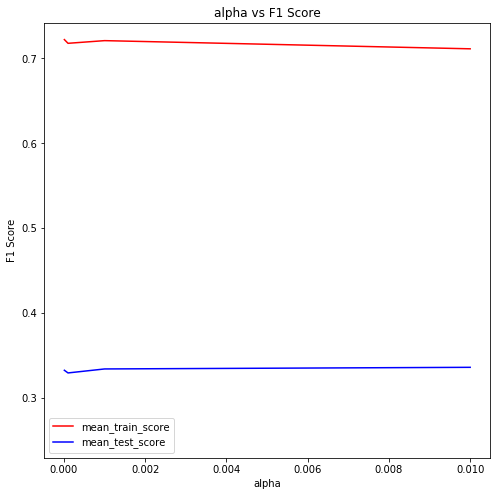

In [172]:
plot_model_complexity(nn_grid_search_results, 'alpha')

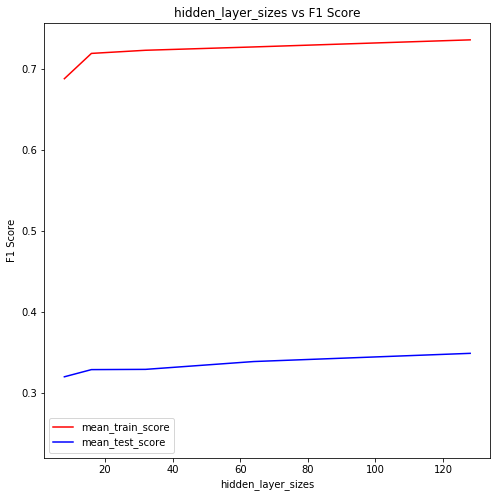

In [173]:
plot_model_complexity(nn_grid_search_results, 'hidden_layer_sizes')

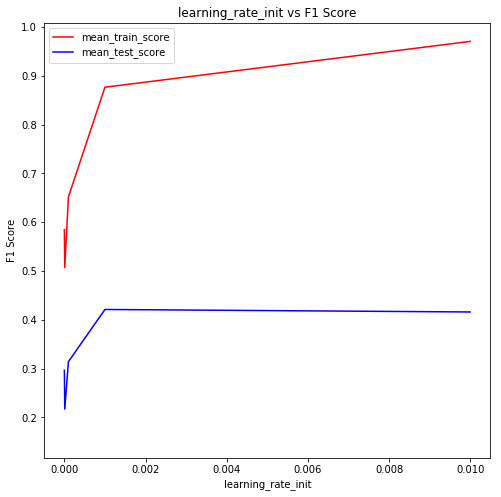

In [174]:
plot_model_complexity(nn_grid_search_results, 'learning_rate_init')

In [113]:
#http://scikit-learn.org/stable/auto_examples/model_selection/plot_learning_curve.html
def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None,
                        n_jobs=1, train_sizes=np.linspace(.1, 1.0, 5)):

    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes, scoring ='f1')
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.legend(loc="best")
    return plt

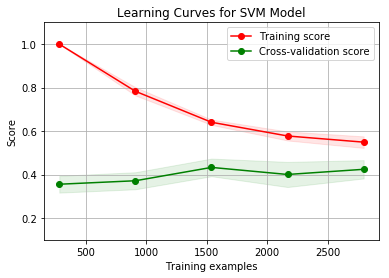

In [198]:
# SVM Learning Curve
#cv = ShuffleSplit(n_splits=5, test_size=0.2, random_state=0)
cv = StratifiedKFold(n_splits=5, random_state=0)
plot_learning_curve(svm_clf.best_estimator_, "Learning Curves for SVM Model"
                    , x_train, y_train, (0.1, 1.1), cv=cv, n_jobs=4)
plt.show()

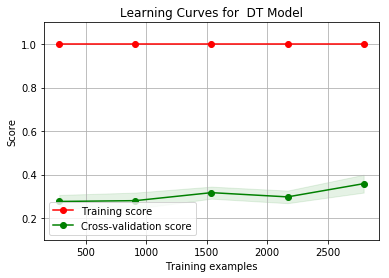

In [188]:
#DT Learning Curve
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=0)
plot_learning_curve(dt_clf.best_estimator_, "Learning Curves for  DT Model"
                    , x_train, y_train, (0.1, 1.1), cv=cv, n_jobs=4)
plt.show()

      Iter       Train Loss   Remaining Time 
         1           0.7169            0.81s
         2           0.6150            1.44s
         3           0.5445            1.27s
      Iter       Train Loss   Remaining Time 
         4           0.4834            1.94s
         1           0.8392            1.36s
         5           0.4340            2.13s
      Iter       Train Loss   Remaining Time 
         6           0.4037            2.01s
         2           0.7971            2.37s
         7           0.3670            1.95s
         1           0.8573            2.14s
         3           0.7601            2.86s
         8           0.3365            2.06s
         9           0.3138            2.19s
         4           0.7341            2.71s
         2           0.8145            3.28s
      Iter       Train Loss   Remaining Time 
         5           0.7066            2.80s
        10           0.2968            2.11s
         1           0.8373            6.38s
      

         4           0.7604            6.13s
         5           0.7453            7.21s
         6           0.7217            8.60s
         7           0.7062            8.82s
         8           0.6927            8.70s
        30           0.4799            5.64s
         9           0.6815            8.95s
        10           0.6688            8.66s
        40           0.4277            5.17s
        20           0.5778            7.12s
        50           0.3821            4.67s
        30           0.5158            6.15s
        60           0.3466            4.16s
       200           0.0871            0.67s
        70           0.3164            3.79s
       200           0.1708            1.31s
        40           0.4644            5.83s
        80           0.2883            3.60s
        50           0.4178            5.59s
        90           0.2676            3.34s
       100           0.2504            3.03s
        60           0.3862            5.16s
      Iter

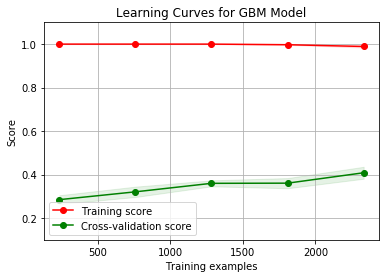

In [187]:
#GBM Learning Curve
plot_learning_curve(gbm_clf.best_estimator_, "Learning Curves for GBM Model"
                    , x_train, y_train, (0.1, 1.1), cv=cv, n_jobs=4)
plt.show()

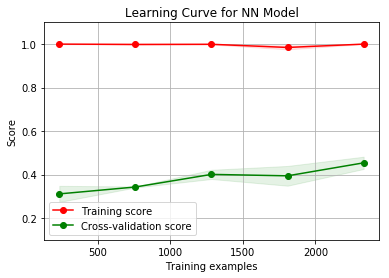

In [186]:
cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=0)
plot_learning_curve(MLPClassifier(alpha=0.01,learning_rate_init=0.001,hidden_layer_sizes=32
                                  ,activation='relu',solver='adam',verbose=False)
                                  ,"Learning Curve for NN Model"
                    , x_train, y_train, (0.1, 1.1), cv=cv, n_jobs=1)
plt.show()

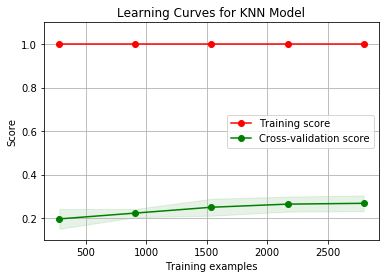

In [121]:
#KNN Learning Curve
plot_learning_curve(knn_clf.best_estimator_, "Learning Curves for KNN Model"
                    , x_train, y_train, (0.1, 1.1), cv=cv, n_jobs=4)
plt.show()

In [197]:
##EVALUATION ON TEST DATA
dt_preds = dt_clf.predict(x_test)
nn_preds = nn_clf.predict(x_test)
knn_preds = knn_clf.predict(x_test)
gbm_preds = gbm_clf.predict(x_test)
svm_preds = svm_clf.predict(x_test)

def get_performance(model, y_test, preds):
    f = round(f1_score(y_test, preds),3)
    a = round(accuracy_score(y_test, preds),3)
    p = round(precision_score(y_test, preds),3)
    r = round(recall_score(y_test, preds),3)
    
    return [model, f,a,p,r]

test_results =[] 
test_results.append(['Baseline', round(f1_score(y_train, baseline),3), round(accuracy_score(y_train, baseline),3)
                     , round(precision_score(y_train, baseline),3), round(recall_score(y_train, baseline),3)])
test_results.append(get_performance('Decision Tree' , np.array(y_test), dt_preds))
test_results.append(get_performance('SVM', np.array(y_test), svm_preds))
test_results.append(get_performance('GBM', np.array(y_test), gbm_preds))
test_results.append(get_performance('KNN', np.array(y_test), knn_preds))
test_results.append(get_performance('Neural Network', np.array(y_test), nn_preds))

cv_results = np.reshape(np.array([round(f1_score(y_train, baseline),3), 0.362, 0.422, 0.436, 0.277, 0.477]),(6,1))

test_results = pd.DataFrame(test_results, columns = ['Model','Test F1 Score', 'Test Accuracy', 'Test Precision', 'Test Recall'])
test_results['CV F1 Score'] = cv_results
test_results['% Diff Test F1 and CV F1'] = round(((test_results['Test F1 Score']/test_results['CV F1 Score']) - 1),3)*100

test_results.head(6)

Model  Test F1 Score  Test Accuracy  Test Precision  Test Recall  \
0  Baseline        0.180          0.705          0.166           0.196         
1  Decision Tree   0.364          0.781          0.348           0.382         
2  SVM             0.384          0.853          0.611           0.280         
3  GBM             0.418          0.842          0.528           0.346         
4  KNN             0.258          0.808          0.352           0.203         
5  Neural Network  0.459          0.852          0.573           0.382         

   CV F1 Score  % Diff Test F1 and CV F1  
0  0.180        0.0                       
1  0.362        0.6                       
2  0.422       -9.0                       
3  0.436       -4.1                       
4  0.277       -6.9                       
5  0.477       -3.8

In [209]:
epochs = [x*5 for x in range(1,20)]
print(epochs)
parameters = {'alpha':[0.01], 'hidden_layer_sizes':[32]
              ,'learning_rate_init':[0.001],'activation':['relu']
            , 'solver':['adam'], 'max_iter':epochs}

nn = MLPClassifier(verbose =1, early_stopping=False, tol = 0.0000001)
nn_model = GridSearchCV(nn, parameters, cv= 3, scoring = 'f1')
nn_model.fit(x_train, y_train)

[5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60, 65, 70, 75, 80, 85, 90, 95]
Iteration 1, loss = 0.59324502
Iteration 2, loss = 0.50599245
Iteration 3, loss = 0.46807150
Iteration 4, loss = 0.44680077
Iteration 5, loss = 0.43014778
Iteration 1, loss = 0.53940398
Iteration 2, loss = 0.48392112
Iteration 3, loss = 0.45791845
Iteration 4, loss = 0.43923957
Iteration 5, loss = 0.42196915
Iteration 1, loss = 0.71395952
Iteration 2, loss = 0.56644590
Iteration 3, loss = 0.49765335
Iteration 4, loss = 0.46826303
Iteration 5, loss = 0.44844905
Iteration 1, loss = 0.67014421
Iteration 2, loss = 0.55500435
Iteration 3, loss = 0.49444339
Iteration 4, loss = 0.46551189
Iteration 5, loss = 0.44693372
Iteration 6, loss = 0.43094641
Iteration 7, loss = 0.41695150
Iteration 8, loss = 0.40387589
Iteration 9, loss = 0.39196774
Iteration 10, loss = 0.38124195
Iteration 1, loss = 0.62794747
Iteration 2, loss = 0.52312385
Iteration 3, loss = 0.47608242
Iteration 4, loss = 0.45295127
Iteration 5, loss = 0.43

Iteration 25, loss = 0.28232231
Iteration 26, loss = 0.27909710
Iteration 27, loss = 0.27611338
Iteration 28, loss = 0.27329614
Iteration 29, loss = 0.26978957
Iteration 30, loss = 0.26722828
Iteration 1, loss = 0.60908848
Iteration 2, loss = 0.48434206
Iteration 3, loss = 0.44655350
Iteration 4, loss = 0.42990428
Iteration 5, loss = 0.41357578
Iteration 6, loss = 0.40072139
Iteration 7, loss = 0.38878625
Iteration 8, loss = 0.37848034
Iteration 9, loss = 0.36883169
Iteration 10, loss = 0.35968003
Iteration 11, loss = 0.35149111
Iteration 12, loss = 0.34398834
Iteration 13, loss = 0.33690587
Iteration 14, loss = 0.33084026
Iteration 15, loss = 0.32451619
Iteration 16, loss = 0.31899905
Iteration 17, loss = 0.31399344
Iteration 18, loss = 0.30942008
Iteration 19, loss = 0.30476650
Iteration 20, loss = 0.30051640
Iteration 21, loss = 0.29657603
Iteration 22, loss = 0.29258526
Iteration 23, loss = 0.28914840
Iteration 24, loss = 0.28525232
Iteration 25, loss = 0.28180067
Iteration 26, los

Iteration 1, loss = 0.74694471
Iteration 2, loss = 0.56817390
Iteration 3, loss = 0.49512226
Iteration 4, loss = 0.46511285
Iteration 5, loss = 0.44708999
Iteration 6, loss = 0.43043871
Iteration 7, loss = 0.41645130
Iteration 8, loss = 0.40368562
Iteration 9, loss = 0.39198768
Iteration 10, loss = 0.38181481
Iteration 11, loss = 0.37209798
Iteration 12, loss = 0.36303619
Iteration 13, loss = 0.35487284
Iteration 14, loss = 0.34747792
Iteration 15, loss = 0.34041631
Iteration 16, loss = 0.33413264
Iteration 17, loss = 0.32812718
Iteration 18, loss = 0.32243663
Iteration 19, loss = 0.31717602
Iteration 20, loss = 0.31248867
Iteration 21, loss = 0.30786988
Iteration 22, loss = 0.30351067
Iteration 23, loss = 0.29918543
Iteration 24, loss = 0.29500035
Iteration 25, loss = 0.29134501
Iteration 26, loss = 0.28752761
Iteration 27, loss = 0.28391183
Iteration 28, loss = 0.28070533
Iteration 29, loss = 0.27700114
Iteration 30, loss = 0.27383346
Iteration 31, loss = 0.27013063
Iteration 32, los

Iteration 37, loss = 0.23245243
Iteration 38, loss = 0.22917965
Iteration 39, loss = 0.22582210
Iteration 40, loss = 0.22305990
Iteration 41, loss = 0.22016726
Iteration 42, loss = 0.21806532
Iteration 43, loss = 0.21436614
Iteration 44, loss = 0.21127465
Iteration 45, loss = 0.20766930
Iteration 46, loss = 0.20461381
Iteration 47, loss = 0.20145311
Iteration 48, loss = 0.19871324
Iteration 49, loss = 0.19555849
Iteration 50, loss = 0.19249695
Iteration 1, loss = 0.71311220
Iteration 2, loss = 0.56454364
Iteration 3, loss = 0.49984421
Iteration 4, loss = 0.47285134
Iteration 5, loss = 0.45482739
Iteration 6, loss = 0.43879815
Iteration 7, loss = 0.42481478
Iteration 8, loss = 0.41211001
Iteration 9, loss = 0.40053962
Iteration 10, loss = 0.38959244
Iteration 11, loss = 0.37996321
Iteration 12, loss = 0.37038124
Iteration 13, loss = 0.36203625
Iteration 14, loss = 0.35332867
Iteration 15, loss = 0.34576109
Iteration 16, loss = 0.33852622
Iteration 17, loss = 0.33181509
Iteration 18, los

Iteration 25, loss = 0.28042701
Iteration 26, loss = 0.27694407
Iteration 27, loss = 0.27338452
Iteration 28, loss = 0.27023427
Iteration 29, loss = 0.26663369
Iteration 30, loss = 0.26354407
Iteration 31, loss = 0.26030030
Iteration 32, loss = 0.25688463
Iteration 33, loss = 0.25369145
Iteration 34, loss = 0.25044008
Iteration 35, loss = 0.24731748
Iteration 36, loss = 0.24411068
Iteration 37, loss = 0.24097240
Iteration 38, loss = 0.23781901
Iteration 39, loss = 0.23462512
Iteration 40, loss = 0.23139921
Iteration 41, loss = 0.22832948
Iteration 42, loss = 0.22506384
Iteration 43, loss = 0.22206595
Iteration 44, loss = 0.21896860
Iteration 45, loss = 0.21578597
Iteration 46, loss = 0.21274660
Iteration 47, loss = 0.20958018
Iteration 48, loss = 0.20664593
Iteration 49, loss = 0.20336940
Iteration 50, loss = 0.20070748
Iteration 51, loss = 0.19754843
Iteration 52, loss = 0.19455512
Iteration 53, loss = 0.19158085
Iteration 54, loss = 0.18924141
Iteration 55, loss = 0.18619959
Iteratio

Iteration 42, loss = 0.26256983
Iteration 43, loss = 0.25974214
Iteration 44, loss = 0.25703258
Iteration 45, loss = 0.25428369
Iteration 46, loss = 0.25146080
Iteration 47, loss = 0.24896630
Iteration 48, loss = 0.24653653
Iteration 49, loss = 0.24356062
Iteration 50, loss = 0.24052481
Iteration 51, loss = 0.23807607
Iteration 52, loss = 0.23532766
Iteration 53, loss = 0.23271372
Iteration 54, loss = 0.22967033
Iteration 55, loss = 0.22710159
Iteration 56, loss = 0.22451714
Iteration 57, loss = 0.22156821
Iteration 58, loss = 0.21917407
Iteration 59, loss = 0.21735838
Iteration 60, loss = 0.21414348
Iteration 61, loss = 0.21110891
Iteration 62, loss = 0.20831128
Iteration 63, loss = 0.20540975
Iteration 64, loss = 0.20268908
Iteration 65, loss = 0.19980547
Iteration 1, loss = 0.65083049
Iteration 2, loss = 0.53404537
Iteration 3, loss = 0.48060800
Iteration 4, loss = 0.45900485
Iteration 5, loss = 0.44198773
Iteration 6, loss = 0.42660966
Iteration 7, loss = 0.41316519
Iteration 8, lo

Iteration 35, loss = 0.23643412
Iteration 36, loss = 0.23288463
Iteration 37, loss = 0.22956039
Iteration 38, loss = 0.22715805
Iteration 39, loss = 0.22390037
Iteration 40, loss = 0.22017656
Iteration 41, loss = 0.21717745
Iteration 42, loss = 0.21367741
Iteration 43, loss = 0.21072977
Iteration 44, loss = 0.20722511
Iteration 45, loss = 0.20422406
Iteration 46, loss = 0.20092255
Iteration 47, loss = 0.19775932
Iteration 48, loss = 0.19479121
Iteration 49, loss = 0.19166412
Iteration 50, loss = 0.18858089
Iteration 51, loss = 0.18613174
Iteration 52, loss = 0.18260075
Iteration 53, loss = 0.17958842
Iteration 54, loss = 0.17663578
Iteration 55, loss = 0.17365984
Iteration 56, loss = 0.17093622
Iteration 57, loss = 0.16800799
Iteration 58, loss = 0.16528956
Iteration 59, loss = 0.16239186
Iteration 60, loss = 0.15960891
Iteration 61, loss = 0.15666731
Iteration 62, loss = 0.15389179
Iteration 63, loss = 0.15120124
Iteration 64, loss = 0.14832962
Iteration 65, loss = 0.14590155
Iteratio

Iteration 68, loss = 0.15680986
Iteration 69, loss = 0.15407607
Iteration 70, loss = 0.15156876
Iteration 71, loss = 0.14911842
Iteration 72, loss = 0.14635161
Iteration 73, loss = 0.14420941
Iteration 74, loss = 0.14164684
Iteration 75, loss = 0.13903500
Iteration 76, loss = 0.13667103
Iteration 77, loss = 0.13428967
Iteration 78, loss = 0.13177147
Iteration 79, loss = 0.12967489
Iteration 80, loss = 0.12713155
Iteration 1, loss = 0.66275574
Iteration 2, loss = 0.52681375
Iteration 3, loss = 0.48000029
Iteration 4, loss = 0.45376742
Iteration 5, loss = 0.43325369
Iteration 6, loss = 0.41418255
Iteration 7, loss = 0.39838378
Iteration 8, loss = 0.38497547
Iteration 9, loss = 0.37311944
Iteration 10, loss = 0.36201344
Iteration 11, loss = 0.35234027
Iteration 12, loss = 0.34354588
Iteration 13, loss = 0.33579840
Iteration 14, loss = 0.32872932
Iteration 15, loss = 0.32211320
Iteration 16, loss = 0.31584839
Iteration 17, loss = 0.31066605
Iteration 18, loss = 0.30572434
Iteration 19, los

Iteration 11, loss = 0.35168499
Iteration 12, loss = 0.34217479
Iteration 13, loss = 0.33437498
Iteration 14, loss = 0.32672243
Iteration 15, loss = 0.32000259
Iteration 16, loss = 0.31388172
Iteration 17, loss = 0.30836073
Iteration 18, loss = 0.30303711
Iteration 19, loss = 0.29810521
Iteration 20, loss = 0.29393553
Iteration 21, loss = 0.28897693
Iteration 22, loss = 0.28484050
Iteration 23, loss = 0.28069260
Iteration 24, loss = 0.27668103
Iteration 25, loss = 0.27300134
Iteration 26, loss = 0.26940140
Iteration 27, loss = 0.26555021
Iteration 28, loss = 0.26237280
Iteration 29, loss = 0.25852498
Iteration 30, loss = 0.25541409
Iteration 31, loss = 0.25265827
Iteration 32, loss = 0.24956073
Iteration 33, loss = 0.24610804
Iteration 34, loss = 0.24221235
Iteration 35, loss = 0.23946587
Iteration 36, loss = 0.23609951
Iteration 37, loss = 0.23299790
Iteration 38, loss = 0.23006945
Iteration 39, loss = 0.22694207
Iteration 40, loss = 0.22393190
Iteration 41, loss = 0.22072854
Iteratio

Iteration 28, loss = 0.27108202
Iteration 29, loss = 0.26805085
Iteration 30, loss = 0.26453473
Iteration 31, loss = 0.26126984
Iteration 32, loss = 0.25816210
Iteration 33, loss = 0.25500151
Iteration 34, loss = 0.25193675
Iteration 35, loss = 0.24914259
Iteration 36, loss = 0.24598563
Iteration 37, loss = 0.24261912
Iteration 38, loss = 0.23945296
Iteration 39, loss = 0.23691975
Iteration 40, loss = 0.23368217
Iteration 41, loss = 0.23079424
Iteration 42, loss = 0.22766704
Iteration 43, loss = 0.22440576
Iteration 44, loss = 0.22148580
Iteration 45, loss = 0.21893777
Iteration 46, loss = 0.21567116
Iteration 47, loss = 0.21260684
Iteration 48, loss = 0.20953463
Iteration 49, loss = 0.20663575
Iteration 50, loss = 0.20365678
Iteration 51, loss = 0.20080937
Iteration 52, loss = 0.19800918
Iteration 53, loss = 0.19506085
Iteration 54, loss = 0.19196929
Iteration 55, loss = 0.18951969
Iteration 56, loss = 0.18668937
Iteration 57, loss = 0.18391707
Iteration 58, loss = 0.18097832
Iteratio

Iteration 24, loss = 0.28351011
Iteration 25, loss = 0.27988156
Iteration 26, loss = 0.27662936
Iteration 27, loss = 0.27302919
Iteration 28, loss = 0.26993221
Iteration 29, loss = 0.26671686
Iteration 30, loss = 0.26342718
Iteration 31, loss = 0.26012325
Iteration 32, loss = 0.25690570
Iteration 33, loss = 0.25407665
Iteration 34, loss = 0.25083668
Iteration 35, loss = 0.24797300
Iteration 36, loss = 0.24496960
Iteration 37, loss = 0.24209846
Iteration 38, loss = 0.23928168
Iteration 39, loss = 0.23642318
Iteration 40, loss = 0.23339120
Iteration 41, loss = 0.23060686
Iteration 42, loss = 0.22762082
Iteration 43, loss = 0.22502288
Iteration 44, loss = 0.22228606
Iteration 45, loss = 0.21948828
Iteration 46, loss = 0.21597076
Iteration 47, loss = 0.21331908
Iteration 48, loss = 0.21070667
Iteration 49, loss = 0.20759065
Iteration 50, loss = 0.20457781
Iteration 51, loss = 0.20192679
Iteration 52, loss = 0.19906537
Iteration 53, loss = 0.19635481
Iteration 54, loss = 0.19324949
Iteratio

GridSearchCV(cv=3, error_score='raise',
       estimator=MLPClassifier(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
       beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=(100,), learning_rate='constant',
       learning_rate_init=0.001, max_iter=200, momentum=0.9,
       nesterovs_momentum=True, power_t=0.5, random_state=None,
       shuffle=True, solver='adam', tol=1e-07, validation_fraction=0.1,
       verbose=1, warm_start=False),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'alpha': [0.01], 'hidden_layer_sizes': [32], 'learning_rate_init': [0.001], 'activation': ['relu'], 'solver': ['adam'], 'max_iter': [5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60, 65, 70, 75, 80, 85, 90, 95]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='f1', verbose=0)

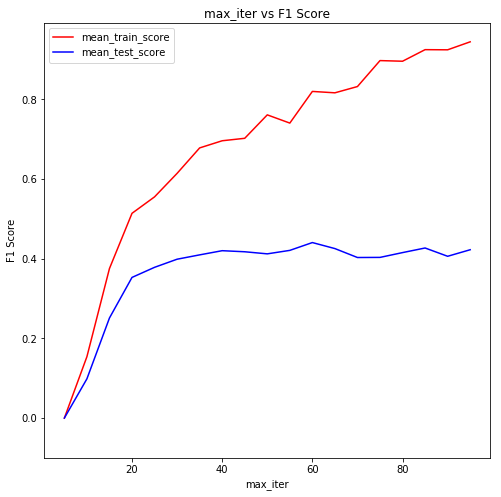

In [210]:
nn_model_grid_search_results = pd.DataFrame(nn_model.cv_results_).sort_values(by='rank_test_score')
plot_model_complexity(nn_model_grid_search_results, 'max_iter')

In [211]:
iterations = [x*10 for x in range(1,99)]
parameters = {'n_estimators':iterations}
g = GradientBoostingClassifier(verbose =1, max_depth = 3, learning_rate = 0.3)
nn_model = GridSearchCV(g, parameters, cv= 3, scoring = 'f1')
nn_model.fit(x_train, y_train)

      Iter       Train Loss   Remaining Time 
         1           0.8468            0.07s
         2           0.8078            0.08s
         3           0.7771            0.06s
         4           0.7586            0.05s
         5           0.7390            0.04s
         6           0.7227            0.04s
         7           0.7078            0.03s
         8           0.6962            0.02s
         9           0.6841            0.01s
        10           0.6717            0.00s
      Iter       Train Loss   Remaining Time 
         1           0.8407            0.06s
         2           0.8061            0.06s
         3           0.7817            0.06s
         4           0.7580            0.05s
         5           0.7400            0.04s
         6           0.7219            0.03s
         7           0.7085            0.02s
         8           0.6952            0.02s
         9           0.6802            0.01s
        10           0.6692            0.00s
      It

         5           0.7391            0.38s
         6           0.7224            0.39s
         7           0.7087            0.45s
         8           0.6937            0.47s
         9           0.6783            0.48s
        10           0.6673            0.48s
        20           0.5754            0.32s
        30           0.5124            0.21s
        40           0.4603            0.10s
        50           0.4206            0.00s
      Iter       Train Loss   Remaining Time 
         1           0.8468            0.46s
         2           0.8078            0.56s
         3           0.7771            0.56s
         4           0.7586            0.55s
         5           0.7390            0.56s
         6           0.7227            0.57s
         7           0.7078            0.56s
         8           0.6962            0.54s
         9           0.6841            0.52s
        10           0.6717            0.50s
        20           0.5862            0.35s
        3

        30           0.5198            0.46s
        40           0.4673            0.39s
        50           0.4231            0.33s
        60           0.3899            0.25s
        70           0.3612            0.16s
        80           0.3315            0.08s
        90           0.3069            0.00s
      Iter       Train Loss   Remaining Time 
         1           0.8391            0.75s
         2           0.8089            0.77s
         3           0.7831            0.71s
         4           0.7589            0.68s
         5           0.7391            0.67s
         6           0.7224            0.65s
         7           0.7087            0.63s
         8           0.6937            0.66s
         9           0.6783            0.69s
        10           0.6673            0.69s
        20           0.5754            0.55s
        30           0.5124            0.48s
        40           0.4603            0.42s
        50           0.4206            0.35s
        6

        70           0.3612            0.42s
        80           0.3315            0.34s
        90           0.3069            0.26s
       100           0.2844            0.17s
      Iter       Train Loss   Remaining Time 
         1           0.8391            0.88s
         2           0.8089            0.90s
         3           0.7831            0.87s
         4           0.7589            0.86s
         5           0.7391            0.87s
         6           0.7224            0.88s
         7           0.7087            0.87s
         8           0.6937            0.94s
         9           0.6783            0.96s
        10           0.6673            0.98s
        20           0.5754            0.80s
        30           0.5124            0.72s
        40           0.4603            0.66s
        50           0.4206            0.57s
        60           0.3808            0.49s
        70           0.3573            0.41s
        80           0.3336            0.33s
        9

        90           0.3069            0.51s
       100           0.2844            0.43s
      Iter       Train Loss   Remaining Time 
         1           0.8391            1.11s
         2           0.8089            1.13s
         3           0.7831            1.11s
         4           0.7589            1.11s
         5           0.7391            1.10s
         6           0.7224            1.08s
         7           0.7087            1.07s
         8           0.6937            1.11s
         9           0.6783            1.15s
        10           0.6673            1.16s
        20           0.5754            1.10s
        30           0.5124            1.10s
        40           0.4603            1.05s
        50           0.4206            0.97s
        60           0.3808            0.89s
        70           0.3573            0.76s
        80           0.3336            0.66s
        90           0.3133            0.55s
       100           0.2946            0.45s
      Ite

      Iter       Train Loss   Remaining Time 
         1           0.8391            1.38s
         2           0.8089            1.44s
         3           0.7831            1.43s
         4           0.7589            1.45s
         5           0.7391            1.43s
         6           0.7224            1.43s
         7           0.7087            1.42s
         8           0.6937            1.50s
         9           0.6783            1.53s
        10           0.6673            1.53s
        20           0.5754            1.33s
        30           0.5124            1.25s
        40           0.4603            1.16s
        50           0.4206            1.06s
        60           0.3808            1.00s
        70           0.3573            0.89s
        80           0.3336            0.81s
        90           0.3133            0.72s
       100           0.2946            0.64s
      Iter       Train Loss   Remaining Time 
         1           0.8468            1.32s
        

       100           0.2844            1.00s
       200           0.1562            0.10s
      Iter       Train Loss   Remaining Time 
         1           0.8391            1.69s
         2           0.8089            1.72s
         3           0.7831            1.71s
         4           0.7589            1.74s
         5           0.7391            1.98s
         6           0.7224            2.02s
         7           0.7087            2.15s
         8           0.6937            2.26s
         9           0.6783            2.40s
        10           0.6673            2.61s
        20           0.5754            2.52s
        30           0.5124            2.47s
        40           0.4603            2.33s
        50           0.4206            2.38s
        60           0.3808            2.16s
        70           0.3573            1.95s
        80           0.3336            1.83s
        90           0.3133            1.65s
       100           0.2946            1.44s
       20

        30           0.5198            1.55s
        40           0.4673            1.49s
        50           0.4231            1.46s
        60           0.3899            1.44s
        70           0.3612            1.39s
        80           0.3315            1.33s
        90           0.3069            1.23s
       100           0.2844            1.13s
       200           0.1562            0.32s
      Iter       Train Loss   Remaining Time 
         1           0.8391            1.96s
         2           0.8089            2.00s
         3           0.7831            1.91s
         4           0.7589            2.14s
         5           0.7391            2.14s
         6           0.7224            2.11s
         7           0.7087            2.08s
         8           0.6937            2.14s
         9           0.6783            2.19s
        10           0.6673            2.17s
        20           0.5754            1.92s
        30           0.5124            1.85s
        4

        30           0.5198            2.31s
        40           0.4673            2.17s
        50           0.4231            2.10s
        60           0.3899            1.99s
        70           0.3612            1.88s
        80           0.3315            1.81s
        90           0.3069            1.69s
       100           0.2844            1.58s
       200           0.1562            0.62s
      Iter       Train Loss   Remaining Time 
         1           0.8391            1.94s
         2           0.8089            1.98s
         3           0.7831            1.94s
         4           0.7589            1.94s
         5           0.7391            1.93s
         6           0.7224            1.90s
         7           0.7087            1.89s
         8           0.6937            1.97s
         9           0.6783            2.05s
        10           0.6673            2.06s
        20           0.5754            1.85s
        30           0.5124            1.84s
        4

        20           0.5808            3.51s
        30           0.5198            3.06s
        40           0.4673            2.77s
        50           0.4231            2.57s
        60           0.3899            2.45s
        70           0.3612            2.29s
        80           0.3315            2.20s
        90           0.3069            2.06s
       100           0.2844            1.92s
       200           0.1562            0.88s
       300           0.0943            0.00s
      Iter       Train Loss   Remaining Time 
         1           0.8391            3.23s
         2           0.8089            2.85s
         3           0.7831            2.88s
         4           0.7589            2.82s
         5           0.7391            2.74s
         6           0.7224            2.61s
         7           0.7087            2.59s
         8           0.6937            2.63s
         9           0.6783            2.72s
        10           0.6673            2.73s
        2

        80           0.3224            2.48s
        90           0.3028            2.31s
       100           0.2817            2.17s
       200           0.1533            1.19s
       300           0.0938            0.27s
      Iter       Train Loss   Remaining Time 
         1           0.8407            2.41s
         2           0.8061            2.44s
         3           0.7817            2.43s
         4           0.7580            2.40s
         5           0.7400            2.38s
         6           0.7219            2.41s
         7           0.7085            2.43s
         8           0.6952            2.49s
         9           0.6802            2.57s
        10           0.6692            2.62s
        20           0.5808            2.98s
        30           0.5198            3.07s
        40           0.4673            2.77s
        50           0.4231            2.61s
        60           0.3899            2.46s
        70           0.3612            2.28s
        8

        30           0.5165            2.75s
        40           0.4609            2.62s
        50           0.4167            2.43s
        60           0.3777            2.36s
        70           0.3471            2.28s
        80           0.3224            2.17s
        90           0.3028            2.07s
       100           0.2817            2.00s
       200           0.1533            1.23s
       300           0.0938            0.46s
      Iter       Train Loss   Remaining Time 
         1           0.8407            2.64s
         2           0.8061            2.62s
         3           0.7817            2.75s
         4           0.7580            2.75s
         5           0.7400            2.70s
         6           0.7219            2.67s
         7           0.7085            2.66s
         8           0.6952            2.72s
         9           0.6802            2.77s
        10           0.6692            2.80s
        20           0.5808            2.67s
        3

       200           0.1623            1.55s
       300           0.1008            0.66s
      Iter       Train Loss   Remaining Time 
         1           0.8468            2.64s
         2           0.8078            2.94s
         3           0.7773            2.91s
         4           0.7588            2.88s
         5           0.7394            2.86s
         6           0.7233            2.98s
         7           0.7083            3.02s
         8           0.6968            2.96s
         9           0.6847            2.94s
        10           0.6723            2.92s
        20           0.5898            2.89s
        30           0.5165            2.85s
        40           0.4609            2.74s
        50           0.4167            2.62s
        60           0.3777            2.72s
        70           0.3471            2.66s
        80           0.3224            2.61s
        90           0.3028            2.68s
       100           0.2817            2.72s
       20

       400           0.0614            0.08s
      Iter       Train Loss   Remaining Time 
         1           0.8391            3.25s
         2           0.8089            3.33s
         3           0.7831            3.22s
         4           0.7589            3.18s
         5           0.7391            3.25s
         6           0.7224            3.20s
         7           0.7087            3.20s
         8           0.6937            3.42s
         9           0.6783            3.62s
        10           0.6673            3.80s
        20           0.5754            3.90s
        30           0.5124            3.84s
        40           0.4603            4.43s
        50           0.4206            4.14s
        60           0.3808            3.85s
        70           0.3573            3.53s
        80           0.3336            3.34s
        90           0.3133            3.14s
       100           0.2946            2.96s
       200           0.1623            1.98s
       30

       200           0.1533            2.19s
       300           0.0938            1.23s
       400           0.0602            0.35s
      Iter       Train Loss   Remaining Time 
         1           0.8407            3.80s
         2           0.8061            3.78s
         3           0.7817            3.79s
         4           0.7580            3.62s
         5           0.7400            3.55s
         6           0.7219            3.52s
         7           0.7085            3.47s
         8           0.6952            3.52s
         9           0.6802            3.57s
        10           0.6692            3.56s
        20           0.5808            3.36s
        30           0.5198            3.26s
        40           0.4673            3.13s
        50           0.4231            3.05s
        60           0.3899            3.13s
        70           0.3612            3.04s
        80           0.3315            2.96s
        90           0.3069            2.89s
       10

        90           0.3133            3.27s
       100           0.2946            3.15s
       200           0.1623            2.12s
       300           0.1008            1.29s
       400           0.0638            0.50s
      Iter       Train Loss   Remaining Time 
         1           0.8468            4.48s
         2           0.8078            4.88s
         3           0.7771            4.66s
         4           0.7586            4.60s
         5           0.7390            4.53s
         6           0.7227            4.69s
         7           0.7078            4.76s
         8           0.6962            4.77s
         9           0.6841            4.87s
        10           0.6717            4.82s
        20           0.5862            4.49s
        30           0.5118            4.31s
        40           0.4625            4.14s
        50           0.4195            4.01s
        60           0.3715            3.94s
        70           0.3417            3.79s
        8

        80           0.3315            4.46s
        90           0.3069            4.27s
       100           0.2844            4.14s
       200           0.1562            2.92s
       300           0.0943            2.32s
       400           0.0614            1.07s
      Iter       Train Loss   Remaining Time 
         1           0.8391            7.65s
         2           0.8089            7.32s
         3           0.7831            6.28s
         4           0.7589            6.92s
         5           0.7391            6.81s
         6           0.7224            6.96s
         7           0.7087            6.92s
         8           0.6937            7.09s
         9           0.6783            7.10s
        10           0.6673            6.91s
        20           0.5754            5.82s
        30           0.5124            5.44s
        40           0.4603            5.44s
        50           0.4206            5.15s
        60           0.3808            4.92s
        7

        20           0.5862            3.89s
        30           0.5118            3.95s
        40           0.4625            3.84s
        50           0.4195            3.71s
        60           0.3715            3.70s
        70           0.3417            3.57s
        80           0.3144            3.50s
        90           0.2916            3.43s
       100           0.2733            3.31s
       200           0.1506            2.71s
       300           0.0922            1.80s
       400           0.0590            0.99s
       500           0.0392            0.16s
      Iter       Train Loss   Remaining Time 
         1           0.8407            3.46s
         2           0.8061            4.00s
         3           0.7817            4.02s
         4           0.7580            3.96s
         5           0.7400            3.87s
         6           0.7219            3.88s
         7           0.7085            3.80s
         8           0.6952            3.88s
         

        30           0.5124            4.22s
        40           0.4603            4.20s
        50           0.4206            4.07s
        60           0.3808            4.01s
        70           0.3573            3.87s
        80           0.3336            3.77s
        90           0.3133            3.65s
       100           0.2946            3.53s
       200           0.1623            2.66s
       300           0.1008            1.86s
       400           0.0638            1.09s
       500           0.0432            0.31s
      Iter       Train Loss   Remaining Time 
         1           0.8468            3.87s
         2           0.8078            4.34s
         3           0.7773            4.18s
         4           0.7588            4.10s
         5           0.7394            4.19s
         6           0.7233            4.28s
         7           0.7083            4.33s
         8           0.6968            4.26s
         9           0.6847            4.22s
        1

        30           0.5198            4.64s
        40           0.4673            4.39s
        50           0.4231            4.24s
        60           0.3899            4.16s
        70           0.3612            4.06s
        80           0.3315            3.98s
        90           0.3069            4.03s
       100           0.2844            3.99s
       200           0.1562            3.04s
       300           0.0943            2.16s
       400           0.0614            1.33s
       500           0.0410            0.54s
      Iter       Train Loss   Remaining Time 
         1           0.8391            4.27s
         2           0.8089            4.36s
         3           0.7831            4.25s
         4           0.7589            4.26s
         5           0.7391            4.29s
         6           0.7224            4.21s
         7           0.7087            4.19s
         8           0.6937            4.40s
         9           0.6783            4.54s
        1

        20           0.5862            8.44s
        30           0.5118            7.89s
        40           0.4625            7.65s
        50           0.4195            7.11s
        60           0.3715            6.93s
        70           0.3417            6.60s
        80           0.3144            6.39s
        90           0.2916            6.23s
       100           0.2733            5.97s
       200           0.1506            4.20s
       300           0.0922            2.97s
       400           0.0590            1.93s
       500           0.0392            0.96s
       600           0.0262            0.00s
      Iter       Train Loss   Remaining Time 
         1           0.8407            5.41s
         2           0.8061            5.93s
         3           0.7817            6.18s
         4           0.7580            6.08s
         5           0.7400            6.61s
         6           0.7219            6.81s
         7           0.7085            6.66s
         

        90           0.3069            5.07s
       100           0.2844            4.97s
       200           0.1562            3.72s
       300           0.0943            2.82s
       400           0.0614            1.90s
       500           0.0410            1.02s
       600           0.0272            0.17s
      Iter       Train Loss   Remaining Time 
         1           0.8391            5.99s
         2           0.8089            5.78s
         3           0.7831            5.34s
         4           0.7589            5.32s
         5           0.7391            5.25s
         6           0.7224            5.12s
         7           0.7087            5.13s
         8           0.6937            5.40s
         9           0.6783            5.53s
        10           0.6673            5.62s
        20           0.5754            5.14s
        30           0.5124            5.11s
        40           0.4603            5.45s
        50           0.4206            5.59s
        6

      Iter       Train Loss   Remaining Time 
         1           0.8468            5.24s
         2           0.8078            5.50s
         3           0.7771            5.31s
         4           0.7586            5.34s
         5           0.7390            5.28s
         6           0.7227            5.55s
         7           0.7078            5.65s
         8           0.6962            5.51s
         9           0.6841            5.47s
        10           0.6717            5.47s
        20           0.5862            5.82s
        30           0.5118            5.79s
        40           0.4625            5.74s
        50           0.4195            5.54s
        60           0.3715            5.54s
        70           0.3417            5.38s
        80           0.3144            5.27s
        90           0.2916            5.17s
       100           0.2733            5.02s
       200           0.1506            4.00s
       300           0.0922            3.11s
       40

        30           0.5198            5.29s
        40           0.4673            5.13s
        50           0.4231            5.05s
        60           0.3899            5.02s
        70           0.3612            4.91s
        80           0.3315            4.83s
        90           0.3069            4.74s
       100           0.2844            4.64s
       200           0.1562            3.76s
       300           0.0943            2.95s
       400           0.0614            2.27s
       500           0.0410            1.41s
       600           0.0272            0.60s
      Iter       Train Loss   Remaining Time 
         1           0.8391            5.46s
         2           0.8089            5.52s
         3           0.7831            5.36s
         4           0.7589            5.41s
         5           0.7391            5.48s
         6           0.7224            5.45s
         7           0.7087            5.36s
         8           0.6937            5.58s
         

       100           0.2946            9.04s
       200           0.1623            7.10s
       300           0.1008            5.29s
       400           0.0638            4.33s
       500           0.0432            2.86s
       600           0.0289            1.43s
      Iter       Train Loss   Remaining Time 
         1           0.8468            6.30s
         2           0.8078            6.34s
         3           0.7773            6.90s
         4           0.7588            6.76s
         5           0.7394            6.56s
         6           0.7233            6.95s
         7           0.7083            6.79s
         8           0.6968            6.70s
         9           0.6847            6.62s
        10           0.6723            6.60s
        20           0.5898            6.49s
        30           0.5165            7.00s
        40           0.4609            7.21s
        50           0.4167            7.34s
        60           0.3777            7.39s
        7

       200           0.1533            4.65s
       300           0.0938            3.80s
       400           0.0602            2.94s
       500           0.0402            2.01s
       600           0.0269            1.11s
       700           0.0183            0.20s
      Iter       Train Loss   Remaining Time 
         1           0.8407            7.04s
         2           0.8061            6.72s
         3           0.7817            6.50s
         4           0.7580            6.41s
         5           0.7400            6.44s
         6           0.7219            6.60s
         7           0.7085            6.49s
         8           0.6952            6.74s
         9           0.6802            6.92s
        10           0.6692            6.88s
        20           0.5808            6.84s
        30           0.5198            6.79s
        40           0.4673            6.66s
        50           0.4231            6.83s
        60           0.3899            6.86s
        7

       200           0.1562            5.06s
       300           0.0943            4.17s
       400           0.0614            3.31s
       500           0.0410            2.33s
       600           0.0272            1.36s
       700           0.0183            0.39s
      Iter       Train Loss   Remaining Time 
         1           0.8391            8.15s
         2           0.8089            7.62s
         3           0.7831            7.87s
         4           0.7589            7.39s
         5           0.7391            7.60s
         6           0.7224            7.64s
         7           0.7087            7.46s
         8           0.6937            7.77s
         9           0.6783            8.16s
        10           0.6673            8.34s
        20           0.5754            7.81s
        30           0.5124            7.44s
        40           0.4603            7.61s
        50           0.4206            7.55s
        60           0.3808            7.53s
        7

       200           0.1623            5.23s
       300           0.1008            4.53s
       400           0.0638            3.50s
       500           0.0432            2.47s
       600           0.0289            1.53s
       700           0.0199            0.57s
      Iter       Train Loss   Remaining Time 
         1           0.8468            8.11s
         2           0.8078            7.67s
         3           0.7773            7.57s
         4           0.7588            7.78s
         5           0.7394            8.10s
         6           0.7233            8.47s
         7           0.7083            8.57s
         8           0.6968            8.38s
         9           0.6847            8.34s
        10           0.6723            8.25s
        20           0.5898           10.11s
        30           0.5165            9.37s
        40           0.4609            8.98s
        50           0.4167            8.27s
        60           0.3777            7.92s
        7

       200           0.1533            5.27s
       300           0.0938            4.54s
       400           0.0602            3.64s
       500           0.0402            2.70s
       600           0.0269            1.79s
       700           0.0183            0.88s
      Iter       Train Loss   Remaining Time 
         1           0.8407            8.32s
         2           0.8061            7.79s
         3           0.7817            8.14s
         4           0.7580            8.58s
         5           0.7400            8.51s
         6           0.7219            8.79s
         7           0.7085            8.87s
         8           0.6952            9.01s
         9           0.6802            9.01s
        10           0.6692            9.24s
        20           0.5808            9.35s
        30           0.5198            8.88s
        40           0.4673            8.39s
        50           0.4231            8.22s
        60           0.3899            8.13s
        7

        70           0.3612            6.41s
        80           0.3315            6.33s
        90           0.3069            6.21s
       100           0.2844            6.13s
       200           0.1562            5.38s
       300           0.0943            4.47s
       400           0.0614            3.58s
       500           0.0410            2.76s
       600           0.0272            1.86s
       700           0.0183            0.97s
       800           0.0126            0.09s
      Iter       Train Loss   Remaining Time 
         1           0.8391            7.58s
         2           0.8089            7.03s
         3           0.7831            7.09s
         4           0.7589            7.44s
         5           0.7391            7.27s
         6           0.7224            7.23s
         7           0.7087            7.08s
         8           0.6937            7.60s
         9           0.6783            7.84s
        10           0.6673            7.85s
        2

        30           0.5124            6.74s
        40           0.4603            6.78s
        50           0.4206            6.71s
        60           0.3808            6.93s
        70           0.3573            6.68s
        80           0.3336            6.55s
        90           0.3133            6.48s
       100           0.2946            6.64s
       200           0.1623            7.35s
       300           0.1008            5.87s
       400           0.0638            4.47s
       500           0.0432            3.30s
       600           0.0289            2.24s
       700           0.0199            1.23s
       800           0.0136            0.28s
      Iter       Train Loss   Remaining Time 
         1           0.8468            9.28s
         2           0.8078            8.67s
         3           0.7771            8.44s
         4           0.7586            8.41s
         5           0.7390            8.27s
         6           0.7227            8.44s
         

        30           0.5165            6.62s
        40           0.4609            6.56s
        50           0.4167            6.75s
        60           0.3777            6.87s
        70           0.3471            6.72s
        80           0.3224            6.54s
        90           0.3028            6.42s
       100           0.2817            6.31s
       200           0.1533            5.19s
       300           0.0938            4.35s
       400           0.0602            3.62s
       500           0.0402            2.99s
       600           0.0269            2.14s
       700           0.0183            1.32s
       800           0.0126            0.50s
      Iter       Train Loss   Remaining Time 
         1           0.8407            5.84s
         2           0.8061            6.84s
         3           0.7817            6.72s
         4           0.7580            6.67s
         5           0.7400            6.58s
         6           0.7219            6.57s
         

        30           0.5198            7.06s
        40           0.4673            6.85s
        50           0.4231            6.82s
        60           0.3899            6.79s
        70           0.3612            6.60s
        80           0.3315            6.55s
        90           0.3069            6.43s
       100           0.2844            6.43s
       200           0.1562            5.81s
       300           0.0943            4.81s
       400           0.0614            4.03s
       500           0.0410            3.14s
       600           0.0272            2.29s
       700           0.0183            1.46s
       800           0.0126            0.67s
      Iter       Train Loss   Remaining Time 
         1           0.8391            7.80s
         2           0.8089            7.83s
         3           0.7831            8.03s
         4           0.7589            8.86s
         5           0.7391            8.83s
         6           0.7224            9.38s
         

        20           0.5754            7.52s
        30           0.5124            7.55s
        40           0.4603            7.51s
        50           0.4206            7.37s
        60           0.3808            7.34s
        70           0.3573            7.10s
        80           0.3336            7.10s
        90           0.3133            6.97s
       100           0.2946            6.77s
       200           0.1623            5.67s
       300           0.1008            4.74s
       400           0.0638            3.96s
       500           0.0432            3.22s
       600           0.0289            2.41s
       700           0.0199            1.61s
       800           0.0136            0.81s
       900           0.0095            0.00s
      Iter       Train Loss   Remaining Time 
         1           0.8468            8.93s
         2           0.8078            9.16s
         3           0.7773            8.97s
         4           0.7588            8.54s
         

       700           0.0199            1.82s
       800           0.0136            0.99s
       900           0.0095            0.17s
      Iter       Train Loss   Remaining Time 
         1           0.8468            6.80s
         2           0.8078            7.61s
         3           0.7773            7.53s
         4           0.7588            7.46s
         5           0.7394            7.35s
         6           0.7233            7.62s
         7           0.7083            7.67s
         8           0.6968            7.59s
         9           0.6847            7.51s
        10           0.6723            7.47s
        20           0.5898            7.17s
        30           0.5165            7.08s
        40           0.4609            7.01s
        50           0.4167            6.84s
        60           0.3777            6.85s
        70           0.3471            6.77s
        80           0.3224            6.61s
        90           0.3028            6.50s
       10

        30           0.5165            7.10s
        40           0.4609            7.68s
        50           0.4167            7.65s
        60           0.3777            7.71s
        70           0.3471            7.62s
        80           0.3224            7.49s
        90           0.3028            7.26s
       100           0.2817            7.33s
       200           0.1533            6.10s
       300           0.0938            5.21s
       400           0.0602            4.46s
       500           0.0402            3.62s
       600           0.0269            2.88s
       700           0.0183            2.08s
       800           0.0126            1.24s
       900           0.0086            0.41s
      Iter       Train Loss   Remaining Time 
         1           0.8407            7.03s
         2           0.8061            7.89s
         3           0.7817            7.65s
         4           0.7580            7.62s
         5           0.7400            7.53s
         

       800           0.0126            1.42s
       900           0.0086            0.58s
      Iter       Train Loss   Remaining Time 
         1           0.8407            7.35s
         2           0.8061            8.38s
         3           0.7817            8.38s
         4           0.7580            8.33s
         5           0.7400            8.32s
         6           0.7219            8.42s
         7           0.7085            8.30s
         8           0.6952            8.86s
         9           0.6802            9.10s
        10           0.6692            9.08s
        20           0.5808            8.50s
        30           0.5198            8.27s
        40           0.4673            7.96s
        50           0.4231            7.88s
        60           0.3899            7.78s
        70           0.3612            7.55s
        80           0.3315            7.51s
        90           0.3069            7.34s
       100           0.2844            7.43s
       20

GridSearchCV(cv=3, error_score='raise',
       estimator=GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.3, loss='deviance', max_depth=3,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=100,
              presort='auto', random_state=None, subsample=1.0, verbose=1,
              warm_start=False),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'n_estimators': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, 120, 130, 140, 150, 160, 170, 180, 190, 200, 210, 220, 230, 240, 250, 260, 270, 280, 290, 300, 310, 320, 330, 340, 350, 360, 370, 380, 390, 400, 410, 420, 430, 440, 450, 460, 470, 480, 490, 500, 510, 520, 530, 540, 550, 560, ...790, 800, 810, 820, 830, 840, 850, 860, 870, 880, 890, 900, 910, 920, 930, 940, 950, 960, 970, 980]},
       pre_disp

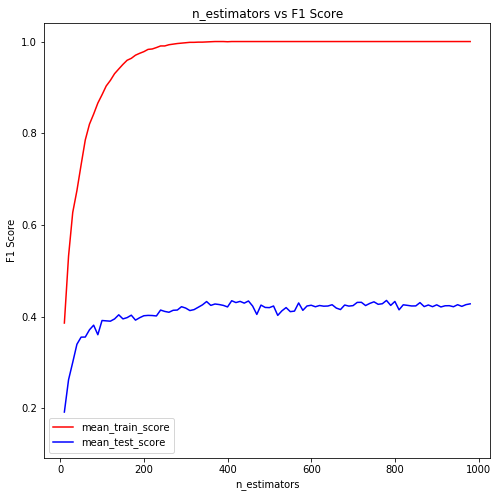

In [212]:
nn_model_grid_search_results = pd.DataFrame(nn_model.cv_results_).sort_values(by='rank_test_score')
plot_model_complexity(nn_model_grid_search_results, 'n_estimators')